In [2]:
from pathlib import Path

root = Path("/home/user/Downloads/yolo_ready_dataset_split")
for split in ["train", "val", "test"]:
    imgs = sorted((root/"images"/split).glob("*.*"))
    lbls = sorted((root/"labels"/split).glob("*.txt"))
    img_stems = {p.stem for p in imgs}
    lbl_stems = {p.stem for p in lbls}
    missing_lbl = img_stems - lbl_stems
    missing_img = lbl_stems - img_stems
    print(f"{split}: {len(imgs)} images, {len(lbls)} labels")
    if missing_lbl:
        print(f"  ⚠️ Missing label files for: {sorted(missing_lbl)[:5]}{'...' if len(missing_lbl)>5 else ''}")
    if missing_img:
        print(f"  ⚠️ Label files without images: {sorted(missing_img)[:5]}{'...' if len(missing_img)>5 else ''}")


train: 11980 images, 11980 labels
val: 1494 images, 1494 labels
test: 1508 images, 1508 labels


In [3]:
rm /home/user/Downloads/yolo_ready_dataset_split/labels/*.cache

/usr/bin/rm: cannot remove '/home/user/Downloads/yolo_ready_dataset_split/labels/*.cache': No such file or directory


In [5]:
from ultralytics import YOLO

model = YOLO("yolov8n.yaml")

model.train(
    data="/home/user/Downloads/yolo_ready_dataset_split/dataset.yaml",
    epochs=500,
    imgsz=640,
    batch=16,
    name="wildlife_intrusion_final",
    patience=30       # early stop after 30 epochs without val_loss improvement
)


New https://pypi.org/project/ultralytics/8.3.158 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.119 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A6000, 48548MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/home/user/Downloads/yolo_ready_dataset_split/dataset.yaml, epochs=500, time=None, patience=30, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=wildlife_intrusion_final2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks

train: Scanning /home/user/Downloads/yolo_ready_dataset_split/labels/train... 11


train: New cache created: /home/user/Downloads/yolo_ready_dataset_split/labels/train.cache
WARNING ⚠️ No labels found in /home/user/Downloads/yolo_ready_dataset_split/labels/train.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 696.4±448.5 MB/s, size: 32.5 KB)


val: Scanning /home/user/Downloads/yolo_ready_dataset_split/labels/val... 1494 i

val: New cache created: /home/user/Downloads/yolo_ready_dataset_split/labels/val.cache
WARNING ⚠️ No labels found in /home/user/Downloads/yolo_ready_dataset_split/labels/val.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


Plotting labels to runs/detect/wildlife_intrusion_final2/labels.jpg... 
WARNING ⚠️ zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/wildlife_intrusion_final2
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
      1/500      2.28G          0      65.84          0          0        640:  libpng warning: iCCP: known incorrect sRGB profile
      1/500      2.28G          0      40.54          0          0        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  mlibpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mlibpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
                 Class     Images  Instances      Box(P          R      mAP50  m


RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [10]:
file='/home/user/Downloads/yolo_ready_dataset_split/images/test/bear_00004.jpg'
file

'/home/user/Downloads/yolo_ready_dataset_split/images/test/bear_00004.jpg'

In [13]:
from PIL import Image

try:
    img = Image.open('/home/user/Downloads/yolo_ready_dataset_split/images/test/bear_00004.jpg')
    if "icc_profile" in img.info:
        # You would need to parse the ICC profile to confirm it's sRGB
        # This is a simplified check, as parsing ICC profiles is complex.
        if b"sRGB" in img.info["icc_profile"]:
            print("Image likely has an sRGB ICC profile.")
        else:
            print("Image has an ICC profile, but it might not be sRGB.")
    else:
        print("Image does not have an embedded ICC profile.")
except FileNotFoundError:
    print("Image file not found.")

Image does not have an embedded ICC profile.


In [14]:
import random
from pathlib import Path
from shutil import copy2
from PIL import Image
from tqdm import tqdm

# ─── CONFIG ────────────────────────────────────────────────────────────────────
MERGED_DIR   = Path("/home/user/Downloads/merged_dataset")          # your merged images
OUTPUT_DIR   = Path("/home/user/Downloads/yolo_ready_dataset_unified")
SPLITS       = ["train", "val", "test"]
RATIOS       = {"train": 0.8, "val": 0.1, "test": 0.1}
BOX_SCALE    = 0.7   # 70% centered box
# ────────────────────────────────────────────────────────────────────────────────

# 1) Prepare output folders
for split in SPLITS:
    (OUTPUT_DIR / "images" / split).mkdir(parents=True, exist_ok=True)
    (OUTPUT_DIR / "labels" / split).mkdir(parents=True, exist_ok=True)

# 2) Get class list
class_dirs = [d for d in MERGED_DIR.iterdir() if d.is_dir()]
class_names = sorted([d.name for d in class_dirs])
class_to_id = {name:i for i,name in enumerate(class_names)}
print("Classes:", class_names)

# 3) Split & label per class
for cls_dir in class_dirs:
    cls = cls_dir.name
    cls_id = class_to_id[cls]
    imgs = list(cls_dir.glob("*.*"))
    random.shuffle(imgs)
    total = len(imgs)
    n_train = int(total * RATIOS["train"])
    n_val   = int(total * RATIOS["val"])
    # ensure sum matches
    n_test  = total - n_train - n_val

    bounds = {
      "train": (0, n_train),
      "val":   (n_train, n_train + n_val),
      "test":  (n_train + n_val, total)
    }

    for split, (start, end) in bounds.items():
        for img_path in tqdm(imgs[start:end], desc=f"{cls} → {split}"):
            # 3a) copy image
            dest_img = OUTPUT_DIR / "images" / split / img_path.name
            copy2(img_path, dest_img)

            # 3b) read dims
            with Image.open(img_path) as im:
                w, h = im.size

            # 3c) build centered box
            bw = BOX_SCALE
            bh = BOX_SCALE
            xc = 0.5
            yc = 0.5

            # 3d) write label
            lbl_path = OUTPUT_DIR / "labels" / split / f"{img_path.stem}.txt"
            lbl_path.write_text(f"{cls_id} {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f}\n")

# 4) Write dataset.yaml
yaml_path = OUTPUT_DIR / "dataset.yaml"
with open(yaml_path, "w") as f:
    f.write(f"""path: {OUTPUT_DIR}
train: images/train
val:   images/val
test:  images/test

names: {class_names}
""")

print("\n✅ Unified split + auto-label complete!")
print("▶️ Images and labels in:", OUTPUT_DIR)
print("▶️ dataset.yaml at:", yaml_path)


Classes: ['.ipynb_checkpoints', 'Elephants', 'Mice', 'Rats', 'Shrew', 'bear', 'bison', 'cow', 'deer', 'goat', 'leopard', 'rabbit', 'racoon', 'sheep', 'wild boar', 'wolf']


Mice → test: 100%|████████████████████████████| 52/52 [00:00<00:00, 1947.51it/s]
.ipynb_checkpoints → train: 0it [00:00, ?it/s]
.ipynb_checkpoints → val: 0it [00:00, ?it/s]
.ipynb_checkpoints → test: 0it [00:00, ?it/s]
wild boar → test: 100%|█████████████████████| 100/100 [00:00<00:00, 1760.53it/s]


✅ Unified split + auto-label complete!
▶️ Images and labels in: /home/user/Downloads/yolo_ready_dataset_unified
▶️ dataset.yaml at: /home/user/Downloads/yolo_ready_dataset_unified/dataset.yaml


In [15]:
from ultralytics import YOLO
model = YOLO("yolov8n.yaml")
model.train(
  data="/home/user/Downloads/yolo_ready_dataset_unified/dataset.yaml",
  epochs=500,
  imgsz=640,
  batch=16,
  name="wildlife_intrusion_final"
)


New https://pypi.org/project/ultralytics/8.3.158 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.119 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A6000, 48548MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/home/user/Downloads/yolo_ready_dataset_unified/dataset.yaml, epochs=500, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=wildlife_intrusion_final3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

train: Scanning /home/user/Downloads/yolo_ready_dataset_unified/labels/train... 


train: New cache created: /home/user/Downloads/yolo_ready_dataset_unified/labels/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 771.9±666.3 MB/s, size: 40.7 KB)


val: Scanning /home/user/Downloads/yolo_ready_dataset_unified/labels/val... 1494


val: New cache created: /home/user/Downloads/yolo_ready_dataset_unified/labels/val.cache
Plotting labels to runs/detect/wildlife_intrusion_final3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/wildlife_intrusion_final3
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/500      2.32G      2.917      4.817      4.125         43        640:  libpng warning: iCCP: known incorrect sRGB profile
      1/500      2.32G      2.842      4.778       4.03         38        640:  libpng warning: iCCP: known incorrect sRGB profile
      1/500      2.32G      2.833      4.772      4.017         37        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
      1/500      2.32G      2.698      4.668      3.837         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.579     0.0993     0.0428     0.0146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/500      2.53G      1.902      3.937      2.755         42        640:  libpng warning: iCCP: known incorrect sRGB profile
      2/500      2.53G      1.721      3.669      2.546         45        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
      2/500      2.53G      1.628      3.538      2.442         43        640:  libpng warning: iCCP: known incorrect sRGB profile
      2/500      2.53G      1.396      3.211      2.166         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.225      0.668      0.207      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/500      2.53G      1.068      2.674      1.746         44        640:  libpng warning: iCCP: known incorrect sRGB profile
      3/500      2.53G      1.057      2.649      1.734         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
      3/500      2.53G      1.044      2.613      1.719         30        640:  libpng warning: iCCP: known incorrect sRGB profile
      3/500      2.53G      1.033      2.573      1.705         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.237      0.617      0.235        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/500      2.53G     0.9519      2.309      1.596         45        640:  libpng warning: iCCP: known incorrect sRGB profile
      4/500      2.53G     0.9344      2.251      1.582         37        640:  libpng warning: iCCP: known incorrect sRGB profile
      4/500      2.53G     0.9194      2.194      1.565         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
      4/500      2.53G     0.9176      2.188      1.564         36        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.334      0.661      0.328      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/500      2.53G     0.8811      2.012      1.518         39        640:  libpng warning: iCCP: known incorrect sRGB profile
      5/500      2.53G     0.8599      1.985      1.504         46        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
      5/500      2.53G     0.8445      1.949      1.491         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.344      0.709      0.331      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/500      2.53G     0.8069      1.877      1.457         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
      6/500      2.53G     0.7848      1.834      1.431         42        640:  libpng warning: iCCP: known incorrect sRGB profile
      6/500      2.53G     0.7753      1.814      1.421         41        640:  libpng warning: iCCP: known incorrect sRGB profile
      6/500      2.53G     0.7739       1.81       1.42         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.278      0.785      0.331      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/500      2.53G      0.749      1.757      1.392         40        640:  libpng warning: iCCP: known incorrect sRGB profile
      7/500      2.53G     0.7412      1.751      1.385         33        640:  libpng warning: iCCP: known incorrect sRGB profile
      7/500      2.53G     0.7351      1.746      1.381         43        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
      7/500      2.53G     0.7251      1.728      1.372         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.322      0.758      0.325      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/500      2.53G     0.6781      1.666       1.33         37        640:  libpng warning: iCCP: known incorrect sRGB profile
      8/500      2.53G     0.6747      1.666      1.327         44        640:  libpng warning: iCCP: known incorrect sRGB profile
      8/500      2.53G     0.6746      1.666      1.327         48        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
      8/500      2.53G     0.6708      1.659      1.322         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.373      0.757      0.376      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      9/500      2.53G     0.6393      1.609      1.294         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
      9/500      2.53G     0.6335      1.609      1.289         32        640:  libpng warning: iCCP: known incorrect sRGB profile
      9/500      2.53G       0.63        1.6      1.285         42        640:  libpng warning: iCCP: known incorrect sRGB profile
      9/500      2.53G     0.6304      1.601      1.285         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.341      0.788      0.381      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/500      2.53G      0.599      1.575      1.254         42        640:  libpng warning: iCCP: known incorrect sRGB profile
     10/500      2.53G     0.5941      1.564      1.248         34        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     10/500      2.53G     0.5923      1.562      1.247         40        640:  libpng warning: iCCP: known incorrect sRGB profile
     10/500      2.53G      0.593      1.562      1.248         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.344      0.848      0.369      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/500      2.53G     0.5764      1.547      1.234         36        640:  libpng warning: iCCP: known incorrect sRGB profile
     11/500      2.53G     0.5736      1.526      1.232         35        640:  libpng warning: iCCP: known incorrect sRGB profile
     11/500      2.53G     0.5692      1.518      1.226         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     11/500      2.53G     0.5637      1.511      1.221         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.347      0.814        0.4      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/500      2.53G     0.5433      1.475       1.21         37        640:  libpng warning: iCCP: known incorrect sRGB profile
     12/500      2.53G     0.5465      1.459      1.209         44        640:  libpng warning: iCCP: known incorrect sRGB profile
     12/500      2.53G     0.5446      1.472      1.206         37        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     12/500      2.53G     0.5375      1.475        1.2         36        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.351      0.791      0.432      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/500      2.53G     0.5406      1.458      1.201         45        640:  libpng warning: iCCP: known incorrect sRGB profile
     13/500      2.53G     0.5427      1.456      1.204         39        640:  libpng warning: iCCP: known incorrect sRGB profile
     13/500      2.53G     0.5155      1.451      1.182         45        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     13/500      2.53G     0.5134      1.449       1.18         36        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.36      0.802      0.437      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/500      2.53G     0.4985      1.429      1.174         36        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     14/500      2.53G     0.5019      1.439      1.178         37        640:  libpng warning: iCCP: known incorrect sRGB profile
     14/500      2.53G      0.492      1.421      1.165         34        640:  libpng warning: iCCP: known incorrect sRGB profile
     14/500      2.53G     0.4855      1.422      1.158         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.379      0.766      0.452      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/500      2.53G      0.491      1.434      1.154         30        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     15/500      2.53G     0.4682      1.402       1.14         43        640:  libpng warning: iCCP: known incorrect sRGB profile
     15/500      2.53G     0.4678      1.395      1.144         39        640:  libpng warning: iCCP: known incorrect sRGB profile
     15/500      2.53G     0.4683      1.395      1.144         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494       0.39       0.74       0.44      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/500      2.53G     0.4545      1.383      1.131         37        640:  libpng warning: iCCP: known incorrect sRGB profile
     16/500      2.53G     0.4527      1.378      1.129         32        640:  libpng warning: iCCP: known incorrect sRGB profile
     16/500      2.53G     0.4527      1.377       1.13         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     16/500      2.53G     0.4513      1.376      1.128         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.394      0.744      0.423      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/500      2.53G     0.4505      1.369      1.135         36        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     17/500      2.53G     0.4452       1.37      1.129         48        640:  libpng warning: iCCP: known incorrect sRGB profile
     17/500      2.53G     0.4397      1.365      1.124         44        640:  libpng warning: iCCP: known incorrect sRGB profile
     17/500      2.53G     0.4391      1.366      1.124         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.423      0.757      0.467      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/500      2.53G     0.4592      1.368      1.142         38        640:  libpng warning: iCCP: known incorrect sRGB profile
     18/500      2.53G     0.4216      1.338      1.103         53        640:  libpng warning: iCCP: known incorrect sRGB profile
     18/500      2.53G     0.4223      1.336      1.104         45        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     18/500      2.53G     0.4239      1.336      1.107         37        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.433      0.783      0.471      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/500      2.53G     0.4147      1.344      1.097         45        640:  libpng warning: iCCP: known incorrect sRGB profile
     19/500      2.53G     0.4133       1.32      1.099         33        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     19/500      2.53G     0.4132       1.32      1.099         44        640:  libpng warning: iCCP: known incorrect sRGB profile
     19/500      2.53G     0.4134       1.32      1.098         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.423      0.724      0.492      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/500      2.53G     0.4084      1.319      1.094         36        640:  libpng warning: iCCP: known incorrect sRGB profile
     20/500      2.53G     0.4011      1.315      1.092         37        640:  libpng warning: iCCP: known incorrect sRGB profile
     20/500      2.53G     0.4009      1.315      1.091         36        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     20/500      2.53G     0.4022      1.307      1.092         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.426      0.758      0.507      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/500      2.53G     0.3978      1.295      1.088         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     21/500      2.53G     0.3949      1.291      1.085         34        640:  libpng warning: iCCP: known incorrect sRGB profile
     21/500      2.53G     0.3924      1.291      1.083         39        640:  libpng warning: iCCP: known incorrect sRGB profile
     21/500      2.53G     0.3915      1.288      1.083         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.451      0.757      0.493      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/500      2.53G      0.383      1.269      1.078         42        640:  libpng warning: iCCP: known incorrect sRGB profile
     22/500      2.53G     0.3844      1.268      1.078         48        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     22/500      2.53G     0.3863      1.272       1.08         40        640:  libpng warning: iCCP: known incorrect sRGB profile
     22/500      2.53G     0.3863      1.273      1.079         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.424      0.704      0.454      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/500      2.53G     0.3758      1.269      1.069         48        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
     23/500      2.53G      0.377      1.267      1.069         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     23/500      2.53G     0.3801      1.265      1.073         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.452      0.742        0.5      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/500      2.53G     0.3583      1.254      1.055         33        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     24/500      2.53G     0.3675      1.253      1.064         40        640:  libpng warning: iCCP: known incorrect sRGB profile
     24/500      2.53G     0.3679      1.253      1.065         42        640:  libpng warning: iCCP: known incorrect sRGB profile
     24/500      2.53G     0.3676      1.251      1.065         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.445      0.802      0.523      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/500      2.53G     0.3695      1.248       1.07         47        640:  libpng warning: iCCP: known incorrect sRGB profile
     25/500      2.53G     0.3655      1.248      1.062         37        640:  libpng warning: iCCP: known incorrect sRGB profile
     25/500      2.53G      0.364      1.247      1.063         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     25/500      2.53G      0.364      1.246      1.063         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.461      0.756      0.527      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/500      2.53G     0.3624      1.219      1.064         38        640:  libpng warning: iCCP: known incorrect sRGB profile
     26/500      2.53G     0.3629      1.221      1.065         29        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     26/500      2.53G     0.3652      1.224      1.065         35        640:  libpng warning: iCCP: known incorrect sRGB profile
     26/500      2.53G     0.3593      1.232       1.06         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.447      0.796      0.525       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/500      2.53G     0.3522      1.198      1.054         46        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     27/500      2.53G     0.3504      1.208      1.052         39        640:  libpng warning: iCCP: known incorrect sRGB profile
     27/500      2.53G     0.3538      1.207      1.055         45        640:  libpng warning: iCCP: known incorrect sRGB profile
     27/500      2.53G     0.3524       1.22      1.055         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.394      0.776      0.528      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/500      2.53G     0.3472       1.14      1.044         39        640:  libpng warning: iCCP: known incorrect sRGB profile
     28/500      2.53G     0.3433      1.204       1.05         43        640:  libpng warning: iCCP: known incorrect sRGB profile
     28/500      2.53G     0.3514      1.212      1.056         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     28/500      2.53G      0.348       1.21      1.053         36        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.462      0.709      0.541      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/500      2.53G     0.3374      1.206      1.043         41        640:  libpng warning: iCCP: known incorrect sRGB profile
     29/500      2.53G     0.3429      1.208      1.049         49        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     29/500      2.53G     0.3431      1.207       1.05         41        640:  libpng warning: iCCP: known incorrect sRGB profile
     29/500      2.53G     0.3439      1.205      1.051         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.498      0.726      0.563      0.557

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/500      2.53G     0.3395      1.213      1.045         42        640:  libpng warning: iCCP: known incorrect sRGB profile
     30/500      2.53G     0.3386      1.215      1.045         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     30/500      2.53G     0.3406       1.21      1.047         40        640:  libpng warning: iCCP: known incorrect sRGB profile
     30/500      2.53G     0.3389      1.205      1.044         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.453      0.766      0.567      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/500      2.53G     0.3412      1.184      1.047         45        640:  libpng warning: iCCP: known incorrect sRGB profile
     31/500      2.53G      0.337      1.178      1.044         36        640:  libpng warning: iCCP: known incorrect sRGB profile
     31/500      2.53G     0.3388      1.178      1.045         43        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     31/500      2.53G     0.3356      1.181      1.042         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.429      0.767       0.57      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/500      2.53G     0.3231      1.162      1.024         40        640:  libpng warning: iCCP: known incorrect sRGB profile
     32/500      2.53G     0.3303      1.161      1.036         45        640:  libpng warning: iCCP: known incorrect sRGB profile
     32/500      2.53G     0.3294      1.161      1.036         35        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     32/500      2.53G     0.3286      1.172      1.036         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.514      0.741      0.571      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/500      2.53G     0.3339      1.159      1.038         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     33/500      2.53G     0.3335       1.16      1.039         41        640:  libpng warning: iCCP: known incorrect sRGB profile
     33/500      2.53G     0.3307      1.162      1.037         41        640:  libpng warning: iCCP: known incorrect sRGB profile
     33/500      2.53G     0.3289      1.159      1.034         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.525      0.711      0.583      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/500      2.53G     0.3212      1.168      1.031         41        640:  libpng warning: iCCP: known incorrect sRGB profile
     34/500      2.53G     0.3201      1.151      1.028         38        640:  libpng warning: iCCP: known incorrect sRGB profile
     34/500      2.53G     0.3204      1.152       1.03         43        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     34/500      2.53G     0.3203       1.15      1.029         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.457      0.799      0.603      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/500      2.53G     0.3154      1.134      1.018         33        640:  libpng warning: iCCP: known incorrect sRGB profile
     35/500      2.53G      0.318      1.138      1.022         31        640:  libpng warning: iCCP: known incorrect sRGB profile
     35/500      2.53G     0.3196      1.149      1.027         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     35/500      2.53G     0.3211      1.147      1.028         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.531      0.751       0.59      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/500      2.53G     0.3283      1.133      1.037         44        640:  libpng warning: iCCP: known incorrect sRGB profile
     36/500      2.53G     0.3224      1.137      1.033         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     36/500      2.53G     0.3247      1.136      1.035         45        640:  libpng warning: iCCP: known incorrect sRGB profile
     36/500      2.53G      0.324      1.136      1.034         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.558      0.773       0.61      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/500      2.53G     0.3029      1.033      1.029         46        640:  libpng warning: iCCP: known incorrect sRGB profile
     37/500      2.53G     0.3141      1.126      1.022         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     37/500      2.53G     0.3146      1.128      1.022         37        640:  libpng warning: iCCP: known incorrect sRGB profile
     37/500      2.53G     0.3148       1.13      1.022         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.545      0.724      0.592      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/500      2.53G     0.3263      1.125      1.033         40        640:  libpng warning: iCCP: known incorrect sRGB profile
     38/500      2.53G     0.3274      1.138      1.035         46        640:  libpng warning: iCCP: known incorrect sRGB profile
     38/500      2.53G     0.3212      1.134      1.031         45        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     38/500      2.53G     0.3191      1.124      1.029         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.542      0.737      0.611      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/500      2.53G     0.3099      1.105      1.026         37        640:  libpng warning: iCCP: known incorrect sRGB profile
     39/500      2.53G     0.3088      1.105      1.018         38        640:  libpng warning: iCCP: known incorrect sRGB profile
     39/500      2.53G     0.3067      1.101      1.016         49        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     39/500      2.53G     0.3109      1.111       1.02         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.558      0.722       0.61      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/500      2.53G     0.3197       1.14      1.027         47        640:  libpng warning: iCCP: known incorrect sRGB profile
     40/500      2.53G     0.3181      1.115      1.025         45        640:  libpng warning: iCCP: known incorrect sRGB profile
     40/500      2.53G     0.3141       1.11      1.022         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     40/500      2.53G     0.3121      1.107       1.02         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494       0.49      0.764      0.619      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/500      2.53G     0.3091      1.111      1.022         37        640:  libpng warning: iCCP: known incorrect sRGB profile
     41/500      2.53G     0.3083      1.107      1.022         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     41/500      2.53G     0.3072      1.095      1.017         41        640:  libpng warning: iCCP: known incorrect sRGB profile
     41/500      2.53G     0.3075      1.096      1.019         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.565      0.765      0.625      0.621

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/500      2.53G     0.3072      1.106       1.02         31        640:  libpng warning: iCCP: known incorrect sRGB profile
     42/500      2.53G     0.3069      1.105      1.019         43        640:  libpng warning: iCCP: known incorrect sRGB profile
     42/500      2.53G     0.3046      1.102      1.016         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     42/500      2.53G     0.3045      1.098      1.015         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.554      0.763      0.623      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/500      2.53G     0.3079      1.087      1.017         43        640:  libpng warning: iCCP: known incorrect sRGB profile
     43/500      2.53G     0.3005      1.089       1.01         38        640:  libpng warning: iCCP: known incorrect sRGB profile
     43/500      2.53G     0.2991      1.086      1.011         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     43/500      2.53G     0.2995      1.087      1.012         43        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     43/500      2.53G     0.2997      1.088      1.012         22        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.568      0.751      0.637      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/500      2.53G     0.3064      1.096      1.024         41        640:  libpng warning: iCCP: known incorrect sRGB profile
     44/500      2.53G     0.3029      1.083      1.018         41        640:  libpng warning: iCCP: known incorrect sRGB profile
     44/500      2.53G     0.2993      1.083      1.012         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.556      0.783      0.627      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/500      2.53G     0.2956      1.059      1.011         41        640:  libpng warning: iCCP: known incorrect sRGB profile
     45/500      2.53G      0.294      1.082      1.005         38        640:  libpng warning: iCCP: known incorrect sRGB profile
     45/500      2.53G     0.2953      1.077      1.005         47        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     45/500      2.53G     0.2954      1.078      1.007         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.537      0.785      0.649      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/500      2.53G     0.2983      1.091      1.007         54        640:  libpng warning: iCCP: known incorrect sRGB profile
     46/500      2.53G     0.2985      1.079      1.007         36        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     46/500      2.53G     0.2986      1.069      1.008         42        640:  libpng warning: iCCP: known incorrect sRGB profile
     46/500      2.53G     0.2988      1.069      1.009         23        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.529       0.79      0.654      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/500      2.53G      0.291      1.063      1.006         45        640:  libpng warning: iCCP: known incorrect sRGB profile
     47/500      2.53G     0.2901      1.056      1.003         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     47/500      2.53G     0.2939      1.059      1.006         41        640:  libpng warning: iCCP: known incorrect sRGB profile
     47/500      2.53G     0.2953      1.058      1.006         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.594      0.748      0.655      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/500      2.53G     0.2851      1.042     0.9999         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     48/500      2.53G     0.2882      1.044      1.003         42        640:  libpng warning: iCCP: known incorrect sRGB profile
     48/500      2.53G     0.2928      1.049      1.005         41        640:  libpng warning: iCCP: known incorrect sRGB profile
     48/500      2.53G     0.2926      1.047      1.006         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.505      0.798      0.662      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/500      2.53G     0.2882       1.06      1.003         35        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     49/500      2.53G     0.2903      1.056      1.003         42        640:  libpng warning: iCCP: known incorrect sRGB profile
     49/500      2.53G     0.2927      1.054      1.006         39        640:  libpng warning: iCCP: known incorrect sRGB profile
     49/500      2.53G     0.2922      1.054      1.007         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.602      0.787      0.672       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/500      2.53G     0.2891      1.037      1.006         39        640:  libpng warning: iCCP: known incorrect sRGB profile
     50/500      2.53G      0.289      1.035      1.005         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     50/500      2.53G     0.2915      1.041      1.007         41        640:  libpng warning: iCCP: known incorrect sRGB profile
     50/500      2.53G     0.2884      1.041      1.003         44        640:  libpng warning: iCCP: known incorrect sRGB profile
     50/500      2.53G     0.2883      1.041      1.003         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.597      0.784      0.674      0.672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/500      2.53G     0.2821       1.06      1.004         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     51/500      2.53G     0.2884      1.039      1.002         42        640:  libpng warning: iCCP: known incorrect sRGB profile
     51/500      2.53G     0.2883      1.041      1.002         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.531      0.785      0.676      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/500      2.53G     0.2943      1.057      1.004         36        640:  libpng warning: iCCP: known incorrect sRGB profile
     52/500      2.53G     0.2917      1.042      1.003         34        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     52/500      2.53G     0.2913       1.04      1.003         45        640:  libpng warning: iCCP: known incorrect sRGB profile
     52/500      2.53G      0.291      1.038      1.003         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.513      0.789      0.669      0.667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/500      2.53G     0.2835      1.019     0.9976         37        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     53/500      2.53G      0.291       1.02      1.002         43        640:  libpng warning: iCCP: known incorrect sRGB profile
     53/500      2.53G     0.2887      1.025      1.001         38        640:  libpng warning: iCCP: known incorrect sRGB profile
     53/500      2.53G     0.2891      1.025      1.001         39        640:  libpng warning: iCCP: known incorrect sRGB profile
     53/500      2.53G     0.2894      1.025      1.001         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.518      0.784      0.676      0.673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/500      2.53G     0.2958     0.9957     0.9978         38        640:  libpng warning: iCCP: known incorrect sRGB profile
     54/500      2.53G     0.2872      1.022     0.9984         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     54/500      2.53G      0.287      1.023     0.9978         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.528      0.787      0.684      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/500      2.53G     0.2879       1.01      1.001         34        640:  libpng warning: iCCP: known incorrect sRGB profile
     55/500      2.53G     0.2873      1.014      1.001         45        640:  libpng warning: iCCP: known incorrect sRGB profile
     55/500      2.53G     0.2876      1.014          1         37        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     55/500      2.53G     0.2876      1.012     0.9992         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.541       0.79      0.688      0.686

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/500      2.53G     0.2576     0.9356     0.9666         43        640:  libpng warning: iCCP: known incorrect sRGB profile
     56/500      2.53G     0.2849      1.029     0.9925         37        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     56/500      2.53G     0.2843      1.008     0.9971         34        640:  libpng warning: iCCP: known incorrect sRGB profile
     56/500      2.53G     0.2832      1.012     0.9976         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.533      0.795      0.694      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/500      2.53G     0.2801     0.9606     0.9873         48        640:  libpng warning: iCCP: known incorrect sRGB profile
     57/500      2.53G     0.2831      1.002     0.9962         37        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     57/500      2.53G     0.2823      1.004     0.9958         32        640:  libpng warning: iCCP: known incorrect sRGB profile
     57/500      2.53G     0.2844      1.007     0.9975         37        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.541      0.799      0.691      0.688

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/500      2.53G     0.2774     0.9955     0.9892         35        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     58/500      2.53G     0.2797     0.9988     0.9928         43        640:  libpng warning: iCCP: known incorrect sRGB profile
     58/500      2.53G     0.2794          1     0.9941         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.614      0.778      0.697      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/500      2.53G     0.2832     0.9963      0.998         46        640:  libpng warning: iCCP: known incorrect sRGB profile
     59/500      2.53G     0.2853     0.9963     0.9995         35        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     59/500      2.53G     0.2825     0.9966     0.9986         49        640:  libpng warning: iCCP: known incorrect sRGB profile
     59/500      2.53G     0.2822     0.9967     0.9973         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.525        0.8        0.7      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/500      2.53G     0.2809     0.9898     0.9871         35        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     60/500      2.53G     0.2787     0.9933     0.9885         46        640:  libpng warning: iCCP: known incorrect sRGB profile
     60/500      2.53G     0.2756     0.9905     0.9873         39        640:  libpng warning: iCCP: known incorrect sRGB profile
     60/500      2.53G     0.2772     0.9849     0.9894         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.527      0.809      0.704      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/500      2.53G     0.2765     0.9894     0.9885         43        640:  libpng warning: iCCP: known incorrect sRGB profile
     61/500      2.53G     0.2746     0.9873     0.9918         44        640:  libpng warning: iCCP: known incorrect sRGB profile
     61/500      2.53G     0.2764     0.9902     0.9928         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     61/500      2.53G     0.2769       0.99     0.9925         23        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.543      0.794      0.709      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/500      2.53G     0.2792     0.9759     0.9831         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     62/500      2.53G     0.2747     0.9767     0.9831         42        640:  libpng warning: iCCP: known incorrect sRGB profile
     62/500      2.53G     0.2772     0.9943     0.9891         46        640:  libpng warning: iCCP: known incorrect sRGB profile
     62/500      2.53G     0.2762     0.9808     0.9886         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.555      0.785      0.713      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/500      2.53G     0.2683     0.9477     0.9848         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     63/500      2.53G     0.2709     0.9709     0.9844         40        640:  libpng warning: iCCP: known incorrect sRGB profile
     63/500      2.53G     0.2711     0.9713     0.9846         37        640:  libpng warning: iCCP: known incorrect sRGB profile
     63/500      2.53G     0.2718     0.9731     0.9878         23        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.569      0.761      0.719      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/500      2.53G     0.2812     0.9665     0.9894         40        640:  libpng warning: iCCP: known incorrect sRGB profile
     64/500      2.53G     0.2722     0.9713     0.9833         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     64/500      2.53G     0.2735      0.971     0.9855         42        640:  libpng warning: iCCP: known incorrect sRGB profile
     64/500      2.53G     0.2736     0.9685     0.9858         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.651      0.738      0.723      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/500      2.53G     0.2594     0.9409     0.9729         35        640:  libpng warning: iCCP: known incorrect sRGB profile
     65/500      2.53G     0.2721     0.9598     0.9857         37        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     65/500      2.53G     0.2713     0.9583     0.9857         41        640:  libpng warning: iCCP: known incorrect sRGB profile
     65/500      2.53G      0.271     0.9602     0.9861         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.662      0.724      0.726      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/500      2.53G      0.272     0.9833     0.9907         34        640:  libpng warning: iCCP: known incorrect sRGB profile
     66/500      2.53G     0.2737     0.9645     0.9889         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     66/500      2.53G     0.2738      0.963     0.9882         46        640:  libpng warning: iCCP: known incorrect sRGB profile
     66/500      2.53G     0.2732     0.9576     0.9881         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.568      0.773      0.729      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/500      2.53G     0.2642      0.978     0.9871         39        640:  libpng warning: iCCP: known incorrect sRGB profile
     67/500      2.53G     0.2688      0.952     0.9853         40        640:  libpng warning: iCCP: known incorrect sRGB profile
     67/500      2.53G     0.2693     0.9471     0.9868         47        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     67/500      2.53G     0.2712     0.9469     0.9872         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.564      0.788      0.731      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/500      2.53G     0.2664     0.9444     0.9841         35        640:  libpng warning: iCCP: known incorrect sRGB profile
     68/500      2.53G     0.2671     0.9586     0.9827         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     68/500      2.53G     0.2662     0.9577     0.9825         43        640:  libpng warning: iCCP: known incorrect sRGB profile
     68/500      2.53G     0.2664     0.9557     0.9832         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.557      0.796      0.733      0.731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/500      2.53G      0.274     0.9574     0.9897         40        640:  libpng warning: iCCP: known incorrect sRGB profile
     69/500      2.53G     0.2747     0.9563     0.9903         34        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     69/500      2.53G     0.2749     0.9533       0.99         35        640:  libpng warning: iCCP: known incorrect sRGB profile
     69/500      2.53G     0.2747      0.951     0.9894         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.563      0.802      0.738      0.736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/500      2.53G     0.2685     0.9355     0.9861         39        640:  libpng warning: iCCP: known incorrect sRGB profile
     70/500      2.53G     0.2686     0.9349     0.9856         39        640:  libpng warning: iCCP: known incorrect sRGB profile
     70/500      2.53G     0.2691      0.936     0.9863         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     70/500      2.53G     0.2684     0.9365     0.9855         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.561      0.805       0.74      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/500      2.53G     0.2711     0.9009     0.9891         40        640:  libpng warning: iCCP: known incorrect sRGB profile
     71/500      2.53G     0.2714     0.9092     0.9896         35        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     71/500      2.53G     0.2682     0.9204     0.9874         38        640:  libpng warning: iCCP: known incorrect sRGB profile
     71/500      2.53G     0.2662     0.9261     0.9841         45        640:  libpng warning: iCCP: known incorrect sRGB profile
     71/500      2.53G     0.2662     0.9268     0.9842         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.563      0.807      0.745      0.743

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/500      2.53G     0.2704     0.9114     0.9872         41        640:  libpng warning: iCCP: known incorrect sRGB profile
     72/500      2.53G     0.2649     0.9324     0.9833         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     72/500      2.53G     0.2674     0.9278     0.9837         37        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.687      0.709      0.747      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/500      2.53G     0.2655     0.9183     0.9862         36        640:  libpng warning: iCCP: known incorrect sRGB profile
     73/500      2.53G     0.2653     0.9067     0.9841         38        640:  libpng warning: iCCP: known incorrect sRGB profile
     73/500      2.53G     0.2666     0.9243     0.9848         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     73/500      2.53G     0.2667     0.9254     0.9847         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.681      0.718      0.751      0.749

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/500      2.53G     0.2716     0.9052     0.9887         40        640:  libpng warning: iCCP: known incorrect sRGB profile
     74/500      2.53G     0.2644     0.9181     0.9812         41        640:  libpng warning: iCCP: known incorrect sRGB profile
     74/500      2.53G     0.2653     0.9205     0.9812         47        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     74/500      2.53G     0.2638     0.9178     0.9805         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.695       0.71      0.754      0.751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/500      2.53G     0.2646     0.9205     0.9837         31        640:  libpng warning: iCCP: known incorrect sRGB profile
     75/500      2.53G     0.2631     0.9257     0.9815         38        640:  libpng warning: iCCP: known incorrect sRGB profile
     75/500      2.53G     0.2624     0.9228     0.9802         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     75/500      2.53G     0.2651     0.9219     0.9815         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.701      0.708      0.756      0.754

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/500      2.53G     0.2619     0.9269     0.9785         44        640:  libpng warning: iCCP: known incorrect sRGB profile
     76/500      2.53G     0.2637     0.9263     0.9794         31        640:  libpng warning: iCCP: known incorrect sRGB profile
     76/500      2.53G     0.2608     0.9188     0.9775         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     76/500      2.53G     0.2618       0.92     0.9782         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.702      0.711      0.757      0.755

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/500      2.53G     0.2597     0.8966     0.9631         41        640:  libpng warning: iCCP: known incorrect sRGB profile
     77/500      2.53G     0.2637     0.9038     0.9769         44        640:  libpng warning: iCCP: known incorrect sRGB profile
     77/500      2.53G     0.2644     0.9053     0.9779         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     77/500      2.53G     0.2636     0.9067     0.9765         37        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494        0.7      0.715      0.758      0.756

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/500      2.53G     0.2562     0.9039     0.9749         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     78/500      2.53G     0.2556     0.9027     0.9743         41        640:  libpng warning: iCCP: known incorrect sRGB profile
     78/500      2.53G     0.2575     0.9012     0.9753         43        640:  libpng warning: iCCP: known incorrect sRGB profile
     78/500      2.53G     0.2594     0.9028     0.9756         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.633      0.729       0.76      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/500      2.53G     0.2656     0.9152     0.9855         45        640:  libpng warning: iCCP: known incorrect sRGB profile
     79/500      2.53G     0.2622     0.8993     0.9792         32        640:  libpng warning: iCCP: known incorrect sRGB profile
     79/500      2.53G     0.2634     0.8939     0.9801         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     79/500      2.53G     0.2641     0.9051     0.9814         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.629      0.739      0.761      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/500      2.53G     0.2622     0.8901     0.9722         41        640:  libpng warning: iCCP: known incorrect sRGB profile
     80/500      2.53G     0.2672     0.9131     0.9781         44        640:  libpng warning: iCCP: known incorrect sRGB profile
     80/500      2.53G      0.266     0.9085     0.9777         45        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     80/500      2.53G     0.2685     0.9068     0.9807         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.619      0.749      0.764      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/500      2.53G     0.2644     0.9095     0.9779         32        640:  libpng warning: iCCP: known incorrect sRGB profile
     81/500      2.53G     0.2621     0.9029     0.9744         36        640:  libpng warning: iCCP: known incorrect sRGB profile
     81/500      2.53G     0.2614      0.902     0.9734         43        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     81/500      2.53G     0.2608     0.8982     0.9747         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.625      0.747      0.765      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/500      2.53G     0.2553      0.887     0.9715         41        640:  libpng warning: iCCP: known incorrect sRGB profile
     82/500      2.53G     0.2579      0.886     0.9735         36        640:  libpng warning: iCCP: known incorrect sRGB profile
     82/500      2.53G     0.2589     0.8966     0.9757         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     82/500      2.53G     0.2604     0.8851     0.9759         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.655      0.756      0.768      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/500      2.53G     0.2579     0.8511     0.9744         34        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     83/500      2.53G     0.2572     0.8847     0.9759         40        640:  libpng warning: iCCP: known incorrect sRGB profile
     83/500      2.53G     0.2586     0.8861     0.9779         45        640:  libpng warning: iCCP: known incorrect sRGB profile
     83/500      2.53G     0.2609     0.8829     0.9793         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.661      0.758       0.77      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/500      2.53G     0.2603      0.906     0.9743         43        640:  libpng warning: iCCP: known incorrect sRGB profile
     84/500      2.53G     0.2575     0.8868     0.9712         42        640:  libpng warning: iCCP: known incorrect sRGB profile
     84/500      2.53G      0.259     0.8873      0.973         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     84/500      2.53G     0.2604     0.8859      0.975         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.664      0.761      0.771      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/500      2.53G      0.267     0.8807     0.9689         48        640:  libpng warning: iCCP: known incorrect sRGB profile
     85/500      2.53G      0.268     0.8896     0.9811         36        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     85/500      2.53G     0.2676     0.8869     0.9815         47        640:  libpng warning: iCCP: known incorrect sRGB profile
     85/500      2.53G      0.263      0.879     0.9778         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.661      0.765      0.773      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/500      2.53G     0.2573     0.8492     0.9724         39        640:  libpng warning: iCCP: known incorrect sRGB profile
     86/500      2.53G     0.2584     0.8541     0.9741         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     86/500      2.53G     0.2612     0.8707     0.9761         41        640:  libpng warning: iCCP: known incorrect sRGB profile
     86/500      2.53G     0.2626     0.8727     0.9774         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.659      0.764      0.774      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/500      2.53G     0.2637      0.885      0.978         37        640:  libpng warning: iCCP: known incorrect sRGB profile
     87/500      2.53G     0.2639      0.884     0.9779         37        640:  libpng warning: iCCP: known incorrect sRGB profile
     87/500      2.53G     0.2626     0.8794     0.9776         30        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     87/500      2.53G     0.2594     0.8769     0.9744         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.661      0.764      0.776      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/500      2.53G     0.2564     0.8705     0.9712         45        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     88/500      2.53G     0.2564     0.8687     0.9725         46        640:  libpng warning: iCCP: known incorrect sRGB profile
     88/500      2.53G     0.2557     0.8646     0.9725         39        640:  libpng warning: iCCP: known incorrect sRGB profile
     88/500      2.53G     0.2574      0.866     0.9737         37        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.639      0.759      0.777      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/500      2.53G     0.2622     0.8685     0.9735         37        640:  libpng warning: iCCP: known incorrect sRGB profile
     89/500      2.53G     0.2578     0.8745     0.9722         32        640:  libpng warning: iCCP: known incorrect sRGB profile
     89/500      2.53G     0.2557     0.8638     0.9711         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     89/500      2.53G     0.2557      0.864     0.9714         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.638      0.759      0.778      0.776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/500      2.53G     0.2605     0.8439     0.9831         47        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     90/500      2.53G     0.2548     0.8501     0.9744         34        640:  libpng warning: iCCP: known incorrect sRGB profile
     90/500      2.53G     0.2555     0.8506     0.9748         34        640:  libpng warning: iCCP: known incorrect sRGB profile
     90/500      2.53G     0.2558      0.859     0.9749         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.639      0.761      0.779      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/500      2.53G      0.249     0.8283      0.968         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     91/500      2.53G     0.2551     0.8456     0.9724         48        640:  libpng warning: iCCP: known incorrect sRGB profile
     91/500      2.53G     0.2555     0.8538      0.973         40        640:  libpng warning: iCCP: known incorrect sRGB profile
     91/500      2.53G     0.2551     0.8546     0.9728         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.638      0.762      0.781      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/500      2.53G     0.2464      0.861     0.9631         34        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     92/500      2.53G     0.2465     0.8595      0.965         39        640:  libpng warning: iCCP: known incorrect sRGB profile
     92/500      2.53G     0.2532     0.8513     0.9669         41        640:  libpng warning: iCCP: known incorrect sRGB profile
     92/500      2.53G     0.2547     0.8525     0.9685         37        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.644      0.759      0.781      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/500      2.53G     0.2572     0.8735     0.9723         46        640:  libpng warning: iCCP: known incorrect sRGB profile
     93/500      2.53G     0.2542     0.8668     0.9697         47        640:  libpng warning: iCCP: known incorrect sRGB profile
     93/500      2.53G     0.2569     0.8528     0.9717         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     93/500      2.53G     0.2576     0.8541     0.9732         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.635      0.766      0.783      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/500      2.53G     0.2481      0.832     0.9658         46        640:  libpng warning: iCCP: known incorrect sRGB profile
     94/500      2.53G     0.2514     0.8436      0.969         44        640:  libpng warning: iCCP: known incorrect sRGB profile
     94/500      2.53G     0.2543     0.8449     0.9717         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     94/500      2.53G     0.2542     0.8429     0.9709         36        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.632      0.806      0.785      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/500      2.53G     0.2434      0.787     0.9817         36        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     95/500      2.53G     0.2533     0.8296     0.9785         40        640:  libpng warning: iCCP: known incorrect sRGB profile
     95/500      2.53G     0.2542     0.8385     0.9745         37        640:  libpng warning: iCCP: known incorrect sRGB profile
     95/500      2.53G     0.2533     0.8436     0.9722         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.64      0.807      0.786      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/500      2.53G     0.2512     0.8207     0.9722         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     96/500      2.53G     0.2565     0.8437     0.9777         41        640:  libpng warning: iCCP: known incorrect sRGB profile
     96/500      2.53G     0.2564     0.8428     0.9755         34        640:  libpng warning: iCCP: known incorrect sRGB profile
     96/500      2.53G     0.2567     0.8368     0.9738         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.645      0.794      0.787      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/500      2.53G     0.2551     0.8283     0.9744         48        640:  libpng warning: iCCP: known incorrect sRGB profile
     97/500      2.53G     0.2542     0.8317     0.9726         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     97/500      2.53G     0.2553     0.8356     0.9738         34        640:  libpng warning: iCCP: known incorrect sRGB profile
     97/500      2.53G     0.2565     0.8387      0.975         41        640:  libpng warning: iCCP: known incorrect sRGB profile
     97/500      2.53G     0.2565     0.8388     0.9749         36        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.641      0.807      0.787      0.785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/500      2.53G     0.2502     0.8435     0.9702         54        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     98/500      2.53G     0.2541     0.8335     0.9727         46        640:  libpng warning: iCCP: known incorrect sRGB profile
     98/500      2.53G     0.2527      0.838     0.9717         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.648      0.803      0.788      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/500      2.53G     0.2579     0.8149      0.969         31        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     99/500      2.53G     0.2517     0.8274     0.9646         38        640:  libpng warning: iCCP: known incorrect sRGB profile
     99/500      2.53G     0.2509     0.8291     0.9652         46        640:  libpng warning: iCCP: known incorrect sRGB profile
     99/500      2.53G      0.254     0.8315     0.9678         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.653      0.802      0.788      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/500      2.53G     0.2504     0.8132     0.9675         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    100/500      2.53G     0.2482     0.8313     0.9674         31        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    100/500      2.53G     0.2486     0.8308     0.9667         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    100/500      2.53G     0.2523     0.8277     0.9685         39        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.652      0.799      0.788      0.786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/500      2.53G     0.2556     0.8343     0.9688         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    101/500      2.53G      0.253     0.8298      0.969         47        640:  libpng warning: iCCP: known incorrect sRGB profile
    101/500      2.53G      0.253     0.8271     0.9692         37        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    101/500      2.53G     0.2531      0.824     0.9688         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.656        0.8       0.79      0.788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/500      2.53G     0.2451     0.7987     0.9631         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    102/500      2.53G       0.25     0.8034     0.9653         34        640:  libpng warning: iCCP: known incorrect sRGB profile
    102/500      2.53G     0.2497      0.823     0.9678         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    102/500      2.53G     0.2491     0.8208     0.9673         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.654      0.781      0.791      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/500      2.53G      0.251     0.8003     0.9665         35        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    103/500      2.53G     0.2568     0.8177     0.9745         35        640:  libpng warning: iCCP: known incorrect sRGB profile
    103/500      2.53G     0.2514     0.8142     0.9703         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    103/500      2.53G     0.2515     0.8165     0.9699         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.664      0.783      0.791       0.79

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/500      2.53G     0.2403     0.7957     0.9675         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    104/500      2.53G     0.2566     0.8207     0.9753         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    104/500      2.53G     0.2577     0.8139      0.976         33        640:  libpng warning: iCCP: known incorrect sRGB profile
    104/500      2.53G     0.2523     0.8164     0.9715         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.662       0.78      0.792       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/500      2.53G     0.2506     0.8308     0.9683         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    105/500      2.53G     0.2485     0.8177      0.967         50        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    105/500      2.53G     0.2475     0.8236     0.9668         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    105/500      2.53G     0.2474     0.8161     0.9674         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.662      0.778      0.793      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/500      2.53G     0.2546     0.8133     0.9723         47        640:  libpng warning: iCCP: known incorrect sRGB profile
    106/500      2.53G     0.2563     0.8127     0.9735         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    106/500      2.53G     0.2537     0.8111     0.9718         51        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    106/500      2.53G     0.2518     0.8086      0.969         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.661      0.781      0.794      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/500      2.53G     0.2397     0.8288     0.9602         36        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    107/500      2.53G     0.2475     0.8053     0.9643         57        640:  libpng warning: iCCP: known incorrect sRGB profile
    107/500      2.53G     0.2454     0.8011     0.9643         33        640:  libpng warning: iCCP: known incorrect sRGB profile
    107/500      2.53G      0.246     0.8035     0.9654         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.659      0.781      0.796      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/500      2.53G     0.1902     0.8098     0.9298         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    108/500      2.53G     0.2486     0.7846     0.9634         35        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    108/500      2.53G     0.2508     0.7882     0.9673         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    108/500      2.53G     0.2518     0.7982     0.9665         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.658      0.781      0.797      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/500      2.53G     0.2487     0.7902      0.964         45        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    109/500      2.53G      0.252     0.7999     0.9683         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    109/500      2.53G     0.2524     0.8005     0.9691         48        640:  libpng warning: iCCP: known incorrect sRGB profile
    109/500      2.53G     0.2516      0.799     0.9686         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.658       0.78      0.796      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/500      2.53G       0.25     0.7872     0.9639         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    110/500      2.53G     0.2515     0.7866     0.9663         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    110/500      2.53G     0.2466     0.7902     0.9627         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    110/500      2.53G      0.245     0.7956     0.9625         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.657       0.78      0.797      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/500      2.53G     0.2454     0.7914     0.9623         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    111/500      2.53G     0.2458      0.791     0.9635         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
    111/500      2.53G     0.2452     0.7884     0.9643         23        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.659       0.78      0.798      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/500      2.53G     0.2507     0.8105     0.9713         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    112/500      2.53G     0.2501     0.8003     0.9687         48        640:  libpng warning: iCCP: known incorrect sRGB profile
    112/500      2.53G     0.2496     0.7998     0.9682         46        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    112/500      2.53G     0.2491     0.7984     0.9673         22        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.66      0.782      0.799      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/500      2.53G     0.2509      0.791     0.9685         33        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    113/500      2.53G     0.2497     0.7901      0.968         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    113/500      2.53G     0.2472     0.7904     0.9677         51        640:  libpng warning: iCCP: known incorrect sRGB profile
    113/500      2.53G      0.246     0.7933     0.9665         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.663      0.783      0.799      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/500      2.53G     0.2371     0.8118     0.9572         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    114/500      2.53G      0.237     0.8107     0.9572         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    114/500      2.53G     0.2425      0.785      0.965         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    114/500      2.53G     0.2428     0.7769     0.9641         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.656      0.787      0.799      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/500      2.53G     0.2401     0.7703     0.9495         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    115/500      2.53G     0.2458     0.7981     0.9626         46        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
    115/500      2.53G      0.248      0.789     0.9641         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.662      0.786        0.8      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/500      2.53G     0.2549     0.7678     0.9771         49        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    116/500      2.53G     0.2472     0.7813      0.966         48        640:  libpng warning: iCCP: known incorrect sRGB profile
    116/500      2.53G     0.2466     0.7803     0.9653         31        640:  libpng warning: iCCP: known incorrect sRGB profile
    116/500      2.53G     0.2463     0.7806      0.965         36        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    116/500      2.53G     0.2465     0.7813      0.965         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.665      0.785      0.801      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/500      2.53G     0.2317     0.7869     0.9532         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    117/500      2.53G     0.2459     0.7792     0.9642         34        640:  libpng warning: iCCP: known incorrect sRGB profile
    117/500      2.53G     0.2453      0.782     0.9629         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.666      0.784      0.802        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/500      2.53G     0.2426      0.759     0.9602         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    118/500      2.53G     0.2429     0.7497     0.9603         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    118/500      2.53G     0.2447     0.7691     0.9663         47        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    118/500      2.53G     0.2444     0.7696     0.9645         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.685      0.785      0.803      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/500      2.53G     0.2426     0.7298     0.9622         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    119/500      2.53G     0.2495     0.7751     0.9699         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    119/500      2.53G     0.2492     0.7773     0.9691         34        640:  libpng warning: iCCP: known incorrect sRGB profile
    119/500      2.53G     0.2494     0.7743      0.969         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.688      0.786      0.804      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/500      2.53G      0.247     0.7727     0.9655         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    120/500      2.53G      0.246     0.7772     0.9632         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    120/500      2.53G     0.2458     0.7692     0.9631         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    120/500      2.53G     0.2431     0.7665     0.9623         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.688      0.786      0.804      0.802

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/500      2.53G     0.2536     0.8012     0.9675         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    121/500      2.53G      0.238     0.7605     0.9579         35        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    121/500      2.53G     0.2395     0.7619     0.9596         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    121/500      2.53G     0.2426      0.768     0.9615         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.689      0.788      0.805      0.803

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/500      2.53G     0.2416     0.7568     0.9617         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    122/500      2.53G     0.2438     0.7578      0.963         47        640:  libpng warning: iCCP: known incorrect sRGB profile
    122/500      2.53G     0.2446     0.7564     0.9631         33        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    122/500      2.53G     0.2425     0.7579     0.9607         39        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.696       0.78      0.806      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/500      2.53G     0.2359     0.7481     0.9563         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    123/500      2.53G       0.24     0.7561     0.9609         36        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    123/500      2.53G     0.2404     0.7565     0.9611         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    123/500      2.53G     0.2423     0.7568     0.9624         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.696      0.782      0.807      0.805

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/500      2.53G     0.2334     0.7563     0.9501         48        640:  libpng warning: iCCP: known incorrect sRGB profile
    124/500      2.53G      0.235     0.7468     0.9546         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    124/500      2.53G     0.2376     0.7392     0.9542         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    124/500      2.53G     0.2436     0.7494     0.9624         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.696      0.784      0.808      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/500      2.53G     0.2429     0.7367     0.9671         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    125/500      2.53G      0.246     0.7435     0.9686         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    125/500      2.53G     0.2443     0.7517     0.9666         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    125/500      2.53G     0.2432     0.7604     0.9635         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.695      0.784      0.809      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/500      2.53G      0.246     0.7502     0.9658         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    126/500      2.53G     0.2398     0.7497     0.9638         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    126/500      2.53G       0.24     0.7512      0.964         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    126/500      2.53G     0.2392     0.7513     0.9614         36        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.696      0.784      0.809      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/500      2.53G     0.2441     0.7374     0.9627         47        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    127/500      2.53G     0.2433     0.7426     0.9609         33        640:  libpng warning: iCCP: known incorrect sRGB profile
    127/500      2.53G      0.244     0.7457     0.9629         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    127/500      2.53G     0.2434     0.7452     0.9627         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.691      0.783      0.809      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/500      2.53G     0.2459     0.7455     0.9622         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    128/500      2.53G      0.241     0.7377     0.9588         50        640:  libpng warning: iCCP: known incorrect sRGB profile
    128/500      2.53G     0.2413     0.7373     0.9619         33        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    128/500      2.53G     0.2415     0.7363     0.9619         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.693      0.784      0.809      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/500      2.53G     0.2046     0.6865     0.9273         35        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    129/500      2.53G     0.2478      0.742     0.9675         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    129/500      2.53G     0.2474     0.7492     0.9647         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    129/500      2.53G      0.244      0.745     0.9621         37        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.697      0.778      0.811      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/500      2.53G     0.2418     0.7445     0.9584         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    130/500      2.53G     0.2403     0.7452      0.956         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    130/500      2.53G     0.2385     0.7381      0.955         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    130/500      2.53G     0.2392     0.7389     0.9556         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.695      0.785      0.811      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/500      2.53G       0.25     0.7242      0.967         49        640:  libpng warning: iCCP: known incorrect sRGB profile
    131/500      2.53G     0.2442     0.7383     0.9603         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    131/500      2.53G     0.2436     0.7407     0.9608         34        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    131/500      2.53G     0.2423     0.7389     0.9591         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.696      0.789      0.812       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/500      2.53G     0.2381     0.7568     0.9511         45        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    132/500      2.53G      0.241     0.7381     0.9566         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    132/500      2.53G     0.2402     0.7363     0.9566         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    132/500      2.53G     0.2406     0.7333     0.9568         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.695      0.779      0.812      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/500      2.53G     0.2414     0.7484     0.9578         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    133/500      2.53G     0.2414     0.7259     0.9569         34        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    133/500      2.53G     0.2416     0.7258      0.957         32        640:  libpng warning: iCCP: known incorrect sRGB profile
    133/500      2.53G     0.2415     0.7336     0.9567         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.692      0.782      0.813      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/500      2.53G     0.2401     0.7165     0.9547         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    134/500      2.53G     0.2391     0.7307     0.9552         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    134/500      2.53G     0.2388       0.73     0.9547         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    134/500      2.53G      0.239     0.7289     0.9545         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.692      0.785      0.813      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/500      2.53G     0.2351     0.7218      0.952         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    135/500      2.53G     0.2357     0.7252     0.9535         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    135/500      2.53G     0.2375     0.7247     0.9549         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    135/500      2.53G     0.2386     0.7242     0.9544         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.705       0.78      0.814      0.812

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/500      2.53G     0.2371     0.7111     0.9521         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    136/500      2.53G     0.2408     0.7191     0.9572         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    136/500      2.53G     0.2409     0.7273     0.9557         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    136/500      2.53G     0.2407     0.7301     0.9566         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.701      0.784      0.815      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/500      2.53G     0.2395     0.7246     0.9551         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    137/500      2.53G     0.2395     0.7291     0.9556         34        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    137/500      2.53G     0.2399     0.7315     0.9559         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    137/500      2.53G     0.2408     0.7268     0.9568         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.695      0.784      0.815      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/500      2.53G     0.2389      0.711     0.9493         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    138/500      2.53G     0.2393     0.7152     0.9507         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    138/500      2.53G     0.2373     0.7222     0.9527         37        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    138/500      2.53G     0.2385     0.7195     0.9547         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.698      0.786      0.815      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/500      2.53G     0.2467     0.7116     0.9663         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    139/500      2.53G      0.244     0.7227     0.9599         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    139/500      2.53G     0.2431     0.7231     0.9591         46        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    139/500      2.53G     0.2408     0.7179     0.9554         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.726      0.784      0.815      0.813

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/500      2.53G     0.2422     0.7211     0.9557         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    140/500      2.53G     0.2363     0.7173     0.9525         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    140/500      2.53G     0.2348     0.7153     0.9512         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    140/500      2.53G      0.234     0.7155     0.9507         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.731      0.784      0.816      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/500      2.53G     0.2383     0.7172     0.9573         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    141/500      2.53G     0.2333     0.7098     0.9529         43        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    141/500      2.53G     0.2356     0.7119     0.9531         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    141/500      2.53G      0.235     0.7114      0.953         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.725      0.785      0.816      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/500      2.53G      0.257     0.7421      0.954         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    142/500      2.53G     0.2333     0.7085     0.9468         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    142/500      2.53G     0.2336     0.7142     0.9482         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    142/500      2.53G     0.2354     0.7095     0.9509         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.71      0.791      0.817      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/500      2.53G     0.2348     0.7205     0.9523         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    143/500      2.53G     0.2354     0.7226     0.9534         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    143/500      2.53G     0.2353     0.7177     0.9529         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    143/500      2.53G     0.2366     0.7188     0.9544         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.726      0.791      0.818      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/500      2.53G     0.2362     0.7123     0.9504         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    144/500      2.53G     0.2372     0.7071     0.9506         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    144/500      2.53G     0.2362     0.7084     0.9502         35        640:  libpng warning: iCCP: known incorrect sRGB profile
    144/500      2.53G      0.236     0.7104      0.952         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.722      0.792      0.819      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/500      2.53G     0.2328     0.7003     0.9507         47        640:  libpng warning: iCCP: known incorrect sRGB profile
    145/500      2.53G     0.2326     0.6986     0.9515         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    145/500      2.53G     0.2353     0.7071     0.9539         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    145/500      2.53G     0.2357     0.7057     0.9551         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.721      0.793      0.819      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/500      2.53G     0.2365     0.6964     0.9495         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    146/500      2.53G     0.2327     0.6949     0.9496         32        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    146/500      2.53G     0.2334     0.6952     0.9509         34        640:  libpng warning: iCCP: known incorrect sRGB profile
    146/500      2.53G     0.2344     0.6997     0.9514         40        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.722      0.795      0.819      0.817

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/500      2.53G     0.2387     0.7009     0.9545         46        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    147/500      2.53G     0.2389     0.7034     0.9545         34        640:  libpng warning: iCCP: known incorrect sRGB profile
    147/500      2.53G     0.2389     0.7014     0.9549         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    147/500      2.53G     0.2395     0.7036     0.9565         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.718        0.8       0.82      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/500      2.53G     0.2374     0.7035     0.9585         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    148/500      2.53G     0.2397     0.6996     0.9591         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    148/500      2.53G     0.2374     0.6949     0.9573         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    148/500      2.53G     0.2384     0.6953     0.9581         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494       0.72      0.798       0.82      0.817

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/500      2.53G     0.2337     0.6993     0.9524         36        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    149/500      2.53G     0.2366     0.6908     0.9523         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    149/500      2.53G     0.2367     0.6919     0.9524         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    149/500      2.53G     0.2377     0.6956     0.9533         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.72      0.798       0.82      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/500      2.53G     0.2387     0.6884     0.9541         35        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    150/500      2.53G      0.238     0.6894     0.9533         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    150/500      2.53G     0.2377     0.6887     0.9525         47        640:  libpng warning: iCCP: known incorrect sRGB profile
    150/500      2.53G      0.237     0.6872     0.9518         47        640:  libpng warning: iCCP: known incorrect sRGB profile
    150/500      2.53G      0.237     0.6868     0.9521         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.716        0.8      0.821      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/500      2.53G     0.2321     0.6798     0.9496         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    151/500      2.53G     0.2306     0.6874     0.9491         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    151/500      2.53G     0.2313     0.6868     0.9503         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.718        0.8      0.822      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/500      2.53G     0.2323     0.6859     0.9493         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    152/500      2.53G     0.2341     0.6778     0.9536         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    152/500      2.53G     0.2344     0.6776     0.9543         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    152/500      2.53G      0.234     0.6814     0.9541         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.718      0.801      0.822      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/500      2.53G     0.2374     0.6855       0.96         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    153/500      2.53G     0.2382     0.6886     0.9599         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    153/500      2.53G     0.2374     0.6901     0.9592         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    153/500      2.53G      0.235     0.6919     0.9519         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.722      0.799      0.823       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/500      2.53G     0.2351      0.686     0.9549         37        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    154/500      2.53G     0.2378     0.6878      0.957         35        640:  libpng warning: iCCP: known incorrect sRGB profile
    154/500      2.53G     0.2359     0.6854     0.9547         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    154/500      2.53G     0.2355     0.6872     0.9547         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.723      0.801      0.823       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/500      2.53G     0.2309     0.6909     0.9455         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    155/500      2.53G     0.2334     0.6845     0.9488         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    155/500      2.53G     0.2315     0.6794     0.9477         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    155/500      2.53G     0.2314     0.6787     0.9475         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.723      0.804      0.825      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/500      2.53G     0.2298     0.7059     0.9421         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    156/500      2.53G     0.2298     0.6816     0.9473         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    156/500      2.53G     0.2301     0.6828     0.9476         43        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    156/500      2.53G     0.2306      0.685     0.9487         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.722      0.805      0.825      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/500      2.53G     0.2339     0.6683     0.9512         37        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    157/500      2.53G     0.2318     0.6752     0.9487         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    157/500      2.53G     0.2301     0.6739     0.9491         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    157/500      2.53G     0.2312     0.6798     0.9504         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.721       0.81      0.825      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/500      2.53G     0.2283     0.6693     0.9459         32        640:  libpng warning: iCCP: known incorrect sRGB profile
    158/500      2.53G     0.2296     0.6706     0.9494         49        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    158/500      2.53G     0.2295     0.6818     0.9492         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    158/500      2.53G     0.2292     0.6824     0.9482         43        640: 1libpng warning: iCCP: known incorrect sRGB profile
    158/500      2.53G     0.2292     0.6821     0.9482         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.734      0.796      0.825      0.822

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/500      2.53G     0.2385     0.6862     0.9549         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    159/500      2.53G     0.2301     0.6746     0.9468         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    159/500      2.53G     0.2302     0.6746     0.9471         19        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.735      0.796      0.826      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/500      2.53G     0.2293     0.6736     0.9462         55        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    160/500      2.53G     0.2284     0.6712     0.9469         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    160/500      2.53G     0.2283     0.6697     0.9464         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    160/500      2.53G     0.2285     0.6685     0.9468         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.724      0.809      0.826      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/500      2.53G     0.2391     0.6646     0.9602         47        640:  libpng warning: iCCP: known incorrect sRGB profile
    161/500      2.53G     0.2375     0.6667     0.9545         47        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    161/500      2.53G     0.2328     0.6705     0.9508         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    161/500      2.53G     0.2314     0.6671     0.9506         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.72      0.811      0.826      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/500      2.53G     0.2337     0.6676     0.9533         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    162/500      2.53G     0.2299     0.6557     0.9528         43        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    162/500      2.53G     0.2313     0.6586     0.9541         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    162/500      2.53G     0.2319      0.666     0.9542         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.733      0.801      0.827      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/500      2.53G     0.2363     0.6536      0.956         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    163/500      2.53G     0.2362     0.6561     0.9555         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    163/500      2.53G     0.2346     0.6651     0.9551         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    163/500      2.53G     0.2311      0.668     0.9521         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.726      0.809      0.827      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/500      2.53G     0.2311     0.6383     0.9502         36        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    164/500      2.53G      0.226     0.6602     0.9474         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    164/500      2.53G     0.2262     0.6604     0.9475         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    164/500      2.53G     0.2272     0.6615     0.9488         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.731      0.807      0.827      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/500      2.53G     0.2275     0.6575     0.9457         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    165/500      2.53G     0.2269     0.6618      0.946         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    165/500      2.53G     0.2269     0.6603     0.9459         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    165/500      2.53G     0.2273     0.6631      0.947         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.73      0.809      0.828      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/500      2.53G      0.223     0.6585     0.9437         48        640:  libpng warning: iCCP: known incorrect sRGB profile
    166/500      2.53G     0.2232      0.651     0.9483         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    166/500      2.53G     0.2256     0.6525     0.9476         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    166/500      2.53G     0.2271     0.6584     0.9469         44        640: 1libpng warning: iCCP: known incorrect sRGB profile
    166/500      2.53G      0.227     0.6581     0.9468         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.731      0.811      0.828      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/500      2.53G     0.2292     0.6558     0.9499         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    167/500      2.53G     0.2344      0.657     0.9529         37        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    167/500      2.53G     0.2327     0.6712     0.9515         22        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.736      0.807      0.829      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/500      2.53G     0.2289      0.659     0.9502         47        640:  libpng warning: iCCP: known incorrect sRGB profile
    168/500      2.53G     0.2299     0.6596     0.9504         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    168/500      2.53G      0.232     0.6582     0.9515         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    168/500      2.53G     0.2305     0.6573     0.9516         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.734      0.811      0.829      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/500      2.53G      0.232     0.6468     0.9525         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    169/500      2.53G     0.2337     0.6477     0.9525         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    169/500      2.53G     0.2332     0.6477     0.9523         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    169/500      2.53G     0.2333     0.6485     0.9527         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.736      0.809       0.83      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/500      2.53G     0.2271     0.6637      0.951         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    170/500      2.53G     0.2262     0.6607      0.948         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    170/500      2.53G     0.2272     0.6611     0.9487         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    170/500      2.53G     0.2274     0.6615     0.9485         36        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.737       0.81       0.83      0.827

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/500      2.53G     0.2298     0.6377     0.9489         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    171/500      2.53G     0.2307     0.6435     0.9503         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    171/500      2.53G     0.2289     0.6477     0.9507         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    171/500      2.53G      0.229     0.6508      0.951         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.739      0.807       0.83      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/500      2.53G     0.2454     0.7054     0.9757         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    172/500      2.53G      0.222      0.659      0.946         48        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    172/500      2.53G     0.2257     0.6306     0.9494         48        640:  libpng warning: iCCP: known incorrect sRGB profile
    172/500      2.53G     0.2274     0.6479     0.9495         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.743      0.806      0.831      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/500      2.53G     0.2309     0.6735     0.9505         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    173/500      2.53G     0.2294     0.6522     0.9505         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    173/500      2.53G     0.2288     0.6497     0.9501         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    173/500      2.53G     0.2301     0.6516     0.9511         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.74      0.809      0.832      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/500      2.53G     0.2232     0.6659     0.9403         34        640:  libpng warning: iCCP: known incorrect sRGB profile
    174/500      2.53G      0.226     0.6477     0.9454         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    174/500      2.53G      0.226     0.6484     0.9453         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    174/500      2.53G     0.2262     0.6485     0.9465         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.741      0.808      0.832      0.829

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/500      2.53G     0.2259     0.6504     0.9478         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    175/500      2.53G     0.2248     0.6449     0.9458         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    175/500      2.53G     0.2268      0.645     0.9468         47        640:  libpng warning: iCCP: known incorrect sRGB profile
    175/500      2.53G     0.2259     0.6416     0.9463         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.742      0.807      0.833       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/500      2.53G     0.2209     0.6502     0.9464         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    176/500      2.53G      0.228     0.6533     0.9531         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    176/500      2.53G     0.2274     0.6498     0.9508         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    176/500      2.53G     0.2275     0.6529       0.95         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.742      0.807      0.834      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/500      2.53G     0.2245     0.6445     0.9466         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    177/500      2.53G      0.224     0.6445     0.9462         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    177/500      2.53G     0.2238     0.6452     0.9458         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    177/500      2.53G     0.2236     0.6438     0.9459         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.741      0.809      0.835      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/500      2.53G     0.2117     0.6325      0.936         50        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    178/500      2.53G      0.227     0.6334     0.9485         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    178/500      2.53G     0.2271     0.6328     0.9486         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    178/500      2.53G     0.2259     0.6402      0.948         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.74      0.808      0.835      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/500      2.53G     0.2193     0.6263       0.94         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    179/500      2.53G     0.2223     0.6355     0.9426         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    179/500      2.53G     0.2234      0.638     0.9449         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    179/500      2.53G     0.2233     0.6408     0.9445         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.738      0.811      0.836      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/500      2.53G      0.226     0.6438     0.9476         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    180/500      2.53G     0.2245     0.6379     0.9463         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    180/500      2.53G      0.223     0.6412     0.9456         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    180/500      2.53G     0.2239     0.6423     0.9464         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.741      0.808      0.836      0.834

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/500      2.53G     0.2193     0.6233     0.9462         47        640:  libpng warning: iCCP: known incorrect sRGB profile
    181/500      2.53G     0.2253     0.6246     0.9511         47        640:  libpng warning: iCCP: known incorrect sRGB profile
    181/500      2.53G     0.2247     0.6296     0.9499         50        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    181/500      2.53G     0.2249     0.6289       0.95         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.744      0.811      0.837      0.834

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/500      2.53G     0.2246     0.6216     0.9447         47        640:  libpng warning: iCCP: known incorrect sRGB profile
    182/500      2.53G     0.2242     0.6236     0.9453         29        640:  libpng warning: iCCP: known incorrect sRGB profile
    182/500      2.53G     0.2251     0.6304     0.9472         46        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    182/500      2.53G     0.2256     0.6309     0.9476         37        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.746      0.812      0.838      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/500      2.53G     0.2279     0.6322     0.9477         34        640:  libpng warning: iCCP: known incorrect sRGB profile
    183/500      2.53G     0.2306     0.6335     0.9503         35        640:  libpng warning: iCCP: known incorrect sRGB profile
    183/500      2.53G     0.2307     0.6366       0.95         36        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    183/500      2.53G     0.2291     0.6348     0.9496         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.748      0.809      0.837      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/500      2.53G     0.2217      0.626     0.9444         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    184/500      2.53G     0.2217     0.6267      0.944         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    184/500      2.53G     0.2222     0.6292     0.9444         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    184/500      2.53G     0.2222     0.6296     0.9448         23        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.749       0.81      0.838      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/500      2.53G     0.2219     0.6152     0.9457         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    185/500      2.53G     0.2219     0.6158     0.9454         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    185/500      2.53G      0.224     0.6258     0.9454         43        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    185/500      2.53G     0.2229     0.6261     0.9447         44        640: 1libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    185/500      2.53G      0.223     0.6261     0.9448         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.749       0.81      0.838      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/500      2.53G     0.2234     0.6347     0.9476         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    186/500      2.53G      0.224     0.6344     0.9468         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    186/500      2.53G     0.2243     0.6343     0.9468         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.751      0.807      0.839      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/500      2.53G     0.2331     0.6253     0.9536         47        640:  libpng warning: iCCP: known incorrect sRGB profile
    187/500      2.53G      0.231      0.634     0.9503         43        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    187/500      2.53G     0.2277     0.6306     0.9486         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    187/500      2.53G      0.224     0.6242     0.9458         36        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.749      0.808      0.839      0.835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/500      2.53G       0.22     0.6125     0.9368         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    188/500      2.53G     0.2205     0.6101     0.9449         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    188/500      2.53G     0.2213     0.6145     0.9449         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    188/500      2.53G     0.2231      0.617      0.946         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.743      0.807      0.839      0.835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/500      2.53G     0.2263     0.6217     0.9602         45        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    189/500      2.53G     0.2255     0.6185     0.9497         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    189/500      2.53G     0.2255      0.619     0.9501         33        640:  libpng warning: iCCP: known incorrect sRGB profile
    189/500      2.53G     0.2253     0.6179     0.9498         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.74      0.807      0.839      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/500      2.53G     0.2197     0.6139     0.9435         48        640:  libpng warning: iCCP: known incorrect sRGB profile
    190/500      2.53G     0.2203     0.6175     0.9432         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    190/500      2.53G     0.2212     0.6232     0.9438         46        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    190/500      2.53G     0.2211     0.6239     0.9441         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.737      0.814       0.84      0.836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/500      2.53G     0.2262     0.6002     0.9449         33        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    191/500      2.53G     0.2231     0.6138     0.9435         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    191/500      2.53G     0.2207     0.6179     0.9438         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    191/500      2.53G     0.2212     0.6182      0.944         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.736      0.813      0.839      0.836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/500      2.53G     0.2173     0.6231     0.9421         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    192/500      2.53G     0.2201     0.6203     0.9459         52        640:  libpng warning: iCCP: known incorrect sRGB profile
    192/500      2.53G     0.2217     0.6189     0.9463         43        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    192/500      2.53G     0.2222     0.6185     0.9464         32        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    192/500      2.53G     0.2221     0.6184     0.9464         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.736      0.813      0.839      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/500      2.53G     0.2182     0.6178     0.9434         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    193/500      2.53G     0.2187     0.6174     0.9449         35        640:  libpng warning: iCCP: known incorrect sRGB profile
    193/500      2.53G     0.2193     0.6178     0.9458         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.739       0.81       0.84      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/500      2.53G     0.2169     0.6013     0.9463         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    194/500      2.53G     0.2209     0.6024     0.9478         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    194/500      2.53G     0.2187     0.6072     0.9435         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    194/500      2.53G     0.2188      0.616     0.9437         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.737      0.812       0.84      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/500      2.53G     0.2223     0.6338      0.949         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    195/500      2.53G     0.2208     0.6115     0.9454         30        640:  libpng warning: iCCP: known incorrect sRGB profile
    195/500      2.53G     0.2208      0.613     0.9455         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    195/500      2.53G     0.2206     0.6126     0.9451         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.734      0.813       0.84      0.837

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/500      2.53G     0.2272     0.6298     0.9489         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    196/500      2.53G     0.2259     0.6215     0.9497         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    196/500      2.53G     0.2246     0.6174     0.9477         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    196/500      2.53G     0.2234     0.6184     0.9473         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.738      0.812      0.841      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/500      2.53G     0.2156     0.6176     0.9395         34        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    197/500      2.53G      0.214     0.6143     0.9372         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    197/500      2.53G     0.2197     0.6089      0.942         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    197/500      2.53G     0.2201     0.6079     0.9421         37        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.738      0.813      0.841      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/500      2.53G     0.2158     0.6005     0.9447         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    198/500      2.53G     0.2142      0.594     0.9407         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    198/500      2.53G     0.2146     0.5941     0.9402         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    198/500      2.53G     0.2222      0.607     0.9468         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.738      0.811      0.842      0.839

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/500      2.53G     0.2165     0.6342     0.9613         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    199/500      2.53G     0.2188     0.6005     0.9425         35        640:  libpng warning: iCCP: known incorrect sRGB profile
    199/500      2.53G      0.223     0.6116     0.9489         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    199/500      2.53G     0.2212      0.612     0.9477         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.735      0.811      0.843       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/500      2.53G     0.2179     0.6371     0.9397         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    200/500      2.53G     0.2149     0.6103     0.9408         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    200/500      2.53G     0.2161     0.6015     0.9424         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    200/500      2.53G      0.216     0.6085     0.9428         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.734       0.81      0.844       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/500      2.53G     0.2239     0.6092     0.9463         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    201/500      2.53G     0.2207     0.6094     0.9458         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    201/500      2.53G     0.2193     0.6039     0.9448         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    201/500      2.53G     0.2208     0.6028     0.9455         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.732      0.809      0.844      0.841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/500      2.53G     0.2133     0.5824     0.9477         37        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    202/500      2.53G     0.2176     0.5957     0.9444         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    202/500      2.53G     0.2146      0.597      0.941         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    202/500      2.53G     0.2162     0.5983     0.9423         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.732      0.809      0.845      0.841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/500      2.53G     0.2181     0.5926     0.9388         27        640:  libpng warning: iCCP: known incorrect sRGB profile
    203/500      2.53G     0.2223     0.6004     0.9471         48        640:  libpng warning: iCCP: known incorrect sRGB profile
    203/500      2.53G     0.2221     0.5961     0.9458         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    203/500      2.53G     0.2207     0.5936     0.9458         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.732       0.81      0.845      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/500      2.53G     0.2187     0.5758     0.9479         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    204/500      2.53G     0.2156     0.5933       0.94         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    204/500      2.53G     0.2158     0.5929     0.9415         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    204/500      2.53G     0.2169     0.5925     0.9424         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.731       0.81      0.846      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/500      2.53G     0.2302     0.5963     0.9506         47        640:  libpng warning: iCCP: known incorrect sRGB profile
    205/500      2.53G     0.2177      0.601     0.9466         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    205/500      2.53G     0.2191     0.6046     0.9469         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    205/500      2.53G     0.2193     0.6066     0.9463         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.732       0.81      0.846      0.843

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/500      2.53G     0.2226     0.5973     0.9428         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    206/500      2.53G     0.2166     0.5899     0.9393         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    206/500      2.53G     0.2166     0.5899     0.9395         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    206/500      2.53G     0.2178     0.5925     0.9412         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    206/500      2.53G      0.218     0.5927     0.9413         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.731      0.811      0.847      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/500      2.53G     0.2231     0.6196     0.9521         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    207/500      2.53G     0.2164     0.5987      0.944         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    207/500      2.53G     0.2167        0.6     0.9439         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.728      0.812      0.847      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/500      2.53G     0.2186     0.5991     0.9453         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    208/500      2.53G     0.2178     0.6012     0.9448         45        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    208/500      2.53G     0.2181     0.5978     0.9443         32        640:  libpng warning: iCCP: known incorrect sRGB profile
    208/500      2.53G     0.2189     0.5994      0.945         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.727      0.811      0.848      0.845

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/500      2.53G     0.2204     0.5976     0.9459         36        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    209/500      2.53G      0.216     0.5932     0.9427         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    209/500      2.53G     0.2163     0.5937     0.9431         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    209/500      2.53G     0.2164     0.5956     0.9431         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.728      0.818      0.848      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/500      2.53G     0.2229     0.5936     0.9484         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    210/500      2.53G     0.2209     0.5873     0.9461         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    210/500      2.53G     0.2199     0.5941     0.9451         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    210/500      2.53G     0.2207     0.6014     0.9478         37        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    210/500      2.53G     0.2209     0.6018     0.9479         36        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.73      0.813      0.849      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/500      2.53G      0.214     0.5889     0.9441         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    211/500      2.53G     0.2166     0.5951     0.9455         30        640:  libpng warning: iCCP: known incorrect sRGB profile
    211/500      2.53G     0.2161     0.5907     0.9443         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.731      0.815      0.849      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/500      2.53G     0.2157     0.5538     0.9489         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    212/500      2.53G     0.2171     0.5876     0.9507         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    212/500      2.53G     0.2142     0.5878     0.9468         33        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    212/500      2.53G      0.216     0.5858     0.9444         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.731      0.816       0.85      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/500      2.53G      0.215     0.5858     0.9419         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    213/500      2.53G     0.2159      0.586     0.9425         47        640:  libpng warning: iCCP: known incorrect sRGB profile
    213/500      2.53G     0.2159     0.5851     0.9435         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    213/500      2.53G     0.2154     0.5842      0.943         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    213/500      2.53G     0.2155     0.5841     0.9428         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.731      0.818       0.85      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/500      2.53G     0.2281     0.5855     0.9503         43        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    214/500      2.53G     0.2193     0.5913     0.9449         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    214/500      2.53G     0.2198     0.5925     0.9464         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    214/500      2.53G     0.2196     0.5923     0.9461         19        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.733      0.821      0.851      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/500      2.53G     0.2208     0.5891     0.9482         35        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    215/500      2.53G     0.2162     0.5896     0.9445         34        640:  libpng warning: iCCP: known incorrect sRGB profile
    215/500      2.53G     0.2162      0.592     0.9442         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.734      0.821      0.852      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/500      2.53G     0.2224     0.5908     0.9444         55        640:  libpng warning: iCCP: known incorrect sRGB profile
    216/500      2.53G     0.2223     0.5828     0.9462         31        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    216/500      2.53G     0.2221     0.5839     0.9461         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    216/500      2.53G     0.2185     0.5906     0.9447         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.733      0.816      0.853       0.85

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/500      2.53G     0.2144     0.5875     0.9413         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    217/500      2.53G     0.2133     0.5852     0.9407         33        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    217/500      2.53G     0.2143     0.5846     0.9416         48        640:  libpng warning: iCCP: known incorrect sRGB profile
    217/500      2.53G     0.2172     0.5869     0.9437         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    217/500      2.53G      0.217     0.5863     0.9435         36        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.736      0.811      0.854       0.85

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/500      2.53G     0.2274     0.5718     0.9624         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    218/500      2.53G     0.2199     0.5832     0.9453         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    218/500      2.53G     0.2178     0.5818     0.9438         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.735       0.81      0.855      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/500      2.53G     0.2131     0.5767     0.9391         35        640:  libpng warning: iCCP: known incorrect sRGB profile
    219/500      2.53G      0.213     0.5774     0.9392         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    219/500      2.53G     0.2124      0.576     0.9384         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    219/500      2.53G     0.2132     0.5792     0.9401         38        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.737      0.811      0.855      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/500      2.53G     0.2146     0.5542     0.9455         46        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    220/500      2.53G     0.2094     0.5595     0.9393         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    220/500      2.53G      0.212     0.5759     0.9423         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    220/500      2.53G     0.2124     0.5755     0.9425         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.73      0.841      0.856      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/500      2.53G     0.2198     0.5852     0.9478         43        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    221/500      2.53G     0.2197     0.5885     0.9482         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    221/500      2.53G      0.218      0.585     0.9467         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    221/500      2.53G     0.2169     0.5831     0.9451         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.727      0.845      0.856      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/500      2.53G     0.2083      0.573     0.9316         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    222/500      2.53G     0.2136     0.5652       0.94         50        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    222/500      2.53G     0.2159     0.5668      0.941         29        640:  libpng warning: iCCP: known incorrect sRGB profile
    222/500      2.53G     0.2138     0.5791     0.9413         21        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.732      0.845      0.857      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/500      2.53G     0.2131     0.5663     0.9426         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    223/500      2.53G     0.2137     0.5654     0.9431         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    223/500      2.53G     0.2157     0.5719     0.9438         48        640:  libpng warning: iCCP: known incorrect sRGB profile
    223/500      2.53G     0.2153      0.572     0.9439         41        640: 1libpng warning: iCCP: known incorrect sRGB profile
    223/500      2.53G     0.2154     0.5721      0.944         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.732      0.843      0.858      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/500      2.53G     0.2139     0.5423     0.9407         35        640:  libpng warning: iCCP: known incorrect sRGB profile
    224/500      2.53G     0.2116     0.5652     0.9421         34        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    224/500      2.53G     0.2125     0.5693     0.9423         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.735      0.845      0.858      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/500      2.53G     0.2091     0.6063     0.9486         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    225/500      2.53G     0.2155     0.5738     0.9442         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    225/500      2.53G     0.2155     0.5718      0.945         35        640:  libpng warning: iCCP: known incorrect sRGB profile
    225/500      2.53G     0.2155     0.5726     0.9452         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.736      0.843      0.858      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/500      2.53G     0.2369     0.5735     0.9662         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    226/500      2.53G     0.2138     0.5789      0.939         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    226/500      2.53G     0.2137     0.5742     0.9392         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    226/500      2.53G     0.2142     0.5751     0.9399         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.739      0.844      0.859      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/500      2.53G     0.2166     0.5805     0.9469         35        640:  libpng warning: iCCP: known incorrect sRGB profile
    227/500      2.53G     0.2166     0.5805      0.946         43        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    227/500      2.53G     0.2149     0.5785     0.9443         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    227/500      2.53G     0.2141     0.5761     0.9438         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.742      0.838       0.86      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/500      2.53G     0.2091     0.5642     0.9413         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    228/500      2.53G     0.2088     0.5609     0.9443         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    228/500      2.53G     0.2092     0.5603     0.9423         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    228/500      2.53G       0.21     0.5639     0.9417         36        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.743      0.837       0.86      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/500      2.53G     0.2197     0.5742      0.944         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    229/500      2.53G     0.2163     0.5686     0.9427         34        640:  libpng warning: iCCP: known incorrect sRGB profile
    229/500      2.53G     0.2152     0.5725     0.9436         31        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    229/500      2.53G     0.2152     0.5738     0.9435         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.746      0.838      0.861      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/500      2.53G     0.2071     0.5494     0.9391         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    230/500      2.53G     0.2131     0.5633     0.9436         23        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    230/500      2.53G     0.2146     0.5636     0.9451         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    230/500      2.53G     0.2138      0.566      0.944         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.748      0.838      0.861      0.858

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/500      2.53G     0.2103     0.5684     0.9383         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    231/500      2.53G     0.2118     0.5645     0.9397         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    231/500      2.53G     0.2139     0.5697     0.9419         37        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    231/500      2.53G     0.2134     0.5711      0.942         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.748      0.841      0.861      0.858

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/500      2.53G     0.2103     0.5572      0.941         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    232/500      2.53G     0.2113     0.5657     0.9434         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    232/500      2.53G     0.2106     0.5674     0.9409         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    232/500      2.53G     0.2118     0.5683     0.9417         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.748      0.839      0.862      0.859

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/500      2.53G     0.2083     0.5583     0.9474         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    233/500      2.53G     0.2108     0.5555      0.941         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    233/500      2.53G     0.2109     0.5557     0.9409         37        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    233/500      2.53G     0.2131     0.5608     0.9422         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.752       0.84      0.862      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/500      2.53G     0.2105     0.5542     0.9454         34        640:  libpng warning: iCCP: known incorrect sRGB profile
    234/500      2.53G     0.2113     0.5599     0.9414         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    234/500      2.53G      0.212     0.5595     0.9416         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    234/500      2.53G     0.2104     0.5619       0.94         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.753      0.839      0.862       0.86

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/500      2.53G     0.2097     0.5587     0.9404         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    235/500      2.53G     0.2104     0.5624     0.9403         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    235/500      2.53G     0.2112     0.5644      0.941         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    235/500      2.53G     0.2117     0.5629     0.9411         40        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.755      0.837      0.863       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/500      2.53G     0.2094     0.5506     0.9449         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    236/500      2.53G     0.2076     0.5462     0.9374         49        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    236/500      2.53G      0.211     0.5513     0.9412         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    236/500      2.53G     0.2107     0.5567     0.9411         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.758      0.833      0.864      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/500      2.53G     0.2129     0.5629     0.9437         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    237/500      2.53G     0.2096      0.558     0.9398         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    237/500      2.53G     0.2092     0.5581     0.9397         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    237/500      2.53G     0.2087     0.5596      0.939         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.761       0.83      0.864      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/500      2.53G     0.2127     0.5639     0.9416         51        640:  libpng warning: iCCP: known incorrect sRGB profile
    238/500      2.53G     0.2113     0.5655     0.9403         37        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    238/500      2.53G     0.2119     0.5612     0.9438         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    238/500      2.53G     0.2117     0.5591     0.9432         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.764      0.831      0.865      0.862

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/500      2.53G     0.1833     0.5219     0.9273         47        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    239/500      2.53G     0.2057     0.5495     0.9386         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    239/500      2.53G     0.2075     0.5595     0.9387         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    239/500      2.53G     0.2069     0.5613     0.9389         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.765      0.829      0.865      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/500      2.53G      0.213     0.5437     0.9445         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    240/500      2.53G     0.2149     0.5449     0.9449         33        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    240/500      2.53G     0.2118     0.5527     0.9427         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    240/500      2.53G     0.2106     0.5533     0.9422         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.765      0.829      0.866      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/500      2.53G      0.201     0.5727     0.9382         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    241/500      2.53G     0.2115     0.5604     0.9418         28        640:  libpng warning: iCCP: known incorrect sRGB profile
    241/500      2.53G     0.2107      0.558     0.9412         46        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    241/500      2.53G       0.21     0.5564     0.9396         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.766      0.828      0.867      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/500      2.53G     0.2099      0.555     0.9407         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    242/500      2.53G     0.2069     0.5516     0.9392         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    242/500      2.53G     0.2048     0.5447     0.9359         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    242/500      2.53G     0.2086     0.5547       0.94         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.767      0.826      0.867      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/500      2.53G     0.2062     0.5481     0.9362         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    243/500      2.53G     0.2061     0.5463     0.9362         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    243/500      2.53G     0.2072     0.5442     0.9368         37        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    243/500      2.53G      0.209     0.5478     0.9389         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.768      0.826      0.868      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/500      2.53G     0.2061     0.5388     0.9379         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    244/500      2.53G     0.2085     0.5395     0.9384         37        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    244/500      2.53G     0.2084     0.5404     0.9386         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    244/500      2.53G     0.2097      0.543     0.9393         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.769      0.828      0.868      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/500      2.53G     0.2234     0.5441     0.9539         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    245/500      2.53G     0.2176     0.5444      0.951         45        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    245/500      2.53G     0.2088     0.5422     0.9395         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    245/500      2.53G     0.2081     0.5476     0.9389         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.769      0.827      0.868      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/500      2.53G      0.207     0.5455     0.9379         32        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    246/500      2.53G      0.205     0.5445     0.9355         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    246/500      2.53G     0.2052     0.5449     0.9377         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    246/500      2.53G     0.2044     0.5467     0.9373         40        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.769      0.836      0.869      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/500      2.53G     0.2081     0.5489     0.9423         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    247/500      2.53G      0.208       0.54     0.9406         50        640:  libpng warning: iCCP: known incorrect sRGB profile
    247/500      2.53G     0.2079     0.5465     0.9407         34        640:  libpng warning: iCCP: known incorrect sRGB profile
    247/500      2.53G     0.2082     0.5491     0.9404         22        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.768      0.837       0.87      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/500      2.53G       0.21     0.5425     0.9416         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    248/500      2.53G     0.2107     0.5494      0.942         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    248/500      2.53G     0.2114     0.5509     0.9427         26        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    248/500      2.53G     0.2118     0.5508     0.9431         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.77      0.835      0.871      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/500      2.53G     0.2089     0.5347     0.9444         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    249/500      2.53G     0.2114     0.5377     0.9437         45        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    249/500      2.53G     0.2109     0.5414     0.9429         34        640:  libpng warning: iCCP: known incorrect sRGB profile
    249/500      2.53G     0.2103     0.5441     0.9423         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.773      0.834      0.872      0.869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/500      2.53G     0.2232     0.5808     0.9568         54        640:  libpng warning: iCCP: known incorrect sRGB profile
    250/500      2.53G     0.2132     0.5323     0.9434         54        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    250/500      2.53G      0.209     0.5394     0.9401         35        640:  libpng warning: iCCP: known incorrect sRGB profile
    250/500      2.53G     0.2091     0.5393     0.9404         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.774      0.829      0.872      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/500      2.53G     0.2175     0.5516     0.9447         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    251/500      2.53G     0.2167     0.5504     0.9434         34        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    251/500      2.53G     0.2153     0.5527     0.9438         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    251/500      2.53G     0.2106     0.5506     0.9416         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.769      0.835      0.873       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/500      2.53G     0.2057     0.5372     0.9378         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    252/500      2.53G     0.2062     0.5342     0.9389         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    252/500      2.53G     0.2073     0.5343     0.9401         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    252/500      2.53G     0.2068      0.539     0.9395         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.768      0.835      0.873      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/500      2.53G      0.216     0.5606     0.9492         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    253/500      2.53G     0.2105     0.5527     0.9457         31        640:  libpng warning: iCCP: known incorrect sRGB profile
    253/500      2.53G     0.2108     0.5522     0.9464         45        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    253/500      2.53G     0.2108     0.5475     0.9438         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.778      0.835      0.874      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/500      2.53G     0.2073     0.5417     0.9421         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    254/500      2.53G     0.2082     0.5412     0.9414         36        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    254/500      2.53G     0.2082     0.5413     0.9414         48        640:  libpng warning: iCCP: known incorrect sRGB profile
    254/500      2.53G     0.2079     0.5438     0.9409         22        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.779      0.834      0.874      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/500      2.53G     0.2068     0.5307      0.939         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    255/500      2.53G     0.2065     0.5285     0.9396         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    255/500      2.53G     0.2068     0.5323     0.9397         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    255/500      2.53G     0.2057     0.5333     0.9371         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.778      0.835      0.875      0.873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/500      2.53G     0.2062     0.5226     0.9397         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    256/500      2.53G     0.2048      0.516     0.9371         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    256/500      2.53G     0.2066     0.5235     0.9385         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    256/500      2.53G     0.2059     0.5275     0.9387         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.778      0.835      0.876      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/500      2.53G     0.2102      0.539     0.9457         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    257/500      2.53G     0.2041     0.5294      0.938         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    257/500      2.53G     0.2044     0.5283     0.9374         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    257/500      2.53G     0.2072     0.5339     0.9404         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.78      0.835      0.876      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/500      2.53G     0.2031     0.5257     0.9383         32        640:  libpng warning: iCCP: known incorrect sRGB profile
    258/500      2.53G     0.2024     0.5356     0.9388         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    258/500      2.53G      0.202     0.5298     0.9387         36        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    258/500      2.53G     0.2054     0.5372     0.9423         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.769      0.835      0.878      0.875

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/500      2.53G     0.2059     0.5312     0.9409         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    259/500      2.53G     0.2046     0.5346     0.9406         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    259/500      2.53G     0.2046     0.5297     0.9402         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    259/500      2.53G     0.2076     0.5349     0.9409         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.806      0.821      0.878      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/500      2.53G     0.2082     0.5201     0.9407         47        640:  libpng warning: iCCP: known incorrect sRGB profile
    260/500      2.53G     0.2071     0.5242     0.9398         34        640:  libpng warning: iCCP: known incorrect sRGB profile
    260/500      2.53G      0.207     0.5277     0.9394         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    260/500      2.53G     0.2074     0.5273     0.9396         23        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.777      0.832      0.879      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/500      2.53G     0.2032     0.5319     0.9338         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    261/500      2.53G     0.2025     0.5209     0.9354         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    261/500      2.53G     0.2037     0.5227     0.9385         43        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    261/500      2.53G     0.2054     0.5317     0.9394         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.777      0.833       0.88      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/500      2.53G     0.1951     0.5085     0.9297         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    262/500      2.53G     0.1975     0.5166     0.9326         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    262/500      2.53G     0.1996     0.5143      0.935         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    262/500      2.53G     0.2027     0.5206     0.9376         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.782      0.832      0.881      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/500      2.53G     0.2078     0.5376     0.9421         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    263/500      2.53G     0.2076     0.5372     0.9421         35        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    263/500      2.53G     0.2074     0.5315       0.94         34        640:  libpng warning: iCCP: known incorrect sRGB profile
    263/500      2.53G     0.2068     0.5319       0.94         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.783      0.832       0.88      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/500      2.53G      0.204     0.5125     0.9402         33        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    264/500      2.53G     0.2037     0.5118     0.9403         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    264/500      2.53G     0.2043     0.5171     0.9403         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    264/500      2.53G     0.2057     0.5221     0.9404         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.775      0.835      0.881      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/500      2.53G     0.1835     0.5548     0.9123         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    265/500      2.53G     0.1942     0.5312     0.9288         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    265/500      2.53G     0.2017     0.5246     0.9376         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    265/500      2.53G     0.2036      0.529     0.9391         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.754      0.867      0.881      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/500      2.53G     0.2028     0.5316     0.9397         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    266/500      2.53G     0.2013     0.5258     0.9386         35        640:  libpng warning: iCCP: known incorrect sRGB profile
    266/500      2.53G     0.2041     0.5273     0.9389         30        640:  libpng warning: iCCP: known incorrect sRGB profile
    266/500      2.53G     0.2041     0.5271     0.9397         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.755      0.869      0.881      0.879

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/500      2.53G     0.2012     0.5183     0.9401         48        640:  libpng warning: iCCP: known incorrect sRGB profile
    267/500      2.53G     0.2024     0.5214     0.9404         43        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    267/500      2.53G     0.2024     0.5215     0.9404         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    267/500      2.53G     0.2022     0.5258      0.939         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.751      0.871      0.881      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/500      2.53G     0.2092     0.5179     0.9409         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    268/500      2.53G     0.2071     0.5238     0.9408         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    268/500      2.53G     0.2065      0.524     0.9407         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    268/500      2.53G     0.2064     0.5254     0.9403         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.753      0.873      0.882       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/500      2.53G     0.2049     0.5329     0.9462         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    269/500      2.53G        inf     0.5383     0.9453         35        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    269/500      2.53G        inf     0.5342     0.9405         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    269/500      2.53G        inf     0.5348     0.9408         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.755      0.873      0.883      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/500      2.53G     0.2046     0.5239     0.9384         36        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    270/500      2.53G     0.2037      0.523     0.9389         30        640:  libpng warning: iCCP: known incorrect sRGB profile
    270/500      2.53G      0.204     0.5212      0.939         32        640:  libpng warning: iCCP: known incorrect sRGB profile
    270/500      2.53G     0.2039     0.5213     0.9392         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.752      0.876      0.884      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/500      2.53G     0.2039     0.5055     0.9391         46        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    271/500      2.53G     0.2019     0.5123      0.936         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    271/500      2.53G     0.2017      0.512     0.9359         49        640:  libpng warning: iCCP: known incorrect sRGB profile
    271/500      2.53G     0.2026     0.5126      0.936         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.757      0.874      0.885      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/500      2.53G     0.2113     0.5334     0.9482         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    272/500      2.53G     0.2083     0.5256     0.9457         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    272/500      2.53G     0.2055     0.5271     0.9422         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    272/500      2.53G     0.2053     0.5269     0.9415         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.758      0.872      0.885      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/500      2.53G     0.1965     0.5122     0.9287         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    273/500      2.53G     0.1994     0.5192     0.9373         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    273/500      2.53G      0.204     0.5277     0.9396         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    273/500      2.53G     0.2031     0.5177     0.9393         23        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.759      0.873      0.886      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/500      2.53G     0.2117     0.5311     0.9354         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    274/500      2.53G     0.2007     0.5131      0.937         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    274/500      2.53G     0.2003     0.5201     0.9362         49        640:  libpng warning: iCCP: known incorrect sRGB profile
    274/500      2.53G     0.2002     0.5203     0.9363         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  mlibpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494       0.76      0.877      0.887      0.885

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/500      2.53G     0.1913     0.4793      0.921         48        640:  libpng warning: iCCP: known incorrect sRGB profile
    275/500      2.53G     0.2019     0.5147     0.9359         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    275/500      2.53G     0.2018     0.5143     0.9363         21        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.763      0.878      0.887      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/500      2.53G      0.205     0.5175     0.9396         35        640:  libpng warning: iCCP: known incorrect sRGB profile
    276/500      2.53G     0.2036     0.5191     0.9375         49        640:  libpng warning: iCCP: known incorrect sRGB profile
    276/500      2.53G     0.2042     0.5191     0.9394         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    276/500      2.53G     0.2019       0.52      0.938         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.765      0.875      0.888      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/500      2.53G     0.1988     0.5214      0.931         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    277/500      2.53G     0.2022     0.5219     0.9398         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    277/500      2.53G     0.2025      0.522     0.9395         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    277/500      2.53G      0.202      0.518     0.9371         36        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.766      0.877      0.888      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/500      2.53G     0.2023     0.5099      0.934         50        640:  libpng warning: iCCP: known incorrect sRGB profile
    278/500      2.53G     0.2003      0.512      0.935         33        640:  libpng warning: iCCP: known incorrect sRGB profile
    278/500      2.53G     0.1991     0.5156     0.9353         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    278/500      2.53G     0.2015     0.5159     0.9373         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.772      0.878      0.889      0.887

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/500      2.53G     0.2077     0.5288     0.9457         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    279/500      2.53G     0.1996     0.5115     0.9392         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    279/500      2.53G     0.1967     0.5092     0.9357         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    279/500      2.53G     0.1974     0.5138     0.9348         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.777      0.876       0.89      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/500      2.53G     0.1927     0.4992     0.9327         35        640:  libpng warning: iCCP: known incorrect sRGB profile
    280/500      2.53G     0.1944     0.4994     0.9346         35        640:  libpng warning: iCCP: known incorrect sRGB profile
    280/500      2.53G     0.1972     0.4977     0.9373         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    280/500      2.53G     0.1988      0.506     0.9379         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.778      0.875       0.89      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/500      2.53G     0.1968     0.4749     0.9329         36        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    281/500      2.53G     0.1967     0.4868     0.9339         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    281/500      2.53G     0.1962     0.4945     0.9331         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    281/500      2.53G     0.1996     0.5057     0.9366         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.779      0.874       0.89      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/500      2.53G      0.195     0.4952     0.9316         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    282/500      2.53G     0.1949     0.5065     0.9321         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    282/500      2.53G     0.1963      0.506     0.9331         47        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    282/500      2.53G     0.1997     0.5118     0.9349         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.779      0.872       0.89      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/500      2.53G     0.2028     0.4847     0.9423         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    283/500      2.53G     0.2006     0.4987     0.9406         49        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    283/500      2.53G      0.201     0.5024     0.9407         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    283/500      2.53G     0.2012     0.5049     0.9412         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.779      0.871       0.89      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/500      2.53G     0.2063     0.5229     0.9444         37        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    284/500      2.53G     0.2012     0.5083     0.9389         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    284/500      2.53G     0.1995     0.5084     0.9377         33        640:  libpng warning: iCCP: known incorrect sRGB profile
    284/500      2.53G     0.1989     0.5091     0.9373         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.78      0.871       0.89      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/500      2.53G      0.192     0.5078     0.9357         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    285/500      2.53G     0.1932     0.5062     0.9348         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    285/500      2.53G     0.1973     0.4999     0.9376         47        640:  libpng warning: iCCP: known incorrect sRGB profile
    285/500      2.53G     0.1975     0.5016     0.9363         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.78      0.871      0.891      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/500      2.53G     0.1727      0.582     0.9213         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    286/500      2.53G        0.2     0.5029     0.9364         53        640:  libpng warning: iCCP: known incorrect sRGB profile
    286/500      2.53G     0.1991     0.5001      0.936         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    286/500      2.53G     0.2006     0.5018      0.937         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.782       0.87      0.892      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/500      2.53G     0.2002     0.4866     0.9357         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    287/500      2.53G     0.1993     0.4883     0.9347         43        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    287/500      2.53G     0.1977     0.4916     0.9364         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    287/500      2.53G     0.1979     0.4964     0.9374         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.782      0.872      0.892       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/500      2.53G      0.201     0.4973     0.9365         47        640:  libpng warning: iCCP: known incorrect sRGB profile
    288/500      2.53G     0.1986     0.4999     0.9361         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    288/500      2.53G     0.1986     0.4988     0.9368         47        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    288/500      2.53G     0.1992     0.5018     0.9375         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.782      0.872      0.893       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/500      2.53G     0.1979     0.5159     0.9371         50        640:  libpng warning: iCCP: known incorrect sRGB profile
    289/500      2.53G     0.2003     0.5085      0.939         37        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    289/500      2.53G     0.2007     0.5081     0.9386         53        640:  libpng warning: iCCP: known incorrect sRGB profile
    289/500      2.53G     0.2005     0.5051     0.9392         37        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.783      0.877      0.893       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/500      2.53G     0.1965     0.4997     0.9376         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    290/500      2.53G      0.196     0.4996     0.9372         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    290/500      2.53G     0.1959     0.5003     0.9368         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    290/500      2.53G      0.197     0.4991     0.9364         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.785      0.878      0.893      0.891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/500      2.53G     0.2096     0.5213     0.9502         33        640:  libpng warning: iCCP: known incorrect sRGB profile
    291/500      2.53G     0.1948      0.501     0.9339         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    291/500      2.53G     0.1951     0.5014      0.934         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    291/500      2.53G     0.1949     0.5005     0.9339         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.785      0.877      0.893       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/500      2.53G     0.2016     0.4906     0.9368         55        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    292/500      2.53G     0.1958      0.489      0.935         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    292/500      2.53G     0.1973     0.4912     0.9376         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    292/500      2.53G     0.1947     0.4859     0.9358         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.781      0.879      0.893      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/500      2.53G     0.1926     0.4869     0.9354         49        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    293/500      2.53G     0.1938     0.4839     0.9326         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    293/500      2.53G     0.1907      0.485     0.9316         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    293/500      2.53G     0.1965     0.4938     0.9355         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.785      0.877      0.894      0.891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/500      2.53G     0.1997     0.4948     0.9379         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    294/500      2.53G     0.1999      0.495     0.9377         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    294/500      2.53G     0.2009     0.4952     0.9386         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    294/500      2.53G     0.2004     0.4929     0.9387         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.788      0.875      0.894      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/500      2.53G     0.1962     0.4919     0.9353         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    295/500      2.53G     0.1941     0.4951     0.9362         35        640:  libpng warning: iCCP: known incorrect sRGB profile
    295/500      2.53G      0.194     0.4941     0.9362         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    295/500      2.53G      0.195     0.4961     0.9363         41        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.788      0.872      0.894      0.891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/500      2.53G      0.208     0.4862     0.9263         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    296/500      2.53G     0.1993     0.4934     0.9368         31        640:  libpng warning: iCCP: known incorrect sRGB profile
    296/500      2.53G      0.197     0.4934     0.9349         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    296/500      2.53G     0.1962     0.4937     0.9347         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.788      0.871      0.894      0.892

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/500      2.53G     0.1929     0.4839     0.9333         34        640:  libpng warning: iCCP: known incorrect sRGB profile
    297/500      2.53G     0.1942     0.4857     0.9339         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    297/500      2.53G     0.1945      0.485     0.9345         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    297/500      2.53G     0.1977     0.4927     0.9372         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.788      0.874      0.894      0.892

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/500      2.53G     0.1956     0.4896     0.9355         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    298/500      2.53G     0.1966      0.489     0.9375         49        640:  libpng warning: iCCP: known incorrect sRGB profile
    298/500      2.53G     0.1944     0.4893     0.9345         46        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    298/500      2.53G     0.1959     0.4958     0.9367         39        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.788      0.873      0.895      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/500      2.53G     0.1928       0.49     0.9322         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    299/500      2.53G      0.193      0.489      0.933         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    299/500      2.53G     0.1928     0.4885     0.9332         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    299/500      2.53G     0.1933     0.4884     0.9335         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.791      0.873      0.895      0.892

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/500      2.53G     0.1992      0.487     0.9388         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    300/500      2.53G     0.1991     0.4864     0.9391         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    300/500      2.53G     0.1988     0.4852     0.9382         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    300/500      2.53G     0.1992     0.4889     0.9386         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.791      0.875      0.895      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    301/500      2.53G     0.1834     0.4742     0.9221         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    301/500      2.53G     0.1938     0.4863     0.9358         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    301/500      2.53G     0.1939     0.4869     0.9358         45        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    301/500      2.53G     0.1946     0.4886     0.9362         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.794      0.875      0.896      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    302/500      2.53G     0.2053     0.4866     0.9529         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    302/500      2.53G     0.1951      0.493     0.9354         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    302/500      2.53G     0.1936     0.4966     0.9352         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    302/500      2.53G     0.1937     0.5005     0.9356         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.796      0.869      0.896      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    303/500      2.53G     0.1944      0.472     0.9317         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    303/500      2.53G     0.1978     0.4789     0.9362         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    303/500      2.53G     0.1986     0.4785     0.9359         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    303/500      2.53G     0.1967     0.4818     0.9362         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.797      0.875      0.896      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    304/500      2.53G     0.1906     0.4841     0.9321         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    304/500      2.53G     0.1923     0.4905      0.935         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    304/500      2.53G     0.1928     0.4876     0.9344         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    304/500      2.53G     0.1928     0.4877     0.9347         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    304/500      2.53G     0.1928     0.4881     0.9348         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.799      0.876      0.897      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    305/500      2.53G     0.1937     0.4738     0.9356         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    305/500      2.53G     0.1949     0.4821     0.9377         51        640:  libpng warning: iCCP: known incorrect sRGB profile
    305/500      2.53G     0.1944     0.4822      0.936         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.799      0.872      0.897      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    306/500      2.53G     0.1923     0.4892     0.9358         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    306/500      2.53G     0.1901     0.4843     0.9356         49        640:  libpng warning: iCCP: known incorrect sRGB profile
    306/500      2.53G     0.1905     0.4849      0.935         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    306/500      2.53G     0.1907      0.485      0.935         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494        0.8      0.877      0.897      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    307/500      2.53G     0.2018     0.4722      0.956         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    307/500      2.53G     0.1924     0.4764      0.934         50        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    307/500      2.53G     0.1927     0.4773     0.9344         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    307/500      2.53G     0.1935     0.4783      0.935         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.799      0.877      0.898      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    308/500      2.53G     0.1939     0.4676     0.9357         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    308/500      2.53G     0.1935      0.479     0.9358         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    308/500      2.53G     0.1944     0.4811     0.9363         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    308/500      2.53G     0.1953     0.4814     0.9375         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.799       0.88      0.899      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    309/500      2.53G     0.1943     0.4695     0.9372         47        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    309/500      2.53G     0.1947     0.4816     0.9388         49        640:  libpng warning: iCCP: known incorrect sRGB profile
    309/500      2.53G      0.196     0.4792     0.9393         55        640:  libpng warning: iCCP: known incorrect sRGB profile
    309/500      2.53G     0.1954     0.4828     0.9389         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.799      0.879        0.9      0.897

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    310/500      2.53G     0.1688     0.4663     0.9466         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    310/500      2.53G     0.1898     0.4823     0.9333         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    310/500      2.53G     0.1924     0.4805      0.935         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    310/500      2.53G     0.1918     0.4806     0.9346         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.799      0.879        0.9      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    311/500      2.53G      0.195     0.4836     0.9381         32        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    311/500      2.53G     0.1868     0.4649      0.931         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    311/500      2.53G     0.1904     0.4678     0.9358         47        640:  libpng warning: iCCP: known incorrect sRGB profile
    311/500      2.53G     0.1925     0.4766     0.9338         38        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.799      0.883      0.901      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    312/500      2.53G     0.1906     0.4944     0.9338         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    312/500      2.53G     0.1875     0.4821     0.9308         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    312/500      2.53G      0.189     0.4832      0.932         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    312/500      2.53G      0.189     0.4822     0.9316         19        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.799      0.883      0.901      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    313/500      2.53G     0.1921     0.4757     0.9344         35        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    313/500      2.53G     0.1927     0.4783     0.9343         34        640:  libpng warning: iCCP: known incorrect sRGB profile
    313/500      2.53G     0.1923     0.4769     0.9339         33        640:  libpng warning: iCCP: known incorrect sRGB profile
    313/500      2.53G     0.1919     0.4756     0.9341         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494        0.8      0.883      0.901      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    314/500      2.53G     0.1897     0.4567      0.931         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
    314/500      2.53G     0.1897     0.4569     0.9309         32        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    314/500      2.53G     0.1899     0.4671     0.9323         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    314/500      2.53G     0.1899     0.4671     0.9325         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.801      0.884      0.901      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    315/500      2.53G     0.1896     0.4722     0.9321         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    315/500      2.53G     0.1889     0.4719     0.9319         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    315/500      2.53G     0.1887     0.4713     0.9319         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.802      0.885      0.902      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    316/500      2.53G     0.1903     0.4663     0.9383         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    316/500      2.53G     0.1922     0.4733     0.9356         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    316/500      2.53G     0.1924     0.4726     0.9359         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    316/500      2.53G     0.1938     0.4736      0.937         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.802      0.885      0.902        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    317/500      2.53G     0.1883     0.4892     0.9262         33        640:  libpng warning: iCCP: known incorrect sRGB profile
    317/500      2.53G     0.1911     0.4764     0.9355         35        640:  libpng warning: iCCP: known incorrect sRGB profile
    317/500      2.53G     0.1904     0.4792     0.9348         36        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    317/500      2.53G     0.1905     0.4786     0.9338         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.801      0.884      0.902        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    318/500      2.53G      0.195     0.4873     0.9382         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    318/500      2.53G      0.194      0.481     0.9381         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    318/500      2.53G     0.1942      0.477     0.9369         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    318/500      2.53G     0.1943     0.4755     0.9368         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.801      0.886      0.903        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    319/500      2.53G     0.1938     0.4622     0.9315         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    319/500      2.53G     0.1896     0.4568     0.9322         36        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    319/500      2.53G     0.1909     0.4614     0.9326         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    319/500      2.53G     0.1916     0.4695     0.9342         34        640:  libpng warning: iCCP: known incorrect sRGB profile
    319/500      2.53G     0.1916      0.469     0.9343         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.801      0.886      0.903      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    320/500      2.53G     0.1854     0.4735     0.9336         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    320/500      2.53G     0.1843     0.4666     0.9305         31        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    320/500      2.53G     0.1898     0.4717     0.9324         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494        0.8      0.886      0.903      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    321/500      2.53G     0.1913     0.4871     0.9396         45        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    321/500      2.53G     0.1935     0.4868     0.9416         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    321/500      2.53G     0.1929     0.4735     0.9384         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    321/500      2.53G     0.1944     0.4689     0.9371         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.803      0.886      0.903      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/749 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    322/500      2.53G     0.1871     0.4737     0.9334         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    322/500      2.53G     0.1894     0.4727     0.9348         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    322/500      2.53G     0.1906     0.4703     0.9356         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.799      0.887      0.903      0.901

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    323/500      2.53G     0.1881     0.4819     0.9381         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    323/500      2.53G      0.189     0.4803      0.937         45        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    323/500      2.53G       0.19     0.4665     0.9364         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    323/500      2.53G     0.1903      0.468     0.9355         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.809      0.872      0.904      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    324/500      2.53G     0.1874     0.4538     0.9285         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    324/500      2.53G     0.1903     0.4588     0.9324         37        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    324/500      2.53G     0.1901     0.4635     0.9325         49        640:  libpng warning: iCCP: known incorrect sRGB profile
    324/500      2.53G     0.1893     0.4728     0.9331         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.81      0.869      0.904      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    325/500      2.53G     0.1865     0.4494     0.9397         35        640:  libpng warning: iCCP: known incorrect sRGB profile
    325/500      2.53G     0.1875       0.46     0.9316         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    325/500      2.53G     0.1898     0.4609     0.9336         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    325/500      2.53G     0.1902     0.4618     0.9343         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.811      0.869      0.904      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    326/500      2.53G     0.1996     0.4702     0.9499         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    326/500      2.53G     0.1896     0.4679     0.9343         48        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    326/500      2.53G     0.1907     0.4678     0.9348         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    326/500      2.53G     0.1912      0.469     0.9349         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.811       0.87      0.904      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    327/500      2.53G     0.1871      0.449     0.9298         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    327/500      2.53G     0.1873     0.4612     0.9302         49        640:  libpng warning: iCCP: known incorrect sRGB profile
    327/500      2.53G     0.1875     0.4611     0.9302         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    327/500      2.53G     0.1898     0.4591     0.9331         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.814      0.872      0.904      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    328/500      2.53G     0.1874     0.4566     0.9352         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    328/500      2.53G      0.189      0.458     0.9367         35        640:  libpng warning: iCCP: known incorrect sRGB profile
    328/500      2.53G     0.1913     0.4621      0.937         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    328/500      2.53G     0.1922     0.4629     0.9377         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.817      0.869      0.904      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    329/500      2.53G     0.1837     0.4445     0.9245         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    329/500      2.53G     0.1848     0.4496     0.9258         36        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    329/500      2.53G     0.1897     0.4603     0.9347         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    329/500      2.53G     0.1882     0.4614     0.9335         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    329/500      2.53G     0.1883     0.4613     0.9335         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.817       0.87      0.905      0.902

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    330/500      2.53G     0.1925     0.4691     0.9341         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    330/500      2.53G     0.1925     0.4695     0.9342         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    330/500      2.53G     0.1904     0.4684     0.9339         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.82      0.869      0.905      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    331/500      2.53G     0.1882     0.4478     0.9323         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    331/500      2.53G     0.1881     0.4535     0.9338         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    331/500      2.53G     0.1877      0.454     0.9335         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    331/500      2.53G     0.1872     0.4532     0.9331         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.82      0.869      0.905      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    332/500      2.53G     0.1923     0.4562     0.9352         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    332/500      2.53G     0.1917     0.4557     0.9349         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    332/500      2.53G     0.1904     0.4579     0.9334         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    332/500      2.53G     0.1893     0.4598     0.9328         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.822      0.869      0.905      0.903

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    333/500      2.53G     0.1888      0.475     0.9342         37        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    333/500      2.53G     0.1848     0.4516     0.9303         32        640:  libpng warning: iCCP: known incorrect sRGB profile
    333/500      2.53G     0.1854     0.4583     0.9319         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    333/500      2.53G     0.1872     0.4604     0.9337         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.823       0.87      0.905      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    334/500      2.53G      0.189     0.4474     0.9306         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    334/500      2.53G     0.1868     0.4529     0.9305         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    334/500      2.53G     0.1856     0.4557     0.9303         45        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    334/500      2.53G     0.1857     0.4571     0.9303         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.823       0.87      0.906      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    335/500      2.53G     0.1924     0.4511      0.938         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    335/500      2.53G     0.1871     0.4519      0.934         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    335/500      2.53G     0.1863      0.451     0.9329         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    335/500      2.53G      0.187     0.4522     0.9334         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.823       0.87      0.906      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    336/500      2.53G      0.186     0.4834     0.9238         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    336/500      2.53G     0.1831     0.4483     0.9277         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    336/500      2.53G     0.1849      0.448     0.9308         37        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    336/500      2.53G     0.1872     0.4494     0.9329         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.826       0.87      0.906      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    337/500      2.53G     0.1922     0.4382     0.9356         47        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    337/500      2.53G     0.1924     0.4454     0.9355         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    337/500      2.53G      0.191     0.4509     0.9348         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    337/500      2.53G      0.189      0.454     0.9342         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.826      0.869      0.906      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    338/500      2.53G     0.1857     0.4462      0.933         49        640:  libpng warning: iCCP: known incorrect sRGB profile
    338/500      2.53G     0.1861     0.4537     0.9319         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    338/500      2.53G     0.1858     0.4527     0.9314         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    338/500      2.53G     0.1849     0.4524     0.9308         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.825      0.869      0.906      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    339/500      2.53G     0.1871     0.4536     0.9319         43        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    339/500      2.53G     0.1878     0.4514     0.9324         33        640:  libpng warning: iCCP: known incorrect sRGB profile
    339/500      2.53G     0.1873     0.4524     0.9324         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    339/500      2.53G     0.1887     0.4547     0.9349         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.827      0.872      0.906      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    340/500      2.53G     0.1554     0.4303     0.9073         47        640:  libpng warning: iCCP: known incorrect sRGB profile
    340/500      2.53G     0.1845     0.4336     0.9299         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    340/500      2.53G     0.1847      0.443     0.9303         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    340/500      2.53G     0.1843     0.4446      0.929         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.827      0.873      0.907      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    341/500      2.53G     0.2016     0.5344     0.9723         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    341/500      2.53G     0.2022     0.4768     0.9572         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    341/500      2.53G     0.1865     0.4554      0.937         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    341/500      2.53G     0.1869     0.4563     0.9362         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.828      0.874      0.907      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    342/500      2.53G     0.1846     0.4429     0.9361         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    342/500      2.53G     0.1846     0.4417     0.9359         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    342/500      2.53G     0.1842     0.4438     0.9364         47        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    342/500      2.53G     0.1862     0.4461     0.9354         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.825      0.874      0.907      0.905

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    343/500      2.53G      0.186      0.428     0.9364         43        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    343/500      2.53G     0.1853     0.4437     0.9322         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    343/500      2.53G     0.1855     0.4436     0.9331         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    343/500      2.53G     0.1857     0.4461     0.9336         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.824      0.874      0.908      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    344/500      2.53G     0.1859     0.4384     0.9347         49        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    344/500      2.53G     0.1889     0.4368     0.9357         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    344/500      2.53G     0.1885     0.4304     0.9334         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    344/500      2.53G      0.188     0.4454     0.9346         36        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.824      0.874      0.908      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    345/500      2.53G     0.1905     0.4435     0.9387         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    345/500      2.53G     0.1909     0.4433     0.9393         35        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    345/500      2.53G     0.1869     0.4452     0.9339         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    345/500      2.53G     0.1862     0.4455     0.9332         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.824      0.877      0.908      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    346/500      2.53G     0.1863     0.4194     0.9283         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    346/500      2.53G      0.186     0.4319     0.9325         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    346/500      2.53G     0.1866     0.4424      0.935         35        640:  libpng warning: iCCP: known incorrect sRGB profile
    346/500      2.53G     0.1859     0.4446     0.9345         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.825      0.878      0.908      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    347/500      2.53G     0.1833     0.4358      0.933         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    347/500      2.53G     0.1793     0.4347     0.9252         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    347/500      2.53G     0.1817     0.4343     0.9295         51        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    347/500      2.53G     0.1824     0.4386     0.9301         23        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.814      0.888      0.908      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    348/500      2.53G     0.1715     0.4077      0.923         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    348/500      2.53G     0.1831       0.43     0.9394         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    348/500      2.53G     0.1821     0.4272     0.9394         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    348/500      2.53G     0.1863     0.4401     0.9369         39        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.817      0.888      0.908      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    349/500      2.53G     0.1851     0.4407     0.9352         34        640:  libpng warning: iCCP: known incorrect sRGB profile
    349/500      2.53G     0.1848     0.4425     0.9345         43        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    349/500      2.53G     0.1845     0.4434     0.9344         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    349/500      2.53G      0.184     0.4425     0.9332         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.819      0.889      0.908      0.906

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    350/500      2.53G     0.1826     0.4318     0.9296         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    350/500      2.53G     0.1829     0.4354     0.9315         48        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    350/500      2.53G     0.1831     0.4356     0.9316         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    350/500      2.53G     0.1826     0.4366     0.9313         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.826       0.88      0.909      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    351/500      2.53G      0.186     0.4315     0.9294         51        640:  libpng warning: iCCP: known incorrect sRGB profile
    351/500      2.53G     0.1828     0.4345     0.9313         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    351/500      2.53G     0.1808     0.4343     0.9299         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    351/500      2.53G     0.1811     0.4339     0.9304         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.827      0.882      0.909      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    352/500      2.53G      0.169     0.4074     0.9232         37        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    352/500      2.53G     0.1856     0.4327     0.9326         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    352/500      2.53G     0.1843     0.4346     0.9326         47        640:  libpng warning: iCCP: known incorrect sRGB profile
    352/500      2.53G      0.185     0.4361     0.9331         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.823      0.882      0.909      0.907

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    353/500      2.53G     0.1874     0.4255     0.9358         33        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    353/500      2.53G     0.1844     0.4334     0.9322         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    353/500      2.53G     0.1844     0.4367     0.9319         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    353/500      2.53G     0.1841     0.4346      0.933         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.826      0.882      0.909      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    354/500      2.53G     0.1804     0.4291     0.9298         34        640:  libpng warning: iCCP: known incorrect sRGB profile
    354/500      2.53G     0.1819     0.4336     0.9322         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    354/500      2.53G     0.1817      0.434     0.9306         37        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    354/500      2.53G     0.1827     0.4368     0.9312         37        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.818      0.889      0.909      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    355/500      2.53G      0.179      0.434     0.9279         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    355/500      2.53G     0.1788     0.4331     0.9274         29        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    355/500      2.53G     0.1787     0.4323     0.9273         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    355/500      2.53G     0.1788     0.4317     0.9281         37        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.82      0.889       0.91      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    356/500      2.53G     0.1767     0.4299     0.9252         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    356/500      2.53G     0.1777     0.4327     0.9285         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    356/500      2.53G     0.1778     0.4355     0.9284         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    356/500      2.53G     0.1794     0.4373     0.9289         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.821       0.89       0.91      0.908

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    357/500      2.53G     0.1796     0.4377     0.9314         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    357/500      2.53G     0.1822     0.4356     0.9313         32        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    357/500      2.53G     0.1838     0.4381     0.9339         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    357/500      2.53G     0.1828     0.4405      0.933         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.827      0.882      0.909      0.908

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    358/500      2.53G     0.1814     0.4332     0.9289         48        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    358/500      2.53G     0.1807     0.4317     0.9287         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    358/500      2.53G     0.1836     0.4272     0.9307         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    358/500      2.53G     0.1828     0.4311     0.9312         40        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.827      0.882       0.91      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    359/500      2.53G     0.1701     0.4391      0.915         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    359/500      2.53G     0.1813     0.4244     0.9295         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    359/500      2.53G     0.1813     0.4266     0.9281         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    359/500      2.53G     0.1773      0.427     0.9271         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.828      0.883       0.91      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    360/500      2.53G     0.1704     0.4414      0.911         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    360/500      2.53G      0.177     0.4196     0.9288         47        640:  libpng warning: iCCP: known incorrect sRGB profile
    360/500      2.53G     0.1769      0.423     0.9297         33        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    360/500      2.53G     0.1782     0.4305     0.9287         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.828      0.884       0.91      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    361/500      2.53G     0.1756     0.4305     0.9253         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    361/500      2.53G     0.1764      0.429     0.9284         51        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    361/500      2.53G     0.1795     0.4353     0.9308         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    361/500      2.53G      0.181     0.4319     0.9318         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.827      0.884       0.91      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    362/500      2.53G     0.1907      0.411     0.9362         34        640:  libpng warning: iCCP: known incorrect sRGB profile
    362/500      2.53G     0.1799      0.424     0.9251         43        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    362/500      2.53G     0.1806      0.432     0.9285         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    362/500      2.53G     0.1799     0.4341     0.9289         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    362/500      2.53G     0.1801     0.4339      0.929         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.827      0.883       0.91      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    363/500      2.53G     0.1742     0.4234     0.9274         50        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    363/500      2.53G     0.1725     0.4226      0.926         26        640:  libpng warning: iCCP: known incorrect sRGB profile
    363/500      2.53G     0.1758      0.428       0.93         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.829      0.883       0.91      0.908

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    364/500      2.53G     0.1789     0.4278     0.9286         47        640:  libpng warning: iCCP: known incorrect sRGB profile
    364/500      2.53G     0.1782     0.4288     0.9281         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    364/500      2.53G     0.1785     0.4289     0.9284         46        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    364/500      2.53G     0.1785     0.4285     0.9283         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.839      0.873       0.91      0.908

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    365/500      2.53G     0.1738     0.4231     0.9286         33        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    365/500      2.53G     0.1744     0.4234     0.9276         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    365/500      2.53G     0.1745     0.4229     0.9273         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    365/500      2.53G      0.176     0.4261     0.9281         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.838      0.874       0.91      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    366/500      2.53G     0.1933     0.4261     0.9397         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    366/500      2.53G     0.1773     0.4276     0.9302         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    366/500      2.53G     0.1774     0.4281     0.9298         32        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    366/500      2.53G     0.1769     0.4292     0.9286         38        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494       0.84      0.874       0.91      0.908

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    367/500      2.53G     0.1809     0.4249     0.9284         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    367/500      2.53G     0.1799     0.4233     0.9294         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    367/500      2.53G     0.1793     0.4227     0.9287         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    367/500      2.53G     0.1778     0.4213     0.9285         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.847      0.868       0.91      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    368/500      2.53G     0.1747     0.4193     0.9292         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    368/500      2.53G     0.1747     0.4193     0.9292         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    368/500      2.53G     0.1772     0.4206     0.9308         45        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    368/500      2.53G     0.1781     0.4222     0.9309         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.852      0.861      0.911      0.909

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    369/500      2.53G     0.1687     0.4116     0.9201         51        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    369/500      2.53G     0.1761     0.4237     0.9291         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    369/500      2.53G      0.174     0.4216     0.9264         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.854      0.861      0.911      0.909

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    370/500      2.53G     0.1754     0.4283     0.9289         35        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    370/500      2.53G     0.1744     0.4203     0.9288         33        640:  libpng warning: iCCP: known incorrect sRGB profile
    370/500      2.53G     0.1746     0.4227     0.9285         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    370/500      2.53G     0.1749      0.422     0.9268         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.856      0.861      0.911      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    371/500      2.53G     0.1735     0.4145     0.9273         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    371/500      2.53G     0.1755     0.4127     0.9276         30        640:  libpng warning: iCCP: known incorrect sRGB profile
    371/500      2.53G     0.1744     0.4182     0.9285         36        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    371/500      2.53G     0.1741     0.4228     0.9279         35        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    371/500      2.53G     0.1741     0.4236     0.9278         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.856      0.862      0.911       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    372/500      2.53G     0.1742     0.4155     0.9244         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    372/500      2.53G     0.1769     0.4142      0.928         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    372/500      2.53G     0.1765      0.415     0.9276         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.855      0.863      0.911      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    373/500      2.53G     0.1769     0.4093     0.9283         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    373/500      2.53G     0.1769     0.4091     0.9282         48        640:  libpng warning: iCCP: known incorrect sRGB profile
    373/500      2.53G     0.1775      0.411     0.9288         32        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    373/500      2.53G      0.177     0.4098     0.9284         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    373/500      2.53G     0.1769     0.4107     0.9288         36        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.856      0.863      0.911      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    374/500      2.53G     0.1762     0.4181     0.9323         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    374/500      2.53G     0.1769     0.4241     0.9316         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    374/500      2.53G     0.1771     0.4245     0.9313         36        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.856      0.862      0.911      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    375/500      2.53G     0.1738     0.4226     0.9292         44        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    375/500      2.53G     0.1755     0.4213     0.9315         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    375/500      2.53G     0.1759      0.419     0.9309         35        640:  libpng warning: iCCP: known incorrect sRGB profile
    375/500      2.53G     0.1756     0.4196     0.9306         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.856      0.863      0.911      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    376/500      2.53G     0.1755     0.4137     0.9314         35        640:  libpng warning: iCCP: known incorrect sRGB profile
    376/500      2.53G     0.1755     0.4093     0.9285         43        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    376/500      2.53G     0.1765     0.4137     0.9293         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    376/500      2.53G     0.1771     0.4128     0.9294         38        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.854      0.865      0.911      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    377/500      2.53G     0.1659     0.4111     0.9246         36        640:  libpng warning: iCCP: known incorrect sRGB profile
    377/500      2.53G     0.1748     0.4112     0.9277         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    377/500      2.53G     0.1754     0.4111     0.9274         43        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    377/500      2.53G      0.175     0.4109     0.9273         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.855      0.864      0.911      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    378/500      2.53G     0.1716     0.4105     0.9238         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    378/500      2.53G     0.1724     0.4132     0.9245         47        640:  libpng warning: iCCP: known incorrect sRGB profile
    378/500      2.53G     0.1721     0.4169     0.9245         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    378/500      2.53G     0.1722     0.4181     0.9246         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.854      0.865      0.911      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    379/500      2.53G     0.1851     0.4191     0.9414         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    379/500      2.53G     0.1771     0.4172      0.932         33        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    379/500      2.53G     0.1757     0.4148     0.9307         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    379/500      2.53G     0.1751     0.4141     0.9301         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.854      0.865      0.911      0.909

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    380/500      2.53G     0.1724     0.4197     0.9221         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    380/500      2.53G     0.1755     0.4086     0.9287         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    380/500      2.53G     0.1715     0.4048     0.9273         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    380/500      2.53G      0.171     0.4099     0.9273         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.854      0.864      0.912       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    381/500      2.53G     0.1789     0.4128     0.9352         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    381/500      2.53G     0.1742      0.413      0.931         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    381/500      2.53G     0.1728     0.4108     0.9293         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    381/500      2.53G     0.1728     0.4107     0.9291         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.851       0.87      0.912       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    382/500      2.53G      0.173     0.4069     0.9317         47        640:  libpng warning: iCCP: known incorrect sRGB profile
    382/500      2.53G      0.173     0.4069     0.9317         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    382/500      2.53G     0.1742     0.4106     0.9315         47        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    382/500      2.53G     0.1716     0.4136     0.9289         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.848      0.873      0.912       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    383/500      2.53G      0.181     0.4176     0.9387         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    383/500      2.53G      0.175     0.4084      0.929         46        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    383/500      2.53G     0.1754     0.4085     0.9292         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    383/500      2.53G     0.1751     0.4094     0.9293         36        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.846      0.874      0.912       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    384/500      2.53G     0.1722     0.4118     0.9258         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    384/500      2.53G     0.1719      0.405     0.9266         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    384/500      2.53G     0.1721     0.4042      0.927         36        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    384/500      2.53G     0.1724     0.4048      0.927         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.845      0.875      0.912       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    385/500      2.53G      0.174     0.3962     0.9215         50        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    385/500      2.53G     0.1731     0.3943     0.9267         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    385/500      2.53G     0.1725      0.397     0.9256         35        640:  libpng warning: iCCP: known incorrect sRGB profile
    385/500      2.53G     0.1726     0.3976     0.9259         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.839      0.881      0.912       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    386/500      2.53G     0.1674     0.4165     0.9257         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    386/500      2.53G     0.1664     0.4116     0.9249         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    386/500      2.53G     0.1669     0.4032     0.9265         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    386/500      2.53G     0.1698     0.4033     0.9263         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.839      0.881      0.912       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    387/500      2.53G     0.1685     0.3985     0.9272         47        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    387/500      2.53G     0.1696     0.3942     0.9281         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    387/500      2.53G     0.1687     0.3987     0.9257         49        640:  libpng warning: iCCP: known incorrect sRGB profile
    387/500      2.53G     0.1696     0.4018     0.9264         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.837      0.882      0.912       0.91

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    388/500      2.53G     0.1734     0.4054     0.9289         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    388/500      2.53G      0.173     0.4058     0.9299         48        640:  libpng warning: iCCP: known incorrect sRGB profile
    388/500      2.53G     0.1715     0.4054     0.9284         50        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    388/500      2.53G     0.1713     0.4068     0.9274         33        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.837      0.882      0.912       0.91

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    389/500      2.53G     0.1663     0.4005     0.9346         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    389/500      2.53G     0.1726     0.3935     0.9288         49        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    389/500      2.53G      0.173     0.3942     0.9289         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    389/500      2.53G     0.1714     0.3975     0.9274         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.843      0.879      0.912       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    390/500      2.53G     0.1746      0.414     0.9315         27        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    390/500      2.53G     0.1715     0.4033      0.929         38        640:  libpng warning: iCCP: known incorrect sRGB profile
    390/500      2.53G     0.1724     0.4023     0.9291         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    390/500      2.53G     0.1724     0.4012     0.9294         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.841      0.881      0.912       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    391/500      2.53G     0.1615     0.3983     0.9206         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    391/500      2.53G     0.1681     0.3917     0.9258         50        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    391/500      2.53G     0.1699     0.3966     0.9262         33        640:  libpng warning: iCCP: known incorrect sRGB profile
    391/500      2.53G     0.1694     0.3964     0.9258         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.837      0.883      0.912       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    392/500      2.53G     0.1714     0.3896     0.9268         42        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    392/500      2.53G     0.1681     0.3981      0.924         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    392/500      2.53G     0.1691     0.4002     0.9244         48        640:  libpng warning: iCCP: known incorrect sRGB profile
    392/500      2.53G     0.1703     0.4029     0.9273         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.837      0.885      0.912      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    393/500      2.53G     0.1658       0.39     0.9237         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    393/500      2.53G     0.1662     0.3893     0.9243         38        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    393/500      2.53G     0.1686     0.3972     0.9263         35        640:  libpng warning: iCCP: known incorrect sRGB profile
    393/500      2.53G     0.1686     0.3967     0.9266         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.838      0.885      0.912       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    394/500      2.53G     0.1708     0.3988     0.9279         46        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    394/500      2.53G     0.1705     0.4013     0.9283         43        640:  libpng warning: iCCP: known incorrect sRGB profile
    394/500      2.53G     0.1701     0.3999     0.9287         39        640:  libpng warning: iCCP: known incorrect sRGB profile
    394/500      2.53G      0.168     0.3986     0.9266         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.838      0.885      0.912       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    395/500      2.53G     0.1804     0.3956     0.9299         40        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    395/500      2.53G     0.1668     0.3994     0.9232         35        640:  libpng warning: iCCP: known incorrect sRGB profile
    395/500      2.53G     0.1675     0.4012     0.9245         45        640:  libpng warning: iCCP: known incorrect sRGB profile
    395/500      2.53G     0.1671     0.3998     0.9241         31        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.838      0.886      0.912       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    396/500      2.53G     0.1669     0.3989     0.9256         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    396/500      2.53G     0.1703     0.3968     0.9288         40        640:  libpng warning: iCCP: known incorrect sRGB profile
    396/500      2.53G     0.1691     0.3951     0.9269         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    396/500      2.53G     0.1684     0.3939     0.9263         40        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.838      0.886      0.912       0.91

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    397/500      2.53G     0.1789     0.4231     0.9488         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    397/500      2.53G     0.1676     0.4059     0.9324         44        640:  libpng warning: iCCP: known incorrect sRGB profile
    397/500      2.53G     0.1678     0.3888     0.9263         36        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    397/500      2.53G     0.1698     0.3905     0.9278         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494       0.84      0.886      0.912       0.91

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    398/500      2.53G     0.1684     0.3882     0.9268         37        640:  libpng warning: iCCP: known incorrect sRGB profile
    398/500      2.53G     0.1681     0.3878     0.9269         41        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    398/500      2.53G     0.1684     0.3896     0.9263         42        640:  libpng warning: iCCP: known incorrect sRGB profile
    398/500      2.53G     0.1686     0.3883     0.9258         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.842      0.887      0.913      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    399/500      2.53G     0.1715     0.4115      0.934         41        640:  libpng warning: iCCP: known incorrect sRGB profile
    399/500      2.53G     0.1696     0.4014     0.9292         39        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    399/500      2.53G     0.1714     0.3901     0.9268         46        640:  libpng warning: iCCP: known incorrect sRGB profile
    399/500      2.53G     0.1716     0.3916     0.9277         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.67it/s]


                   all       1494       1494      0.843      0.884      0.913      0.911

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    400/500      2.53G     0.1703     0.4009     0.9285         50        640:  24%|██▍       | 180/749 [00:13<00:42, 13.41it/s]libpng warning: iCCP: known incorrect sRGB profile
    400/500      2.53G     0.1702     0.4006     0.9294         46        640:  61%|██████    | 454/749 [00:34<00:22, 13.33it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    400/500      2.53G     0.1682     0.3987     0.9282         40        640:  94%|█████████▍| 706/749 [00:53<00:03, 13.02it/s]libpng warning: iCCP: known incorrect sRGB profile
    400/500      2.53G     0.1685     0.3981      0.928         24        640: 100%|██████████| 749/749 [00:57<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.72it/s]

                   all       1494       1494      0.843      0.886      0.913      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    401/500      2.53G      0.169     0.3823     0.9287         45        640:  80%|███████▉  | 596/749 [00:45<00:11, 13.24it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    401/500      2.53G     0.1696     0.3828     0.9291         39        640:  84%|████████▎ | 626/749 [00:47<00:09, 12.56it/s]libpng warning: iCCP: known incorrect sRGB profile
    401/500      2.53G     0.1693      0.383     0.9289         40        640:  86%|████████▌ | 642/749 [00:49<00:08, 12.73it/s]libpng warning: iCCP: known incorrect sRGB profile
    401/500      2.53G     0.1698     0.3829     0.9296         30        640: 100%|██████████| 749/749 [00:57<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.59it/s]

                   all       1494       1494      0.845      0.884      0.913      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    402/500      2.53G     0.1827     0.3695     0.9368         42        640:   5%|▍         | 34/749 [00:02<00:55, 12.87it/s]libpng warning: iCCP: known incorrect sRGB profile
    402/500      2.53G     0.1708     0.3794     0.9276         43        640:  64%|██████▍   | 482/749 [00:37<00:20, 13.02it/s]libpng warning: iCCP: known incorrect sRGB profile
    402/500      2.53G     0.1693     0.3819     0.9273         36        640:  91%|█████████▏| 684/749 [00:52<00:05, 12.75it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    402/500      2.53G     0.1696     0.3847     0.9274         28        640: 100%|██████████| 749/749 [00:57<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.72it/s]


                   all       1494       1494      0.845      0.884      0.914      0.912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    403/500      2.53G     0.1738     0.3859     0.9385         37        640:  22%|██▏       | 168/749 [00:12<00:43, 13.39it/s]libpng warning: iCCP: known incorrect sRGB profile
    403/500      2.53G     0.1706     0.3821     0.9325         34        640:  46%|████▌     | 342/749 [00:25<00:31, 13.01it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    403/500      2.53G     0.1719     0.3809     0.9326         53        640:  65%|██████▌   | 488/749 [00:37<00:20, 13.01it/s]libpng warning: iCCP: known incorrect sRGB profile
    403/500      2.53G     0.1682     0.3848     0.9299         34        640: 100%|██████████| 749/749 [00:56<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.59it/s]

                   all       1494       1494      0.846      0.881      0.914      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    404/500      2.53G     0.1617     0.3836     0.9237         46        640:  31%|███       | 234/749 [00:17<00:40, 12.63it/s]libpng warning: iCCP: known incorrect sRGB profile
    404/500      2.53G     0.1657     0.3854     0.9273         41        640:  51%|█████▏    | 384/749 [00:29<00:27, 13.25it/s]libpng warning: iCCP: known incorrect sRGB profile
    404/500      2.53G     0.1664     0.3909     0.9285         36        640:  87%|████████▋ | 652/749 [00:49<00:07, 13.18it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    404/500      2.53G     0.1661     0.3902     0.9284         38        640: 100%|██████████| 749/749 [00:56<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.84it/s]

                   all       1494       1494      0.847      0.881      0.914      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    405/500      2.53G     0.1613     0.3908     0.9168         35        640:   8%|▊         | 62/749 [00:04<00:52, 13.16it/s]libpng warning: iCCP: known incorrect sRGB profile
    405/500      2.53G     0.1668     0.3791     0.9237         39        640:  38%|███▊      | 284/749 [00:21<00:35, 13.28it/s]libpng warning: iCCP: known incorrect sRGB profile
    405/500      2.53G     0.1682     0.3907     0.9256         44        640:  84%|████████▍ | 628/749 [00:47<00:09, 13.01it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    405/500      2.53G     0.1668     0.3906      0.925         28        640: 100%|██████████| 749/749 [00:56<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.78it/s]

                   all       1494       1494      0.848      0.881      0.914      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    406/500      2.53G     0.1661     0.3859     0.9238         46        640:  25%|██▌       | 188/749 [00:14<00:41, 13.48it/s]libpng warning: iCCP: known incorrect sRGB profile
    406/500      2.53G     0.1662     0.3822     0.9252         34        640:  36%|███▌      | 270/749 [00:20<00:36, 13.10it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    406/500      2.53G     0.1663     0.3851     0.9255         48        640:  60%|█████▉    | 446/749 [00:34<00:22, 13.44it/s]libpng warning: iCCP: known incorrect sRGB profile
    406/500      2.53G     0.1644     0.3788     0.9249         28        640: 100%|██████████| 749/749 [00:57<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.90it/s]

                   all       1494       1494       0.85      0.878      0.914      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    407/500      2.53G     0.1647       0.37     0.9262         42        640:  46%|████▋     | 348/749 [00:26<00:29, 13.45it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    407/500      2.53G     0.1641     0.3738     0.9255         41        640:  53%|█████▎    | 398/749 [00:29<00:26, 13.09it/s]libpng warning: iCCP: known incorrect sRGB profile
    407/500      2.53G     0.1637     0.3737     0.9253         41        640:  55%|█████▌    | 412/749 [00:31<00:26, 12.66it/s]libpng warning: iCCP: known incorrect sRGB profile
    407/500      2.53G     0.1648     0.3796     0.9262         30        640: 100%|██████████| 749/749 [00:56<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.62it/s]


                   all       1494       1494      0.849      0.879      0.914      0.912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    408/500      2.53G     0.1776     0.4036     0.9405         42        640:   1%|▏         | 10/749 [00:00<01:00, 12.30it/s]libpng warning: iCCP: known incorrect sRGB profile
    408/500      2.53G     0.1654     0.3758     0.9266         40        640:  83%|████████▎ | 618/749 [00:47<00:09, 13.53it/s]libpng warning: iCCP: known incorrect sRGB profile
    408/500      2.53G     0.1656     0.3759     0.9269         38        640:  88%|████████▊ | 656/749 [00:50<00:06, 14.19it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    408/500      2.53G     0.1661      0.377     0.9277         32        640: 100%|██████████| 749/749 [00:57<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.87it/s]

                   all       1494       1494       0.85      0.879      0.914      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    409/500      2.53G     0.1691     0.3996      0.926         44        640:  20%|█▉        | 148/749 [00:11<00:47, 12.65it/s]libpng warning: iCCP: known incorrect sRGB profile
    409/500      2.53G     0.1665     0.3895     0.9249         41        640:  43%|████▎     | 320/749 [00:24<00:31, 13.60it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    409/500      2.53G     0.1673     0.3893     0.9244         51        640:  55%|█████▌    | 412/749 [00:31<00:25, 13.48it/s]libpng warning: iCCP: known incorrect sRGB profile
    409/500      2.53G     0.1656     0.3872     0.9244         28        640: 100%|██████████| 749/749 [00:57<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.87it/s]


                   all       1494       1494      0.849      0.881      0.914      0.912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    410/500      2.53G     0.1706     0.3777      0.929         38        640:   5%|▍         | 34/749 [00:02<00:54, 13.06it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    410/500      2.53G     0.1641     0.3852     0.9264         45        640:  69%|██████▉   | 516/749 [00:39<00:18, 12.45it/s]libpng warning: iCCP: known incorrect sRGB profile
    410/500      2.53G      0.165     0.3847     0.9264         43        640:  81%|████████  | 604/749 [00:46<00:11, 12.65it/s]libpng warning: iCCP: known incorrect sRGB profile
    410/500      2.53G     0.1643     0.3825     0.9254         34        640: 100%|██████████| 749/749 [00:57<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.93it/s]

                   all       1494       1494      0.842      0.882      0.914      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    411/500      2.53G     0.1566     0.3651     0.9208         42        640:  17%|█▋        | 128/749 [00:09<00:45, 13.67it/s]libpng warning: iCCP: known incorrect sRGB profile
    411/500      2.53G     0.1573     0.3677     0.9224         37        640:  19%|█▉        | 142/749 [00:10<00:44, 13.73it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    411/500      2.53G      0.158     0.3816     0.9191         40        640:  31%|███       | 230/749 [00:17<00:38, 13.42it/s]libpng warning: iCCP: known incorrect sRGB profile
    411/500      2.53G     0.1635     0.3851     0.9234         24        640: 100%|██████████| 749/749 [00:56<00:00, 13.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.95it/s]

                   all       1494       1494      0.843      0.885      0.915      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    412/500      2.53G     0.1602     0.3769     0.9216         40        640:  55%|█████▌    | 414/749 [00:31<00:25, 13.34it/s]libpng warning: iCCP: known incorrect sRGB profile
    412/500      2.53G     0.1606     0.3763     0.9226         40        640:  60%|██████    | 452/749 [00:34<00:21, 13.63it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    412/500      2.53G     0.1603     0.3761     0.9223         48        640:  61%|██████    | 456/749 [00:34<00:21, 13.58it/s]libpng warning: iCCP: known incorrect sRGB profile
    412/500      2.53G     0.1608     0.3738     0.9222         36        640: 100%|██████████| 749/749 [00:56<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.60it/s]

                   all       1494       1494      0.865      0.865      0.915      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    413/500      2.53G     0.1676     0.3867     0.9265         39        640:   5%|▍         | 36/749 [00:02<00:54, 13.07it/s]libpng warning: iCCP: known incorrect sRGB profile
    413/500      2.53G     0.1587     0.3755     0.9191         41        640:  22%|██▏       | 168/749 [00:12<00:43, 13.38it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    413/500      2.53G     0.1646     0.3812     0.9262         42        640:  80%|████████  | 600/749 [00:45<00:12, 12.22it/s]libpng warning: iCCP: known incorrect sRGB profile
    413/500      2.53G     0.1635     0.3794     0.9251         35        640: 100%|██████████| 749/749 [00:57<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.85it/s]


                   all       1494       1494      0.865      0.865      0.915      0.913

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    414/500      2.53G     0.1608     0.3763     0.9237         41        640:  35%|███▌      | 264/749 [00:20<00:38, 12.54it/s]libpng warning: iCCP: known incorrect sRGB profile
    414/500      2.53G     0.1616     0.3741     0.9248         44        640:  53%|█████▎    | 400/749 [00:31<00:26, 13.11it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    414/500      2.53G      0.161     0.3721     0.9239         42        640:  63%|██████▎   | 472/749 [00:36<00:20, 13.22it/s]libpng warning: iCCP: known incorrect sRGB profile
    414/500      2.53G     0.1604     0.3723     0.9232         34        640: 100%|██████████| 749/749 [00:57<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.88it/s]

                   all       1494       1494      0.862       0.87      0.915      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    415/500      2.53G     0.1605     0.3786     0.9239         39        640:  40%|███▉      | 298/749 [00:22<00:34, 13.06it/s]libpng warning: iCCP: known incorrect sRGB profile
    415/500      2.53G      0.161     0.3763     0.9229         37        640:  73%|███████▎  | 550/749 [00:42<00:15, 13.04it/s]libpng warning: iCCP: known incorrect sRGB profile
    415/500      2.53G     0.1615     0.3756     0.9236         40        640:  90%|████████▉ | 672/749 [00:51<00:05, 13.25it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    415/500      2.53G     0.1615      0.375      0.924         33        640: 100%|██████████| 749/749 [00:57<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.58it/s]

                   all       1494       1494      0.867      0.865      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    416/500      2.53G     0.1551     0.3556       0.91         38        640:   3%|▎         | 20/749 [00:01<00:55, 13.21it/s]libpng warning: iCCP: known incorrect sRGB profile
    416/500      2.53G     0.1587     0.3751      0.921         47        640:  23%|██▎       | 174/749 [00:13<00:46, 12.31it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    416/500      2.53G     0.1585     0.3704     0.9232         39        640:  48%|████▊     | 360/749 [00:27<00:29, 13.39it/s]libpng warning: iCCP: known incorrect sRGB profile
    416/500      2.53G     0.1609     0.3705     0.9256         28        640: 100%|██████████| 749/749 [00:56<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.89it/s]


                   all       1494       1494      0.868      0.866      0.916      0.914

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    417/500      2.53G     0.1654     0.3647     0.9276         40        640:  75%|███████▍  | 560/749 [00:42<00:14, 12.96it/s]libpng warning: iCCP: known incorrect sRGB profile
    417/500      2.53G     0.1645     0.3652     0.9267         50        640:  79%|███████▊  | 588/749 [00:44<00:12, 12.78it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    417/500      2.53G     0.1635     0.3674     0.9258         36        640:  92%|█████████▏| 692/749 [00:52<00:04, 13.21it/s]libpng warning: iCCP: known incorrect sRGB profile
    417/500      2.53G     0.1635     0.3674     0.9253         33        640: 100%|██████████| 749/749 [00:57<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.89it/s]

                   all       1494       1494      0.868      0.866      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    418/500      2.53G     0.1576     0.3589     0.9254         45        640:   9%|▉         | 68/749 [00:05<00:53, 12.72it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    418/500      2.53G     0.1621     0.3745     0.9261         35        640:  38%|███▊      | 282/749 [00:21<00:35, 13.24it/s]libpng warning: iCCP: known incorrect sRGB profile
    418/500      2.53G     0.1611     0.3712     0.9244         40        640:  75%|███████▍  | 560/749 [00:43<00:14, 13.22it/s]libpng warning: iCCP: known incorrect sRGB profile
    418/500      2.53G     0.1617     0.3724     0.9253         31        640: 100%|██████████| 749/749 [00:57<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.87it/s]

                   all       1494       1494       0.86       0.87      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    419/500      2.53G     0.1625     0.3777     0.9254         39        640:  16%|█▌        | 120/749 [00:09<00:48, 13.03it/s]libpng warning: iCCP: known incorrect sRGB profile
    419/500      2.53G     0.1606     0.3742     0.9235         32        640:  74%|███████▍  | 558/749 [00:42<00:14, 13.43it/s]libpng warning: iCCP: known incorrect sRGB profile
    419/500      2.53G     0.1611     0.3757     0.9242         39        640:  97%|█████████▋| 726/749 [00:55<00:01, 13.02it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    419/500      2.53G     0.1612     0.3762     0.9239         29        640: 100%|██████████| 749/749 [00:57<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.80it/s]

                   all       1494       1494      0.848      0.882      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    420/500      2.53G     0.1579     0.3633     0.9212         33        640:  29%|██▉       | 216/749 [00:16<00:43, 12.35it/s]libpng warning: iCCP: known incorrect sRGB profile
    420/500      2.53G     0.1562     0.3606     0.9194         36        640:  40%|███▉      | 296/749 [00:22<00:33, 13.42it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    420/500      2.53G     0.1604     0.3672     0.9233         42        640:  66%|██████▌   | 494/749 [00:37<00:19, 12.84it/s]libpng warning: iCCP: known incorrect sRGB profile
    420/500      2.53G     0.1614     0.3719     0.9247         34        640: 100%|██████████| 749/749 [00:56<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.73it/s]

                   all       1494       1494      0.847      0.883      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    421/500      2.53G      0.164     0.3654     0.9258         38        640:  52%|█████▏    | 388/749 [00:29<00:26, 13.49it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    421/500      2.53G      0.164     0.3694     0.9266         35        640:  68%|██████▊   | 508/749 [00:38<00:17, 13.66it/s]libpng warning: iCCP: known incorrect sRGB profile
    421/500      2.53G     0.1616     0.3676     0.9252         39        640:  86%|████████▌ | 646/749 [00:49<00:08, 12.53it/s]libpng warning: iCCP: known incorrect sRGB profile
    421/500      2.53G     0.1606      0.366     0.9247         33        640: 100%|██████████| 749/749 [00:57<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.89it/s]

                   all       1494       1494      0.849      0.881      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    422/500      2.53G     0.1668     0.3625     0.9258         46        640:  10%|▉         | 72/749 [00:05<00:47, 14.28it/s]libpng warning: iCCP: known incorrect sRGB profile
    422/500      2.53G     0.1623     0.3535     0.9222         34        640:  20%|██        | 150/749 [00:10<00:44, 13.55it/s]libpng warning: iCCP: known incorrect sRGB profile
    422/500      2.53G      0.163     0.3582     0.9254         44        640:  42%|████▏     | 316/749 [00:23<00:29, 14.44it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    422/500      2.53G     0.1626     0.3616     0.9265         33        640: 100%|██████████| 749/749 [00:56<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.73it/s]

                   all       1494       1494      0.852       0.88      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    423/500      2.53G     0.1634     0.3565     0.9299         44        640:   9%|▉         | 70/749 [00:05<00:50, 13.52it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    423/500      2.53G     0.1584     0.3621     0.9224         45        640:  66%|██████▌   | 494/749 [00:38<00:19, 12.97it/s]libpng warning: iCCP: known incorrect sRGB profile
    423/500      2.53G     0.1605     0.3664     0.9239         40        640:  92%|█████████▏| 692/749 [00:53<00:04, 12.94it/s]libpng warning: iCCP: known incorrect sRGB profile
    423/500      2.53G     0.1607     0.3675     0.9244         39        640:  99%|█████████▉| 744/749 [00:57<00:00, 13.12it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    423/500      2.53G     0.1607     0.3674     0.9246         26        640: 100%|██████████| 749/749 [00:57<00:00, 12.95it/s]
                 Class     Images  Instances      

                   all       1494       1494      0.853       0.88      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    424/500      2.53G     0.1581     0.3457     0.9226         37        640:  13%|█▎        | 94/749 [00:07<00:52, 12.38it/s]libpng warning: iCCP: known incorrect sRGB profile
    424/500      2.53G     0.1623     0.3548     0.9263         41        640:  69%|██████▉   | 520/749 [00:39<00:17, 13.20it/s]libpng warning: iCCP: known incorrect sRGB profile
    424/500      2.53G     0.1615     0.3586     0.9267         33        640: 100%|██████████| 749/749 [00:57<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.86it/s]

                   all       1494       1494      0.853      0.879      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    425/500      2.53G     0.1621      0.372     0.9314         34        640:  20%|█▉        | 148/749 [00:11<00:43, 13.96it/s]libpng warning: iCCP: known incorrect sRGB profile
    425/500      2.53G     0.1628     0.3685     0.9301         45        640:  25%|██▌       | 190/749 [00:14<00:41, 13.55it/s]libpng warning: iCCP: known incorrect sRGB profile
    425/500      2.53G     0.1608     0.3678     0.9284         31        640:  52%|█████▏    | 390/749 [00:29<00:29, 12.10it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    425/500      2.53G     0.1578     0.3615     0.9234         29        640: 100%|██████████| 749/749 [00:56<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.66it/s]

                   all       1494       1494      0.854       0.88      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    426/500      2.53G     0.1597     0.3624     0.9197         34        640:  20%|█▉        | 148/749 [00:11<00:46, 13.06it/s]libpng warning: iCCP: known incorrect sRGB profile
    426/500      2.53G     0.1596     0.3636     0.9203         42        640:  42%|████▏     | 314/749 [00:23<00:33, 13.14it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    426/500      2.53G     0.1597     0.3644     0.9214         39        640:  72%|███████▏  | 538/749 [00:41<00:16, 12.93it/s]libpng warning: iCCP: known incorrect sRGB profile
    426/500      2.53G      0.159     0.3632     0.9214         33        640: 100%|██████████| 749/749 [00:57<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.59it/s]

                   all       1494       1494      0.853      0.879      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    427/500      2.53G     0.1554     0.3454     0.9185         38        640:  10%|▉         | 72/749 [00:05<00:52, 12.80it/s]libpng warning: iCCP: known incorrect sRGB profile
    427/500      2.53G     0.1574     0.3603     0.9204         38        640:  25%|██▍       | 186/749 [00:14<00:43, 12.84it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    427/500      2.53G     0.1579      0.355     0.9207         40        640:  70%|███████   | 528/749 [00:40<00:16, 13.22it/s]libpng warning: iCCP: known incorrect sRGB profile
    427/500      2.53G     0.1567     0.3603     0.9206         41        640:  99%|█████████▉| 744/749 [00:56<00:00, 12.41it/s]libpng warning: iCCP: known incorrect sRGB profile
    427/500      2.53G     0.1566     0.3605     0.9206         38        640: 100%|██████████| 749/749 [00:57<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       1494       1494      0.854      0.879      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    428/500      2.53G     0.1575     0.3612     0.9212         44        640:  69%|██████▊   | 514/749 [00:39<00:18, 12.46it/s]libpng warning: iCCP: known incorrect sRGB profile
    428/500      2.53G     0.1562     0.3578     0.9208         28        640:  87%|████████▋ | 650/749 [00:49<00:07, 12.87it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    428/500      2.53G     0.1567     0.3612     0.9208         28        640: 100%|██████████| 749/749 [00:57<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.93it/s]

                   all       1494       1494      0.856      0.879      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    429/500      2.53G     0.1596      0.357      0.923         41        640:  47%|████▋     | 354/749 [00:27<00:30, 12.80it/s]libpng warning: iCCP: known incorrect sRGB profile
    429/500      2.53G     0.1587     0.3568     0.9221         41        640:  74%|███████▍  | 558/749 [00:42<00:14, 13.40it/s]libpng warning: iCCP: known incorrect sRGB profile
    429/500      2.53G     0.1592     0.3565     0.9231         39        640:  94%|█████████▍| 706/749 [00:53<00:03, 12.87it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    429/500      2.53G     0.1593      0.356     0.9234         35        640: 100%|██████████| 749/749 [00:57<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.86it/s]

                   all       1494       1494      0.861      0.872      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    430/500      2.53G     0.1643     0.3657     0.9244         42        640:  38%|███▊      | 282/749 [00:20<00:36, 12.93it/s]libpng warning: iCCP: known incorrect sRGB profile
    430/500      2.53G     0.1614     0.3622     0.9227         40        640:  51%|█████     | 380/749 [00:28<00:27, 13.37it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    430/500      2.53G     0.1588     0.3558     0.9219         49        640:  87%|████████▋ | 654/749 [00:49<00:07, 13.07it/s]libpng warning: iCCP: known incorrect sRGB profile
    430/500      2.53G     0.1593     0.3562     0.9227         27        640: 100%|██████████| 749/749 [00:56<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.54it/s]


                   all       1494       1494      0.863      0.872      0.916      0.914

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    431/500      2.53G     0.1628     0.3536     0.9286         36        640:  38%|███▊      | 284/749 [00:21<00:34, 13.41it/s]libpng warning: iCCP: known incorrect sRGB profile
    431/500      2.53G     0.1623     0.3528     0.9279         36        640:  41%|████▏     | 310/749 [00:23<00:31, 13.98it/s]libpng warning: iCCP: known incorrect sRGB profile
    431/500      2.53G     0.1627     0.3539     0.9269         39        640:  45%|████▌     | 338/749 [00:25<00:31, 12.94it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    431/500      2.53G     0.1618     0.3601     0.9258         31        640: 100%|██████████| 749/749 [00:57<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.84it/s]

                   all       1494       1494      0.862      0.872      0.915      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    432/500      2.53G      0.156     0.3453     0.9236         45        640:   8%|▊         | 62/749 [00:04<00:52, 13.09it/s]libpng warning: iCCP: known incorrect sRGB profile
    432/500      2.53G     0.1597     0.3537     0.9248         46        640:  55%|█████▌    | 412/749 [00:31<00:26, 12.73it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    432/500      2.53G     0.1561     0.3551     0.9238         49        640:  87%|████████▋ | 654/749 [00:50<00:07, 12.69it/s]libpng warning: iCCP: known incorrect sRGB profile
    432/500      2.53G     0.1562     0.3546     0.9234         28        640: 100%|██████████| 749/749 [00:57<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.60it/s]


                   all       1494       1494      0.863      0.872      0.916      0.914

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    433/500      2.53G     0.1512     0.3521     0.9211         42        640:  65%|██████▍   | 486/749 [00:37<00:19, 13.48it/s]libpng warning: iCCP: known incorrect sRGB profile
    433/500      2.53G     0.1513     0.3522     0.9209         44        640:  74%|███████▎  | 552/749 [00:42<00:14, 13.50it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    433/500      2.53G     0.1526     0.3514     0.9208         43        640:  85%|████████▍ | 634/749 [00:48<00:08, 12.99it/s]libpng warning: iCCP: known incorrect sRGB profile
    433/500      2.53G     0.1535     0.3508     0.9212         27        640: 100%|██████████| 749/749 [00:57<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.71it/s]

                   all       1494       1494      0.863      0.871      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    434/500      2.53G     0.1582     0.3495     0.9226         47        640:  18%|█▊        | 132/749 [00:10<00:48, 12.79it/s]libpng warning: iCCP: known incorrect sRGB profile
    434/500      2.53G     0.1569     0.3543      0.923         38        640:  42%|████▏     | 318/749 [00:24<00:31, 13.50it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    434/500      2.53G     0.1571     0.3524     0.9224         38        640:  70%|██████▉   | 524/749 [00:39<00:17, 13.09it/s]libpng warning: iCCP: known incorrect sRGB profile
    434/500      2.53G     0.1581     0.3526     0.9235         30        640: 100%|██████████| 749/749 [00:56<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.81it/s]

                   all       1494       1494      0.863       0.87      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    435/500      2.53G     0.1618     0.3698       0.93         37        640:   7%|▋         | 50/749 [00:03<00:54, 12.75it/s]libpng warning: iCCP: known incorrect sRGB profile
    435/500      2.53G     0.1589     0.3558     0.9248         41        640:  38%|███▊      | 286/749 [00:22<00:34, 13.48it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    435/500      2.53G     0.1566     0.3516      0.923         37        640:  45%|████▌     | 340/749 [00:26<00:30, 13.21it/s]libpng warning: iCCP: known incorrect sRGB profile
    435/500      2.53G     0.1571     0.3567     0.9245         41        640:  98%|█████████▊| 736/749 [00:56<00:00, 13.20it/s]libpng warning: iCCP: known incorrect sRGB profile
    435/500      2.53G     0.1571     0.3567     0.9248         36        640: 100%|██████████| 749/749 [00:57<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       1494       1494      0.863       0.87      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    436/500      2.53G     0.1646     0.3748     0.9353         37        640:   4%|▎         | 28/749 [00:02<00:56, 12.83it/s]libpng warning: iCCP: known incorrect sRGB profile
    436/500      2.53G     0.1527     0.3498      0.919         41        640:  69%|██████▉   | 518/749 [00:39<00:17, 13.57it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    436/500      2.53G     0.1545     0.3494     0.9215         28        640: 100%|██████████| 749/749 [00:57<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.81it/s]


                   all       1494       1494      0.863       0.87      0.916      0.914

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    437/500      2.53G      0.159     0.3461     0.9221         34        640:  45%|████▌     | 340/749 [00:25<00:31, 13.15it/s]libpng warning: iCCP: known incorrect sRGB profile
    437/500      2.53G     0.1585     0.3461     0.9231         47        640:  55%|█████▌    | 412/749 [00:31<00:24, 13.95it/s]libpng warning: iCCP: known incorrect sRGB profile
    437/500      2.53G     0.1582     0.3487      0.923         38        640:  64%|██████▍   | 480/749 [00:36<00:21, 12.76it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    437/500      2.53G     0.1569     0.3475      0.923         32        640: 100%|██████████| 749/749 [00:57<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.57it/s]

                   all       1494       1494      0.863      0.874      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    438/500      2.53G     0.1573     0.3467     0.9245         40        640:  37%|███▋      | 278/749 [00:21<00:33, 14.15it/s]libpng warning: iCCP: known incorrect sRGB profile
    438/500      2.53G     0.1564     0.3443     0.9249         35        640:  45%|████▌     | 340/749 [00:25<00:31, 13.05it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    438/500      2.53G     0.1564     0.3445     0.9236         37        640:  62%|██████▏   | 464/749 [00:35<00:22, 12.63it/s]libpng warning: iCCP: known incorrect sRGB profile
    438/500      2.53G      0.156     0.3448     0.9229         28        640: 100%|██████████| 749/749 [00:57<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.74it/s]

                   all       1494       1494      0.863      0.874      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    439/500      2.53G     0.1517     0.3606     0.9207         44        640:  18%|█▊        | 136/749 [00:10<00:45, 13.46it/s]libpng warning: iCCP: known incorrect sRGB profile
    439/500      2.53G     0.1554     0.3531     0.9232         37        640:  27%|██▋       | 200/749 [00:15<00:41, 13.16it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    439/500      2.53G     0.1551     0.3484     0.9228         46        640:  93%|█████████▎| 696/749 [00:53<00:04, 12.92it/s]libpng warning: iCCP: known incorrect sRGB profile
    439/500      2.53G     0.1549     0.3482     0.9221         27        640: 100%|██████████| 749/749 [00:57<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.85it/s]

                   all       1494       1494       0.86      0.877      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    440/500      2.53G     0.1569     0.3544      0.924         40        640:  50%|█████     | 378/749 [00:28<00:28, 13.24it/s]libpng warning: iCCP: known incorrect sRGB profile
    440/500      2.53G     0.1569     0.3502     0.9224         35        640:  80%|████████  | 602/749 [00:45<00:10, 13.61it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    440/500      2.53G     0.1576       0.35     0.9238         42        640:  91%|█████████ | 678/749 [00:51<00:05, 12.33it/s]libpng warning: iCCP: known incorrect sRGB profile
    440/500      2.53G      0.158     0.3503     0.9243         37        640:  98%|█████████▊| 734/749 [00:55<00:01, 12.95it/s]libpng warning: iCCP: known incorrect sRGB profile
    440/500      2.53G     0.1577     0.3494     0.9241         30        640: 100%|██████████| 749/749 [00:56<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|███████

                   all       1494       1494       0.86      0.876      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    441/500      2.53G     0.1541     0.3495     0.9229         28        640:  31%|███       | 234/749 [00:17<00:40, 12.58it/s]libpng warning: iCCP: known incorrect sRGB profile
    441/500      2.53G     0.1525      0.348     0.9201         39        640:  56%|█████▌    | 416/749 [00:31<00:24, 13.61it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    441/500      2.53G     0.1554     0.3483     0.9227         39        640:  99%|█████████▊| 738/749 [00:56<00:00, 12.62it/s]libpng warning: iCCP: known incorrect sRGB profile
    441/500      2.53G     0.1553     0.3479     0.9227         36        640: 100%|██████████| 749/749 [00:57<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.51it/s]


                   all       1494       1494       0.86      0.877      0.916      0.914

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    442/500      2.53G     0.1539     0.3398     0.9204         36        640:  85%|████████▍ | 636/749 [00:48<00:08, 13.03it/s]libpng warning: iCCP: known incorrect sRGB profile
    442/500      2.53G     0.1544     0.3394     0.9204         41        640:  97%|█████████▋| 728/749 [00:55<00:01, 13.06it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    442/500      2.53G     0.1546     0.3398     0.9209         22        640: 100%|██████████| 749/749 [00:57<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.78it/s]

                   all       1494       1494      0.858      0.878      0.916      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    443/500      2.53G     0.1514     0.3542     0.9235         39        640:  30%|███       | 226/749 [00:17<00:43, 12.03it/s]libpng warning: iCCP: known incorrect sRGB profile
    443/500      2.53G     0.1507     0.3546     0.9224         45        640:  38%|███▊      | 286/749 [00:22<00:34, 13.26it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    443/500      2.53G     0.1528     0.3452     0.9213         47        640:  60%|██████    | 450/749 [00:34<00:24, 12.40it/s]libpng warning: iCCP: known incorrect sRGB profile
    443/500      2.53G     0.1504     0.3468     0.9174         28        640: 100%|██████████| 749/749 [00:57<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00, 10.04it/s]

                   all       1494       1494      0.858      0.876      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    444/500      2.53G     0.1561     0.3381     0.9215         42        640:   5%|▍         | 34/749 [00:02<00:52, 13.50it/s]libpng warning: iCCP: known incorrect sRGB profile
    444/500      2.53G     0.1569     0.3414     0.9279         39        640:  16%|█▌        | 118/749 [00:08<00:48, 12.94it/s]libpng warning: iCCP: known incorrect sRGB profile
    444/500      2.53G     0.1514     0.3424     0.9212         42        640:  72%|███████▏  | 540/749 [00:41<00:16, 12.61it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    444/500      2.53G     0.1533     0.3453     0.9228         29        640: 100%|██████████| 749/749 [00:57<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.84it/s]

                   all       1494       1494      0.859      0.877      0.916      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    445/500      2.53G     0.1539     0.3332     0.9208         36        640:   7%|▋         | 50/749 [00:03<00:55, 12.69it/s]libpng warning: iCCP: known incorrect sRGB profile
    445/500      2.53G     0.1493     0.3394     0.9186         41        640:  64%|██████▍   | 478/749 [00:36<00:21, 12.81it/s]libpng warning: iCCP: known incorrect sRGB profile
    445/500      2.53G     0.1499     0.3435     0.9177         47        640:  93%|█████████▎| 700/749 [00:53<00:03, 12.60it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    445/500      2.53G     0.1492     0.3441     0.9179         34        640: 100%|██████████| 749/749 [00:57<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.72it/s]

                   all       1494       1494      0.859      0.877      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    446/500      2.53G     0.1509     0.3305     0.9223         46        640:  45%|████▌     | 338/749 [00:25<00:30, 13.51it/s]libpng warning: iCCP: known incorrect sRGB profile
    446/500      2.53G      0.151     0.3311     0.9212         39        640:  81%|████████▏ | 610/749 [00:46<00:10, 12.75it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    446/500      2.53G     0.1514      0.332     0.9215         45        640:  87%|████████▋ | 650/749 [00:49<00:07, 13.99it/s]libpng warning: iCCP: known incorrect sRGB profile
    446/500      2.53G     0.1512     0.3345     0.9206         29        640: 100%|██████████| 749/749 [00:57<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.73it/s]

                   all       1494       1494      0.859      0.877      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    447/500      2.53G     0.1565     0.3463     0.9295         31        640:  24%|██▍       | 178/749 [00:13<00:43, 13.23it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    447/500      2.53G     0.1529     0.3375     0.9225         38        640:  63%|██████▎   | 474/749 [00:36<00:20, 13.25it/s]libpng warning: iCCP: known incorrect sRGB profile
    447/500      2.53G      0.153      0.337     0.9228         35        640:  95%|█████████▌| 714/749 [00:55<00:02, 13.03it/s]libpng warning: iCCP: known incorrect sRGB profile
    447/500      2.53G     0.1528     0.3383     0.9228         33        640: 100%|██████████| 749/749 [00:57<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.61it/s]


                   all       1494       1494      0.859      0.879      0.916      0.914

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    448/500      2.53G     0.1532     0.3404     0.9221         46        640:  44%|████▎     | 326/749 [00:24<00:32, 13.08it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    448/500      2.53G     0.1513     0.3399     0.9209         45        640:  61%|██████▏   | 460/749 [00:35<00:22, 12.99it/s]libpng warning: iCCP: known incorrect sRGB profile
    448/500      2.53G     0.1534     0.3415     0.9222         39        640:  96%|█████████▌| 718/749 [00:55<00:02, 12.86it/s]libpng warning: iCCP: known incorrect sRGB profile
    448/500      2.53G     0.1533     0.3404     0.9219         30        640: 100%|██████████| 749/749 [00:57<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00, 10.07it/s]

                   all       1494       1494      0.859      0.878      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    449/500      2.53G      0.147       0.33     0.9181         35        640:  46%|████▌     | 344/749 [00:26<00:30, 13.50it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    449/500      2.53G     0.1484     0.3333     0.9202         40        640:  85%|████████▌ | 640/749 [00:48<00:08, 13.60it/s]libpng warning: iCCP: known incorrect sRGB profile
    449/500      2.53G     0.1492     0.3353     0.9206         47        640:  89%|████████▊ | 664/749 [00:50<00:06, 13.00it/s]libpng warning: iCCP: known incorrect sRGB profile
    449/500      2.53G     0.1483     0.3372     0.9201         28        640: 100%|██████████| 749/749 [00:56<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.88it/s]

                   all       1494       1494       0.86      0.879      0.916      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    450/500      2.53G     0.1486     0.3435     0.9214         33        640:  22%|██▏       | 166/749 [00:12<00:42, 13.70it/s]libpng warning: iCCP: known incorrect sRGB profile
    450/500      2.53G     0.1502     0.3401     0.9211         39        640:  72%|███████▏  | 540/749 [00:41<00:14, 13.95it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    450/500      2.53G       0.15     0.3393     0.9211         35        640:  78%|███████▊  | 582/749 [00:44<00:12, 12.92it/s]libpng warning: iCCP: known incorrect sRGB profile
    450/500      2.53G     0.1508     0.3407     0.9216         34        640: 100%|██████████| 749/749 [00:56<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.94it/s]

                   all       1494       1494      0.861      0.878      0.916      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    451/500      2.53G     0.1479     0.3402      0.919         37        640:  55%|█████▌    | 412/749 [00:31<00:24, 13.52it/s]libpng warning: iCCP: known incorrect sRGB profile
    451/500      2.53G     0.1479     0.3361     0.9193         42        640:  69%|██████▉   | 520/749 [00:39<00:17, 13.09it/s]libpng warning: iCCP: known incorrect sRGB profile
    451/500      2.53G     0.1477     0.3347      0.919         42        640:  85%|████████▍ | 636/749 [00:48<00:08, 13.22it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    451/500      2.53G     0.1488     0.3365     0.9201         33        640: 100%|██████████| 749/749 [00:57<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.91it/s]

                   all       1494       1494      0.862      0.878      0.916      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    452/500      2.53G     0.1511     0.3302     0.9194         45        640:   9%|▉         | 70/749 [00:05<00:50, 13.46it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    452/500      2.53G     0.1486     0.3344     0.9177         46        640:  56%|█████▌    | 420/749 [00:31<00:26, 12.57it/s]libpng warning: iCCP: known incorrect sRGB profile
    452/500      2.53G     0.1493     0.3338     0.9189         40        640:  64%|██████▍   | 478/749 [00:36<00:21, 12.66it/s]libpng warning: iCCP: known incorrect sRGB profile
    452/500      2.53G       0.15     0.3327     0.9202         24        640: 100%|██████████| 749/749 [00:57<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.64it/s]

                   all       1494       1494      0.866      0.873      0.916      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    453/500      2.53G     0.1401     0.3283      0.911         43        640:   6%|▌         | 44/749 [00:03<00:55, 12.80it/s]libpng warning: iCCP: known incorrect sRGB profile
    453/500      2.53G     0.1465     0.3292     0.9179         44        640:  18%|█▊        | 134/749 [00:10<00:48, 12.66it/s]libpng warning: iCCP: known incorrect sRGB profile
    453/500      2.53G     0.1485     0.3305     0.9209         46        640:  95%|█████████▍| 708/749 [00:54<00:03, 12.39it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    453/500      2.53G     0.1487     0.3302     0.9209         36        640: 100%|██████████| 749/749 [00:57<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.73it/s]

                   all       1494       1494      0.865      0.873      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    454/500      2.53G     0.1475     0.3393     0.9203         33        640:  58%|█████▊    | 438/749 [00:33<00:22, 14.12it/s]libpng warning: iCCP: known incorrect sRGB profile
    454/500      2.53G     0.1471     0.3386     0.9199         46        640:  60%|██████    | 450/749 [00:34<00:21, 13.61it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    454/500      2.53G     0.1482     0.3372     0.9199         47        640:  91%|█████████▏| 684/749 [00:52<00:05, 12.57it/s]libpng warning: iCCP: known incorrect sRGB profile
    454/500      2.53G     0.1487     0.3379       0.92         32        640: 100%|██████████| 749/749 [00:57<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.86it/s]


                   all       1494       1494      0.862      0.874      0.916      0.915

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    455/500      2.53G     0.1521     0.3357     0.9219         42        640:  48%|████▊     | 358/749 [00:27<00:30, 13.02it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    455/500      2.53G     0.1508      0.337     0.9205         32        640:  52%|█████▏    | 388/749 [00:30<00:28, 12.79it/s]libpng warning: iCCP: known incorrect sRGB profile
    455/500      2.53G     0.1489     0.3346     0.9198         29        640:  66%|██████▌   | 494/749 [00:38<00:19, 13.25it/s]libpng warning: iCCP: known incorrect sRGB profile
    455/500      2.53G     0.1489     0.3311       0.92         32        640: 100%|██████████| 749/749 [00:57<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.82it/s]

                   all       1494       1494      0.862      0.873      0.916      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    456/500      2.53G     0.1427     0.3233     0.9122         40        640:  26%|██▌       | 194/749 [00:15<00:44, 12.52it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    456/500      2.53G     0.1426     0.3244      0.913         41        640:  39%|███▉      | 294/749 [00:22<00:36, 12.48it/s]libpng warning: iCCP: known incorrect sRGB profile
    456/500      2.53G     0.1434     0.3243     0.9134         36        640:  49%|████▊     | 364/749 [00:28<00:29, 13.20it/s]libpng warning: iCCP: known incorrect sRGB profile
    456/500      2.53G     0.1451     0.3227     0.9158         37        640: 100%|██████████| 749/749 [00:57<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.73it/s]

                   all       1494       1494      0.861      0.873      0.916      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    457/500      2.53G     0.1477     0.3249     0.9185         32        640:  65%|██████▍   | 486/749 [00:37<00:19, 13.25it/s]libpng warning: iCCP: known incorrect sRGB profile
    457/500      2.53G     0.1475     0.3243     0.9181         44        640:  69%|██████▉   | 516/749 [00:39<00:17, 13.57it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    457/500      2.53G     0.1487     0.3261     0.9184         38        640:  74%|███████▍  | 554/749 [00:42<00:16, 12.05it/s]libpng warning: iCCP: known incorrect sRGB profile
    457/500      2.53G     0.1472     0.3259     0.9181         32        640: 100%|██████████| 749/749 [00:57<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.65it/s]

                   all       1494       1494      0.862      0.873      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    458/500      2.53G     0.1513      0.329     0.9226         34        640:  41%|████▏     | 310/749 [00:23<00:33, 13.01it/s]libpng warning: iCCP: known incorrect sRGB profile
    458/500      2.53G     0.1503     0.3274     0.9225         42        640:  45%|████▍     | 334/749 [00:25<00:30, 13.58it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    458/500      2.53G     0.1494     0.3253     0.9216         38        640:  62%|██████▏   | 464/749 [00:35<00:21, 13.22it/s]libpng warning: iCCP: known incorrect sRGB profile
    458/500      2.53G     0.1487     0.3263     0.9216         31        640: 100%|██████████| 749/749 [00:57<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.81it/s]

                   all       1494       1494       0.87      0.867      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    459/500      2.53G     0.1515      0.349     0.9159         39        640:   2%|▏         | 16/749 [00:01<00:54, 13.51it/s]libpng warning: iCCP: known incorrect sRGB profile
    459/500      2.53G     0.1461     0.3305     0.9184         48        640:  43%|████▎     | 322/749 [00:24<00:32, 13.00it/s]libpng warning: iCCP: known incorrect sRGB profile
    459/500      2.53G     0.1467     0.3271     0.9196         44        640:  60%|█████▉    | 446/749 [00:33<00:22, 13.46it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    459/500      2.53G     0.1458     0.3263     0.9178         32        640: 100%|██████████| 749/749 [00:56<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.63it/s]

                   all       1494       1494      0.861      0.873      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    460/500      2.53G       0.14     0.3252     0.9158         39        640:  25%|██▌       | 190/749 [00:14<00:44, 12.61it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    460/500      2.53G     0.1441     0.3291     0.9182         32        640:  48%|████▊     | 360/749 [00:27<00:29, 13.13it/s]libpng warning: iCCP: known incorrect sRGB profile
    460/500      2.53G     0.1444     0.3293     0.9178         35        640:  54%|█████▍    | 408/749 [00:31<00:25, 13.40it/s]libpng warning: iCCP: known incorrect sRGB profile
    460/500      2.53G     0.1446     0.3262     0.9179         31        640: 100%|██████████| 749/749 [00:57<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.57it/s]

                   all       1494       1494      0.861      0.873      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    461/500      2.53G     0.1472     0.3121     0.9215         38        640:  11%|█         | 80/749 [00:06<00:49, 13.51it/s]libpng warning: iCCP: known incorrect sRGB profile
    461/500      2.53G     0.1443     0.3225     0.9174         30        640:  37%|███▋      | 276/749 [00:21<00:34, 13.63it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    461/500      2.53G     0.1447     0.3237     0.9169         47        640:  65%|██████▌   | 490/749 [00:37<00:20, 12.79it/s]libpng warning: iCCP: known incorrect sRGB profile
    461/500      2.53G     0.1432     0.3224     0.9161         28        640: 100%|██████████| 749/749 [00:57<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.63it/s]

                   all       1494       1494      0.861      0.873      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    462/500      2.53G     0.1527     0.3423     0.9238         45        640:   6%|▌         | 44/749 [00:03<00:56, 12.56it/s]libpng warning: iCCP: known incorrect sRGB profile
    462/500      2.53G     0.1433      0.319      0.916         41        640:  35%|███▍      | 260/749 [00:19<00:37, 13.02it/s]libpng warning: iCCP: known incorrect sRGB profile
    462/500      2.53G     0.1438     0.3204     0.9172         41        640:  50%|█████     | 376/749 [00:28<00:28, 13.01it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    462/500      2.53G     0.1449       0.32     0.9185         31        640: 100%|██████████| 749/749 [00:57<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.56it/s]

                   all       1494       1494      0.861      0.873      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    463/500      2.53G     0.1528     0.3411     0.9274         47        640:   1%|▏         | 10/749 [00:00<00:53, 13.73it/s]libpng warning: iCCP: known incorrect sRGB profile
    463/500      2.53G     0.1452     0.3334     0.9174         40        640:  12%|█▏        | 88/749 [00:06<00:49, 13.24it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    463/500      2.53G     0.1423     0.3291     0.9149         45        640:  21%|██▏       | 160/749 [00:12<00:45, 13.02it/s]libpng warning: iCCP: known incorrect sRGB profile
    463/500      2.53G     0.1423      0.322     0.9167         38        640: 100%|██████████| 749/749 [00:57<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.72it/s]

                   all       1494       1494      0.859      0.876      0.915      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    464/500      2.53G     0.1357     0.3242     0.9074         40        640:   5%|▍         | 36/749 [00:02<00:54, 12.99it/s]libpng warning: iCCP: known incorrect sRGB profile
    464/500      2.53G     0.1454     0.3158     0.9205         49        640:  24%|██▍       | 182/749 [00:13<00:43, 13.12it/s]libpng warning: iCCP: known incorrect sRGB profile
    464/500      2.53G     0.1452     0.3206     0.9183         42        640:  91%|█████████ | 680/749 [00:52<00:05, 13.71it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    464/500      2.53G     0.1447     0.3201     0.9174         28        640: 100%|██████████| 749/749 [00:57<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.73it/s]


                   all       1494       1494      0.859      0.876      0.916      0.915

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    465/500      2.53G     0.1464     0.3257     0.9214         46        640:  15%|█▍        | 110/749 [00:08<00:46, 13.71it/s]libpng warning: iCCP: known incorrect sRGB profile
    465/500      2.53G     0.1457     0.3255     0.9228         54        640:  66%|██████▋   | 498/749 [00:38<00:18, 13.24it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    465/500      2.53G     0.1456     0.3231     0.9214         38        640:  87%|████████▋ | 652/749 [00:49<00:07, 12.91it/s]libpng warning: iCCP: known incorrect sRGB profile
    465/500      2.53G      0.146     0.3224     0.9213         24        640: 100%|██████████| 749/749 [00:57<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.59it/s]

                   all       1494       1494      0.859      0.877      0.916      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    466/500      2.53G     0.1406     0.3219     0.9149         39        640:  18%|█▊        | 138/749 [00:10<00:47, 12.84it/s]libpng warning: iCCP: known incorrect sRGB profile
    466/500      2.53G     0.1464     0.3143      0.921         38        640:  43%|████▎     | 320/749 [00:24<00:33, 12.86it/s]libpng warning: iCCP: known incorrect sRGB profile
    466/500      2.53G      0.146     0.3178     0.9214         34        640:  80%|███████▉  | 598/749 [00:45<00:10, 13.77it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    466/500      2.53G     0.1454     0.3166     0.9203         32        640: 100%|██████████| 749/749 [00:57<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00, 10.02it/s]

                   all       1494       1494      0.857      0.877      0.916      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    467/500      2.53G      0.143     0.3181     0.9188         49        640:  15%|█▌        | 114/749 [00:08<00:47, 13.29it/s]libpng warning: iCCP: known incorrect sRGB profile
    467/500      2.53G     0.1405     0.3183     0.9156         44        640:  60%|██████    | 452/749 [00:34<00:22, 13.13it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    467/500      2.53G     0.1406     0.3174     0.9155         44        640:  69%|██████▉   | 518/749 [00:39<00:17, 12.96it/s]libpng warning: iCCP: known incorrect sRGB profile
    467/500      2.53G      0.141     0.3165     0.9156         34        640: 100%|██████████| 749/749 [00:57<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.90it/s]

                   all       1494       1494      0.873      0.864      0.916      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    468/500      2.53G     0.1429     0.3164      0.919         39        640:  73%|███████▎  | 544/749 [00:41<00:15, 13.11it/s]libpng warning: iCCP: known incorrect sRGB profile
    468/500      2.53G     0.1424     0.3146     0.9182         42        640:  88%|████████▊ | 660/749 [00:50<00:06, 13.10it/s]libpng warning: iCCP: known incorrect sRGB profile
    468/500      2.53G     0.1423     0.3144      0.918         39        640:  91%|█████████ | 678/749 [00:51<00:05, 12.99it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    468/500      2.53G     0.1427     0.3148     0.9184         36        640: 100%|██████████| 749/749 [00:57<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.88it/s]


                   all       1494       1494      0.874      0.865      0.916      0.914

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    469/500      2.53G     0.1371     0.3137     0.9165         40        640:   9%|▉         | 68/749 [00:05<00:52, 12.86it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    469/500      2.53G     0.1409      0.312      0.919         37        640:  37%|███▋      | 280/749 [00:21<00:32, 14.54it/s]libpng warning: iCCP: known incorrect sRGB profile
    469/500      2.53G     0.1403     0.3113     0.9178         41        640:  53%|█████▎    | 400/749 [00:30<00:25, 13.73it/s]libpng warning: iCCP: known incorrect sRGB profile
    469/500      2.53G     0.1397     0.3127     0.9153         33        640: 100%|██████████| 749/749 [00:57<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.65it/s]

                   all       1494       1494      0.875      0.865      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    470/500      2.53G     0.1401     0.3154     0.9157         36        640:  44%|████▎     | 326/749 [00:25<00:31, 13.25it/s]libpng warning: iCCP: known incorrect sRGB profile
    470/500      2.53G      0.142     0.3181      0.918         48        640:  72%|███████▏  | 538/749 [00:41<00:15, 13.40it/s]libpng warning: iCCP: known incorrect sRGB profile
    470/500      2.53G     0.1415     0.3199     0.9177         42        640:  88%|████████▊ | 658/749 [00:50<00:07, 12.98it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    470/500      2.53G     0.1415     0.3207     0.9179         25        640: 100%|██████████| 749/749 [00:57<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.92it/s]

                   all       1494       1494      0.874      0.865      0.916      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    471/500      2.53G     0.1461     0.3105     0.9202         40        640:  16%|█▋        | 122/749 [00:09<00:45, 13.90it/s]libpng warning: iCCP: known incorrect sRGB profile
    471/500      2.53G      0.145     0.3095     0.9202         48        640:  48%|████▊     | 360/749 [00:27<00:30, 12.56it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    471/500      2.53G     0.1464      0.311     0.9215         39        640:  84%|████████▎ | 626/749 [00:47<00:09, 13.10it/s]libpng warning: iCCP: known incorrect sRGB profile
    471/500      2.53G     0.1455     0.3133     0.9208         29        640: 100%|██████████| 749/749 [00:57<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.73it/s]


                   all       1494       1494      0.873      0.866      0.916      0.914

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    472/500      2.53G     0.1401     0.3066      0.916         39        640:  20%|█▉        | 148/749 [00:11<00:46, 13.04it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    472/500      2.53G      0.142      0.308     0.9178         38        640:  38%|███▊      | 282/749 [00:21<00:34, 13.48it/s]libpng warning: iCCP: known incorrect sRGB profile
    472/500      2.53G     0.1419     0.3064     0.9168         41        640:  58%|█████▊    | 432/749 [00:32<00:24, 12.86it/s]libpng warning: iCCP: known incorrect sRGB profile
    472/500      2.53G     0.1414     0.3098     0.9159         24        640: 100%|██████████| 749/749 [00:56<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.74it/s]

                   all       1494       1494      0.863      0.874      0.915      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    473/500      2.53G     0.1404     0.3217      0.917         40        640:   6%|▋         | 48/749 [00:03<00:52, 13.35it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    473/500      2.53G     0.1379     0.3109     0.9126         41        640:  18%|█▊        | 132/749 [00:10<00:46, 13.33it/s]libpng warning: iCCP: known incorrect sRGB profile
    473/500      2.53G     0.1386     0.3157     0.9157         36        640:  48%|████▊     | 360/749 [00:27<00:28, 13.61it/s]libpng warning: iCCP: known incorrect sRGB profile
    473/500      2.53G      0.139     0.3112     0.9164         34        640: 100%|██████████| 749/749 [00:57<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.78it/s]

                   all       1494       1494      0.861      0.877      0.915      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    474/500      2.53G     0.1431     0.3223     0.9184         46        640:   8%|▊         | 60/749 [00:04<00:52, 13.13it/s]libpng warning: iCCP: known incorrect sRGB profile
    474/500      2.53G     0.1421     0.3071     0.9168         37        640:  29%|██▉       | 220/749 [00:16<00:40, 12.93it/s]libpng warning: iCCP: known incorrect sRGB profile
    474/500      2.53G     0.1416     0.3081     0.9172         42        640:  55%|█████▌    | 414/749 [00:31<00:25, 13.13it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    474/500      2.53G      0.141     0.3084     0.9181         25        640: 100%|██████████| 749/749 [00:57<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.76it/s]

                   all       1494       1494      0.861      0.876      0.915      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    475/500      2.53G     0.1383     0.2997     0.9152         43        640:  12%|█▏        | 92/749 [00:06<00:49, 13.33it/s]libpng warning: iCCP: known incorrect sRGB profile
    475/500      2.53G       0.14     0.3047     0.9181         40        640:  70%|██████▉   | 522/749 [00:40<00:16, 13.47it/s]libpng warning: iCCP: known incorrect sRGB profile
    475/500      2.53G     0.1412     0.3053     0.9182         34        640:  81%|████████  | 606/749 [00:46<00:10, 13.00it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    475/500      2.53G     0.1411     0.3081     0.9178         33        640: 100%|██████████| 749/749 [00:57<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.63it/s]


                   all       1494       1494      0.861      0.877      0.915      0.913

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    476/500      2.53G     0.1418     0.3052     0.9186         40        640:  55%|█████▌    | 414/749 [00:31<00:25, 13.05it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    476/500      2.53G     0.1415     0.3048     0.9184         45        640:  56%|█████▌    | 418/749 [00:32<00:25, 12.97it/s]libpng warning: iCCP: known incorrect sRGB profile
    476/500      2.53G      0.142     0.3046     0.9187         31        640:  87%|████████▋ | 652/749 [00:49<00:07, 13.40it/s]libpng warning: iCCP: known incorrect sRGB profile
    476/500      2.53G     0.1409     0.3035     0.9183         24        640: 100%|██████████| 749/749 [00:57<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.78it/s]

                   all       1494       1494      0.862      0.875      0.915      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    477/500      2.53G     0.1421     0.3145     0.9228         44        640:  30%|███       | 226/749 [00:17<00:38, 13.75it/s]libpng warning: iCCP: known incorrect sRGB profile
    477/500      2.53G     0.1388     0.3064      0.919         34        640:  54%|█████▍    | 406/749 [00:30<00:27, 12.61it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    477/500      2.53G     0.1393      0.307     0.9187         39        640:  73%|███████▎  | 550/749 [00:41<00:15, 12.82it/s]libpng warning: iCCP: known incorrect sRGB profile
    477/500      2.53G     0.1392     0.3053     0.9176         37        640: 100%|██████████| 749/749 [00:57<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.82it/s]

                   all       1494       1494      0.863      0.875      0.915      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    478/500      2.53G     0.1369     0.3017     0.9137         46        640:  22%|██▏       | 166/749 [00:12<00:44, 13.14it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    478/500      2.53G      0.139     0.3007     0.9156         37        640:  31%|███       | 230/749 [00:17<00:38, 13.60it/s]libpng warning: iCCP: known incorrect sRGB profile
    478/500      2.53G     0.1381     0.2997     0.9168         41        640:  49%|████▉     | 368/749 [00:28<00:30, 12.64it/s]libpng warning: iCCP: known incorrect sRGB profile
    478/500      2.53G     0.1382     0.3033      0.917         34        640: 100%|██████████| 749/749 [00:57<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.88it/s]

                   all       1494       1494      0.862      0.876      0.915      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    479/500      2.53G      0.139     0.2908     0.9177         42        640:  29%|██▉       | 216/749 [00:16<00:42, 12.48it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    479/500      2.53G     0.1392     0.2996     0.9187         35        640:  67%|██████▋   | 502/749 [00:38<00:18, 13.18it/s]libpng warning: iCCP: known incorrect sRGB profile
    479/500      2.53G     0.1386     0.2984     0.9176         40        640:  94%|█████████▎| 702/749 [00:53<00:03, 13.53it/s]libpng warning: iCCP: known incorrect sRGB profile
    479/500      2.53G     0.1384     0.2977      0.917         26        640: 100%|██████████| 749/749 [00:57<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.78it/s]

                   all       1494       1494      0.862      0.878      0.915      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    480/500      2.53G     0.1389     0.3002     0.9151         47        640:  27%|██▋       | 200/749 [00:15<00:42, 12.77it/s]libpng warning: iCCP: known incorrect sRGB profile
    480/500      2.53G     0.1386     0.3018      0.915         46        640:  28%|██▊       | 208/749 [00:15<00:42, 12.84it/s]libpng warning: iCCP: known incorrect sRGB profile
    480/500      2.53G     0.1373     0.3036     0.9144         47        640:  95%|█████████▌| 712/749 [00:54<00:02, 12.96it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    480/500      2.53G     0.1373      0.304     0.9143         31        640: 100%|██████████| 749/749 [00:57<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.92it/s]

                   all       1494       1494      0.858      0.883      0.915      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    481/500      2.53G     0.1331      0.293     0.9144         49        640:  24%|██▍       | 182/749 [00:13<00:41, 13.58it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    481/500      2.53G     0.1341     0.2981     0.9156         34        640:  41%|████      | 308/749 [00:23<00:33, 13.06it/s]libpng warning: iCCP: known incorrect sRGB profile
    481/500      2.53G     0.1338     0.2982     0.9154         42        640:  44%|████▍     | 330/749 [00:25<00:33, 12.64it/s]libpng warning: iCCP: known incorrect sRGB profile
    481/500      2.53G     0.1371     0.3019     0.9149         30        640: 100%|██████████| 749/749 [00:57<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.44it/s]

                   all       1494       1494      0.858      0.884      0.915      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    482/500      2.53G     0.1381     0.3043     0.9142         38        640:  10%|▉         | 72/749 [00:05<00:54, 12.35it/s]libpng warning: iCCP: known incorrect sRGB profile
    482/500      2.53G     0.1348      0.295     0.9152         41        640:  48%|████▊     | 362/749 [00:28<00:29, 13.13it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    482/500      2.53G     0.1354     0.2941     0.9148         48        640:  97%|█████████▋| 730/749 [00:56<00:01, 13.38it/s]libpng warning: iCCP: known incorrect sRGB profile
    482/500      2.53G     0.1351     0.2942     0.9147         28        640: 100%|██████████| 749/749 [00:57<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.72it/s]

                   all       1494       1494      0.859      0.881      0.915      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    483/500      2.53G     0.1309      0.285     0.9123         51        640:  34%|███▍      | 258/749 [00:19<00:37, 13.12it/s]libpng warning: iCCP: known incorrect sRGB profile
    483/500      2.53G      0.133       0.29     0.9124         44        640:  70%|██████▉   | 524/749 [00:40<00:18, 12.27it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    483/500      2.53G     0.1332     0.2898     0.9122         51        640:  86%|████████▌ | 644/749 [00:49<00:08, 13.08it/s]libpng warning: iCCP: known incorrect sRGB profile
    483/500      2.53G     0.1333     0.2919      0.913         33        640: 100%|██████████| 749/749 [00:57<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.85it/s]

                   all       1494       1494      0.858      0.882      0.915      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    484/500      2.53G     0.1389     0.3046     0.9156         37        640:  56%|█████▌    | 420/749 [00:32<00:24, 13.39it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    484/500      2.53G     0.1376     0.3022     0.9145         44        640:  80%|███████▉  | 598/749 [00:45<00:11, 13.68it/s]libpng warning: iCCP: known incorrect sRGB profile
    484/500      2.53G     0.1376     0.3028     0.9152         37        640:  91%|█████████ | 680/749 [00:51<00:05, 13.46it/s]libpng warning: iCCP: known incorrect sRGB profile
    484/500      2.53G     0.1376     0.3017     0.9155         45        640: 100%|█████████▉| 746/749 [00:56<00:00, 13.40it/s]libpng warning: iCCP: known incorrect sRGB profile
    484/500      2.53G     0.1376     0.3014     0.9154         35        640: 100%|██████████| 749/749 [00:56<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|███████

                   all       1494       1494      0.857      0.883      0.915      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    485/500      2.53G     0.1375     0.3086     0.9201         38        640:  27%|██▋       | 202/749 [00:15<00:44, 12.43it/s]libpng warning: iCCP: known incorrect sRGB profile
    485/500      2.53G     0.1329     0.2972     0.9146         35        640:  80%|███████▉  | 596/749 [00:46<00:11, 13.22it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    485/500      2.53G     0.1344     0.2975     0.9166         19        640: 100%|██████████| 749/749 [00:57<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.91it/s]

                   all       1494       1494      0.858      0.883      0.915      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    486/500      2.53G     0.1395     0.2871     0.9177         36        640:  25%|██▍       | 186/749 [00:14<00:41, 13.65it/s]libpng warning: iCCP: known incorrect sRGB profile
    486/500      2.53G     0.1392     0.2863     0.9198         45        640:  57%|█████▋    | 426/749 [00:32<00:23, 13.87it/s]libpng warning: iCCP: known incorrect sRGB profile
    486/500      2.53G     0.1388     0.2856     0.9195         37        640:  69%|██████▊   | 514/749 [00:38<00:16, 13.98it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    486/500      2.53G     0.1372     0.2885     0.9184         31        640: 100%|██████████| 749/749 [00:56<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.74it/s]

                   all       1494       1494      0.861      0.883      0.915      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    487/500      2.53G     0.1318     0.2936     0.9119         43        640:  35%|███▍      | 262/749 [00:20<00:37, 13.11it/s]libpng warning: iCCP: known incorrect sRGB profile
    487/500      2.53G     0.1328     0.2907     0.9125         51        640:  44%|████▍     | 328/749 [00:25<00:33, 12.51it/s]libpng warning: iCCP: known incorrect sRGB profile
    487/500      2.53G     0.1334     0.2895     0.9125         46        640:  60%|██████    | 450/749 [00:35<00:22, 13.02it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    487/500      2.53G     0.1366     0.2885      0.917         27        640: 100%|██████████| 749/749 [00:58<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.80it/s]

                   all       1494       1494      0.863      0.884      0.915      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    488/500      2.53G     0.1385     0.2966     0.9175         46        640:  23%|██▎       | 174/749 [00:13<00:43, 13.31it/s]libpng warning: iCCP: known incorrect sRGB profile
    488/500      2.53G     0.1377     0.2928     0.9161         41        640:  27%|██▋       | 200/749 [00:15<00:42, 12.83it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    488/500      2.53G      0.138     0.2953      0.916         41        640:  81%|████████  | 606/749 [00:46<00:10, 13.04it/s]libpng warning: iCCP: known incorrect sRGB profile
    488/500      2.53G     0.1376      0.294     0.9162         33        640: 100%|██████████| 749/749 [00:57<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.87it/s]

                   all       1494       1494      0.863      0.883      0.915      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    489/500      2.53G     0.1369     0.2865     0.9178         35        640:  16%|█▌        | 120/749 [00:09<00:46, 13.48it/s]libpng warning: iCCP: known incorrect sRGB profile
    489/500      2.53G     0.1354     0.2935     0.9163         41        640:  42%|████▏     | 318/749 [00:24<00:33, 12.91it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    489/500      2.53G     0.1357     0.2949     0.9168         46        640:  54%|█████▍    | 404/749 [00:30<00:26, 12.87it/s]libpng warning: iCCP: known incorrect sRGB profile
    489/500      2.53G     0.1346     0.2857     0.9144         31        640: 100%|██████████| 749/749 [00:57<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.75it/s]

                   all       1494       1494      0.863      0.883      0.915      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    490/500      2.53G     0.1361     0.2848     0.9196         35        640:  11%|█▏        | 86/749 [00:06<00:48, 13.60it/s]libpng warning: iCCP: known incorrect sRGB profile
    490/500      2.53G     0.1332     0.2945     0.9189         34        640:  60%|██████    | 450/749 [00:34<00:22, 13.17it/s]libpng warning: iCCP: known incorrect sRGB profile
    490/500      2.53G     0.1339     0.2945     0.9178         46        640:  89%|████████▊ | 664/749 [00:50<00:06, 12.76it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    490/500      2.53G     0.1346     0.2933     0.9179         35        640: 100%|██████████| 749/749 [00:56<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.71it/s]


                   all       1494       1494      0.862      0.882      0.915      0.914
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/749 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
    491/500      2.53G     0.4183     0.3966      1.201         16        640:  15%|█▍        | 109/749 [00:08<00:47, 13.59it/s]libpng warning: iCCP: known incorrect sRGB profile
    491/500      2.53G     0.3839     0.2743      1.159         16        640:  97%|█████████▋| 725/749 [00:55<00:01, 13.50it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    491/500      2.53G     0.3841     0.2727       1.16         12        640: 100%|██████████| 749/749 [00:57<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.59it/s]

                   all       1494       1494      0.862      0.882      0.915      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    492/500      2.53G     0.3612     0.2259      1.126         16        640:  14%|█▍        | 104/749 [00:07<00:46, 13.74it/s]libpng warning: iCCP: known incorrect sRGB profile
    492/500      2.53G     0.3647     0.2281      1.136         16        640:  36%|███▌      | 268/749 [00:20<00:35, 13.73it/s]libpng warning: iCCP: known incorrect sRGB profile
    492/500      2.53G     0.3661     0.2275      1.137         16        640:  49%|████▉     | 368/749 [00:27<00:28, 13.56it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    492/500      2.53G     0.3665     0.2244      1.138         12        640: 100%|██████████| 749/749 [00:56<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.73it/s]

                   all       1494       1494      0.862      0.883      0.915      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    493/500      2.53G     0.3653     0.2143      1.142         16        640:  23%|██▎       | 176/749 [00:13<00:42, 13.60it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    493/500      2.53G     0.3688     0.2131      1.142         16        640:  65%|██████▍   | 484/749 [00:36<00:19, 13.55it/s]libpng warning: iCCP: known incorrect sRGB profile
    493/500      2.53G     0.3685     0.2124      1.141         16        640:  66%|██████▌   | 494/749 [00:37<00:19, 13.19it/s]libpng warning: iCCP: known incorrect sRGB profile
    493/500      2.53G     0.3664     0.2118       1.14         12        640: 100%|██████████| 749/749 [00:56<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.73it/s]

                   all       1494       1494      0.862      0.885      0.915      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    494/500      2.53G     0.3646     0.2127      1.147         16        640:  22%|██▏       | 168/749 [00:12<00:42, 13.81it/s]libpng warning: iCCP: known incorrect sRGB profile
    494/500      2.53G     0.3646     0.2112      1.143         16        640:  31%|███       | 234/749 [00:17<00:36, 14.23it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    494/500      2.53G     0.3641     0.2066      1.135         16        640:  84%|████████▎ | 626/749 [00:47<00:09, 13.30it/s]libpng warning: iCCP: known incorrect sRGB profile
    494/500      2.53G     0.3659      0.207      1.139         12        640: 100%|██████████| 749/749 [00:56<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.73it/s]


                   all       1494       1494      0.861      0.886      0.915      0.914

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    495/500      2.53G     0.3661      0.203      1.137         16        640:  60%|█████▉    | 448/749 [00:33<00:23, 13.03it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    495/500      2.53G      0.364     0.2011      1.135         16        640:  80%|███████▉  | 596/749 [00:44<00:11, 13.08it/s]libpng warning: iCCP: known incorrect sRGB profile
    495/500      2.53G     0.3638     0.2014      1.135         16        640:  96%|█████████▌| 718/749 [00:53<00:02, 13.75it/s]libpng warning: iCCP: known incorrect sRGB profile
    495/500      2.53G     0.3632      0.201      1.134         12        640: 100%|██████████| 749/749 [00:55<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.92it/s]


                   all       1494       1494       0.86      0.886      0.916      0.914

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    496/500      2.53G     0.3766     0.2024      1.141         16        640:  11%|█         | 80/749 [00:05<00:48, 13.73it/s]libpng warning: iCCP: known incorrect sRGB profile
    496/500      2.53G     0.3618     0.1994      1.129         16        640:  49%|████▉     | 368/749 [00:27<00:28, 13.34it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    496/500      2.53G     0.3622      0.201      1.133         16        640:  77%|███████▋  | 576/749 [00:43<00:12, 13.40it/s]libpng warning: iCCP: known incorrect sRGB profile
    496/500      2.53G      0.361      0.199      1.132         12        640: 100%|██████████| 749/749 [00:56<00:00, 13.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.75it/s]


                   all       1494       1494      0.861      0.885      0.916      0.914

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    497/500      2.53G     0.3543     0.1903       1.12         16        640:  55%|█████▍    | 410/749 [00:30<00:27, 12.54it/s]libpng warning: iCCP: known incorrect sRGB profile
    497/500      2.53G      0.356     0.1902      1.122         16        640:  60%|█████▉    | 448/749 [00:33<00:22, 13.62it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    497/500      2.53G     0.3577     0.1915      1.124         16        640:  65%|██████▌   | 490/749 [00:37<00:20, 12.35it/s]libpng warning: iCCP: known incorrect sRGB profile
    497/500      2.53G     0.3567     0.1938      1.123         12        640: 100%|██████████| 749/749 [00:56<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.97it/s]

                   all       1494       1494      0.859      0.886      0.915      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    498/500      2.53G     0.3429     0.1888      1.107         16        640:  47%|████▋     | 350/749 [00:26<00:30, 13.20it/s]libpng warning: iCCP: known incorrect sRGB profile
    498/500      2.53G     0.3416     0.1874      1.105         16        640:  69%|██████▉   | 518/749 [00:39<00:17, 13.30it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    498/500      2.53G     0.3493     0.1903      1.114         16        640:  95%|█████████▌| 712/749 [00:54<00:02, 13.03it/s]libpng warning: iCCP: known incorrect sRGB profile
    498/500      2.53G     0.3497     0.1905      1.115         12        640: 100%|██████████| 749/749 [00:56<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.72it/s]

                   all       1494       1494      0.864      0.883      0.915      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    499/500      2.53G     0.3561     0.1911      1.127         16        640:  19%|█▉        | 144/749 [00:10<00:44, 13.62it/s]libpng warning: iCCP: known incorrect sRGB profile
    499/500      2.53G     0.3532     0.1911      1.124         16        640:  41%|████      | 304/749 [00:22<00:33, 13.11it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    499/500      2.53G     0.3607      0.195       1.13         16        640:  73%|███████▎  | 544/749 [00:40<00:15, 13.11it/s]libpng warning: iCCP: known incorrect sRGB profile
    499/500      2.53G     0.3595     0.1942       1.13         12        640: 100%|██████████| 749/749 [00:55<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.89it/s]

                   all       1494       1494      0.861      0.883      0.915      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    500/500      2.53G     0.3577     0.1944       1.13         16        640:   7%|▋         | 50/749 [00:03<00:54, 12.77it/s]libpng warning: iCCP: known incorrect sRGB profile
    500/500      2.53G      0.366     0.1956      1.138         16        640:  21%|██        | 154/749 [00:11<00:43, 13.54it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    500/500      2.53G     0.3648      0.195      1.136         16        640:  51%|█████▏    | 384/749 [00:28<00:28, 12.90it/s]libpng warning: iCCP: known incorrect sRGB profile
    500/500      2.53G     0.3539      0.191      1.124         12        640: 100%|██████████| 749/749 [00:56<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.92it/s]

                   all       1494       1494      0.863      0.882      0.916      0.915



500 epochs completed in 8.637 hours.
Optimizer stripped from runs/detect/wildlife_intrusion_final3/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/wildlife_intrusion_final3/weights/best.pt, 6.3MB

Validating runs/detect/wildlife_intrusion_final3/weights/best.pt...
Ultralytics 8.3.119 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A6000, 48548MiB)
YOLOv8n summary (fused): 72 layers, 3,008,768 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  8.67it/s]


                   all       1494       1494      0.862      0.874      0.916      0.915
             Elephants        105        105      0.898      0.933      0.978      0.977
                  Mice         51         51      0.594      0.471      0.519      0.515
                  Rats         86         86      0.673      0.815      0.753      0.748
                 Shrew         53         53      0.774      0.736      0.854      0.853
                  bear        157        157      0.967          1      0.995      0.995
                 bison        132        132      0.916      0.992      0.992      0.992
                   cow         99         99       0.97      0.978       0.99      0.981
                  deer        112        112      0.858      0.973      0.983      0.982
                  goat         32         32      0.802      0.634      0.835      0.835
               leopard        140        140      0.972      0.998      0.994      0.994
                rabbi

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fba107046b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,   

In [18]:
from ultralytics import YOLO

# Load your trained model
model = YOLO("runs/detect/wildlife_intrusion_final3/weights/best.pt")

# Run validation on the test split
metrics = model.val(
    data="/home/user/Downloads/yolo_ready_dataset_split/dataset.yaml",
    split="test",
    imgsz=640,
    batch=16
)

# Print key accuracy metrics
print("\n🔍 Accuracy Metrics:")
print(f"mAP@0.5: {metrics.box.map50:.3f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.3f}")
print(f"Mean Precision: {metrics.box.mp():.3f}")
print(f"Mean Recall: {metrics.box.mr():.3f}")


Ultralytics 8.3.119 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A6000, 48548MiB)
YOLOv8n summary (fused): 72 layers, 3,008,768 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 656.4±266.1 MB/s, size: 21.8 KB)


val: Scanning /home/user/Downloads/yolo_ready_dataset_split/labels/test.cache... 1508 images, 1508 backgrounds, 0 corrupt: 100%|██████████| 1508/1508 [00:00<?, ?it/s]

WARNING ⚠️ No labels found in /home/user/Downloads/yolo_ready_dataset_split/labels/test.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:03<00:00, 23.81it/s]
/home/user/miniforge3/lib/python3.12/site-packages/ultralytics/utils/metrics.py:491: RuntimeWarning: Mean of empty slice.
  ax.plot(px, py.mean(1), linewidth=3, color="blue", label=f"all classes {ap[:, 0].mean():.3f} mAP@0.5")
/home/user/miniforge3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/user/miniforge3/lib/python3.12/site-packages/ultralytics/utils/metrics.py:526: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/home/user/miniforge3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/user/miniforge3/lib/python3.12/site-packages/ultralytics/utils/metrics.py:526: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)


                   all       1508          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/home/user/miniforge3/lib/python3.12/site-packages/ultralytics/utils/metrics.py:526: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/home/user/miniforge3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/user/miniforge3/lib/python3.12/site-packages/ultralytics/utils/metrics.py:655: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index


Speed: 0.2ms preprocess, 1.0ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/val2

🔍 Accuracy Metrics:
mAP@0.5: 0.000
mAP@0.5:0.95: 0.000


TypeError: 'float' object is not callable

In [21]:
from pathlib import Path

label_dir = Path("/home/user/Downloads/yolo_ready_dataset_split/labels/test/")
non_empty = [f for f in label_dir.glob("*.txt") if f.stat().st_size > 0]

print(f"Total labels found: {len(list(label_dir.glob('*.txt')))}")
print(f"Non-empty labels: {len(non_empty)}")


Total labels found: 1508
Non-empty labels: 0


In [20]:
from ultralytics import YOLO

# Load your trained model
model = YOLO("runs/detect/wildlife_intrusion_final3/weights/best.pt")

# Run validation on the test split
metrics = model.val(
    data="/home/user/Downloads/yolo_ready_dataset_split/dataset.yaml",
    split="test",
    imgsz=640,
    batch=16
)

# Print key accuracy metrics
print("\n🔍 Accuracy Metrics:")
print(f"mAP@0.5: {metrics.box.map50:.3f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.3f}")
print(f"Mean Precision: {metrics.box.mp():.3f}")
print(f"Mean Recall: {metrics.box.mr():.3f}")


Ultralytics 8.3.119 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A6000, 48548MiB)
YOLOv8n summary (fused): 72 layers, 3,008,768 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 665.3±483.9 MB/s, size: 36.9 KB)


val: Scanning /home/user/Downloads/yolo_ready_dataset_split/labels/test.cache... 1508 images, 1508 backgrounds, 0 corrupt: 100%|██████████| 1508/1508 [00:00<?, ?it/s]

WARNING ⚠️ No labels found in /home/user/Downloads/yolo_ready_dataset_split/labels/test.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:03<00:00, 24.30it/s]
/home/user/miniforge3/lib/python3.12/site-packages/ultralytics/utils/metrics.py:491: RuntimeWarning: Mean of empty slice.
  ax.plot(px, py.mean(1), linewidth=3, color="blue", label=f"all classes {ap[:, 0].mean():.3f} mAP@0.5")
/home/user/miniforge3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/user/miniforge3/lib/python3.12/site-packages/ultralytics/utils/metrics.py:526: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/home/user/miniforge3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/user/miniforge3/lib/python3.12/site-packages/ultralytics/utils/metrics.py:526: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)


                   all       1508          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


/home/user/miniforge3/lib/python3.12/site-packages/ultralytics/utils/metrics.py:526: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/home/user/miniforge3/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/user/miniforge3/lib/python3.12/site-packages/ultralytics/utils/metrics.py:655: RuntimeWarning: Mean of empty slice.
  i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index


Speed: 0.2ms preprocess, 1.0ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/val3

🔍 Accuracy Metrics:
mAP@0.5: 0.000
mAP@0.5:0.95: 0.000


TypeError: 'float' object is not callable

In [22]:
from pathlib import Path

# Define your dataset base path
base_dir = Path("/home/user/Downloads/yolo_ready_dataset_split/")

splits = ["train", "val", "test"]

for split in splits:
    print(f"\n🔎 Checking {split} set...")
    img_dir = base_dir / "images" / split
    lbl_dir = base_dir / "labels" / split

    missing_labels = []
    label_count = 0
    for img_file in img_dir.glob("*.jpg"):
        label_file = lbl_dir / (img_file.stem + ".txt")
        if not label_file.exists():
            missing_labels.append(img_file.name)
        else:
            label_count += 1

    print(f"✅ Found {label_count} label files.")
    if missing_labels:
        print(f"⚠️ Missing {len(missing_labels)} labels:")
        for name in missing_labels[:5]:  # show only first 5
            print(f"  - {name}")
    else:
        print("🎉 All labels are present.")



🔎 Checking train set...
✅ Found 11531 label files.
🎉 All labels are present.

🔎 Checking val set...
✅ Found 1443 label files.
🎉 All labels are present.

🔎 Checking test set...
✅ Found 1449 label files.
🎉 All labels are present.


In [23]:
from pathlib import Path

# Base directory of your YOLO dataset
BASE_DIR = Path("/home/user/Downloads/yolo_ready_dataset_split")
SPLITS = ["train", "val", "test"]

all_missing = []

for split in SPLITS:
    print(f"\n🔍 Checking {split} set...")
    img_dir = BASE_DIR / "images" / split
    lbl_dir = BASE_DIR / "labels" / split

    missing_labels = []
    matched_labels = []

    for img_path in img_dir.glob("*.jpg"):
        lbl_path = lbl_dir / (img_path.stem + ".txt")
        if lbl_path.exists():
            matched_labels.append(lbl_path)
        else:
            missing_labels.append(img_path)

    print(f"✅ Matched labels: {len(matched_labels)}")
    print(f"📂 Example label paths:")
    for lbl in matched_labels[:3]:
        print(f"  - {lbl}")

    if missing_labels:
        print(f"⚠️ Missing labels: {len(missing_labels)}")
        for missing in missing_labels[:5]:
            print(f"  - Image without label: {missing}")
        all_missing.extend(missing_labels)
    else:
        print("🎉 All labels present!")

if all_missing:
    print(f"\n🚨 Total missing labels across all splits: {len(all_missing)}")
else:
    print("\n✅ Dataset is fully labeled and ready.")



🔍 Checking train set...
✅ Matched labels: 11531
📂 Example label paths:
  - /home/user/Downloads/yolo_ready_dataset_split/labels/train/bear_00331.txt
  - /home/user/Downloads/yolo_ready_dataset_split/labels/train/wild boar_00164.txt
  - /home/user/Downloads/yolo_ready_dataset_split/labels/train/leopard_00322.txt
🎉 All labels present!

🔍 Checking val set...
✅ Matched labels: 1443
📂 Example label paths:
  - /home/user/Downloads/yolo_ready_dataset_split/labels/val/wolf_00304.txt
  - /home/user/Downloads/yolo_ready_dataset_split/labels/val/leopard_00889.txt
  - /home/user/Downloads/yolo_ready_dataset_split/labels/val/wolf_01229.txt
🎉 All labels present!

🔍 Checking test set...
✅ Matched labels: 1449
📂 Example label paths:
  - /home/user/Downloads/yolo_ready_dataset_split/labels/test/sheep_00558.txt
  - /home/user/Downloads/yolo_ready_dataset_split/labels/test/sheep_00316.txt
  - /home/user/Downloads/yolo_ready_dataset_split/labels/test/deer_00122.txt
🎉 All labels present!

✅ Dataset is ful

In [33]:
from pathlib import Path

# Path to your split YOLO dataset
BASE = Path("/home/user/Downloads/yolo_ready_dataset_unified")
LABEL_DIR = BASE / "labels"

# Iterate through train, val, test
for split in ["train", "val", "test"]:
    for txt in (LABEL_DIR / split).glob("*.txt"):
        lines = txt.read_text().strip().splitlines()
        if not lines:
            continue  # skip empty files
        new_lines = []
        for line in lines:
            parts = line.split()
            cls_id = int(parts[0])
            # subtract 1 to realign all classes
            new_cls = cls_id - 1
            parts[0] = str(new_cls)
            new_lines.append(" ".join(parts))
        txt.write_text("\n".join(new_lines) + "\n")

print("✅ Class indices in all label files have been decremented by 1.")


✅ Class indices in all label files have been decremented by 1.


In [34]:
rm /home/user/Downloads/yolo_ready_dataset_unified/labels/*.cache


/usr/bin/rm: cannot remove '/home/user/Downloads/yolo_ready_dataset_unified/labels/*.cache': No such file or directory


In [37]:
from pathlib import Path
import yaml

# 1. Define paths and class list
base = Path("/home/user/Downloads/yolo_ready_dataset_unified")
classes = [
    "Elephants","Mice","Rats","Shrew","bear","bison","cow","deer",
    "goat","leopard","rabbit","racoon","sheep","wild boar","wolf"
]

# 2. Build the dict
data = {
    "path": str(base),
    "train": "images/train",
    "val":   "images/val",
    "test":  "images/test",
    "names": {i: name for i,name in enumerate(classes)}
}

# 3. Write to YAML
with open(base/"dataset.yaml","w") as f:
    yaml.dump(data, f, sort_keys=False)

print("✅ dataset.yaml successfully written:")
print((base/"dataset.yaml").read_text())


✅ dataset.yaml successfully written:
path: /home/user/Downloads/yolo_ready_dataset_unified
train: images/train
val: images/val
test: images/test
names:
  0: Elephants
  1: Mice
  2: Rats
  3: Shrew
  4: bear
  5: bison
  6: cow
  7: deer
  8: goat
  9: leopard
  10: rabbit
  11: racoon
  12: sheep
  13: wild boar
  14: wolf



In [38]:
from ultralytics import YOLO

# Load YOLOv8n
model = YOLO("yolov8n.yaml")

# Train
model.train(
    data="/home/user/Downloads/yolo_ready_dataset_unified/dataset.yaml",
    epochs=200,          # maximum epochs
    batch=16,
    imgsz=640,
    name="wildlife_intrusion_dropout",
    patience=20,         # early stop if no val_loss improvement for 20 epochs
    dropout=0.3          # 30% dropout in the detection head
)


New https://pypi.org/project/ultralytics/8.3.158 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.119 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A6000, 48548MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/home/user/Downloads/yolo_ready_dataset_unified/dataset.yaml, epochs=200, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=wildlife_intrusion_dropout3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.3, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_m

train: Scanning /home/user/Downloads/yolo_ready_dataset_unified/labels/train... 11980 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11980/11980 [00:07<00:00, 1573.91it/s]


train: New cache created: /home/user/Downloads/yolo_ready_dataset_unified/labels/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 261.0±142.1 MB/s, size: 40.7 KB)


val: Scanning /home/user/Downloads/yolo_ready_dataset_unified/labels/val... 1494 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1494/1494 [00:01<00:00, 1469.43it/s]


val: New cache created: /home/user/Downloads/yolo_ready_dataset_unified/labels/val.cache
Plotting labels to runs/detect/wildlife_intrusion_dropout3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/wildlife_intrusion_dropout3
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      1.97G      2.958      4.798      4.164         43        640:  65%|██████▍   | 484/749 [00:41<00:21, 12.11it/s]libpng warning: iCCP: known incorrect sRGB profile
      1/200      1.97G       2.92      4.767      4.099         38        640:  78%|███████▊  | 586/749 [00:49<00:13, 12.34it/s]libpng warning: iCCP: known incorrect sRGB profile
      1/200      1.97G      2.914      4.763      4.089         37        640:  80%|███████▉  | 598/749 [00:50<00:12, 12.52it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
      1/200      1.97G      2.819      4.688      3.941         32        640: 100%|██████████| 749/749 [01:02<00:00, 11.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  7.91it/s]


                   all       1494       1494      0.151      0.236     0.0296     0.0126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      2.09G      2.195      4.158      3.007         42        640:  13%|█▎        | 94/749 [00:07<00:49, 13.19it/s]libpng warning: iCCP: known incorrect sRGB profile
      2/200      2.09G      1.991      3.928      2.783         45        640:  33%|███▎      | 250/749 [00:19<00:38, 12.81it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
      2/200      2.09G      1.862       3.77      2.648         43        640:  46%|████▋     | 348/749 [00:27<00:31, 12.86it/s]libpng warning: iCCP: known incorrect sRGB profile
      2/200      2.09G      1.532      3.352      2.278         33        640: 100%|██████████| 749/749 [00:58<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  9.01it/s]


                   all       1494       1494      0.225      0.633      0.196      0.155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      2.09G      1.084       2.69      1.746         44        640:  57%|█████▋    | 428/749 [00:32<00:25, 12.36it/s]libpng warning: iCCP: known incorrect sRGB profile
      3/200      2.09G      1.072      2.666      1.731         41        640:  66%|██████▋   | 498/749 [00:38<00:18, 13.82it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
      3/200      2.09G      1.058       2.63      1.716         30        640:  81%|████████  | 608/749 [00:46<00:10, 13.26it/s]libpng warning: iCCP: known incorrect sRGB profile
      3/200      2.09G      1.046      2.592        1.7         32        640: 100%|██████████| 749/749 [00:57<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  9.19it/s]


                   all       1494       1494        0.3      0.675      0.267      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      2.09G     0.9616      2.302      1.583         45        640:  33%|███▎      | 250/749 [00:19<00:40, 12.35it/s]libpng warning: iCCP: known incorrect sRGB profile
      4/200      2.09G     0.9423      2.247      1.567         37        640:  63%|██████▎   | 472/749 [00:35<00:20, 13.46it/s]libpng warning: iCCP: known incorrect sRGB profile
      4/200      2.09G     0.9239      2.185      1.548         40        640:  96%|█████████▌| 720/749 [00:54<00:02, 13.33it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
      4/200      2.09G      0.922      2.178      1.546         36        640: 100%|██████████| 749/749 [00:56<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  9.28it/s]


                   all       1494       1494      0.274      0.647      0.316      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      2.09G     0.8774      1.992      1.491         39        640:  17%|█▋        | 126/749 [00:09<00:48, 12.77it/s]libpng warning: iCCP: known incorrect sRGB profile
      5/200      2.09G     0.8555      1.967       1.47         46        640:  51%|█████     | 380/749 [00:29<00:28, 12.76it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
      5/200      2.09G     0.8417      1.931      1.458         34        640: 100%|██████████| 749/749 [00:57<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.50it/s]


                   all       1494       1494       0.27      0.544      0.276      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      2.09G     0.8043      1.859      1.426         42        640:  13%|█▎        | 100/749 [00:07<00:50, 12.87it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
      6/200      2.09G     0.7783      1.818      1.397         39        640:  72%|███████▏  | 538/749 [00:40<00:16, 13.11it/s]libpng warning: iCCP: known incorrect sRGB profile
      6/200      2.09G     0.7676      1.801      1.386         41        640:  93%|█████████▎| 698/749 [00:52<00:03, 13.78it/s]libpng warning: iCCP: known incorrect sRGB profile
      6/200      2.09G     0.7675        1.8      1.386         26        640: 100%|██████████| 749/749 [00:56<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.63it/s]


                   all       1494       1494      0.316      0.799      0.365      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      2.09G     0.7404      1.753      1.355         40        640:  37%|███▋      | 276/749 [00:20<00:34, 13.61it/s]libpng warning: iCCP: known incorrect sRGB profile
      7/200      2.09G       0.73       1.75      1.348         33        640:  57%|█████▋    | 430/749 [00:32<00:24, 13.10it/s]libpng warning: iCCP: known incorrect sRGB profile
      7/200      2.09G     0.7261      1.745      1.346         43        640:  70%|██████▉   | 524/749 [00:39<00:17, 13.21it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
      7/200      2.09G     0.7166      1.725      1.337         26        640: 100%|██████████| 749/749 [00:57<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.45it/s]

                   all       1494       1494      0.333      0.665      0.369      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      2.09G     0.6694      1.657      1.293         37        640:  73%|███████▎  | 550/749 [00:41<00:15, 12.72it/s]libpng warning: iCCP: known incorrect sRGB profile
      8/200      2.09G     0.6657      1.656      1.291         44        640:  83%|████████▎ | 622/749 [00:47<00:09, 12.88it/s]libpng warning: iCCP: known incorrect sRGB profile
      8/200      2.09G     0.6658      1.657      1.291         48        640:  83%|████████▎ | 624/749 [00:47<00:09, 12.98it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
      8/200      2.09G     0.6614      1.652      1.286         29        640: 100%|██████████| 749/749 [00:56<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.65it/s]


                   all       1494       1494      0.329       0.73      0.405      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      2.09G     0.6387      1.626      1.266         40        640:  44%|████▍     | 330/749 [00:25<00:32, 12.99it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
      9/200      2.09G     0.6297      1.625      1.258         32        640:  73%|███████▎  | 546/749 [00:41<00:15, 12.80it/s]libpng warning: iCCP: known incorrect sRGB profile
      9/200      2.09G     0.6258      1.613      1.255         42        640:  92%|█████████▏| 690/749 [00:52<00:04, 12.87it/s]libpng warning: iCCP: known incorrect sRGB profile
      9/200      2.09G      0.626      1.613      1.254         32        640: 100%|██████████| 749/749 [00:56<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.65it/s]


                   all       1494       1494      0.376      0.718      0.458      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      2.09G      0.598      1.587      1.229         43        640:  56%|█████▌    | 420/749 [00:32<00:23, 13.72it/s]libpng warning: iCCP: known incorrect sRGB profile
     10/200      2.09G     0.5964      1.579      1.227         34        640:  89%|████████▉ | 668/749 [00:51<00:06, 13.20it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     10/200      2.09G     0.5959      1.578      1.227         36        640:  94%|█████████▍| 704/749 [00:53<00:03, 12.92it/s]libpng warning: iCCP: known incorrect sRGB profile
     10/200      2.09G      0.597       1.58      1.228         25        640: 100%|██████████| 749/749 [00:57<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  9.38it/s]


                   all       1494       1494      0.378      0.696      0.429      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      2.09G      0.596      1.545      1.228         36        640:   5%|▍         | 36/749 [00:02<00:53, 13.43it/s]libpng warning: iCCP: known incorrect sRGB profile
     11/200      2.09G      0.585      1.534      1.215         35        640:  37%|███▋      | 278/749 [00:21<00:37, 12.54it/s]libpng warning: iCCP: known incorrect sRGB profile
     11/200      2.09G     0.5799      1.534      1.209         42        640:  85%|████████▍ | 634/749 [00:48<00:09, 12.61it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     11/200      2.09G     0.5776      1.529      1.207         33        640: 100%|██████████| 749/749 [00:57<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.59it/s]


                   all       1494       1494      0.396       0.71      0.436      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      2.09G      0.556      1.512      1.199         37        640:  11%|█         | 84/749 [00:06<00:50, 13.27it/s]libpng warning: iCCP: known incorrect sRGB profile
     12/200      2.09G     0.5572      1.488      1.195         44        640:  28%|██▊       | 210/749 [00:16<00:40, 13.18it/s]libpng warning: iCCP: known incorrect sRGB profile
     12/200      2.09G      0.558      1.493      1.194         37        640:  55%|█████▌    | 412/749 [00:31<00:25, 13.22it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     12/200      2.09G     0.5505      1.496      1.188         36        640: 100%|██████████| 749/749 [00:56<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.83it/s]


                   all       1494       1494      0.393      0.699      0.461      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      2.09G     0.5494      1.486      1.186         45        640:  10%|█         | 78/749 [00:05<00:52, 12.86it/s]libpng warning: iCCP: known incorrect sRGB profile
     13/200      2.09G     0.5529      1.489      1.191         39        640:  13%|█▎        | 96/749 [00:07<00:48, 13.50it/s]libpng warning: iCCP: known incorrect sRGB profile
     13/200      2.09G     0.5334      1.472      1.175         45        640:  84%|████████▍ | 632/749 [00:48<00:08, 13.42it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     13/200      2.09G     0.5323      1.471      1.174         36        640: 100%|██████████| 749/749 [00:57<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.86it/s]

                   all       1494       1494      0.432      0.705       0.47       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      2.09G     0.5284       1.44      1.176         36        640:   8%|▊         | 58/749 [00:04<00:52, 13.21it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     14/200      2.09G     0.5344       1.45       1.18         38        640:   9%|▉         | 66/749 [00:05<00:50, 13.45it/s]libpng warning: iCCP: known incorrect sRGB profile
     14/200      2.09G     0.5263       1.44      1.168         34        640:  60%|█████▉    | 448/749 [00:34<00:24, 12.53it/s]libpng warning: iCCP: known incorrect sRGB profile
     14/200      2.09G     0.5168      1.435      1.159         31        640: 100%|██████████| 749/749 [00:57<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.66it/s]


                   all       1494       1494      0.408      0.767      0.477      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      2.09G      0.513       1.47      1.151         47        640:   2%|▏         | 12/749 [00:00<00:58, 12.57it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     15/200      2.09G     0.4987       1.42       1.14         43        640:  19%|█▉        | 142/749 [00:10<00:46, 13.15it/s]libpng warning: iCCP: known incorrect sRGB profile
     15/200      2.09G     0.5006       1.41      1.145         39        640:  78%|███████▊  | 586/749 [00:43<00:10, 15.05it/s]libpng warning: iCCP: known incorrect sRGB profile
     15/200      2.09G     0.5014       1.41      1.144         35        640: 100%|██████████| 749/749 [00:55<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.89it/s]


                   all       1494       1494      0.406      0.689      0.431      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      2.09G      0.494      1.398      1.139         49        640:  61%|██████    | 458/749 [00:34<00:22, 13.03it/s]libpng warning: iCCP: known incorrect sRGB profile
     16/200      2.09G     0.4921      1.394      1.138         32        640:  80%|████████  | 602/749 [00:45<00:11, 13.35it/s]libpng warning: iCCP: known incorrect sRGB profile
     16/200      2.09G     0.4919      1.394      1.138         38        640:  81%|████████  | 608/749 [00:46<00:10, 13.72it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     16/200      2.09G      0.489      1.393      1.135         33        640: 100%|██████████| 749/749 [00:56<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.71it/s]

                   all       1494       1494      0.404       0.76      0.498      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      2.09G     0.4898      1.386      1.136         36        640:  41%|████▏     | 310/749 [00:23<00:34, 12.78it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     17/200      2.09G     0.4872      1.381      1.133         38        640:  57%|█████▋    | 428/749 [00:32<00:24, 13.22it/s]libpng warning: iCCP: known incorrect sRGB profile
     17/200      2.09G     0.4837       1.38      1.129         45        640:  96%|█████████▌| 718/749 [00:54<00:02, 13.38it/s]libpng warning: iCCP: known incorrect sRGB profile
     17/200      2.09G     0.4827       1.38      1.129         26        640: 100%|██████████| 749/749 [00:57<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.81it/s]


                   all       1494       1494      0.428      0.747       0.48      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      2.09G     0.5054      1.371      1.149         38        640:   3%|▎         | 20/749 [00:01<00:57, 12.79it/s]libpng warning: iCCP: known incorrect sRGB profile
     18/200      2.09G     0.4675      1.348      1.113         53        640:  65%|██████▍   | 486/749 [00:37<00:19, 13.37it/s]libpng warning: iCCP: known incorrect sRGB profile
     18/200      2.09G     0.4686      1.347      1.114         45        640:  69%|██████▉   | 518/749 [00:39<00:17, 12.87it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     18/200      2.09G     0.4714      1.351      1.117         37        640: 100%|██████████| 749/749 [00:57<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.74it/s]


                   all       1494       1494      0.461      0.732      0.495      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      2.09G     0.4627      1.353      1.108         45        640:  21%|██        | 158/749 [00:12<00:45, 13.08it/s]libpng warning: iCCP: known incorrect sRGB profile
     19/200      2.09G      0.459      1.336      1.106         33        640:  94%|█████████▎| 702/749 [00:53<00:03, 13.32it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     19/200      2.09G      0.459      1.335      1.106         45        640:  95%|█████████▌| 712/749 [00:54<00:02, 13.30it/s]libpng warning: iCCP: known incorrect sRGB profile
     19/200      2.09G     0.4594      1.334      1.105         31        640: 100%|██████████| 749/749 [00:56<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.79it/s]


                   all       1494       1494      0.438      0.715      0.488      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      2.09G     0.4592      1.334      1.105         36        640:  23%|██▎       | 170/749 [00:13<00:44, 13.09it/s]libpng warning: iCCP: known incorrect sRGB profile
     20/200      2.09G      0.452      1.325      1.098         37        640:  71%|███████   | 532/749 [00:40<00:16, 12.81it/s]libpng warning: iCCP: known incorrect sRGB profile
     20/200      2.09G     0.4513      1.325      1.098         36        640:  73%|███████▎  | 548/749 [00:42<00:14, 13.55it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     20/200      2.09G     0.4527      1.315      1.099         30        640: 100%|██████████| 749/749 [00:57<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.77it/s]


                   all       1494       1494      0.478       0.73      0.524      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      2.09G     0.4473      1.298      1.098         45        640:  53%|█████▎    | 400/749 [00:30<00:27, 12.76it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     21/200      2.09G     0.4463      1.298      1.098         34        640:  80%|████████  | 600/749 [00:45<00:10, 13.57it/s]libpng warning: iCCP: known incorrect sRGB profile
     21/200      2.09G     0.4447      1.297      1.095         42        640:  94%|█████████▎| 702/749 [00:53<00:03, 12.98it/s]libpng warning: iCCP: known incorrect sRGB profile
     21/200      2.09G     0.4451      1.295      1.096         29        640: 100%|██████████| 749/749 [00:57<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.75it/s]


                   all       1494       1494      0.454      0.688      0.501      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      2.09G     0.4391       1.28       1.09         42        640:  61%|██████▏   | 460/749 [00:34<00:22, 12.85it/s]libpng warning: iCCP: known incorrect sRGB profile
     22/200      2.09G     0.4401      1.277       1.09         48        640:  75%|███████▌  | 564/749 [00:42<00:13, 13.57it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     22/200      2.09G     0.4408      1.279      1.091         40        640:  92%|█████████▏| 690/749 [00:52<00:04, 12.85it/s]libpng warning: iCCP: known incorrect sRGB profile
     22/200      2.09G     0.4416       1.28      1.091         30        640: 100%|██████████| 749/749 [00:57<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  9.06it/s]

                   all       1494       1494       0.49      0.717      0.518      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      2.09G     0.4281      1.272      1.078         48        640:  50%|█████     | 378/749 [00:28<00:29, 12.76it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
     23/200      2.09G     0.4297      1.272      1.079         39        640:  58%|█████▊    | 432/749 [00:32<00:25, 12.52it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     23/200      2.09G     0.4332      1.267      1.081         35        640: 100%|██████████| 749/749 [00:57<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.43it/s]


                   all       1494       1494      0.467      0.675      0.504      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      2.09G     0.4196       1.25      1.067         33        640:  36%|███▌      | 270/749 [00:20<00:36, 13.23it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     24/200      2.09G     0.4252      1.254      1.075         40        640:  82%|████████▏ | 616/749 [00:47<00:10, 13.11it/s]libpng warning: iCCP: known incorrect sRGB profile
     24/200      2.09G     0.4259      1.254      1.075         42        640:  84%|████████▍ | 632/749 [00:48<00:09, 12.92it/s]libpng warning: iCCP: known incorrect sRGB profile
     24/200      2.09G     0.4249      1.254      1.075         33        640: 100%|██████████| 749/749 [00:57<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  9.19it/s]

                   all       1494       1494      0.457      0.754      0.552      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      2.09G     0.4193      1.248      1.075         42        640:  35%|███▍      | 260/749 [00:20<00:37, 12.87it/s]libpng warning: iCCP: known incorrect sRGB profile
     25/200      2.09G     0.4189      1.247      1.072         37        640:  72%|███████▏  | 538/749 [00:42<00:16, 12.58it/s]libpng warning: iCCP: known incorrect sRGB profile
     25/200      2.09G     0.4177      1.246       1.07         38        640:  97%|█████████▋| 730/749 [00:57<00:01, 12.87it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     25/200      2.09G     0.4177      1.245       1.07         34        640: 100%|██████████| 749/749 [00:58<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.86it/s]


                   all       1494       1494      0.471      0.637      0.537      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      2.09G     0.4199      1.192       1.07         38        640:  15%|█▌        | 116/749 [00:08<00:47, 13.39it/s]libpng warning: iCCP: known incorrect sRGB profile
     26/200      2.09G     0.4221      1.196      1.073         29        640:  16%|█▌        | 120/749 [00:08<00:46, 13.51it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     26/200      2.09G     0.4237      1.214      1.075         35        640:  49%|████▉     | 370/749 [00:28<00:30, 12.51it/s]libpng warning: iCCP: known incorrect sRGB profile
     26/200      2.09G     0.4173      1.218      1.069         29        640: 100%|██████████| 749/749 [00:57<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.56it/s]

                   all       1494       1494      0.492       0.73       0.55      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      2.09G     0.4118        1.2       1.07         34        640:  25%|██▌       | 188/749 [00:14<00:43, 12.85it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     27/200      2.09G     0.4137      1.206       1.07         39        640:  33%|███▎      | 248/749 [00:19<00:39, 12.81it/s]libpng warning: iCCP: known incorrect sRGB profile
     27/200      2.09G     0.4131      1.204      1.069         45        640:  48%|████▊     | 362/749 [00:27<00:29, 13.33it/s]libpng warning: iCCP: known incorrect sRGB profile
     27/200      2.09G     0.4108      1.214      1.067         27        640: 100%|██████████| 749/749 [00:56<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.91it/s]

                   all       1494       1494      0.533      0.725      0.563      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      2.09G     0.3912      1.152       1.06         39        640:   1%|▏         | 10/749 [00:00<00:56, 13.03it/s]libpng warning: iCCP: known incorrect sRGB profile
     28/200      2.09G     0.4028      1.202      1.061         43        640:  21%|██        | 156/749 [00:12<00:46, 12.78it/s]libpng warning: iCCP: known incorrect sRGB profile
     28/200      2.09G     0.4083      1.197      1.064         41        640:  70%|███████   | 528/749 [00:40<00:17, 12.99it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     28/200      2.09G     0.4049      1.195      1.061         36        640: 100%|██████████| 749/749 [00:56<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.86it/s]


                   all       1494       1494      0.516      0.703      0.563      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      2.09G     0.3966      1.196      1.056         41        640:  53%|█████▎    | 398/749 [00:30<00:26, 13.07it/s]libpng warning: iCCP: known incorrect sRGB profile
     29/200      2.09G     0.3992      1.199      1.057         49        640:  64%|██████▎   | 476/749 [00:36<00:19, 13.74it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     29/200      2.09G     0.3987      1.193      1.057         41        640:  88%|████████▊ | 662/749 [00:49<00:06, 13.46it/s]libpng warning: iCCP: known incorrect sRGB profile
     29/200      2.09G     0.4002      1.192      1.058         33        640: 100%|██████████| 749/749 [00:56<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.96it/s]

                   all       1494       1494      0.547      0.691      0.596      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      2.09G     0.3904      1.195      1.048         42        640:  27%|██▋       | 202/749 [00:15<00:42, 12.97it/s]libpng warning: iCCP: known incorrect sRGB profile
     30/200      2.09G     0.3903      1.194      1.049         41        640:  28%|██▊       | 212/749 [00:16<00:41, 12.97it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     30/200      2.09G     0.3931      1.188       1.05         40        640:  37%|███▋      | 280/749 [00:21<00:36, 12.79it/s]libpng warning: iCCP: known incorrect sRGB profile
     30/200      2.09G     0.3965      1.188      1.054         33        640: 100%|██████████| 749/749 [00:57<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.88it/s]


                   all       1494       1494      0.519      0.744      0.594      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      2.09G      0.393      1.164      1.048         45        640:  33%|███▎      | 248/749 [00:18<00:38, 12.95it/s]libpng warning: iCCP: known incorrect sRGB profile
     31/200      2.09G     0.3909      1.158      1.045         36        640:  65%|██████▌   | 488/749 [00:37<00:20, 12.92it/s]libpng warning: iCCP: known incorrect sRGB profile
     31/200      2.09G     0.3929      1.159      1.047         43        640:  71%|███████   | 530/749 [00:40<00:16, 13.57it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     31/200      2.09G     0.3913       1.16      1.047         25        640: 100%|██████████| 749/749 [00:56<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.90it/s]

                   all       1494       1494      0.538      0.716      0.595      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      2.09G     0.3819      1.159      1.042         40        640:   4%|▍         | 32/749 [00:02<00:51, 13.90it/s]libpng warning: iCCP: known incorrect sRGB profile
     32/200      2.09G     0.3888      1.157      1.046         45        640:  40%|████      | 300/749 [00:22<00:32, 13.82it/s]libpng warning: iCCP: known incorrect sRGB profile
     32/200      2.09G      0.388      1.156      1.046         35        640:  42%|████▏     | 312/749 [00:23<00:32, 13.28it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     32/200      2.09G     0.3857      1.157      1.045         30        640: 100%|██████████| 749/749 [00:57<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.67it/s]


                   all       1494       1494      0.516      0.727      0.593      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      2.09G     0.3854      1.138      1.044         41        640:  37%|███▋      | 276/749 [00:20<00:34, 13.71it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     33/200      2.09G     0.3852       1.14      1.044         31        640:  43%|████▎     | 322/749 [00:24<00:33, 12.71it/s]libpng warning: iCCP: known incorrect sRGB profile
     33/200      2.09G     0.3835      1.133      1.042         41        640:  65%|██████▍   | 484/749 [00:36<00:20, 13.17it/s]libpng warning: iCCP: known incorrect sRGB profile
     33/200      2.09G     0.3834      1.133      1.042         32        640: 100%|██████████| 749/749 [00:56<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.71it/s]

                   all       1494       1494       0.55      0.703       0.61      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      2.09G     0.3785      1.134      1.037         41        640:  13%|█▎        | 94/749 [00:07<00:49, 13.24it/s]libpng warning: iCCP: known incorrect sRGB profile
     34/200      2.09G     0.3739      1.117      1.034         38        640:  50%|████▉     | 374/749 [00:28<00:25, 14.49it/s]libpng warning: iCCP: known incorrect sRGB profile
     34/200      2.09G      0.375      1.123      1.037         43        640:  74%|███████▍  | 554/749 [00:42<00:14, 13.50it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     34/200      2.09G     0.3748      1.123      1.037         26        640: 100%|██████████| 749/749 [00:56<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.79it/s]


                   all       1494       1494      0.542      0.725      0.616      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      2.09G     0.3645      1.094      1.027         33        640:   5%|▌         | 38/749 [00:02<00:52, 13.57it/s]libpng warning: iCCP: known incorrect sRGB profile
     35/200      2.09G     0.3712      1.106      1.033         42        640:  19%|█▊        | 140/749 [00:10<00:48, 12.49it/s]libpng warning: iCCP: known incorrect sRGB profile
     35/200      2.09G     0.3752       1.11      1.035         41        640:  74%|███████▍  | 556/749 [00:42<00:14, 13.48it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     35/200      2.09G     0.3774      1.113      1.036         31        640: 100%|██████████| 749/749 [00:56<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.66it/s]


                   all       1494       1494      0.563      0.704      0.629      0.614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      2.09G     0.3765      1.103      1.037         44        640:  24%|██▍       | 178/749 [00:13<00:48, 11.73it/s]libpng warning: iCCP: known incorrect sRGB profile
     36/200      2.09G     0.3704      1.104      1.033         40        640:  54%|█████▍    | 406/749 [00:31<00:27, 12.54it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     36/200      2.09G     0.3735      1.102      1.035         45        640:  85%|████████▌ | 638/749 [00:49<00:08, 13.45it/s]libpng warning: iCCP: known incorrect sRGB profile
     36/200      2.09G     0.3735      1.103      1.035         28        640: 100%|██████████| 749/749 [00:57<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.69it/s]

                   all       1494       1494      0.561      0.642      0.624      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      2.09G     0.3747      1.012      1.034         46        640:   1%|▏         | 10/749 [00:00<00:56, 13.19it/s]libpng warning: iCCP: known incorrect sRGB profile
     37/200      2.09G      0.364      1.092      1.025         44        640:  92%|█████████▏| 686/749 [00:52<00:05, 12.53it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     37/200      2.09G     0.3641      1.096      1.026         37        640:  98%|█████████▊| 732/749 [00:56<00:01, 13.28it/s]libpng warning: iCCP: known incorrect sRGB profile
     37/200      2.09G     0.3641      1.096      1.026         31        640: 100%|██████████| 749/749 [00:57<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.43it/s]


                   all       1494       1494      0.563      0.685      0.633      0.626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      2.09G     0.3786      1.096       1.04         40        640:  33%|███▎      | 246/749 [00:18<00:38, 13.02it/s]libpng warning: iCCP: known incorrect sRGB profile
     38/200      2.09G     0.3788      1.106       1.04         44        640:  48%|████▊     | 356/749 [00:26<00:31, 12.60it/s]libpng warning: iCCP: known incorrect sRGB profile
     38/200      2.09G     0.3731      1.105      1.036         45        640:  76%|███████▌  | 566/749 [00:42<00:13, 13.09it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     38/200      2.09G     0.3691      1.095      1.033         33        640: 100%|██████████| 749/749 [00:56<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.96it/s]

                   all       1494       1494      0.567      0.699      0.636      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      2.09G      0.366       1.05      1.036         37        640:   4%|▍         | 32/749 [00:02<00:56, 12.78it/s]libpng warning: iCCP: known incorrect sRGB profile
     39/200      2.09G     0.3611      1.069      1.025         35        640:  26%|██▌       | 196/749 [00:14<00:41, 13.27it/s]libpng warning: iCCP: known incorrect sRGB profile
     39/200      2.09G     0.3601      1.071      1.022         49        640:  56%|█████▌    | 418/749 [00:31<00:24, 13.31it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     39/200      2.09G     0.3633      1.081      1.026         29        640: 100%|██████████| 749/749 [00:57<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.48it/s]

                   all       1494       1494      0.553      0.698      0.633      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      2.09G     0.3636      1.098      1.026         36        640:   9%|▉         | 68/749 [00:05<00:52, 12.97it/s]libpng warning: iCCP: known incorrect sRGB profile
     40/200      2.09G     0.3691      1.077       1.03         45        640:  60%|██████    | 452/749 [00:34<00:22, 12.93it/s]libpng warning: iCCP: known incorrect sRGB profile
     40/200      2.09G     0.3659      1.074      1.028         39        640:  81%|████████  | 608/749 [00:46<00:10, 13.05it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     40/200      2.09G     0.3657      1.073      1.027         32        640: 100%|██████████| 749/749 [00:57<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.88it/s]


                   all       1494       1494      0.585       0.69      0.648      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      2.09G     0.3544       1.07       1.02         37        640:  18%|█▊        | 132/749 [00:09<00:45, 13.46it/s]libpng warning: iCCP: known incorrect sRGB profile
     41/200      2.09G     0.3542      1.067      1.019         41        640:  18%|█▊        | 136/749 [00:10<00:45, 13.43it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     41/200      2.09G       0.36      1.056      1.022         41        640:  80%|████████  | 600/749 [00:45<00:11, 13.30it/s]libpng warning: iCCP: known incorrect sRGB profile
     41/200      2.09G     0.3604      1.057      1.023         25        640: 100%|██████████| 749/749 [00:57<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.96it/s]


                   all       1494       1494      0.603      0.714      0.666       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      2.09G     0.3616      1.061      1.026         31        640:  50%|████▉     | 372/749 [00:28<00:27, 13.47it/s]libpng warning: iCCP: known incorrect sRGB profile
     42/200      2.09G     0.3602       1.06      1.024         43        640:  54%|█████▍    | 408/749 [00:30<00:27, 12.54it/s]libpng warning: iCCP: known incorrect sRGB profile
     42/200      2.09G      0.358      1.059      1.022         38        640:  62%|██████▏   | 466/749 [00:35<00:21, 13.33it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     42/200      2.09G     0.3584      1.056      1.021         33        640: 100%|██████████| 749/749 [00:56<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.72it/s]

                   all       1494       1494      0.588       0.65      0.659      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      2.09G     0.3553      1.048       1.02         43        640:  29%|██▊       | 214/749 [00:16<00:41, 13.03it/s]libpng warning: iCCP: known incorrect sRGB profile
     43/200      2.09G     0.3521      1.046      1.015         38        640:  56%|█████▌    | 420/749 [00:32<00:24, 13.41it/s]libpng warning: iCCP: known incorrect sRGB profile
     43/200      2.09G     0.3503      1.045      1.014         39        640:  94%|█████████▍| 706/749 [00:54<00:03, 12.82it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     43/200      2.09G     0.3506      1.045      1.015         43        640:  98%|█████████▊| 736/749 [00:56<00:01, 12.49it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     43/200      2.09G     0.3505      1.046      1.015         22        640: 100%|██████████| 749/749 [00:57<00:00, 12.94it/s]
                 Class     Images  Instances     

                   all       1494       1494      0.584      0.664      0.663      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      2.09G     0.3535      1.055      1.022         42        640:  16%|█▌        | 118/749 [00:08<00:47, 13.18it/s]libpng warning: iCCP: known incorrect sRGB profile
     44/200      2.09G      0.351      1.031       1.02         41        640:  49%|████▊     | 364/749 [00:27<00:28, 13.66it/s]libpng warning: iCCP: known incorrect sRGB profile
     44/200      2.09G     0.3469      1.039      1.014         33        640: 100%|██████████| 749/749 [00:56<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.80it/s]


                   all       1494       1494      0.577      0.683      0.665      0.661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      2.09G     0.3384      1.021      1.008         41        640:   2%|▏         | 16/749 [00:01<00:56, 13.05it/s]libpng warning: iCCP: known incorrect sRGB profile
     45/200      2.09G     0.3423      1.043      1.011         38        640:  36%|███▋      | 272/749 [00:20<00:33, 14.05it/s]libpng warning: iCCP: known incorrect sRGB profile
     45/200      2.09G     0.3419      1.032      1.011         47        640:  81%|████████  | 606/749 [00:46<00:11, 12.51it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     45/200      2.09G     0.3431      1.035      1.012         25        640: 100%|██████████| 749/749 [00:57<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.49it/s]


                   all       1494       1494      0.603      0.651      0.659      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      2.09G     0.3447      1.051      1.012         54        640:  32%|███▏      | 238/749 [00:18<00:39, 12.97it/s]libpng warning: iCCP: known incorrect sRGB profile
     46/200      2.09G     0.3451      1.042      1.013         30        640:  45%|████▍     | 336/749 [00:26<00:32, 12.53it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     46/200      2.09G     0.3458      1.031      1.013         42        640:  85%|████████▌ | 640/749 [00:49<00:08, 12.67it/s]libpng warning: iCCP: known incorrect sRGB profile
     46/200      2.09G     0.3456      1.032      1.013         23        640: 100%|██████████| 749/749 [00:57<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.91it/s]

                   all       1494       1494      0.599      0.686      0.658       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      2.09G     0.3388      1.019      1.012         45        640:  23%|██▎       | 174/749 [00:13<00:42, 13.49it/s]libpng warning: iCCP: known incorrect sRGB profile
     47/200      2.09G     0.3377      1.015      1.009         38        640:  29%|██▉       | 218/749 [00:16<00:38, 13.68it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     47/200      2.09G     0.3407      1.021       1.01         41        640:  64%|██████▎   | 476/749 [00:36<00:21, 12.53it/s]libpng warning: iCCP: known incorrect sRGB profile
     47/200      2.09G     0.3433      1.019      1.011         27        640: 100%|██████████| 749/749 [00:57<00:00, 13.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00, 10.05it/s]

                   all       1494       1494      0.598      0.697      0.677      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      2.09G     0.3379     0.9924      1.005         38        640:  28%|██▊       | 212/749 [00:15<00:41, 13.08it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     48/200      2.09G     0.3379     0.9997      1.006         42        640:  39%|███▊      | 290/749 [00:22<00:35, 12.92it/s]libpng warning: iCCP: known incorrect sRGB profile
     48/200      2.09G      0.339      1.005      1.007         41        640:  83%|████████▎ | 618/749 [00:47<00:10, 12.63it/s]libpng warning: iCCP: known incorrect sRGB profile
     48/200      2.09G     0.3387      1.004      1.007         31        640: 100%|██████████| 749/749 [00:57<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  9.35it/s]

                   all       1494       1494      0.595      0.695      0.686      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      2.09G     0.3381      1.014       1.01         35        640:  23%|██▎       | 176/749 [00:13<00:43, 13.30it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     49/200      2.09G      0.338      1.012      1.007         40        640:  38%|███▊      | 286/749 [00:21<00:33, 13.65it/s]libpng warning: iCCP: known incorrect sRGB profile
     49/200      2.09G     0.3373       1.01      1.007         39        640:  84%|████████▍ | 632/749 [00:48<00:08, 13.31it/s]libpng warning: iCCP: known incorrect sRGB profile
     49/200      2.09G     0.3374      1.009      1.008         24        640: 100%|██████████| 749/749 [00:57<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.62it/s]

                   all       1494       1494      0.624      0.686      0.699      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      2.09G     0.3407     0.9902      1.007         39        640:  35%|███▌      | 264/749 [00:20<00:37, 12.95it/s]libpng warning: iCCP: known incorrect sRGB profile
     50/200      2.09G     0.3399     0.9889      1.007         44        640:  37%|███▋      | 276/749 [00:21<00:36, 12.85it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     50/200      2.09G     0.3383     0.9888      1.006         41        640:  61%|██████    | 456/749 [00:35<00:21, 13.64it/s]libpng warning: iCCP: known incorrect sRGB profile
     50/200      2.09G     0.3352     0.9939      1.004         44        640:  99%|█████████▉| 740/749 [00:56<00:00, 12.92it/s]libpng warning: iCCP: known incorrect sRGB profile
     50/200      2.09G     0.3349      0.994      1.004         33        640: 100%|██████████| 749/749 [00:57<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|███████

                   all       1494       1494      0.643      0.656      0.698      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      2.09G     0.3304      1.016      1.008         40        640:   3%|▎         | 26/749 [00:01<00:53, 13.47it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     51/200      2.09G     0.3337      1.001      1.005         42        640:  83%|████████▎ | 618/749 [00:47<00:09, 13.81it/s]libpng warning: iCCP: known incorrect sRGB profile
     51/200      2.09G     0.3339      1.002      1.005         34        640: 100%|██████████| 749/749 [00:57<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.82it/s]

                   all       1494       1494      0.635      0.664        0.7      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      2.09G      0.336       1.01      1.009         36        640:  26%|██▌       | 192/749 [00:14<00:40, 13.60it/s]libpng warning: iCCP: known incorrect sRGB profile
     52/200      2.09G     0.3331      0.992      1.008         34        640:  43%|████▎     | 324/749 [00:24<00:30, 13.78it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     52/200      2.09G     0.3327      0.996      1.006         45        640:  95%|█████████▌| 712/749 [00:54<00:02, 13.83it/s]libpng warning: iCCP: known incorrect sRGB profile
     52/200      2.09G      0.333     0.9935      1.006         29        640: 100%|██████████| 749/749 [00:56<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.78it/s]

                   all       1494       1494      0.606      0.703      0.697      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      2.09G     0.3272     0.9711          1         37        640:  19%|█▉        | 146/749 [00:11<00:46, 13.07it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     53/200      2.09G     0.3312     0.9702      1.002         43        640:  41%|████      | 306/749 [00:23<00:35, 12.47it/s]libpng warning: iCCP: known incorrect sRGB profile
     53/200      2.09G     0.3298     0.9764      1.003         38        640:  78%|███████▊  | 584/749 [00:44<00:12, 13.74it/s]libpng warning: iCCP: known incorrect sRGB profile
     53/200      2.09G     0.3289     0.9773      1.001         39        640:  98%|█████████▊| 732/749 [00:56<00:01, 13.60it/s]libpng warning: iCCP: known incorrect sRGB profile
     53/200      2.09G     0.3296     0.9766      1.002         31        640: 100%|██████████| 749/749 [00:57<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|███████

                   all       1494       1494       0.63      0.666      0.694      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      2.09G     0.3319     0.9396      1.001         38        640:   9%|▊         | 64/749 [00:04<00:53, 12.75it/s]libpng warning: iCCP: known incorrect sRGB profile
     54/200      2.09G     0.3272     0.9687          1         41        640:  87%|████████▋ | 650/749 [00:49<00:07, 12.99it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     54/200      2.09G      0.328     0.9716          1         31        640: 100%|██████████| 749/749 [00:56<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.98it/s]

                   all       1494       1494      0.642       0.69      0.701      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      2.09G     0.3266     0.9701      1.002         34        640:  46%|████▌     | 346/749 [00:26<00:32, 12.58it/s]libpng warning: iCCP: known incorrect sRGB profile
     55/200      2.09G     0.3273     0.9711      1.002         45        640:  67%|██████▋   | 500/749 [00:38<00:18, 13.12it/s]libpng warning: iCCP: known incorrect sRGB profile
     55/200      2.09G     0.3282     0.9709      1.002         37        640:  84%|████████▍ | 628/749 [00:48<00:09, 13.03it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     55/200      2.09G     0.3278     0.9688      1.001         29        640: 100%|██████████| 749/749 [00:57<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.96it/s]

                   all       1494       1494      0.635       0.69      0.707      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      2.09G     0.2922     0.9082     0.9677         43        640:   0%|          | 2/749 [00:00<00:58, 12.83it/s]libpng warning: iCCP: known incorrect sRGB profile
     56/200      2.09G     0.3166     0.9816     0.9747         35        640:   1%|          | 8/749 [00:00<00:55, 13.29it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     56/200      2.09G     0.3244     0.9503     0.9962         34        640:  28%|██▊       | 206/749 [00:15<00:42, 12.93it/s]libpng warning: iCCP: known incorrect sRGB profile
     56/200      2.09G      0.322     0.9582     0.9977         26        640: 100%|██████████| 749/749 [00:56<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.69it/s]

                   all       1494       1494      0.632      0.699      0.715       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      2.09G     0.3105     0.9191     0.9796         48        640:   2%|▏         | 12/749 [00:01<00:57, 12.92it/s]libpng warning: iCCP: known incorrect sRGB profile
     57/200      2.09G     0.3236     0.9553     0.9984         37        640:  61%|██████    | 458/749 [00:34<00:21, 13.63it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     57/200      2.09G     0.3217     0.9559     0.9978         32        640:  72%|███████▏  | 540/749 [00:41<00:15, 13.70it/s]libpng warning: iCCP: known incorrect sRGB profile
     57/200      2.09G      0.323     0.9583     0.9994         37        640: 100%|██████████| 749/749 [00:56<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.61it/s]


                   all       1494       1494      0.633      0.681      0.712      0.707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      2.09G     0.3099     0.9544     0.9903         35        640:  14%|█▎        | 102/749 [00:07<00:46, 14.06it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     58/200      2.09G     0.3158     0.9541     0.9958         43        640:  61%|██████    | 458/749 [00:34<00:22, 12.77it/s]libpng warning: iCCP: known incorrect sRGB profile
     58/200      2.09G     0.3184     0.9539     0.9971         30        640: 100%|██████████| 749/749 [00:56<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.87it/s]

                   all       1494       1494      0.643      0.686      0.713      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      2.09G     0.3212      0.943      1.001         46        640:  32%|███▏      | 238/749 [00:18<00:38, 13.36it/s]libpng warning: iCCP: known incorrect sRGB profile
     59/200      2.09G     0.3234     0.9431      1.002         35        640:  41%|████▏     | 310/749 [00:23<00:34, 12.90it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     59/200      2.09G     0.3208     0.9449     0.9999         49        640:  76%|███████▌  | 568/749 [00:43<00:14, 12.58it/s]libpng warning: iCCP: known incorrect sRGB profile
     59/200      2.09G     0.3209     0.9467     0.9993         30        640: 100%|██████████| 749/749 [00:56<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.80it/s]

                   all       1494       1494      0.659      0.676      0.716      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      2.09G     0.3215     0.9337     0.9949         35        640:  13%|█▎        | 96/749 [00:07<00:49, 13.10it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     60/200      2.09G     0.3159      0.934     0.9932         46        640:  40%|███▉      | 296/749 [00:22<00:34, 13.01it/s]libpng warning: iCCP: known incorrect sRGB profile
     60/200      2.09G      0.314     0.9345     0.9913         39        640:  52%|█████▏    | 392/749 [00:29<00:26, 13.73it/s]libpng warning: iCCP: known incorrect sRGB profile
     60/200      2.09G     0.3142     0.9334     0.9919         28        640: 100%|██████████| 749/749 [00:56<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.84it/s]

                   all       1494       1494      0.659      0.667      0.718      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      2.09G     0.3164     0.9524     0.9967         43        640:  11%|█         | 82/749 [00:06<00:50, 13.09it/s]libpng warning: iCCP: known incorrect sRGB profile
     61/200      2.09G     0.3099     0.9361     0.9941         44        640:  49%|████▉     | 368/749 [00:28<00:28, 13.15it/s]libpng warning: iCCP: known incorrect sRGB profile
     61/200      2.09G     0.3113     0.9368     0.9948         38        640:  70%|██████▉   | 522/749 [00:39<00:17, 12.79it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     61/200      2.09G     0.3107     0.9382     0.9932         23        640: 100%|██████████| 749/749 [00:57<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.94it/s]

                   all       1494       1494      0.672      0.664      0.722      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      2.09G      0.316     0.9258      0.988         40        640:   7%|▋         | 54/749 [00:04<00:52, 13.25it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     62/200      2.09G     0.3124     0.9375     0.9901         42        640:  14%|█▍        | 104/749 [00:07<00:50, 12.77it/s]libpng warning: iCCP: known incorrect sRGB profile
     62/200      2.09G     0.3109     0.9466     0.9896         46        640:  48%|████▊     | 360/749 [00:27<00:29, 13.26it/s]libpng warning: iCCP: known incorrect sRGB profile
     62/200      2.09G     0.3121     0.9353     0.9889         31        640: 100%|██████████| 749/749 [00:56<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.90it/s]

                   all       1494       1494      0.652       0.69      0.725       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      2.09G     0.3028      0.902     0.9824         44        640:  15%|█▌        | 116/749 [00:08<00:48, 12.92it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     63/200      2.09G     0.3052     0.9228     0.9833         40        640:  46%|████▋     | 348/749 [00:26<00:29, 13.53it/s]libpng warning: iCCP: known incorrect sRGB profile
     63/200      2.09G     0.3052     0.9229     0.9835         37        640:  47%|████▋     | 354/749 [00:26<00:27, 14.28it/s]libpng warning: iCCP: known incorrect sRGB profile
     63/200      2.09G     0.3071     0.9225      0.987         23        640: 100%|██████████| 749/749 [00:56<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.77it/s]

                   all       1494       1494       0.66      0.709       0.73      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      2.09G     0.3127     0.9205      0.989         44        640:   6%|▌         | 46/749 [00:03<00:51, 13.56it/s]libpng warning: iCCP: known incorrect sRGB profile
     64/200      2.09G     0.3061     0.9189     0.9869         44        640:  61%|██████▏   | 460/749 [00:34<00:20, 14.39it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     64/200      2.09G     0.3079     0.9201     0.9896         42        640:  80%|███████▉  | 598/749 [00:45<00:11, 13.33it/s]libpng warning: iCCP: known incorrect sRGB profile
     64/200      2.09G     0.3077     0.9193     0.9893         27        640: 100%|██████████| 749/749 [00:56<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.82it/s]

                   all       1494       1494      0.666      0.694      0.735       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      2.09G     0.3005     0.8981     0.9776         42        640:  10%|▉         | 72/749 [00:05<00:51, 13.09it/s]libpng warning: iCCP: known incorrect sRGB profile
     65/200      2.09G     0.3058     0.9145     0.9859         37        640:  79%|███████▉  | 592/749 [00:45<00:11, 13.46it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     65/200      2.09G     0.3054     0.9142     0.9855         41        640:  85%|████████▌ | 640/749 [00:48<00:08, 13.39it/s]libpng warning: iCCP: known incorrect sRGB profile
     65/200      2.09G     0.3051     0.9161     0.9862         34        640: 100%|██████████| 749/749 [00:57<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.56it/s]


                   all       1494       1494       0.66      0.693      0.736      0.731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      2.09G     0.3077     0.9276     0.9914         34        640:  11%|█         | 82/749 [00:06<00:50, 13.23it/s]libpng warning: iCCP: known incorrect sRGB profile
     66/200      2.09G     0.3064     0.9134     0.9892         38        640:  61%|██████▏   | 460/749 [00:34<00:23, 12.53it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     66/200      2.09G     0.3076     0.9136     0.9893         29        640:  74%|███████▍  | 554/749 [00:41<00:14, 13.23it/s]libpng warning: iCCP: known incorrect sRGB profile
     66/200      2.09G     0.3075     0.9079     0.9898         33        640: 100%|██████████| 749/749 [00:56<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.68it/s]

                   all       1494       1494      0.667       0.68      0.737      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      2.09G     0.3019      0.884     0.9817         39        640:   8%|▊         | 60/749 [00:04<00:53, 12.91it/s]libpng warning: iCCP: known incorrect sRGB profile
     67/200      2.09G     0.2981     0.8912     0.9826         40        640:  34%|███▍      | 258/749 [00:19<00:36, 13.50it/s]libpng warning: iCCP: known incorrect sRGB profile
     67/200      2.09G     0.2998     0.8918     0.9857         47        640:  51%|█████     | 380/749 [00:29<00:28, 12.75it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     67/200      2.09G      0.303      0.896     0.9862         33        640: 100%|██████████| 749/749 [00:56<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.56it/s]


                   all       1494       1494      0.663      0.689      0.736      0.732

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      2.09G     0.3038     0.8949     0.9864         35        640:  53%|█████▎    | 400/749 [00:30<00:24, 14.03it/s]libpng warning: iCCP: known incorrect sRGB profile
     68/200      2.09G     0.3026      0.903     0.9859         41        640:  79%|███████▉  | 594/749 [00:45<00:12, 12.74it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     68/200      2.09G      0.302     0.9002     0.9857         43        640:  90%|█████████ | 676/749 [00:51<00:05, 13.37it/s]libpng warning: iCCP: known incorrect sRGB profile
     68/200      2.09G     0.3016     0.8993     0.9857         28        640: 100%|██████████| 749/749 [00:56<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.65it/s]

                   all       1494       1494      0.665      0.692      0.735      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      2.09G     0.3027     0.9068      0.988         40        640:  55%|█████▌    | 414/749 [00:31<00:25, 13.01it/s]libpng warning: iCCP: known incorrect sRGB profile
     69/200      2.09G      0.303     0.9044     0.9887         34        640:  69%|██████▉   | 516/749 [00:38<00:17, 13.09it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     69/200      2.09G     0.3024     0.9006     0.9885         35        640:  87%|████████▋ | 650/749 [00:49<00:07, 13.18it/s]libpng warning: iCCP: known incorrect sRGB profile
     69/200      2.09G     0.3034     0.8988     0.9886         25        640: 100%|██████████| 749/749 [00:56<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.71it/s]


                   all       1494       1494      0.663      0.698      0.737      0.733

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      2.09G     0.2985      0.885     0.9844         39        640:  80%|████████  | 600/749 [00:45<00:11, 13.24it/s]libpng warning: iCCP: known incorrect sRGB profile
     70/200      2.09G     0.2981     0.8838     0.9839         39        640:  84%|████████▍ | 628/749 [00:47<00:09, 12.95it/s]libpng warning: iCCP: known incorrect sRGB profile
     70/200      2.09G     0.2987     0.8853     0.9846         40        640:  89%|████████▊ | 664/749 [00:50<00:06, 13.72it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     70/200      2.09G     0.2993     0.8865     0.9841         31        640: 100%|██████████| 749/749 [00:56<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.66it/s]

                   all       1494       1494      0.668      0.696      0.738      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      2.09G     0.2945      0.877     0.9849         40        640:  18%|█▊        | 132/749 [00:09<00:47, 12.86it/s]libpng warning: iCCP: known incorrect sRGB profile
     71/200      2.09G     0.2955     0.8837     0.9852         35        640:  19%|█▊        | 140/749 [00:10<00:46, 12.96it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     71/200      2.09G     0.2935     0.8803      0.981         39        640:  59%|█████▉    | 442/749 [00:33<00:22, 13.38it/s]libpng warning: iCCP: known incorrect sRGB profile
     71/200      2.09G     0.2933      0.884     0.9814         45        640:  99%|█████████▉| 744/749 [00:57<00:00, 12.70it/s]libpng warning: iCCP: known incorrect sRGB profile
     71/200      2.09G     0.2933     0.8844     0.9815         33        640: 100%|██████████| 749/749 [00:57<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|███████

                   all       1494       1494      0.667      0.702       0.74      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      2.09G     0.2985     0.8569     0.9842         41        640:  11%|█         | 80/749 [00:06<00:51, 13.06it/s]libpng warning: iCCP: known incorrect sRGB profile
     72/200      2.09G     0.2954     0.8799     0.9835         39        640:  70%|███████   | 528/749 [00:40<00:16, 13.44it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     72/200      2.09G     0.2953     0.8776      0.983         37        640: 100%|██████████| 749/749 [00:57<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.59it/s]

                   all       1494       1494      0.667      0.702      0.742      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      2.09G      0.296     0.8596     0.9833         36        640:  16%|█▋        | 122/749 [00:09<00:47, 13.13it/s]libpng warning: iCCP: known incorrect sRGB profile
     73/200      2.09G     0.2922     0.8566     0.9793         38        640:  23%|██▎       | 174/749 [00:13<00:45, 12.54it/s]libpng warning: iCCP: known incorrect sRGB profile
     73/200      2.09G     0.2908     0.8729      0.978         43        640:  92%|█████████▏| 692/749 [00:53<00:04, 12.63it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     73/200      2.09G     0.2912     0.8723     0.9782         26        640: 100%|██████████| 749/749 [00:57<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.79it/s]

                   all       1494       1494      0.666        0.7      0.741      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      2.09G     0.3043     0.8606     0.9934         40        640:  13%|█▎        | 94/749 [00:07<00:49, 13.37it/s]libpng warning: iCCP: known incorrect sRGB profile
     74/200      2.09G     0.2939     0.8639     0.9832         41        640:  28%|██▊       | 212/749 [00:15<00:41, 12.79it/s]libpng warning: iCCP: known incorrect sRGB profile
     74/200      2.09G      0.295      0.865      0.983         47        640:  34%|███▍      | 254/749 [00:19<00:37, 13.07it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     74/200      2.09G     0.2928     0.8642     0.9805         34        640: 100%|██████████| 749/749 [00:56<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.89it/s]

                   all       1494       1494      0.666      0.707      0.742      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      2.09G     0.2898     0.8718     0.9802         31        640:  41%|████      | 306/749 [00:23<00:33, 13.22it/s]libpng warning: iCCP: known incorrect sRGB profile
     75/200      2.09G     0.2873     0.8765     0.9787         39        640:  64%|██████▎   | 476/749 [00:36<00:21, 12.70it/s]libpng warning: iCCP: known incorrect sRGB profile
     75/200      2.09G     0.2869     0.8748     0.9769         38        640:  74%|███████▍  | 558/749 [00:42<00:14, 12.95it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     75/200      2.09G     0.2889     0.8711     0.9792         32        640: 100%|██████████| 749/749 [00:56<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.83it/s]

                   all       1494       1494      0.668      0.708      0.745      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      2.09G     0.2953     0.8686     0.9826         37        640:  38%|███▊      | 288/749 [00:22<00:35, 13.01it/s]libpng warning: iCCP: known incorrect sRGB profile
     76/200      2.09G     0.2946     0.8681     0.9819         31        640:  59%|█████▉    | 444/749 [00:33<00:22, 13.39it/s]libpng warning: iCCP: known incorrect sRGB profile
     76/200      2.09G     0.2913     0.8631       0.98         41        640:  92%|█████████▏| 688/749 [00:52<00:04, 13.90it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     76/200      2.09G     0.2918     0.8648     0.9804         28        640: 100%|██████████| 749/749 [00:57<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.62it/s]


                   all       1494       1494      0.595      0.758      0.746      0.742

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      2.09G     0.2781     0.8122     0.9653         41        640:   2%|▏         | 18/749 [00:01<00:56, 12.88it/s]libpng warning: iCCP: known incorrect sRGB profile
     77/200      2.09G     0.2907     0.8527     0.9793         42        640:  71%|███████▏  | 534/749 [00:40<00:16, 13.22it/s]libpng warning: iCCP: known incorrect sRGB profile
     77/200      2.09G     0.2913     0.8541     0.9804         41        640:  76%|███████▋  | 572/749 [00:43<00:13, 12.95it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     77/200      2.09G     0.2898     0.8553     0.9786         37        640: 100%|██████████| 749/749 [00:57<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.91it/s]

                   all       1494       1494      0.599      0.755      0.748      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      2.09G     0.2813     0.8464     0.9773         39        640:  46%|████▌     | 342/749 [00:25<00:29, 13.76it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     78/200      2.09G     0.2804     0.8467     0.9764         41        640:  48%|████▊     | 358/749 [00:27<00:27, 14.18it/s]libpng warning: iCCP: known incorrect sRGB profile
     78/200      2.09G     0.2806      0.847     0.9756         43        640:  56%|█████▌    | 420/749 [00:31<00:24, 13.44it/s]libpng warning: iCCP: known incorrect sRGB profile
     78/200      2.09G     0.2839     0.8533     0.9759         31        640: 100%|██████████| 749/749 [00:56<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00, 10.05it/s]

                   all       1494       1494      0.595      0.755      0.749      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      2.09G     0.2823     0.8526     0.9805         45        640:  16%|█▌        | 120/749 [00:09<00:48, 12.98it/s]libpng warning: iCCP: known incorrect sRGB profile
     79/200      2.09G     0.2832      0.845     0.9783         32        640:  34%|███▍      | 254/749 [00:19<00:36, 13.66it/s]libpng warning: iCCP: known incorrect sRGB profile
     79/200      2.09G     0.2874     0.8375     0.9806         41        640:  64%|██████▍   | 480/749 [00:36<00:20, 12.85it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     79/200      2.09G      0.287     0.8424     0.9811         29        640: 100%|██████████| 749/749 [00:56<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.95it/s]

                   all       1494       1494      0.678      0.715      0.751      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      2.09G     0.2847     0.8437     0.9743         41        640:  22%|██▏       | 162/749 [00:12<00:45, 12.82it/s]libpng warning: iCCP: known incorrect sRGB profile
     80/200      2.09G     0.2904     0.8584     0.9763         44        640:  47%|████▋     | 352/749 [00:26<00:30, 12.82it/s]libpng warning: iCCP: known incorrect sRGB profile
     80/200      2.09G     0.2882     0.8541      0.976         45        640:  60%|█████▉    | 446/749 [00:34<00:24, 12.61it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     80/200      2.09G     0.2889     0.8514     0.9785         33        640: 100%|██████████| 749/749 [00:57<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.57it/s]

                   all       1494       1494      0.686      0.713      0.752      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      2.09G     0.2823      0.851     0.9752         32        640:  46%|████▋     | 348/749 [00:26<00:29, 13.39it/s]libpng warning: iCCP: known incorrect sRGB profile
     81/200      2.09G     0.2815     0.8483     0.9741         39        640:  64%|██████▍   | 478/749 [00:36<00:20, 13.24it/s]libpng warning: iCCP: known incorrect sRGB profile
     81/200      2.09G     0.2812     0.8489     0.9735         43        640:  68%|██████▊   | 512/749 [00:38<00:18, 13.06it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     81/200      2.09G     0.2836     0.8461     0.9759         28        640: 100%|██████████| 749/749 [00:56<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.78it/s]

                   all       1494       1494      0.667      0.729      0.755      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      2.09G     0.2755     0.8292     0.9661         39        640:  13%|█▎        | 94/749 [00:06<00:46, 13.97it/s]libpng warning: iCCP: known incorrect sRGB profile
     82/200      2.09G      0.275     0.8227     0.9661         36        640:  14%|█▍        | 106/749 [00:07<00:48, 13.38it/s]libpng warning: iCCP: known incorrect sRGB profile
     82/200      2.09G     0.2799     0.8309     0.9743         42        640:  32%|███▏      | 238/749 [00:17<00:39, 13.07it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     82/200      2.09G     0.2817     0.8313     0.9739         31        640: 100%|██████████| 749/749 [00:56<00:00, 13.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.91it/s]

                   all       1494       1494      0.618      0.766      0.757      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      2.09G     0.2815     0.8175     0.9728         34        640:  18%|█▊        | 134/749 [00:09<00:44, 13.87it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     83/200      2.09G     0.2779     0.8357     0.9723         40        640:  63%|██████▎   | 472/749 [00:35<00:21, 12.74it/s]libpng warning: iCCP: known incorrect sRGB profile
     83/200      2.09G     0.2796     0.8346      0.974         45        640:  70%|██████▉   | 522/749 [00:39<00:17, 13.22it/s]libpng warning: iCCP: known incorrect sRGB profile
     83/200      2.09G     0.2814     0.8306      0.975         31        640: 100%|██████████| 749/749 [00:56<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.88it/s]

                   all       1494       1494      0.624      0.758      0.758      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      2.09G     0.2785     0.8528     0.9733         43        640:   6%|▋         | 48/749 [00:03<00:51, 13.55it/s]libpng warning: iCCP: known incorrect sRGB profile
     84/200      2.09G     0.2792     0.8225     0.9697         42        640:  50%|█████     | 376/749 [00:29<00:28, 13.15it/s]libpng warning: iCCP: known incorrect sRGB profile
     84/200      2.09G     0.2794     0.8203     0.9713         38        640:  84%|████████▍ | 630/749 [00:48<00:09, 12.54it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     84/200      2.09G     0.2796     0.8209     0.9725         30        640: 100%|██████████| 749/749 [00:57<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.91it/s]

                   all       1494       1494      0.624      0.753       0.76      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      2.09G     0.2968     0.8206     0.9756         48        640:   1%|          | 6/749 [00:00<00:56, 13.10it/s]libpng warning: iCCP: known incorrect sRGB profile
     85/200      2.09G     0.2871     0.8242     0.9796         36        640:  40%|████      | 300/749 [00:22<00:32, 13.81it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     85/200      2.09G     0.2875     0.8249     0.9801         47        640:  50%|█████     | 376/749 [00:28<00:29, 12.85it/s]libpng warning: iCCP: known incorrect sRGB profile
     85/200      2.09G     0.2823     0.8149     0.9752         29        640: 100%|██████████| 749/749 [00:56<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.91it/s]

                   all       1494       1494      0.632      0.751      0.761      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      2.09G     0.2742     0.7967     0.9705         48        640:  35%|███▍      | 260/749 [00:19<00:38, 12.83it/s]libpng warning: iCCP: known incorrect sRGB profile
     86/200      2.09G     0.2746     0.7988     0.9714         36        640:  38%|███▊      | 284/749 [00:21<00:36, 12.61it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     86/200      2.09G     0.2774     0.8142     0.9727         41        640:  87%|████████▋ | 654/749 [00:49<00:07, 12.90it/s]libpng warning: iCCP: known incorrect sRGB profile
     86/200      2.09G      0.279     0.8175     0.9739         29        640: 100%|██████████| 749/749 [00:56<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.49it/s]


                   all       1494       1494      0.635      0.766      0.762      0.759

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      2.09G     0.2786     0.8138     0.9757         37        640:  72%|███████▏  | 538/749 [00:40<00:14, 14.08it/s]libpng warning: iCCP: known incorrect sRGB profile
     87/200      2.09G     0.2789     0.8135     0.9758         37        640:  76%|███████▌  | 568/749 [00:43<00:13, 13.64it/s]libpng warning: iCCP: known incorrect sRGB profile
     87/200      2.09G     0.2785      0.811     0.9758         30        640:  84%|████████▍ | 628/749 [00:47<00:09, 12.87it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     87/200      2.09G     0.2769       0.81     0.9736         33        640: 100%|██████████| 749/749 [00:56<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.67it/s]

                   all       1494       1494      0.628       0.77      0.764       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      2.09G     0.2752     0.8074     0.9697         45        640:  61%|██████    | 456/749 [00:34<00:21, 13.88it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     88/200      2.09G     0.2742     0.8052     0.9695         46        640:  75%|███████▌  | 562/749 [00:42<00:13, 13.42it/s]libpng warning: iCCP: known incorrect sRGB profile
     88/200      2.09G     0.2741     0.8012     0.9696         39        640:  85%|████████▍ | 634/749 [00:47<00:08, 12.94it/s]libpng warning: iCCP: known incorrect sRGB profile
     88/200      2.09G     0.2756     0.8004     0.9707         37        640: 100%|██████████| 749/749 [00:56<00:00, 13.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.95it/s]

                   all       1494       1494      0.626      0.773      0.765      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      2.09G     0.2749     0.8066     0.9664         37        640:   9%|▉         | 66/749 [00:05<00:50, 13.64it/s]libpng warning: iCCP: known incorrect sRGB profile
     89/200      2.09G     0.2708     0.8133     0.9677         33        640:  38%|███▊      | 284/749 [00:21<00:34, 13.51it/s]libpng warning: iCCP: known incorrect sRGB profile
     89/200      2.09G     0.2703     0.8029     0.9669         40        640:  68%|██████▊   | 512/749 [00:38<00:16, 14.00it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     89/200      2.09G     0.2717     0.8002     0.9683         25        640: 100%|██████████| 749/749 [00:56<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.84it/s]

                   all       1494       1494       0.64      0.772      0.767      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      2.09G     0.2735     0.7731     0.9773         47        640:   7%|▋         | 50/749 [00:03<00:51, 13.45it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     90/200      2.09G      0.272     0.7887     0.9739         34        640:  18%|█▊        | 134/749 [00:10<00:47, 13.06it/s]libpng warning: iCCP: known incorrect sRGB profile
     90/200      2.09G     0.2731     0.7887     0.9745         34        640:  18%|█▊        | 138/749 [00:10<00:46, 13.17it/s]libpng warning: iCCP: known incorrect sRGB profile
     90/200      2.09G     0.2755     0.7974      0.974         31        640: 100%|██████████| 749/749 [00:57<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.47it/s]


                   all       1494       1494      0.618      0.783      0.768      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      2.09G     0.2692     0.7738     0.9632         41        640:  21%|██        | 154/749 [00:11<00:46, 12.90it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     91/200      2.09G      0.271     0.7935     0.9685         32        640:  51%|█████▏    | 384/749 [00:29<00:28, 12.95it/s]libpng warning: iCCP: known incorrect sRGB profile
     91/200      2.09G     0.2697     0.7993     0.9682         40        640:  70%|███████   | 526/749 [00:39<00:16, 13.54it/s]libpng warning: iCCP: known incorrect sRGB profile
     91/200      2.09G     0.2694     0.7969     0.9676         29        640: 100%|██████████| 749/749 [00:56<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.54it/s]

                   all       1494       1494      0.613      0.785      0.769      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      2.09G     0.2603     0.7927     0.9596         34        640:  23%|██▎       | 170/749 [00:13<00:44, 12.94it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     92/200      2.09G     0.2614     0.7882     0.9623         39        640:  38%|███▊      | 288/749 [00:22<00:33, 13.75it/s]libpng warning: iCCP: known incorrect sRGB profile
     92/200      2.09G     0.2671     0.7893     0.9638         41        640:  85%|████████▍ | 636/749 [00:48<00:08, 12.78it/s]libpng warning: iCCP: known incorrect sRGB profile
     92/200      2.09G     0.2682     0.7893     0.9659         37        640: 100%|██████████| 749/749 [00:56<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.85it/s]

                   all       1494       1494      0.615      0.783       0.77      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      2.09G     0.2734     0.8058     0.9718         46        640:  18%|█▊        | 134/749 [00:10<00:46, 13.12it/s]libpng warning: iCCP: known incorrect sRGB profile
     93/200      2.09G     0.2683     0.8001      0.967         47        640:  32%|███▏      | 238/749 [00:18<00:40, 12.73it/s]libpng warning: iCCP: known incorrect sRGB profile
     93/200      2.09G      0.271     0.7921     0.9699         40        640:  66%|██████▋   | 498/749 [00:37<00:18, 13.84it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     93/200      2.09G     0.2698      0.791     0.9691         35        640: 100%|██████████| 749/749 [00:56<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.91it/s]

                   all       1494       1494      0.619      0.778      0.771      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      2.09G     0.2609     0.7762     0.9625         46        640:  45%|████▍     | 336/749 [00:25<00:31, 12.98it/s]libpng warning: iCCP: known incorrect sRGB profile
     94/200      2.09G     0.2632     0.7847     0.9649         44        640:  62%|██████▏   | 468/749 [00:35<00:20, 13.52it/s]libpng warning: iCCP: known incorrect sRGB profile
     94/200      2.09G     0.2662     0.7849     0.9686         41        640:  79%|███████▉  | 590/749 [00:44<00:11, 13.34it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     94/200      2.09G     0.2658     0.7785     0.9672         36        640: 100%|██████████| 749/749 [00:56<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00, 10.02it/s]

                   all       1494       1494      0.628      0.779      0.773      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      2.09G      0.242     0.7493     0.9756         36        640:   1%|          | 6/749 [00:00<00:52, 14.12it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     95/200      2.09G     0.2677     0.7822     0.9761         37        640:   9%|▉         | 66/749 [00:04<00:52, 12.97it/s]libpng warning: iCCP: known incorrect sRGB profile
     95/200      2.09G     0.2688     0.7778     0.9699         36        640:  54%|█████▍    | 404/749 [00:30<00:25, 13.34it/s]libpng warning: iCCP: known incorrect sRGB profile
     95/200      2.09G     0.2675     0.7827     0.9689         35        640: 100%|██████████| 749/749 [00:57<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.55it/s]

                   all       1494       1494      0.619      0.784      0.773       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      2.09G     0.2604     0.7521     0.9648         38        640:  18%|█▊        | 132/749 [00:10<00:47, 13.10it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     96/200      2.09G     0.2661     0.7793     0.9692         41        640:  37%|███▋      | 274/749 [00:21<00:36, 13.13it/s]libpng warning: iCCP: known incorrect sRGB profile
     96/200      2.09G     0.2664     0.7746     0.9677         47        640:  51%|█████     | 382/749 [00:29<00:28, 12.85it/s]libpng warning: iCCP: known incorrect sRGB profile
     96/200      2.09G     0.2662      0.772     0.9674         30        640: 100%|██████████| 749/749 [00:56<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.72it/s]

                   all       1494       1494      0.619      0.785      0.774      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      2.09G     0.2664     0.7858     0.9717         48        640:  35%|███▍      | 260/749 [00:19<00:35, 13.80it/s]libpng warning: iCCP: known incorrect sRGB profile
     97/200      2.09G     0.2646     0.7783     0.9696         42        640:  59%|█████▉    | 442/749 [00:33<00:24, 12.78it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     97/200      2.09G     0.2667     0.7829     0.9724         34        640:  80%|███████▉  | 596/749 [00:45<00:11, 13.10it/s]libpng warning: iCCP: known incorrect sRGB profile
     97/200      2.09G     0.2679     0.7829     0.9729         41        640:  98%|█████████▊| 734/749 [00:55<00:01, 13.46it/s]libpng warning: iCCP: known incorrect sRGB profile
     97/200      2.09G      0.268     0.7833     0.9729         36        640: 100%|██████████| 749/749 [00:56<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|███████

                   all       1494       1494      0.626      0.785      0.775      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      2.09G     0.2591     0.7768     0.9639         54        640:  33%|███▎      | 244/749 [00:18<00:40, 12.53it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     98/200      2.09G     0.2637     0.7691     0.9662         46        640:  47%|████▋     | 350/749 [00:26<00:28, 13.76it/s]libpng warning: iCCP: known incorrect sRGB profile
     98/200      2.09G     0.2638     0.7765     0.9672         34        640: 100%|██████████| 749/749 [00:57<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.74it/s]

                   all       1494       1494      0.617      0.785      0.776      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      2.09G     0.2673     0.7499     0.9663         31        640:  19%|█▉        | 144/749 [00:10<00:45, 13.43it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     99/200      2.09G     0.2615     0.7645     0.9626         38        640:  54%|█████▍    | 408/749 [00:30<00:26, 13.11it/s]libpng warning: iCCP: known incorrect sRGB profile
     99/200      2.09G     0.2606     0.7638     0.9622         46        640:  73%|███████▎  | 548/749 [00:41<00:15, 13.30it/s]libpng warning: iCCP: known incorrect sRGB profile
     99/200      2.09G      0.262     0.7666     0.9632         31        640: 100%|██████████| 749/749 [00:56<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.65it/s]

                   all       1494       1494      0.623      0.791      0.777      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      2.09G     0.2586      0.749     0.9613         41        640:  28%|██▊       | 208/749 [00:15<00:39, 13.73it/s]libpng warning: iCCP: known incorrect sRGB profile
    100/200      2.09G     0.2563     0.7653     0.9619         31        640:  48%|████▊     | 356/749 [00:26<00:28, 13.74it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    100/200      2.09G     0.2571     0.7665     0.9615         42        640:  52%|█████▏    | 386/749 [00:29<00:28, 12.86it/s]libpng warning: iCCP: known incorrect sRGB profile
    100/200      2.09G     0.2591     0.7659     0.9624         39        640: 100%|██████████| 749/749 [00:56<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.57it/s]

                   all       1494       1494      0.628      0.792      0.778      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      2.09G     0.2672     0.7578     0.9642         38        640:  27%|██▋       | 204/749 [00:15<00:41, 13.03it/s]libpng warning: iCCP: known incorrect sRGB profile
    101/200      2.09G     0.2627     0.7637     0.9651         40        640:  61%|██████    | 456/749 [00:34<00:22, 13.23it/s]libpng warning: iCCP: known incorrect sRGB profile
    101/200      2.09G     0.2628     0.7617     0.9647         32        640:  69%|██████▉   | 516/749 [00:38<00:16, 14.05it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    101/200      2.09G     0.2608     0.7565     0.9628         27        640: 100%|██████████| 749/749 [00:56<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.71it/s]


                   all       1494       1494      0.627      0.791      0.779      0.776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      2.09G      0.261     0.7683     0.9559         44        640:   1%|          | 8/749 [00:00<00:58, 12.66it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    102/200      2.09G     0.2549      0.745     0.9586         34        640:  29%|██▉       | 220/749 [00:16<00:40, 13.02it/s]libpng warning: iCCP: known incorrect sRGB profile
    102/200      2.09G     0.2567     0.7601     0.9612         45        640:  90%|█████████ | 676/749 [00:51<00:05, 12.81it/s]libpng warning: iCCP: known incorrect sRGB profile
    102/200      2.09G     0.2557     0.7596     0.9601         28        640: 100%|██████████| 749/749 [00:56<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.69it/s]


                   all       1494       1494      0.634      0.801       0.78      0.777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      2.09G     0.2626     0.7273     0.9583         35        640:   2%|▏         | 18/749 [00:01<00:51, 14.24it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    103/200      2.09G      0.265     0.7546     0.9683         35        640:  36%|███▌      | 268/749 [00:20<00:36, 13.18it/s]libpng warning: iCCP: known incorrect sRGB profile
    103/200      2.09G     0.2577     0.7509     0.9639         37        640:  81%|████████▏ | 610/749 [00:46<00:10, 13.74it/s]libpng warning: iCCP: known incorrect sRGB profile
    103/200      2.09G     0.2589     0.7535     0.9639         27        640: 100%|██████████| 749/749 [00:56<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.62it/s]

                   all       1494       1494      0.632      0.797      0.781      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      2.09G     0.2553     0.7302     0.9711         41        640:   5%|▍         | 34/749 [00:02<00:57, 12.50it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    104/200      2.09G       0.26     0.7487     0.9667         38        640:  37%|███▋      | 276/749 [00:21<00:36, 12.85it/s]libpng warning: iCCP: known incorrect sRGB profile
    104/200      2.09G     0.2605     0.7431     0.9667         33        640:  43%|████▎     | 322/749 [00:24<00:33, 12.82it/s]libpng warning: iCCP: known incorrect sRGB profile
    104/200      2.09G     0.2571     0.7466     0.9628         24        640: 100%|██████████| 749/749 [00:57<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.72it/s]

                   all       1494       1494      0.642      0.797      0.782      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      2.09G     0.2533      0.758     0.9595         40        640:  21%|██        | 158/749 [00:11<00:46, 12.77it/s]libpng warning: iCCP: known incorrect sRGB profile
    105/200      2.09G     0.2529     0.7507     0.9596         50        640:  30%|██▉       | 224/749 [00:17<00:40, 12.91it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    105/200      2.09G      0.253     0.7529      0.959         43        640:  47%|████▋     | 352/749 [00:26<00:29, 13.31it/s]libpng warning: iCCP: known incorrect sRGB profile
    105/200      2.09G     0.2535     0.7467     0.9585         29        640: 100%|██████████| 749/749 [00:56<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.40it/s]

                   all       1494       1494      0.648      0.801      0.783       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      2.09G     0.2554     0.7454     0.9615         47        640:  41%|████▏     | 310/749 [00:23<00:31, 13.76it/s]libpng warning: iCCP: known incorrect sRGB profile
    106/200      2.09G     0.2564     0.7487     0.9623         45        640:  58%|█████▊    | 432/749 [00:32<00:23, 13.64it/s]libpng warning: iCCP: known incorrect sRGB profile
    106/200      2.09G     0.2547     0.7465     0.9621         33        640:  78%|███████▊  | 584/749 [00:44<00:12, 12.97it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    106/200      2.09G     0.2531      0.744       0.96         27        640: 100%|██████████| 749/749 [00:56<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.84it/s]

                   all       1494       1494      0.645      0.803      0.784      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      2.09G     0.2418     0.7436     0.9523         36        640:   9%|▉         | 70/749 [00:05<00:52, 13.03it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    107/200      2.09G     0.2477     0.7326     0.9554         57        640:  51%|█████▏    | 384/749 [00:29<00:27, 13.06it/s]libpng warning: iCCP: known incorrect sRGB profile
    107/200      2.09G     0.2476     0.7316     0.9552         33        640:  78%|███████▊  | 582/749 [00:44<00:12, 13.62it/s]libpng warning: iCCP: known incorrect sRGB profile
    107/200      2.09G     0.2482     0.7362     0.9562         32        640: 100%|██████████| 749/749 [00:57<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.75it/s]

                   all       1494       1494      0.646      0.804      0.785      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      2.09G     0.2227     0.7438     0.9312         41        640:   0%|          | 0/749 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
    108/200      2.09G     0.2567     0.7171     0.9628         35        640:  10%|▉         | 74/749 [00:05<00:50, 13.39it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    108/200      2.09G     0.2572     0.7199     0.9668         44        640:  21%|██        | 156/749 [00:11<00:45, 12.93it/s]libpng warning: iCCP: known incorrect sRGB profile
    108/200      2.09G     0.2541     0.7282     0.9596         30        640: 100%|██████████| 749/749 [00:56<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.80it/s]

                   all       1494       1494      0.651      0.802      0.786      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      2.09G     0.2533     0.7183     0.9588         45        640:  25%|██▍       | 184/749 [00:13<00:43, 13.14it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    109/200      2.09G     0.2545     0.7266     0.9606         40        640:  77%|███████▋  | 574/749 [00:43<00:12, 13.65it/s]libpng warning: iCCP: known incorrect sRGB profile
    109/200      2.09G     0.2553     0.7291     0.9608         48        640:  87%|████████▋ | 650/749 [00:49<00:07, 12.73it/s]libpng warning: iCCP: known incorrect sRGB profile
    109/200      2.09G     0.2545     0.7275     0.9604         29        640: 100%|██████████| 749/749 [00:57<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.89it/s]

                   all       1494       1494      0.656      0.806      0.787      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      2.09G     0.2603     0.7221     0.9611         38        640:  22%|██▏       | 162/749 [00:12<00:43, 13.34it/s]libpng warning: iCCP: known incorrect sRGB profile
    110/200      2.09G     0.2606     0.7218     0.9629         40        640:  23%|██▎       | 176/749 [00:13<00:44, 12.75it/s]libpng warning: iCCP: known incorrect sRGB profile
    110/200      2.09G     0.2525     0.7208     0.9585         38        640:  56%|█████▋    | 422/749 [00:31<00:23, 13.89it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    110/200      2.09G     0.2495     0.7269     0.9579         27        640: 100%|██████████| 749/749 [00:56<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.56it/s]


                   all       1494       1494      0.654      0.806      0.788      0.784

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      2.09G     0.2456     0.7304     0.9557         45        640:  67%|██████▋   | 504/749 [00:38<00:18, 13.52it/s]libpng warning: iCCP: known incorrect sRGB profile
    111/200      2.09G     0.2464     0.7259     0.9571         42        640:  91%|█████████ | 678/749 [00:51<00:05, 13.89it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
    111/200      2.09G     0.2465     0.7244     0.9572         23        640: 100%|██████████| 749/749 [00:56<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.78it/s]

                   all       1494       1494      0.661      0.804      0.788      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      2.09G     0.2527     0.7295     0.9618         50        640:  30%|██▉       | 224/749 [00:17<00:40, 13.05it/s]libpng warning: iCCP: known incorrect sRGB profile
    112/200      2.09G     0.2503      0.723     0.9598         48        640:  88%|████████▊ | 656/749 [00:49<00:07, 12.69it/s]libpng warning: iCCP: known incorrect sRGB profile
    112/200      2.09G     0.2501     0.7237     0.9596         46        640:  92%|█████████▏| 692/749 [00:52<00:04, 13.26it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    112/200      2.09G       0.25     0.7229     0.9589         22        640: 100%|██████████| 749/749 [00:56<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.68it/s]


                   all       1494       1494      0.663      0.804      0.789      0.785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      2.09G     0.2533     0.7244     0.9612         33        640:  31%|███       | 230/749 [00:17<00:39, 13.24it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    113/200      2.09G     0.2521     0.7263     0.9607         45        640:  33%|███▎      | 250/749 [00:19<00:37, 13.18it/s]libpng warning: iCCP: known incorrect sRGB profile
    113/200      2.09G      0.248     0.7238     0.9574         51        640:  76%|███████▌  | 570/749 [00:43<00:13, 12.88it/s]libpng warning: iCCP: known incorrect sRGB profile
    113/200      2.09G     0.2466     0.7253     0.9573         27        640: 100%|██████████| 749/749 [00:56<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.54it/s]


                   all       1494       1494      0.663      0.805       0.79      0.786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      2.09G     0.2442     0.7363     0.9536         44        640:  11%|█▏        | 86/749 [00:06<00:49, 13.37it/s]libpng warning: iCCP: known incorrect sRGB profile
    114/200      2.09G     0.2444      0.737     0.9539         40        640:  12%|█▏        | 88/749 [00:06<00:50, 12.97it/s]libpng warning: iCCP: known incorrect sRGB profile
    114/200      2.09G     0.2472     0.7132     0.9576         47        640:  62%|██████▏   | 462/749 [00:34<00:22, 12.99it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    114/200      2.09G     0.2464     0.7086      0.957         30        640: 100%|██████████| 749/749 [00:56<00:00, 13.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.77it/s]

                   all       1494       1494      0.661      0.805       0.79      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      2.09G     0.2434      0.696     0.9414         44        640:   6%|▌         | 42/749 [00:03<00:54, 13.00it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    115/200      2.09G     0.2469     0.7158     0.9546         46        640:  19%|█▉        | 146/749 [00:11<00:45, 13.24it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
    115/200      2.09G     0.2488     0.7153     0.9581         33        640: 100%|██████████| 749/749 [00:56<00:00, 13.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.83it/s]

                   all       1494       1494      0.649      0.812       0.79      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      2.09G     0.2557     0.6977     0.9651         49        640:   6%|▌         | 42/749 [00:03<00:55, 12.68it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    116/200      2.09G     0.2462     0.7066      0.958         41        640:  85%|████████▌ | 638/749 [00:47<00:08, 13.61it/s]libpng warning: iCCP: known incorrect sRGB profile
    116/200      2.09G     0.2452     0.7051     0.9574         31        640:  92%|█████████▏| 686/749 [00:51<00:04, 12.61it/s]libpng warning: iCCP: known incorrect sRGB profile
    116/200      2.09G      0.245     0.7045     0.9569         36        640:  98%|█████████▊| 734/749 [00:55<00:01, 13.50it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    116/200      2.09G     0.2452     0.7053     0.9569         28        640: 100%|██████████| 749/749 [00:56<00:00, 13.31it/s]
                 Class     Images  Instances      

                   all       1494       1494      0.662      0.809      0.791      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      2.09G     0.2291      0.697     0.9419         45        640:  10%|▉         | 74/749 [00:05<00:53, 12.65it/s]libpng warning: iCCP: known incorrect sRGB profile
    117/200      2.09G     0.2461     0.7045     0.9595         34        640:  69%|██████▉   | 518/749 [00:39<00:18, 12.62it/s]libpng warning: iCCP: known incorrect sRGB profile
    117/200      2.09G     0.2453     0.7083     0.9572         28        640: 100%|██████████| 749/749 [00:57<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.76it/s]

                   all       1494       1494      0.652      0.808      0.792      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      2.09G     0.2418     0.6991     0.9585         42        640:  10%|▉         | 72/749 [00:05<00:50, 13.44it/s]libpng warning: iCCP: known incorrect sRGB profile
    118/200      2.09G      0.242     0.6936     0.9575         37        640:  11%|█         | 82/749 [00:06<00:49, 13.36it/s]libpng warning: iCCP: known incorrect sRGB profile
    118/200      2.09G      0.241     0.6959     0.9565         47        640:  56%|█████▌    | 418/749 [00:31<00:24, 13.61it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    118/200      2.09G     0.2408     0.6953     0.9559         28        640: 100%|██████████| 749/749 [00:56<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.72it/s]

                   all       1494       1494      0.652      0.808      0.792      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      2.09G     0.2366     0.6615     0.9546         40        640:   8%|▊         | 58/749 [00:04<00:50, 13.71it/s]libpng warning: iCCP: known incorrect sRGB profile
    119/200      2.09G     0.2459     0.7059     0.9602         41        640:  62%|██████▏   | 464/749 [00:35<00:22, 12.75it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    119/200      2.09G     0.2458     0.7079     0.9593         34        640:  70%|███████   | 528/749 [00:40<00:16, 13.42it/s]libpng warning: iCCP: known incorrect sRGB profile
    119/200      2.09G     0.2462      0.702     0.9597         26        640: 100%|██████████| 749/749 [00:56<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.69it/s]


                   all       1494       1494      0.647      0.808      0.793      0.789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      2.09G     0.2398      0.709     0.9544         44        640:  13%|█▎        | 100/749 [00:07<00:48, 13.39it/s]libpng warning: iCCP: known incorrect sRGB profile
    120/200      2.09G     0.2406      0.708     0.9536         44        640:  18%|█▊        | 138/749 [00:10<00:47, 13.00it/s]libpng warning: iCCP: known incorrect sRGB profile
    120/200      2.09G     0.2405     0.6929     0.9548         41        640:  50%|█████     | 376/749 [00:28<00:27, 13.39it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    120/200      2.09G     0.2418     0.6917     0.9553         31        640: 100%|██████████| 749/749 [00:56<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.79it/s]

                   all       1494       1494      0.647       0.81      0.794       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      2.09G     0.2538     0.7169     0.9621         46        640:   3%|▎         | 22/749 [00:01<00:57, 12.60it/s]libpng warning: iCCP: known incorrect sRGB profile
    121/200      2.09G     0.2388     0.6844     0.9527         39        640:  50%|████▉     | 372/749 [00:28<00:28, 13.10it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    121/200      2.09G     0.2386     0.6817     0.9526         42        640:  73%|███████▎  | 544/749 [00:41<00:15, 13.52it/s]libpng warning: iCCP: known incorrect sRGB profile
    121/200      2.09G     0.2399     0.6907     0.9539         26        640: 100%|██████████| 749/749 [00:57<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.72it/s]

                   all       1494       1494      0.653       0.81      0.796      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      2.09G     0.2387     0.6738     0.9529         36        640:  44%|████▍     | 330/749 [00:25<00:31, 13.23it/s]libpng warning: iCCP: known incorrect sRGB profile
    122/200      2.09G     0.2413     0.6762     0.9548         47        640:  64%|██████▍   | 480/749 [00:36<00:20, 13.30it/s]libpng warning: iCCP: known incorrect sRGB profile
    122/200      2.09G     0.2413     0.6775     0.9548         33        640:  80%|███████▉  | 598/749 [00:45<00:11, 13.27it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    122/200      2.09G     0.2385     0.6817     0.9531         39        640: 100%|██████████| 749/749 [00:56<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.72it/s]


                   all       1494       1494      0.666      0.812      0.797      0.793

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      2.09G     0.2343     0.6876     0.9486         41        640:  34%|███▍      | 258/749 [00:19<00:35, 13.84it/s]libpng warning: iCCP: known incorrect sRGB profile
    123/200      2.09G     0.2351     0.6887     0.9509         36        640:  76%|███████▌  | 566/749 [00:43<00:13, 13.16it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    123/200      2.09G     0.2354     0.6876      0.951         46        640:  82%|████████▏ | 614/749 [00:47<00:10, 12.96it/s]libpng warning: iCCP: known incorrect sRGB profile
    123/200      2.09G     0.2374      0.686     0.9527         31        640: 100%|██████████| 749/749 [00:57<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.62it/s]

                   all       1494       1494      0.654      0.815      0.797      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      2.09G     0.2309     0.6888     0.9426         48        640:   8%|▊         | 58/749 [00:04<00:52, 13.19it/s]libpng warning: iCCP: known incorrect sRGB profile
    124/200      2.09G     0.2332     0.6808     0.9478         44        640:  12%|█▏        | 92/749 [00:07<00:51, 12.85it/s]libpng warning: iCCP: known incorrect sRGB profile
    124/200      2.09G     0.2321     0.6803      0.947         41        640:  17%|█▋        | 128/749 [00:09<00:44, 13.85it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    124/200      2.09G     0.2372     0.6825     0.9542         35        640: 100%|██████████| 749/749 [00:56<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.49it/s]


                   all       1494       1494      0.658      0.815      0.799      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      2.09G     0.2422      0.663     0.9557         40        640:  25%|██▌       | 188/749 [00:14<00:41, 13.60it/s]libpng warning: iCCP: known incorrect sRGB profile
    125/200      2.09G     0.2422     0.6682     0.9582         41        640:  44%|████▍     | 328/749 [00:25<00:30, 14.02it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    125/200      2.09G       0.24     0.6746     0.9567         35        640:  58%|█████▊    | 432/749 [00:33<00:24, 12.92it/s]libpng warning: iCCP: known incorrect sRGB profile
    125/200      2.09G     0.2383     0.6825      0.954         24        640: 100%|██████████| 749/749 [00:57<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.80it/s]


                   all       1494       1494      0.657      0.814        0.8      0.796

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      2.09G     0.2421     0.6533     0.9551         38        640:  11%|█▏        | 86/749 [00:06<00:48, 13.67it/s]libpng warning: iCCP: known incorrect sRGB profile
    126/200      2.09G     0.2378     0.6679     0.9547         41        640:  70%|███████   | 526/749 [00:40<00:15, 14.23it/s]libpng warning: iCCP: known incorrect sRGB profile
    126/200      2.09G     0.2377      0.669     0.9552         40        640:  76%|███████▌  | 568/749 [00:43<00:13, 13.32it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    126/200      2.09G     0.2359     0.6702      0.953         36        640: 100%|██████████| 749/749 [00:56<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.89it/s]

                   all       1494       1494      0.657      0.813      0.801      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      2.09G     0.2358     0.6666     0.9528         47        640:  41%|████▏     | 310/749 [00:24<00:33, 12.96it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    127/200      2.09G     0.2356     0.6716     0.9513         33        640:  65%|██████▍   | 484/749 [00:37<00:20, 12.67it/s]libpng warning: iCCP: known incorrect sRGB profile
    127/200      2.09G     0.2358     0.6755     0.9528         44        640:  82%|████████▏ | 614/749 [00:47<00:10, 13.34it/s]libpng warning: iCCP: known incorrect sRGB profile
    127/200      2.09G     0.2358     0.6733     0.9533         34        640: 100%|██████████| 749/749 [00:57<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.65it/s]

                   all       1494       1494      0.667      0.812      0.802      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      2.09G     0.2362     0.6769      0.951         42        640:  27%|██▋       | 200/749 [00:14<00:40, 13.60it/s]libpng warning: iCCP: known incorrect sRGB profile
    128/200      2.09G      0.232     0.6655     0.9496         50        640:  68%|██████▊   | 510/749 [00:38<00:19, 12.55it/s]libpng warning: iCCP: known incorrect sRGB profile
    128/200      2.09G     0.2322     0.6655     0.9517         33        640:  94%|█████████▍| 706/749 [00:53<00:03, 12.69it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    128/200      2.09G     0.2324     0.6648     0.9516         32        640: 100%|██████████| 749/749 [00:56<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.89it/s]


                   all       1494       1494       0.66      0.813      0.804        0.8

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      2.09G     0.1774     0.7553     0.9073         35        640:   0%|          | 0/749 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    129/200      2.09G       0.24     0.6475     0.9609         36        640:  14%|█▍        | 104/749 [00:07<00:50, 12.77it/s]libpng warning: iCCP: known incorrect sRGB profile
    129/200      2.09G      0.237     0.6692      0.957         40        640:  57%|█████▋    | 430/749 [00:32<00:24, 12.97it/s]libpng warning: iCCP: known incorrect sRGB profile
    129/200      2.09G     0.2328     0.6671      0.952         37        640: 100%|██████████| 749/749 [00:56<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.82it/s]


                   all       1494       1494      0.659      0.813      0.804      0.801

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      2.09G     0.2341     0.6638       0.95         46        640:  43%|████▎     | 322/749 [00:24<00:31, 13.48it/s]libpng warning: iCCP: known incorrect sRGB profile
    130/200      2.09G     0.2301      0.667     0.9475         38        640:  68%|██████▊   | 512/749 [00:38<00:17, 13.18it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    130/200      2.09G     0.2288     0.6664     0.9472         45        640:  87%|████████▋ | 654/749 [00:49<00:07, 13.30it/s]libpng warning: iCCP: known incorrect sRGB profile
    130/200      2.09G     0.2294     0.6672     0.9478         35        640: 100%|██████████| 749/749 [00:56<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.67it/s]

                   all       1494       1494       0.66      0.813      0.805      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      2.09G      0.243     0.6433     0.9653         49        640:   4%|▎         | 28/749 [00:02<00:55, 12.94it/s]libpng warning: iCCP: known incorrect sRGB profile
    131/200      2.09G     0.2297      0.652     0.9503         39        640:  54%|█████▍    | 406/749 [00:31<00:24, 14.20it/s]libpng warning: iCCP: known incorrect sRGB profile
    131/200      2.09G     0.2291     0.6542     0.9508         34        640:  62%|██████▏   | 462/749 [00:35<00:20, 14.21it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    131/200      2.09G     0.2288     0.6565     0.9501         31        640: 100%|██████████| 749/749 [00:57<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.57it/s]


                   all       1494       1494      0.661      0.814      0.806      0.802

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      2.09G     0.2271     0.6724     0.9472         45        640:  21%|██        | 156/749 [00:11<00:44, 13.37it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    132/200      2.09G     0.2292     0.6614     0.9498         42        640:  56%|█████▌    | 418/749 [00:31<00:25, 12.81it/s]libpng warning: iCCP: known incorrect sRGB profile
    132/200      2.09G     0.2282     0.6609     0.9493         41        640:  65%|██████▍   | 484/749 [00:36<00:20, 13.15it/s]libpng warning: iCCP: known incorrect sRGB profile
    132/200      2.09G     0.2283     0.6601     0.9495         30        640: 100%|██████████| 749/749 [00:56<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.92it/s]


                   all       1494       1494      0.662      0.815      0.807      0.804

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      2.09G     0.2303     0.6651     0.9519         37        640:   5%|▍         | 34/749 [00:02<00:56, 12.56it/s]libpng warning: iCCP: known incorrect sRGB profile
    133/200      2.09G     0.2304     0.6479     0.9524         34        640:  35%|███▌      | 264/749 [00:20<00:37, 13.03it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    133/200      2.09G     0.2302     0.6451     0.9517         32        640:  40%|████      | 300/749 [00:23<00:34, 13.05it/s]libpng warning: iCCP: known incorrect sRGB profile
    133/200      2.09G     0.2309     0.6547     0.9502         30        640: 100%|██████████| 749/749 [00:57<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.75it/s]


                   all       1494       1494      0.662      0.816      0.807      0.804

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      2.09G     0.2292     0.6483      0.948         37        640:  29%|██▉       | 218/749 [00:16<00:38, 13.64it/s]libpng warning: iCCP: known incorrect sRGB profile
    134/200      2.09G     0.2256     0.6604     0.9464         44        640:  64%|██████▍   | 478/749 [00:36<00:19, 13.65it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    134/200      2.09G     0.2258     0.6606     0.9463         43        640:  68%|██████▊   | 508/749 [00:38<00:19, 12.62it/s]libpng warning: iCCP: known incorrect sRGB profile
    134/200      2.09G     0.2258     0.6578      0.947         30        640: 100%|██████████| 749/749 [00:56<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.54it/s]

                   all       1494       1494      0.658       0.82      0.808      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      2.09G     0.2225     0.6421     0.9453         40        640:  43%|████▎     | 324/749 [00:24<00:32, 13.04it/s]libpng warning: iCCP: known incorrect sRGB profile
    135/200      2.09G     0.2231     0.6503     0.9476         41        640:  78%|███████▊  | 582/749 [00:44<00:12, 12.99it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    135/200      2.09G     0.2248     0.6502     0.9489         36        640:  85%|████████▌ | 640/749 [00:48<00:08, 13.01it/s]libpng warning: iCCP: known incorrect sRGB profile
    135/200      2.09G     0.2254     0.6496     0.9479         28        640: 100%|██████████| 749/749 [00:56<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.73it/s]

                   all       1494       1494      0.651      0.821      0.809      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      2.09G     0.2296     0.6523       0.95         39        640:  11%|█         | 80/749 [00:06<00:50, 13.28it/s]libpng warning: iCCP: known incorrect sRGB profile
    136/200      2.09G     0.2304     0.6539     0.9523         44        640:  34%|███▎      | 252/749 [00:19<00:37, 13.29it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    136/200      2.09G     0.2279     0.6549     0.9484         40        640:  62%|██████▏   | 468/749 [00:35<00:21, 12.98it/s]libpng warning: iCCP: known incorrect sRGB profile
    136/200      2.09G     0.2281     0.6538     0.9494         26        640: 100%|██████████| 749/749 [00:56<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.84it/s]


                   all       1494       1494      0.652      0.821      0.809      0.807

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      2.09G      0.228     0.6417     0.9486         37        640:  41%|████      | 304/749 [00:23<00:33, 13.13it/s]libpng warning: iCCP: known incorrect sRGB profile
    137/200      2.09G     0.2281     0.6455     0.9493         34        640:  50%|█████     | 376/749 [00:28<00:29, 12.84it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    137/200      2.09G     0.2276      0.649     0.9493         37        640:  55%|█████▌    | 412/749 [00:31<00:25, 13.26it/s]libpng warning: iCCP: known incorrect sRGB profile
    137/200      2.09G     0.2271     0.6484     0.9488         32        640: 100%|██████████| 749/749 [00:57<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.85it/s]


                   all       1494       1494      0.651      0.825       0.81      0.808

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      2.09G      0.226     0.6402     0.9431         42        640:  28%|██▊       | 208/749 [00:15<00:40, 13.38it/s]libpng warning: iCCP: known incorrect sRGB profile
    138/200      2.09G     0.2262     0.6408     0.9442         40        640:  32%|███▏      | 240/749 [00:18<00:38, 13.32it/s]libpng warning: iCCP: known incorrect sRGB profile
    138/200      2.09G      0.224     0.6445     0.9455         37        640:  68%|██████▊   | 510/749 [00:38<00:18, 12.77it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    138/200      2.09G     0.2251     0.6449     0.9474         30        640: 100%|██████████| 749/749 [00:56<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.74it/s]

                   all       1494       1494      0.659      0.827      0.811      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      2.09G      0.235     0.6384     0.9604         44        640:  20%|█▉        | 148/749 [00:11<00:44, 13.38it/s]libpng warning: iCCP: known incorrect sRGB profile
    139/200      2.09G      0.232     0.6465     0.9536         42        640:  31%|███       | 230/749 [00:17<00:39, 12.98it/s]libpng warning: iCCP: known incorrect sRGB profile
    139/200      2.09G     0.2312     0.6464      0.953         46        640:  32%|███▏      | 238/749 [00:18<00:39, 13.06it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    139/200      2.09G     0.2277     0.6392     0.9488         25        640: 100%|██████████| 749/749 [00:56<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.80it/s]

                   all       1494       1494      0.655      0.828      0.812      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      2.09G     0.2247     0.6245     0.9478         38        640:  30%|███       | 228/749 [00:17<00:38, 13.49it/s]libpng warning: iCCP: known incorrect sRGB profile
    140/200      2.09G     0.2215     0.6288     0.9466         39        640:  59%|█████▉    | 444/749 [00:33<00:23, 12.98it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    140/200      2.09G     0.2203      0.626     0.9455         43        640:  68%|██████▊   | 508/749 [00:38<00:18, 13.15it/s]libpng warning: iCCP: known incorrect sRGB profile
    140/200      2.09G     0.2189     0.6295     0.9442         30        640: 100%|██████████| 749/749 [00:56<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.53it/s]

                   all       1494       1494      0.658      0.828      0.812       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      2.09G      0.227     0.6249     0.9508         42        640:  22%|██▏       | 168/749 [00:13<00:43, 13.46it/s]libpng warning: iCCP: known incorrect sRGB profile
    141/200      2.09G     0.2242     0.6241     0.9499         43        640:  42%|████▏     | 316/749 [00:24<00:31, 13.54it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    141/200      2.09G     0.2233     0.6281     0.9481         41        640:  97%|█████████▋| 730/749 [00:55<00:01, 13.90it/s]libpng warning: iCCP: known incorrect sRGB profile
    141/200      2.09G     0.2225     0.6281     0.9479         30        640: 100%|██████████| 749/749 [00:57<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.93it/s]

                   all       1494       1494      0.658      0.828      0.814      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      2.09G     0.2342      0.683     0.9478         42        640:   2%|▏         | 14/749 [00:01<00:53, 13.68it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    142/200      2.09G     0.2154     0.6269     0.9399         37        640:  20%|██        | 150/749 [00:11<00:44, 13.31it/s]libpng warning: iCCP: known incorrect sRGB profile
    142/200      2.09G     0.2165     0.6353     0.9412         43        640:  44%|████▎     | 326/749 [00:24<00:31, 13.36it/s]libpng warning: iCCP: known incorrect sRGB profile
    142/200      2.09G     0.2175     0.6343     0.9442         34        640: 100%|██████████| 749/749 [00:56<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.53it/s]

                   all       1494       1494      0.658      0.828      0.814      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      2.09G     0.2195     0.6342      0.947         38        640:  44%|████▍     | 328/749 [00:24<00:33, 12.75it/s]libpng warning: iCCP: known incorrect sRGB profile
    143/200      2.09G     0.2197     0.6339     0.9476         43        640:  50%|█████     | 378/749 [00:28<00:27, 13.69it/s]libpng warning: iCCP: known incorrect sRGB profile
    143/200      2.09G     0.2203     0.6292     0.9463         44        640:  88%|████████▊ | 662/749 [00:49<00:06, 13.04it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    143/200      2.09G     0.2213     0.6313     0.9479         25        640: 100%|██████████| 749/749 [00:56<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.46it/s]

                   all       1494       1494       0.66      0.827      0.815      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      2.09G      0.217     0.6281     0.9424         39        640:  24%|██▍       | 178/749 [00:13<00:43, 13.02it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    144/200      2.09G     0.2163     0.6266     0.9415         39        640:  49%|████▉     | 370/749 [00:28<00:29, 12.95it/s]libpng warning: iCCP: known incorrect sRGB profile
    144/200      2.09G     0.2141     0.6277     0.9408         35        640:  64%|██████▍   | 482/749 [00:36<00:21, 12.68it/s]libpng warning: iCCP: known incorrect sRGB profile
    144/200      2.09G     0.2153     0.6281     0.9431         24        640: 100%|██████████| 749/749 [00:56<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.94it/s]

                   all       1494       1494      0.661      0.828      0.815      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      2.09G     0.2147      0.627     0.9428         47        640:  55%|█████▌    | 412/749 [00:31<00:25, 13.05it/s]libpng warning: iCCP: known incorrect sRGB profile
    145/200      2.09G     0.2145     0.6258     0.9433         42        640:  61%|██████▏   | 460/749 [00:35<00:21, 13.38it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    145/200      2.09G     0.2169     0.6274     0.9448         46        640:  92%|█████████▏| 690/749 [00:52<00:04, 12.71it/s]libpng warning: iCCP: known incorrect sRGB profile
    145/200      2.09G     0.2173     0.6263     0.9458         35        640: 100%|██████████| 749/749 [00:56<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.87it/s]

                   all       1494       1494      0.661      0.829      0.816      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      2.09G     0.2173     0.6207     0.9407         42        640:  28%|██▊       | 210/749 [00:15<00:38, 14.00it/s]libpng warning: iCCP: known incorrect sRGB profile
    146/200      2.09G     0.2142      0.619      0.941         32        640:  44%|████▎     | 326/749 [00:24<00:32, 12.94it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    146/200      2.09G     0.2158     0.6161      0.942         34        640:  56%|█████▌    | 416/749 [00:31<00:26, 12.72it/s]libpng warning: iCCP: known incorrect sRGB profile
    146/200      2.09G     0.2151     0.6191     0.9412         40        640: 100%|██████████| 749/749 [00:56<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.65it/s]

                   all       1494       1494      0.682      0.817      0.818      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      2.09G     0.2191     0.6127     0.9464         46        640:  56%|█████▋    | 422/749 [00:32<00:23, 13.76it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    147/200      2.09G     0.2195     0.6153     0.9464         34        640:  61%|██████    | 456/749 [00:34<00:23, 12.73it/s]libpng warning: iCCP: known incorrect sRGB profile
    147/200      2.09G     0.2181     0.6144     0.9458         40        640:  70%|███████   | 526/749 [00:40<00:17, 12.98it/s]libpng warning: iCCP: known incorrect sRGB profile
    147/200      2.09G     0.2184     0.6162     0.9467         29        640: 100%|██████████| 749/749 [00:56<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.87it/s]

                   all       1494       1494      0.683      0.816      0.819      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      2.09G     0.2164     0.6204     0.9491         37        640:  14%|█▍        | 104/749 [00:07<00:46, 13.78it/s]libpng warning: iCCP: known incorrect sRGB profile
    148/200      2.09G     0.2166      0.617     0.9483         41        640:  30%|██▉       | 222/749 [00:16<00:38, 13.56it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    148/200      2.09G     0.2191     0.6145     0.9485         40        640:  95%|█████████▍| 710/749 [00:54<00:03, 12.92it/s]libpng warning: iCCP: known incorrect sRGB profile
    148/200      2.09G     0.2196     0.6159      0.949         28        640: 100%|██████████| 749/749 [00:57<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.80it/s]


                   all       1494       1494      0.684      0.817      0.819      0.817

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      2.09G      0.214     0.6103     0.9445         36        640:  11%|█▏        | 86/749 [00:06<00:47, 14.10it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    149/200      2.09G      0.216      0.607     0.9437         38        640:  73%|███████▎  | 544/749 [00:41<00:15, 13.10it/s]libpng warning: iCCP: known incorrect sRGB profile
    149/200      2.09G     0.2159     0.6074     0.9438         45        640:  90%|████████▉ | 672/749 [00:50<00:05, 13.20it/s]libpng warning: iCCP: known incorrect sRGB profile
    149/200      2.09G     0.2165       0.61     0.9444         28        640: 100%|██████████| 749/749 [00:56<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.66it/s]

                   all       1494       1494       0.68      0.816       0.82      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      2.09G     0.2164     0.6029     0.9461         35        640:  75%|███████▌  | 564/749 [00:43<00:14, 13.18it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    150/200      2.09G     0.2159     0.6029     0.9453         40        640:  83%|████████▎ | 622/749 [00:47<00:09, 13.85it/s]libpng warning: iCCP: known incorrect sRGB profile
    150/200      2.09G     0.2158     0.6042     0.9447         47        640:  94%|█████████▍| 704/749 [00:53<00:03, 12.62it/s]libpng warning: iCCP: known incorrect sRGB profile
    150/200      2.09G     0.2149     0.6028     0.9436         47        640:  99%|█████████▉| 742/749 [00:56<00:00, 13.74it/s]libpng warning: iCCP: known incorrect sRGB profile
    150/200      2.09G     0.2151     0.6025      0.944         30        640: 100%|██████████| 749/749 [00:56<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|███████

                   all       1494       1494      0.681      0.817       0.82      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      2.09G     0.2131     0.5972      0.943         40        640:  35%|███▍      | 262/749 [00:19<00:36, 13.28it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    151/200      2.09G       0.21     0.6021     0.9409         40        640:  60%|█████▉    | 446/749 [00:33<00:22, 13.74it/s]libpng warning: iCCP: known incorrect sRGB profile
    151/200      2.09G     0.2098     0.6042     0.9416         32        640: 100%|██████████| 749/749 [00:56<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.63it/s]

                   all       1494       1494      0.683      0.815      0.821      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      2.09G     0.2115     0.6132     0.9388         36        640:   5%|▍         | 36/749 [00:02<00:51, 13.86it/s]libpng warning: iCCP: known incorrect sRGB profile
    152/200      2.09G     0.2144     0.5974     0.9453         40        640:  70%|██████▉   | 522/749 [00:39<00:17, 12.80it/s]libpng warning: iCCP: known incorrect sRGB profile
    152/200      2.09G     0.2133     0.5968     0.9456         41        640:  79%|███████▊  | 588/749 [00:45<00:12, 12.91it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    152/200      2.09G      0.213     0.5974     0.9454         28        640: 100%|██████████| 749/749 [00:57<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.42it/s]


                   all       1494       1494      0.685      0.816      0.822      0.819

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      2.09G     0.2147     0.5821     0.9514         43        640:  30%|██▉       | 222/749 [00:16<00:41, 12.80it/s]libpng warning: iCCP: known incorrect sRGB profile
    153/200      2.09G     0.2155     0.5868     0.9516         44        640:  32%|███▏      | 238/749 [00:18<00:40, 12.58it/s]libpng warning: iCCP: known incorrect sRGB profile
    153/200      2.09G     0.2151     0.5906     0.9512         40        640:  37%|███▋      | 274/749 [00:20<00:37, 12.68it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    153/200      2.09G     0.2115      0.598     0.9436         35        640: 100%|██████████| 749/749 [00:57<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.83it/s]

                   all       1494       1494      0.688      0.816      0.822      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      2.09G     0.2126     0.5965     0.9465         37        640:  31%|███       | 230/749 [00:17<00:38, 13.45it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    154/200      2.09G     0.2144     0.6029     0.9488         35        640:  43%|████▎     | 320/749 [00:24<00:32, 13.35it/s]libpng warning: iCCP: known incorrect sRGB profile
    154/200      2.09G     0.2134     0.5978     0.9463         38        640:  67%|██████▋   | 500/749 [00:38<00:19, 12.63it/s]libpng warning: iCCP: known incorrect sRGB profile
    154/200      2.09G     0.2135     0.5985      0.946         32        640: 100%|██████████| 749/749 [00:57<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.73it/s]

                   all       1494       1494      0.689      0.817      0.823       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      2.09G     0.2055      0.595     0.9376         37        640:  10%|█         | 78/749 [00:05<00:48, 13.82it/s]libpng warning: iCCP: known incorrect sRGB profile
    155/200      2.09G     0.2087     0.5872     0.9383         38        640:  60%|█████▉    | 448/749 [00:33<00:22, 13.50it/s]libpng warning: iCCP: known incorrect sRGB profile
    155/200      2.09G     0.2081     0.5874     0.9386         38        640:  98%|█████████▊| 732/749 [00:55<00:01, 13.32it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    155/200      2.09G      0.208     0.5864     0.9386         33        640: 100%|██████████| 749/749 [00:56<00:00, 13.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.74it/s]

                   all       1494       1494      0.692      0.817      0.824      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      2.09G     0.2111     0.6029      0.936         43        640:   2%|▏         | 12/749 [00:00<00:55, 13.39it/s]libpng warning: iCCP: known incorrect sRGB profile
    156/200      2.09G     0.2081     0.5913     0.9396         38        640:  73%|███████▎  | 546/749 [00:41<00:16, 12.68it/s]libpng warning: iCCP: known incorrect sRGB profile
    156/200      2.09G     0.2083     0.5907     0.9391         43        640:  91%|█████████▏| 684/749 [00:52<00:05, 12.85it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    156/200      2.09G     0.2084      0.593     0.9398         33        640: 100%|██████████| 749/749 [00:57<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.76it/s]

                   all       1494       1494      0.692      0.818      0.824      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      2.09G     0.2018     0.5668     0.9388         37        640:  13%|█▎        | 98/749 [00:07<00:48, 13.35it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    157/200      2.09G      0.204     0.5832     0.9378         46        640:  24%|██▍       | 180/749 [00:13<00:43, 13.01it/s]libpng warning: iCCP: known incorrect sRGB profile
    157/200      2.09G     0.2049     0.5813     0.9402         38        640:  68%|██████▊   | 510/749 [00:38<00:17, 13.49it/s]libpng warning: iCCP: known incorrect sRGB profile
    157/200      2.09G      0.205     0.5874     0.9411         29        640: 100%|██████████| 749/749 [00:56<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.93it/s]


                   all       1494       1494      0.695      0.817      0.826      0.823

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      2.09G     0.2037     0.6006     0.9387         32        640:  10%|▉         | 74/749 [00:05<00:48, 13.80it/s]libpng warning: iCCP: known incorrect sRGB profile
    158/200      2.09G     0.2055     0.5854     0.9411         42        640:  32%|███▏      | 242/749 [00:18<00:36, 13.78it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    158/200      2.09G     0.2066     0.5913     0.9406         38        640:  74%|███████▍  | 558/749 [00:42<00:15, 12.67it/s]libpng warning: iCCP: known incorrect sRGB profile
    158/200      2.09G     0.2063     0.5883     0.9404         43        640: 100%|█████████▉| 746/749 [00:57<00:00, 12.96it/s]libpng warning: iCCP: known incorrect sRGB profile
    158/200      2.09G     0.2062     0.5879     0.9403         27        640: 100%|██████████| 749/749 [00:57<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       1494       1494      0.695      0.819      0.826      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      2.09G     0.2089     0.5839     0.9428         44        640:  29%|██▉       | 216/749 [00:16<00:41, 12.79it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    159/200      2.09G     0.2035     0.5773     0.9369         43        640:  93%|█████████▎| 694/749 [00:53<00:04, 12.96it/s]libpng warning: iCCP: known incorrect sRGB profile
    159/200      2.09G      0.204     0.5778     0.9374         19        640: 100%|██████████| 749/749 [00:57<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.64it/s]

                   all       1494       1494      0.704      0.821      0.827      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      2.09G     0.1995     0.5824     0.9338         55        640:  37%|███▋      | 278/749 [00:21<00:36, 12.86it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    160/200      2.09G     0.2002     0.5775     0.9359         45        640:  76%|███████▌  | 566/749 [00:43<00:14, 12.86it/s]libpng warning: iCCP: known incorrect sRGB profile
    160/200      2.09G     0.1993     0.5759      0.935         43        640:  93%|█████████▎| 700/749 [00:53<00:03, 13.68it/s]libpng warning: iCCP: known incorrect sRGB profile
    160/200      2.09G     0.2002     0.5757     0.9358         26        640: 100%|██████████| 749/749 [00:57<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.85it/s]

                   all       1494       1494      0.703      0.823      0.827      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      2.09G     0.2073     0.5667     0.9446         47        640:   6%|▌         | 44/749 [00:03<00:54, 13.03it/s]libpng warning: iCCP: known incorrect sRGB profile
    161/200      2.09G      0.206     0.5793     0.9413         47        640:  12%|█▏        | 92/749 [00:07<00:51, 12.69it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    161/200      2.09G     0.2011     0.5722     0.9371         39        640:  37%|███▋      | 276/749 [00:21<00:34, 13.53it/s]libpng warning: iCCP: known incorrect sRGB profile
    161/200      2.09G     0.2024     0.5724     0.9383         34        640: 100%|██████████| 749/749 [00:57<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.58it/s]


                   all       1494       1494      0.698      0.825      0.829      0.826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      2.09G     0.2051     0.5795     0.9414         42        640:  23%|██▎       | 172/749 [00:13<00:46, 12.43it/s]libpng warning: iCCP: known incorrect sRGB profile
    162/200      2.09G     0.2015      0.567       0.94         43        640:  57%|█████▋    | 426/749 [00:33<00:25, 12.91it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    162/200      2.09G     0.2029     0.5678     0.9413         44        640:  69%|██████▉   | 516/749 [00:40<00:17, 12.99it/s]libpng warning: iCCP: known incorrect sRGB profile
    162/200      2.09G     0.2049     0.5722     0.9427         31        640: 100%|██████████| 749/749 [00:57<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.42it/s]

                   all       1494       1494      0.697      0.825      0.829      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      2.09G     0.2053     0.5706     0.9436         39        640:  45%|████▍     | 336/749 [00:25<00:32, 12.66it/s]libpng warning: iCCP: known incorrect sRGB profile
    163/200      2.09G     0.2053     0.5726     0.9433         42        640:  55%|█████▌    | 412/749 [00:31<00:24, 13.51it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    163/200      2.09G      0.204     0.5745     0.9432         46        640:  77%|███████▋  | 574/749 [00:43<00:12, 13.83it/s]libpng warning: iCCP: known incorrect sRGB profile
    163/200      2.09G     0.2011     0.5737      0.941         35        640: 100%|██████████| 749/749 [00:56<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.86it/s]


                   all       1494       1494      0.699      0.823       0.83      0.827

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      2.09G     0.2015     0.5467       0.94         36        640:  22%|██▏       | 166/749 [00:12<00:46, 12.61it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    164/200      2.09G     0.1977      0.564      0.937         36        640:  92%|█████████▏| 690/749 [00:52<00:04, 13.19it/s]libpng warning: iCCP: known incorrect sRGB profile
    164/200      2.09G     0.1977     0.5644      0.937         44        640:  93%|█████████▎| 696/749 [00:53<00:03, 13.48it/s]libpng warning: iCCP: known incorrect sRGB profile
    164/200      2.09G     0.1988     0.5668     0.9379         30        640: 100%|██████████| 749/749 [00:57<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.93it/s]


                   all       1494       1494      0.699      0.823       0.83      0.827

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      2.09G     0.1962     0.5644     0.9327         39        640:  36%|███▌      | 268/749 [00:19<00:36, 13.07it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    165/200      2.09G     0.1966     0.5684     0.9338         45        640:  72%|███████▏  | 542/749 [00:40<00:15, 13.15it/s]libpng warning: iCCP: known incorrect sRGB profile
    165/200      2.09G     0.1967     0.5675     0.9335         39        640:  76%|███████▋  | 572/749 [00:43<00:13, 13.41it/s]libpng warning: iCCP: known incorrect sRGB profile
    165/200      2.09G     0.1972     0.5709     0.9345         33        640: 100%|██████████| 749/749 [00:56<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.78it/s]

                   all       1494       1494        0.7      0.821      0.831      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      2.09G     0.1914     0.5643     0.9315         48        640:  10%|█         | 78/749 [00:06<00:51, 13.10it/s]libpng warning: iCCP: known incorrect sRGB profile
    166/200      2.09G     0.1921     0.5531     0.9355         41        640:  28%|██▊       | 208/749 [00:16<00:40, 13.48it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    166/200      2.09G     0.1942     0.5523     0.9344         39        640:  38%|███▊      | 282/749 [00:21<00:34, 13.50it/s]libpng warning: iCCP: known incorrect sRGB profile
    166/200      2.09G     0.1965     0.5618     0.9349         44        640: 100%|█████████▉| 746/749 [00:57<00:00, 13.50it/s]libpng warning: iCCP: known incorrect sRGB profile
    166/200      2.09G     0.1963     0.5616     0.9349         30        640: 100%|██████████| 749/749 [00:57<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       1494       1494      0.701      0.819      0.831      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      2.09G     0.1985     0.5515     0.9385         43        640:  21%|██        | 158/749 [00:11<00:46, 12.83it/s]libpng warning: iCCP: known incorrect sRGB profile
    167/200      2.09G     0.2002     0.5535     0.9391         37        640:  33%|███▎      | 250/749 [00:19<00:38, 12.95it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    167/200      2.09G     0.1998      0.569     0.9384         22        640: 100%|██████████| 749/749 [00:57<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.73it/s]

                   all       1494       1494      0.702      0.821      0.832      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      2.09G     0.1943     0.5589      0.936         47        640:  47%|████▋     | 354/749 [00:26<00:29, 13.31it/s]libpng warning: iCCP: known incorrect sRGB profile
    168/200      2.09G     0.1952     0.5592     0.9363         40        640:  50%|█████     | 376/749 [00:28<00:27, 13.77it/s]libpng warning: iCCP: known incorrect sRGB profile
    168/200      2.09G     0.1968     0.5554     0.9372         38        640:  81%|████████▏ | 610/749 [00:46<00:11, 12.56it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    168/200      2.09G     0.1959     0.5552     0.9376         24        640: 100%|██████████| 749/749 [00:56<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.79it/s]

                   all       1494       1494      0.703      0.819      0.832      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      2.09G     0.1956     0.5508      0.936         46        640:  61%|██████    | 458/749 [00:34<00:21, 13.26it/s]libpng warning: iCCP: known incorrect sRGB profile
    169/200      2.09G      0.197     0.5534     0.9363         40        640:  69%|██████▉   | 520/749 [00:39<00:16, 13.71it/s]libpng warning: iCCP: known incorrect sRGB profile
    169/200      2.09G     0.1965     0.5535     0.9362         44        640:  73%|███████▎  | 548/749 [00:41<00:14, 13.56it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    169/200      2.09G     0.1971     0.5543     0.9367         28        640: 100%|██████████| 749/749 [00:56<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.42it/s]


                   all       1494       1494      0.705      0.817      0.833       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      2.09G     0.1927     0.5631     0.9372         40        640:  30%|██▉       | 224/749 [00:17<00:41, 12.57it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    170/200      2.09G     0.1923     0.5596     0.9355         40        640:  44%|████▍     | 330/749 [00:24<00:30, 13.68it/s]libpng warning: iCCP: known incorrect sRGB profile
    170/200      2.09G     0.1937     0.5591      0.936         36        640:  95%|█████████▍| 710/749 [00:53<00:02, 13.57it/s]libpng warning: iCCP: known incorrect sRGB profile
    170/200      2.09G     0.1939     0.5588     0.9359         36        640: 100%|██████████| 749/749 [00:57<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.45it/s]

                   all       1494       1494      0.709      0.816      0.833      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      2.09G     0.1943     0.5462     0.9349         43        640:  42%|████▏     | 312/749 [00:23<00:34, 12.62it/s]libpng warning: iCCP: known incorrect sRGB profile
    171/200      2.09G     0.1954     0.5491     0.9364         40        640:  57%|█████▋    | 430/749 [00:32<00:24, 12.91it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    171/200      2.09G     0.1941     0.5508     0.9372         41        640:  79%|███████▉  | 594/749 [00:45<00:12, 12.83it/s]libpng warning: iCCP: known incorrect sRGB profile
    171/200      2.09G      0.194     0.5537      0.937         24        640: 100%|██████████| 749/749 [00:57<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.68it/s]

                   all       1494       1494      0.712      0.815      0.834      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      2.09G     0.2232     0.6245     0.9562         41        640:   1%|          | 4/749 [00:00<00:53, 13.92it/s]libpng warning: iCCP: known incorrect sRGB profile
    172/200      2.09G     0.1861     0.5443     0.9296         48        640:   5%|▍         | 34/749 [00:02<00:52, 13.66it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    172/200      2.09G     0.1902     0.5258     0.9343         48        640:  33%|███▎      | 244/749 [00:18<00:39, 12.79it/s]libpng warning: iCCP: known incorrect sRGB profile
    172/200      2.09G     0.1924     0.5411     0.9357         30        640: 100%|██████████| 749/749 [00:56<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.55it/s]

                   all       1494       1494      0.716      0.817      0.835      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      2.09G      0.192     0.5551      0.935         41        640:  38%|███▊      | 288/749 [00:22<00:35, 13.15it/s]libpng warning: iCCP: known incorrect sRGB profile
    173/200      2.09G     0.1921     0.5445      0.936         44        640:  73%|███████▎  | 546/749 [00:42<00:15, 13.29it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    173/200      2.09G     0.1916     0.5438     0.9356         42        640:  79%|███████▉  | 594/749 [00:46<00:12, 12.40it/s]libpng warning: iCCP: known incorrect sRGB profile
    173/200      2.09G     0.1931     0.5443     0.9366         24        640: 100%|██████████| 749/749 [00:58<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.51it/s]

                   all       1494       1494      0.716      0.816      0.835      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      2.09G     0.1903     0.5541      0.929         34        640:   7%|▋         | 50/749 [00:03<00:50, 13.88it/s]libpng warning: iCCP: known incorrect sRGB profile
    174/200      2.09G      0.192     0.5449      0.932         38        640:  68%|██████▊   | 506/749 [00:38<00:18, 12.92it/s]libpng warning: iCCP: known incorrect sRGB profile
    174/200      2.09G     0.1919     0.5456      0.932         39        640:  70%|███████   | 526/749 [00:40<00:16, 13.16it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    174/200      2.09G     0.1921     0.5446     0.9333         28        640: 100%|██████████| 749/749 [00:56<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.58it/s]

                   all       1494       1494      0.717      0.814      0.836      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      2.09G     0.1922     0.5353     0.9354         44        640:  44%|████▍     | 332/749 [00:25<00:32, 12.82it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    175/200      2.09G     0.1891     0.5329     0.9326         37        640:  59%|█████▉    | 442/749 [00:33<00:23, 13.11it/s]libpng warning: iCCP: known incorrect sRGB profile
    175/200      2.09G     0.1898     0.5362     0.9325         47        640:  75%|███████▍  | 560/749 [00:42<00:14, 12.88it/s]libpng warning: iCCP: known incorrect sRGB profile
    175/200      2.09G     0.1881     0.5361     0.9315         27        640: 100%|██████████| 749/749 [00:57<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.69it/s]

                   all       1494       1494      0.717      0.814      0.836      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      2.09G      0.186     0.5213     0.9353         39        640:  14%|█▎        | 102/749 [00:07<00:49, 13.03it/s]libpng warning: iCCP: known incorrect sRGB profile
    176/200      2.09G     0.1896     0.5292     0.9383         41        640:  31%|███       | 232/749 [00:17<00:37, 13.73it/s]libpng warning: iCCP: known incorrect sRGB profile
    176/200      2.09G     0.1885     0.5367      0.936         38        640:  60%|█████▉    | 446/749 [00:33<00:24, 12.15it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    176/200      2.09G     0.1885     0.5417     0.9348         35        640: 100%|██████████| 749/749 [00:57<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.57it/s]

                   all       1494       1494      0.717      0.818      0.837      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      2.09G      0.188     0.5294     0.9327         36        640:  91%|█████████ | 678/749 [00:51<00:05, 12.55it/s]libpng warning: iCCP: known incorrect sRGB profile
    177/200      2.09G     0.1877     0.5298     0.9323         43        640:  94%|█████████▎| 702/749 [00:53<00:03, 13.09it/s]libpng warning: iCCP: known incorrect sRGB profile
    177/200      2.09G     0.1877     0.5302     0.9321         46        640:  96%|█████████▌| 720/749 [00:55<00:02, 12.96it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    177/200      2.09G     0.1875     0.5298     0.9321         24        640: 100%|██████████| 749/749 [00:57<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.71it/s]

                   all       1494       1494      0.718      0.819      0.837      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      2.09G     0.1771      0.526     0.9258         50        640:   8%|▊         | 60/749 [00:04<00:54, 12.73it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    178/200      2.09G     0.1874     0.5162     0.9337         41        640:  60%|█████▉    | 446/749 [00:33<00:23, 13.14it/s]libpng warning: iCCP: known incorrect sRGB profile
    178/200      2.09G     0.1875     0.5154     0.9338         38        640:  60%|██████    | 450/749 [00:34<00:22, 13.26it/s]libpng warning: iCCP: known incorrect sRGB profile
    178/200      2.09G     0.1859     0.5257     0.9333         24        640: 100%|██████████| 749/749 [00:56<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.84it/s]

                   all       1494       1494      0.718      0.813      0.837      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      2.09G     0.1792     0.5134     0.9267         40        640:  19%|█▊        | 140/749 [00:10<00:48, 12.48it/s]libpng warning: iCCP: known incorrect sRGB profile
    179/200      2.09G     0.1815     0.5195     0.9281         38        640:  44%|████▍     | 328/749 [00:25<00:32, 13.09it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    179/200      2.09G      0.182       0.52     0.9298         41        640:  48%|████▊     | 362/749 [00:27<00:30, 12.58it/s]libpng warning: iCCP: known incorrect sRGB profile
    179/200      2.09G     0.1825     0.5231     0.9294         30        640: 100%|██████████| 749/749 [00:56<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.59it/s]

                   all       1494       1494       0.72      0.813      0.838      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      2.09G     0.1841     0.5318     0.9313         40        640:  56%|█████▌    | 420/749 [00:31<00:24, 13.44it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    180/200      2.09G     0.1826     0.5249     0.9303         43        640:  68%|██████▊   | 506/749 [00:38<00:18, 13.26it/s]libpng warning: iCCP: known incorrect sRGB profile
    180/200      2.09G     0.1814     0.5263     0.9298         41        640:  84%|████████▍ | 632/749 [00:48<00:08, 13.32it/s]libpng warning: iCCP: known incorrect sRGB profile
    180/200      2.09G     0.1823     0.5266     0.9299         30        640: 100%|██████████| 749/749 [00:56<00:00, 13.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.50it/s]

                   all       1494       1494      0.721      0.812      0.839      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      2.09G     0.1822     0.5162     0.9332         47        640:  28%|██▊       | 210/749 [00:16<00:41, 13.12it/s]libpng warning: iCCP: known incorrect sRGB profile
    181/200      2.09G      0.186     0.5143     0.9363         33        640:  42%|████▏     | 316/749 [00:24<00:33, 12.92it/s]libpng warning: iCCP: known incorrect sRGB profile
    181/200      2.09G     0.1849     0.5133     0.9362         50        640:  93%|█████████▎| 696/749 [00:53<00:04, 12.81it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    181/200      2.09G      0.185     0.5132     0.9361         27        640: 100%|██████████| 749/749 [00:57<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.90it/s]

                   all       1494       1494      0.721      0.812       0.84      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      2.09G     0.1843     0.5004     0.9306         47        640:  28%|██▊       | 208/749 [00:15<00:40, 13.47it/s]libpng warning: iCCP: known incorrect sRGB profile
    182/200      2.09G     0.1845     0.5031      0.932         29        640:  33%|███▎      | 244/749 [00:18<00:40, 12.39it/s]libpng warning: iCCP: known incorrect sRGB profile
    182/200      2.09G     0.1835     0.5123     0.9319         46        640:  87%|████████▋ | 648/749 [00:49<00:07, 12.71it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    182/200      2.09G     0.1839      0.512     0.9318         37        640: 100%|██████████| 749/749 [00:57<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.56it/s]

                   all       1494       1494      0.724      0.812      0.841      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      2.09G     0.1849     0.5146     0.9322         39        640:  30%|██▉       | 224/749 [00:16<00:40, 13.00it/s]libpng warning: iCCP: known incorrect sRGB profile
    183/200      2.09G     0.1861     0.5191     0.9326         35        640:  63%|██████▎   | 472/749 [00:36<00:20, 13.40it/s]libpng warning: iCCP: known incorrect sRGB profile
    183/200      2.09G     0.1855     0.5195     0.9323         36        640:  82%|████████▏ | 614/749 [00:47<00:10, 12.82it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    183/200      2.09G     0.1843     0.5173     0.9327         24        640: 100%|██████████| 749/749 [00:57<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.78it/s]

                   all       1494       1494      0.726      0.812      0.841      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      2.09G     0.1797     0.5042     0.9294         38        640:  78%|███████▊  | 582/749 [00:44<00:13, 12.44it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    184/200      2.09G     0.1796      0.503     0.9289         41        640:  83%|████████▎ | 622/749 [00:47<00:10, 12.59it/s]libpng warning: iCCP: known incorrect sRGB profile
    184/200      2.09G     0.1801     0.5069     0.9293         37        640:  92%|█████████▏| 690/749 [00:52<00:04, 12.70it/s]libpng warning: iCCP: known incorrect sRGB profile
    184/200      2.09G     0.1802     0.5061     0.9296         23        640: 100%|██████████| 749/749 [00:57<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.83it/s]


                   all       1494       1494      0.729      0.812      0.842      0.839

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      2.09G     0.1788      0.498     0.9312         41        640:  42%|████▏     | 318/749 [00:24<00:32, 13.16it/s]libpng warning: iCCP: known incorrect sRGB profile
    185/200      2.09G     0.1789     0.4989     0.9309         42        640:  44%|████▎     | 326/749 [00:24<00:32, 12.91it/s]libpng warning: iCCP: known incorrect sRGB profile
    185/200      2.09G     0.1796     0.5068     0.9296         43        640:  72%|███████▏  | 540/749 [00:41<00:15, 13.58it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    185/200      2.09G      0.179     0.5064     0.9291         44        640: 100%|█████████▉| 748/749 [00:56<00:00, 12.98it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    185/200      2.09G     0.1792     0.5066     0.9292         28        640: 100%|██████████| 749/749 [00:57<00:00, 13.13it/s]
                 Class     Images  Instances     

                   all       1494       1494      0.731       0.81      0.843       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      2.09G     0.1767     0.5168     0.9295         43        640:  63%|██████▎   | 474/749 [00:36<00:20, 13.54it/s]libpng warning: iCCP: known incorrect sRGB profile
    186/200      2.09G      0.178     0.5135       0.93         37        640:  93%|█████████▎| 694/749 [00:53<00:04, 13.52it/s]libpng warning: iCCP: known incorrect sRGB profile
    186/200      2.09G     0.1783     0.5127     0.9299         34        640: 100%|██████████| 749/749 [00:57<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.58it/s]

                   all       1494       1494      0.734      0.808      0.844      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      2.09G     0.1827     0.5062     0.9335         47        640:  13%|█▎        | 98/749 [00:07<00:49, 13.25it/s]libpng warning: iCCP: known incorrect sRGB profile
    187/200      2.09G     0.1799     0.5062     0.9301         43        640:  27%|██▋       | 200/749 [00:15<00:41, 13.09it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    187/200      2.09G     0.1788     0.5044     0.9298         41        640:  68%|██████▊   | 506/749 [00:39<00:19, 12.42it/s]libpng warning: iCCP: known incorrect sRGB profile
    187/200      2.09G     0.1774     0.5013     0.9288         36        640: 100%|██████████| 749/749 [00:58<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.58it/s]

                   all       1494       1494      0.729      0.819      0.844      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      2.09G      0.177     0.4908     0.9238         39        640:   7%|▋         | 52/749 [00:04<00:54, 12.75it/s]libpng warning: iCCP: known incorrect sRGB profile
    188/200      2.09G     0.1766     0.4876     0.9296         39        640:  61%|██████    | 456/749 [00:35<00:21, 13.41it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    188/200      2.09G     0.1769     0.4917     0.9292         38        640:  76%|███████▌  | 570/749 [00:44<00:13, 13.08it/s]libpng warning: iCCP: known incorrect sRGB profile
    188/200      2.09G      0.177     0.4972     0.9289         25        640: 100%|██████████| 749/749 [00:58<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.69it/s]

                   all       1494       1494       0.73       0.82      0.845      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      2.09G     0.1797     0.4923     0.9404         45        640:  10%|▉         | 74/749 [00:05<00:53, 12.58it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    189/200      2.09G     0.1775     0.4964     0.9313         44        640:  75%|███████▌  | 564/749 [00:43<00:13, 13.48it/s]libpng warning: iCCP: known incorrect sRGB profile
    189/200      2.09G     0.1786     0.4964     0.9321         33        640:  95%|█████████▌| 712/749 [00:55<00:02, 13.54it/s]libpng warning: iCCP: known incorrect sRGB profile
    189/200      2.09G     0.1786     0.4964     0.9319         35        640: 100%|██████████| 749/749 [00:58<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.59it/s]


                   all       1494       1494      0.731      0.821      0.845      0.842

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      2.09G     0.1712     0.4925     0.9253         40        640:  52%|█████▏    | 386/749 [00:29<00:27, 13.17it/s]libpng warning: iCCP: known incorrect sRGB profile
    190/200      2.09G     0.1719     0.4951     0.9249         43        640:  74%|███████▍  | 558/749 [00:43<00:14, 13.25it/s]libpng warning: iCCP: known incorrect sRGB profile
    190/200      2.09G      0.173     0.4974     0.9255         46        640:  95%|█████████▍| 708/749 [00:54<00:03, 12.99it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    190/200      2.09G     0.1726     0.4968     0.9258         27        640: 100%|██████████| 749/749 [00:57<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.81it/s]

                   all       1494       1494      0.729      0.829      0.846      0.843


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      2.09G     0.4031      0.476      1.185         16        640:  33%|███▎      | 245/749 [00:18<00:37, 13.33it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    191/200      2.09G     0.4017     0.4716      1.183         16        640:  35%|███▍      | 261/749 [00:20<00:37, 12.90it/s]libpng warning: iCCP: known incorrect sRGB profile
    191/200      2.09G     0.4004     0.4676      1.181         16        640:  36%|███▋      | 273/749 [00:21<00:35, 13.46it/s]libpng warning: iCCP: known incorrect sRGB profile
    191/200      2.09G     0.3937     0.4184      1.168         12        640: 100%|██████████| 749/749 [00:56<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  9.34it/s]

                   all       1494       1494      0.734      0.822      0.847      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      2.09G     0.3927     0.3784      1.169         16        640:  26%|██▌       | 192/749 [00:14<00:40, 13.79it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    192/200      2.09G     0.3923     0.3775      1.169         16        640:  28%|██▊       | 210/749 [00:15<00:39, 13.70it/s]libpng warning: iCCP: known incorrect sRGB profile
    192/200      2.09G     0.3925     0.3732      1.164         16        640:  80%|███████▉  | 596/749 [00:44<00:11, 13.50it/s]libpng warning: iCCP: known incorrect sRGB profile
    192/200      2.09G     0.3931     0.3757      1.164         12        640: 100%|██████████| 749/749 [00:56<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.51it/s]

                   all       1494       1494      0.731      0.829      0.847      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      2.09G     0.3813     0.3574      1.151         16        640:  56%|█████▌    | 418/749 [00:31<00:25, 12.99it/s]libpng warning: iCCP: known incorrect sRGB profile
    193/200      2.09G     0.3801      0.358      1.148         16        640:  77%|███████▋  | 574/749 [00:44<00:13, 12.69it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    193/200      2.09G     0.3804     0.3581       1.15         16        640:  87%|████████▋ | 654/749 [00:50<00:07, 13.20it/s]libpng warning: iCCP: known incorrect sRGB profile
    193/200      2.09G     0.3795     0.3565      1.149         12        640: 100%|██████████| 749/749 [00:57<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.69it/s]


                   all       1494       1494      0.733      0.829      0.847      0.845

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      2.09G     0.3936      0.365      1.168         16        640:  18%|█▊        | 134/749 [00:10<00:45, 13.49it/s]libpng warning: iCCP: known incorrect sRGB profile
    194/200      2.09G      0.393     0.3625      1.168         16        640:  19%|█▊        | 140/749 [00:10<00:47, 12.78it/s]libpng warning: iCCP: known incorrect sRGB profile
    194/200      2.09G     0.3933     0.3598      1.163         16        640:  48%|████▊     | 358/749 [00:27<00:28, 13.52it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    194/200      2.09G     0.3894     0.3543      1.159         12        640: 100%|██████████| 749/749 [00:56<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.58it/s]

                   all       1494       1494       0.73      0.827      0.848      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      2.09G     0.3851     0.3439      1.154         16        640:  60%|█████▉    | 446/749 [00:33<00:22, 13.73it/s]libpng warning: iCCP: known incorrect sRGB profile
    195/200      2.09G     0.3859     0.3428      1.155         16        640:  61%|██████    | 456/749 [00:34<00:22, 13.16it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    195/200      2.09G     0.3838     0.3411      1.152         16        640:  69%|██████▊   | 514/749 [00:38<00:17, 13.55it/s]libpng warning: iCCP: known incorrect sRGB profile
    195/200      2.09G     0.3821     0.3399      1.149         12        640: 100%|██████████| 749/749 [00:56<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.74it/s]


                   all       1494       1494      0.735      0.834      0.849      0.846

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      2.09G     0.3904     0.3405      1.162         16        640:   3%|▎         | 24/749 [00:01<00:52, 13.91it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    196/200      2.09G     0.3911     0.3397      1.172         16        640:  18%|█▊        | 136/749 [00:10<00:45, 13.56it/s]libpng warning: iCCP: known incorrect sRGB profile
    196/200      2.09G     0.3882     0.3382      1.167         16        640:  22%|██▏       | 162/749 [00:12<00:45, 12.99it/s]libpng warning: iCCP: known incorrect sRGB profile
    196/200      2.09G     0.3855     0.3365      1.157         12        640: 100%|██████████| 749/749 [00:56<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.48it/s]

                   all       1494       1494      0.727      0.834       0.85      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      2.09G     0.3645     0.3292      1.125         16        640:  12%|█▏        | 92/749 [00:07<00:49, 13.40it/s]libpng warning: iCCP: known incorrect sRGB profile
    197/200      2.09G     0.3615     0.3195      1.124         16        640:  42%|████▏     | 316/749 [00:23<00:32, 13.20it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    197/200      2.09G     0.3704     0.3207      1.133         16        640:  96%|█████████▌| 716/749 [00:53<00:02, 12.96it/s]libpng warning: iCCP: known incorrect sRGB profile
    197/200      2.09G     0.3703     0.3209      1.134         12        640: 100%|██████████| 749/749 [00:56<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.66it/s]

                   all       1494       1494      0.728      0.836       0.85      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      2.09G     0.3704     0.3199      1.138         16        640:  59%|█████▉    | 442/749 [00:33<00:22, 13.64it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    198/200      2.09G      0.367     0.3179      1.137         16        640:  76%|███████▌  | 568/749 [00:42<00:14, 12.64it/s]libpng warning: iCCP: known incorrect sRGB profile
    198/200      2.09G     0.3698     0.3189       1.14         12        640: 100%|██████████| 749/749 [00:56<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  9.36it/s]

                   all       1494       1494      0.729      0.837       0.85      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      2.09G     0.3931     0.3352      1.175         16        640:   1%|          | 4/749 [00:00<00:53, 14.05it/s]libpng warning: iCCP: known incorrect sRGB profile
    199/200      2.09G     0.3651     0.3189       1.13         16        640:  15%|█▌        | 114/749 [00:08<00:48, 13.14it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    199/200      2.09G     0.3697     0.3072      1.137         16        640:  28%|██▊       | 208/749 [00:15<00:41, 13.06it/s]libpng warning: iCCP: known incorrect sRGB profile
    199/200      2.09G     0.3761      0.321      1.148         16        640: 100%|█████████▉| 746/749 [00:56<00:00, 13.44it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    199/200      2.09G      0.376     0.3208      1.148         12        640: 100%|██████████| 749/749 [00:56<00:00, 13.18it/s]
                 Class     Images  Instances      B

                   all       1494       1494      0.729      0.837      0.851      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      2.09G     0.3683     0.3053       1.13         16        640:  35%|███▌      | 264/749 [00:20<00:36, 13.38it/s]libpng warning: iCCP: known incorrect sRGB profile
    200/200      2.09G      0.365     0.3052      1.131         16        640:  89%|████████▉ | 666/749 [00:50<00:06, 13.08it/s]libpng warning: iCCP: known incorrect sRGB profile
    200/200      2.09G      0.366     0.3063      1.131         12        640: 100%|██████████| 749/749 [00:57<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:04<00:00,  9.47it/s]

                   all       1494       1494      0.717      0.851      0.852       0.85



200 epochs completed in 3.448 hours.
Optimizer stripped from runs/detect/wildlife_intrusion_dropout3/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/wildlife_intrusion_dropout3/weights/best.pt, 6.3MB

Validating runs/detect/wildlife_intrusion_dropout3/weights/best.pt...
Ultralytics 8.3.119 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A6000, 48548MiB)
YOLOv8n summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:05<00:00,  8.56it/s]


                   all       1494       1494      0.718       0.85      0.852       0.85
             Elephants        105        105      0.749      0.943      0.953      0.953
                  Mice         51         51      0.389      0.627      0.386       0.38
                  Rats         86         86      0.555      0.943       0.74      0.732
                 Shrew         53         53      0.524       0.83      0.785      0.772
                  bear        157        157       0.78          1       0.99       0.99
                 bison        132        132      0.761      0.992      0.984      0.984
                   cow         99         99      0.937       0.98      0.986      0.975
                  deer        112        112      0.566      0.884       0.82       0.82
                  goat         32         32      0.651      0.281      0.518      0.518
               leopard        140        140      0.953      0.964      0.992      0.992
                rabbi

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fbae06320c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,   

In [41]:
from pathlib import Path
from ultralytics import YOLO

# 1) Find the weights file
wdir = Path("runs/detect/wildlife_intrusion_dropout3/weights")
best = wdir / "best.pt"
last = wdir / "last.pt"
ckpt = best if best.exists() else last
print(f"🔑 Using checkpoint: {ckpt.name}")

# 2) Load the model
model = YOLO(str(ckpt))

# 3) Run validation on the test split
metrics = model.val(
    data="/home/user/Downloads/yolo_ready_dataset_unified/dataset.yaml",
    split="test",
    imgsz=640,
    batch=16
)

# 4) Print the key metrics
print("\n🔍 Test‐set Results:")
print(f"mAP@0.5:        {metrics.box.map50:.3f}")
print(f"mAP@0.5:0.95:   {metrics.box.map:.3f}")
print(f"Mean Precision: {metrics.box.mp:.3f}")
print(f"Mean Recall:    {metrics.box.mr:.3f}")



🔑 Using checkpoint: best.pt
Ultralytics 8.3.119 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A6000, 48548MiB)
YOLOv8n summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 595.4±402.4 MB/s, size: 21.5 KB)


val: Scanning /home/user/Downloads/yolo_ready_dataset_unified/labels/test.cache... 1508 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1508/1508 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 95/95 [00:06<00:00, 15.70it/s]


                   all       1508       1508       0.75      0.833      0.864      0.862
             Elephants        107        107      0.779      0.907      0.935      0.935
                  Mice         52         52      0.506      0.611      0.571      0.567
                  Rats         87         87       0.56      0.805      0.717      0.711
                 Shrew         53         53      0.545      0.906      0.809      0.795
                  bear        158        158      0.808      0.994      0.993      0.993
                 bison        133        133      0.775      0.962      0.971      0.971
                   cow        100        100      0.955       0.98      0.988      0.977
                  deer        113        113       0.59      0.894      0.834      0.834
                  goat         32         32       0.67      0.219       0.51       0.51
               leopard        141        141      0.944      0.979       0.99       0.99
                rabbi

In [48]:
ls -lh ~/Downloads | grep .pt

-rw-rw-r--  1 user user  553 Mar  5 23:53 loss.pt
-rw-rw-r--  1 user user  33M Mar  5 09:36 yolov10m.pt


In [49]:
ls -lh runs/train/*/weights


ls: cannot access 'runs/train/*/weights': No such file or directory


In [2]:
from pathlib import Path
import shutil

# Source checkpoint
src = Path("runs/detect/wildlife_intrusion_dropout3/weights/best.pt")

# Destination: a stable location
dst = Path.home() / "Downloads" / "wildlife_intrusion_best.pt"

# Copy it
shutil.copy(src, dst)
print(f"✅ Checkpoint copied to {dst}")


✅ Checkpoint copied to /home/user/Downloads/wildlife_intrusion_best.pt


In [4]:
from pathlib import Path

# Search for any results.png in runs/
plots = list(Path("runs").rglob("results.png"))
print("Found plots at:")
for p in plots:
    print(" ", p)


Found plots at:
  runs/detect/wildlife_intrusion_dropout3/results.png
  runs/detect/wildlife_intrusion_final3/results.png


In [26]:
from ultralytics import YOLO

# 1) Load the small YOLOv8 model
model = YOLO("yolov8s.yaml")

# 2) Train with 1,000 epochs (early stopping will kick in)
model.train(
    data="/home/user/Downloads/yolo_ready_dataset_unified/dataset.yaml",
    epochs=1000,       # up to 1000 epochs
    batch=4,           # small batch to fit in GPU
    imgsz=640,         # standard resolution
    name="wildlife_intrusion_longrun_s",

    # Augmentations & regularization
    augment=True,      # mosaic, flips, HSV, etc.
    dropout=0.2,       # 20% dropout in head

    # LR schedule
    lr0=0.01,
    lrf=0.01,
    cos_lr=True,

    # Early stopping
    patience=50,       # stop if no val_loss improvement for 50 epochs

    # Mixed precision
    amp=True
)


New https://pypi.org/project/ultralytics/8.3.159 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.119 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A6000, 48548MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/home/user/Downloads/yolo_ready_dataset_unified/dataset.yaml, epochs=1000, time=None, patience=50, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=wildlife_intrusion_longrun_s, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_ma

train: Scanning /home/user/Downloads/yolo_ready_dataset_unified/labels/train.cac


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 614.9±292.0 MB/s, size: 40.7 KB)


val: Scanning /home/user/Downloads/yolo_ready_dataset_unified/labels/val.cache..


Plotting labels to runs/detect/wildlife_intrusion_longrun_s/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/wildlife_intrusion_longrun_s
Starting training for 1000 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     1/1000      1.07G      2.716      4.696      3.891          9        640:  libpng warning: iCCP: known incorrect sRGB profile
     1/1000      1.07G      2.611      4.622      3.742         10        640:  libpng warning: iCCP: known incorrect sRGB profile
     1/1000      1.07G      2.601      4.613      3.725         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     1/1000      1.07G      2.457        4.5      3.533         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.091      0.461     0.0558     0.0151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     2/1000      1.09G      1.647      3.823      2.472          8        640:  libpng warning: iCCP: known incorrect sRGB profile
     2/1000      1.09G      1.585       3.74      2.371          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     2/1000      1.09G      1.546       3.64       2.31          6        640:  libpng warning: iCCP: known incorrect sRGB profile
     2/1000      1.09G      1.376      3.259      2.108         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.272      0.594      0.209      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     3/1000      1.09G      1.078      2.568       1.74         15        640:  libpng warning: iCCP: known incorrect sRGB profile
     3/1000      1.09G       1.07      2.547      1.735         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     3/1000      1.09G      1.064      2.521      1.726         10        640:  libpng warning: iCCP: known incorrect sRGB profile
     3/1000      1.09G      1.051      2.484      1.715         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.256      0.615      0.294       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     4/1000      1.09G     0.9746      2.238      1.641          8        640:  libpng warning: iCCP: known incorrect sRGB profile
     4/1000      1.09G     0.9552      2.209      1.623         10        640:  libpng warning: iCCP: known incorrect sRGB profile
     4/1000      1.09G     0.9409      2.167      1.606         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     4/1000      1.09G     0.9397      2.165      1.605         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.279      0.769      0.307      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     5/1000      1.16G     0.8957      2.029      1.552         12        640:  libpng warning: iCCP: known incorrect sRGB profile
     5/1000      1.16G     0.8797      2.013      1.548         13        640:  libpng warning: iCCP: known incorrect sRGB profile
     5/1000      1.16G       0.88      2.012      1.548          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     5/1000      1.16G     0.8702      1.983      1.537         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.312      0.751      0.334      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     6/1000      1.16G     0.8342       1.92      1.504          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     6/1000      1.16G     0.8231      1.886       1.49          8        640:  libpng warning: iCCP: known incorrect sRGB profile
     6/1000      1.16G      0.812      1.874      1.479         11        640:  libpng warning: iCCP: known incorrect sRGB profile
     6/1000      1.16G     0.8113      1.873      1.479         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.316      0.812      0.348      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     7/1000      1.16G     0.7889      1.832      1.458         13        640:  libpng warning: iCCP: known incorrect sRGB profile
     7/1000      1.16G     0.7753      1.818      1.446         13        640:  libpng warning: iCCP: known incorrect sRGB profile
     7/1000      1.16G      0.773      1.811      1.443         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     7/1000      1.16G     0.7684      1.796      1.439         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494        0.3      0.769      0.361      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     8/1000      1.16G     0.7341      1.732      1.407         10        640:  libpng warning: iCCP: known incorrect sRGB profile
     8/1000      1.16G     0.7324      1.731      1.406         11        640:  libpng warning: iCCP: known incorrect sRGB profile
     8/1000      1.16G     0.7324      1.731      1.406         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     8/1000      1.16G     0.7313      1.729      1.404          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.318      0.855      0.377      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     9/1000      1.16G     0.7076      1.697      1.382         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
     9/1000      1.16G     0.6977      1.691      1.373         14        640:  libpng warning: iCCP: known incorrect sRGB profile
     9/1000      1.16G     0.6926      1.682      1.368         12        640:  libpng warning: iCCP: known incorrect sRGB profile
     9/1000      1.16G     0.6908      1.684      1.367         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.358      0.771      0.379      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    10/1000      1.16G     0.6711       1.67      1.345         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    10/1000      1.16G     0.6672      1.655      1.342          7        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    10/1000      1.16G     0.6668      1.655      1.342         11        640:  libpng warning: iCCP: known incorrect sRGB profile
    10/1000      1.16G     0.6667      1.655      1.342         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.343       0.84      0.398      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    11/1000      1.24G       0.66      1.651      1.334          7        640:  libpng warning: iCCP: known incorrect sRGB profile
    11/1000      1.24G     0.6497      1.638      1.328         11        640:  libpng warning: iCCP: known incorrect sRGB profile
    11/1000      1.24G     0.6377      1.623      1.316         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    11/1000      1.24G     0.6359       1.62      1.313         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.369      0.845      0.411      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    12/1000      1.24G     0.6144      1.561      1.293          7        640:  libpng warning: iCCP: known incorrect sRGB profile
    12/1000      1.24G     0.6265      1.566      1.304         14        640:  libpng warning: iCCP: known incorrect sRGB profile
    12/1000      1.24G     0.6222       1.58      1.301          6        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    12/1000      1.24G      0.616      1.583      1.295         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.362      0.733      0.437       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    13/1000      1.24G     0.6077      1.583      1.291         15        640:  libpng warning: iCCP: known incorrect sRGB profile
    13/1000      1.24G     0.6106      1.587      1.297          8        640:  libpng warning: iCCP: known incorrect sRGB profile
    13/1000      1.24G     0.5963      1.566      1.276         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    13/1000      1.24G     0.5936      1.559      1.272         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.421      0.777      0.452       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    14/1000      1.24G     0.5806      1.543      1.262         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    14/1000      1.24G     0.5804       1.54      1.263          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    14/1000      1.24G     0.5786      1.523       1.26          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    14/1000      1.24G     0.5716      1.526      1.254         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.416      0.756      0.482      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    15/1000      1.24G     0.5238      1.529      1.206          7        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    15/1000      1.24G     0.5587      1.502      1.238         12        640:  libpng warning: iCCP: known incorrect sRGB profile
    15/1000      1.24G     0.5625      1.502      1.247         12        640:  libpng warning: iCCP: known incorrect sRGB profile
    15/1000      1.24G     0.5586      1.501      1.243         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.421      0.749      0.489      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    16/1000      1.24G     0.5464      1.487      1.229         11        640:  libpng warning: iCCP: known incorrect sRGB profile
    16/1000      1.24G     0.5434      1.484      1.226          8        640:  libpng warning: iCCP: known incorrect sRGB profile
    16/1000      1.24G     0.5436      1.484      1.227          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    16/1000      1.24G     0.5416       1.48      1.225         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.447      0.747      0.494      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    17/1000      1.24G     0.5369      1.471      1.222         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    17/1000      1.24G     0.5333      1.463      1.219         15        640:  libpng warning: iCCP: known incorrect sRGB profile
    17/1000      1.24G     0.5296      1.452      1.214         11        640:  libpng warning: iCCP: known incorrect sRGB profile
    17/1000      1.24G     0.5306      1.453      1.215         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.429       0.77      0.477      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    18/1000      1.24G     0.5159      1.444      1.206          7        640:  libpng warning: iCCP: known incorrect sRGB profile
    18/1000      1.24G     0.5147      1.424      1.199          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    18/1000      1.24G     0.5142      1.423        1.2          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    18/1000      1.24G     0.5146      1.429      1.201         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.444       0.77       0.48       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    19/1000      1.24G     0.5052      1.431      1.193          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    19/1000      1.24G     0.5048      1.407      1.195          6        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    19/1000      1.24G     0.5046      1.407      1.195          8        640:  libpng warning: iCCP: known incorrect sRGB profile
    19/1000      1.24G     0.5044      1.407      1.195          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.457      0.722      0.497      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    20/1000      1.24G     0.4965      1.392       1.19         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    20/1000      1.24G     0.4927      1.395      1.184          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    20/1000      1.24G     0.4925      1.393      1.183         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    20/1000      1.24G     0.4947      1.393      1.184          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.455      0.708      0.513      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    21/1000      1.24G     0.4876      1.388      1.174         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    21/1000      1.24G     0.4838      1.386      1.172         13        640:  libpng warning: iCCP: known incorrect sRGB profile
    21/1000      1.24G      0.484       1.38      1.173          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    21/1000      1.24G     0.4836      1.376      1.173          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.456      0.759      0.492      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    22/1000      1.24G     0.4778      1.363      1.169         14        640:  libpng warning: iCCP: known incorrect sRGB profile
    22/1000      1.24G     0.4808      1.361       1.17         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    22/1000      1.24G     0.4807      1.361       1.17         16        640:  libpng warning: iCCP: known incorrect sRGB profile
    22/1000      1.24G     0.4811       1.36      1.171          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.458      0.767      0.503       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    23/1000      1.24G     0.4644      1.342      1.155         11        640:  libpng warning: iCCP: known incorrect sRGB profile
    23/1000      1.24G     0.4645      1.342      1.155          8        640:  libpng warning: iCCP: known incorrect sRGB profile
    23/1000      1.24G     0.4636      1.343      1.153          7        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    23/1000      1.24G      0.467      1.339      1.158         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.405      0.763      0.499      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    24/1000      1.24G     0.4529      1.327      1.148          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    24/1000      1.24G     0.4606      1.334      1.154          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    24/1000      1.24G     0.4615      1.335      1.155          5        640:  libpng warning: iCCP: known incorrect sRGB profile
    24/1000      1.24G     0.4605      1.333      1.153          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.454      0.747      0.532      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    25/1000      1.24G     0.4591      1.322      1.153          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    25/1000      1.24G     0.4563      1.323      1.149         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    25/1000      1.24G     0.4533      1.318      1.148         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    25/1000      1.24G     0.4532      1.318      1.148         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.479      0.748       0.54      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    26/1000      1.24G     0.4488      1.294      1.148         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    26/1000      1.24G     0.4474      1.293      1.147         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    26/1000      1.24G     0.4573      1.302      1.154          8        640:  libpng warning: iCCP: known incorrect sRGB profile
    26/1000      1.24G     0.4503      1.305      1.145         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.449      0.792      0.535      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    27/1000      1.24G     0.4404      1.284      1.134         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    27/1000      1.24G     0.4441      1.286      1.136         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    27/1000      1.24G     0.4443      1.289      1.135         12        640:  libpng warning: iCCP: known incorrect sRGB profile
    27/1000      1.24G      0.444      1.288      1.138         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.486      0.782      0.543       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    28/1000      1.24G     0.4389      1.301      1.135         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    28/1000      1.24G     0.4399      1.293      1.136         15        640:  libpng warning: iCCP: known incorrect sRGB profile
    28/1000      1.24G     0.4419      1.294      1.139          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    28/1000      1.24G     0.4413      1.292      1.138         15        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.486      0.716      0.557       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    29/1000      1.24G     0.4302      1.268      1.125         14        640:  libpng warning: iCCP: known incorrect sRGB profile
    29/1000      1.24G     0.4322      1.274      1.128         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    29/1000      1.24G     0.4339      1.272       1.13          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    29/1000      1.24G     0.4336       1.27      1.131          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.485      0.744       0.55      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    30/1000      1.24G     0.4301      1.264      1.125         15        640:  libpng warning: iCCP: known incorrect sRGB profile
    30/1000      1.24G     0.4296      1.263      1.125          6        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    30/1000      1.24G     0.4288      1.261      1.124          7        640:  libpng warning: iCCP: known incorrect sRGB profile
    30/1000      1.24G     0.4318      1.263      1.129          5        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494       0.49      0.704      0.566      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    31/1000      1.24G     0.4221      1.236      1.119         12        640:  libpng warning: iCCP: known incorrect sRGB profile
    31/1000      1.24G     0.4238      1.238      1.121         12        640:  libpng warning: iCCP: known incorrect sRGB profile
    31/1000      1.24G     0.4262      1.238      1.123          6        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    31/1000      1.24G     0.4257      1.243      1.124         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.505      0.746      0.576      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    32/1000      1.24G     0.4009      1.253      1.097          8        640:  libpng warning: iCCP: known incorrect sRGB profile
    32/1000      1.24G     0.4166      1.226      1.118         12        640:  libpng warning: iCCP: known incorrect sRGB profile
    32/1000      1.24G      0.417      1.227      1.118         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    32/1000      1.24G     0.4172      1.231      1.119          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.532      0.752      0.593      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    33/1000      1.24G     0.4215      1.207      1.122         15        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    33/1000      1.24G     0.4231      1.211      1.123         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    33/1000      1.24G     0.4215      1.213      1.121          8        640:  libpng warning: iCCP: known incorrect sRGB profile
    33/1000      1.24G     0.4172      1.213      1.118         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.54      0.722      0.594      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    34/1000      1.24G     0.4043      1.208      1.109         12        640:  libpng warning: iCCP: known incorrect sRGB profile
    34/1000      1.24G     0.4024      1.198      1.105         11        640:  libpng warning: iCCP: known incorrect sRGB profile
    34/1000      1.24G     0.4083      1.202      1.113          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    34/1000      1.24G     0.4086      1.205      1.113         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.524      0.717       0.59      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    35/1000      1.24G      0.403      1.188      1.097          8        640:  libpng warning: iCCP: known incorrect sRGB profile
    35/1000      1.24G     0.4073      1.189      1.103          7        640:  libpng warning: iCCP: known incorrect sRGB profile
    35/1000      1.24G     0.4021      1.197      1.103         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    35/1000      1.24G     0.4058      1.199      1.108         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494       0.52      0.693      0.583      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    36/1000      1.24G     0.4046       1.19       1.11          7        640:  libpng warning: iCCP: known incorrect sRGB profile
    36/1000      1.24G     0.4043      1.196      1.108          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    36/1000      1.24G     0.4047      1.193      1.109         11        640:  libpng warning: iCCP: known incorrect sRGB profile
    36/1000      1.24G     0.4045      1.195      1.109          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.558       0.71      0.603      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    37/1000      1.24G      0.385      1.154      1.102         11        640:  libpng warning: iCCP: known incorrect sRGB profile
    37/1000      1.24G      0.398      1.181      1.104         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    37/1000      1.24G      0.398      1.181      1.104         13        640:  libpng warning: iCCP: known incorrect sRGB profile
    37/1000      1.24G     0.3981      1.181      1.103         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.524      0.723      0.602      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    38/1000      1.24G     0.3951      1.174      1.101         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    38/1000      1.24G     0.4021      1.177      1.106          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    38/1000      1.24G     0.4014      1.178      1.106         15        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    38/1000      1.24G     0.3996      1.173      1.106          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.559      0.743      0.625      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    39/1000      1.24G     0.4034      1.098      1.112          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    39/1000      1.24G     0.3896       1.16      1.093          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    39/1000      1.24G     0.3887      1.154      1.093         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    39/1000      1.24G     0.3902      1.159      1.093          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.554      0.717      0.622      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    40/1000      1.24G     0.3853       1.12      1.095         13        640:  libpng warning: iCCP: known incorrect sRGB profile
    40/1000      1.24G     0.3944      1.147      1.101         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    40/1000      1.24G     0.3936      1.145        1.1         15        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    40/1000      1.24G     0.3916       1.15      1.097         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.568      0.718      0.635      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    41/1000      1.24G     0.3863      1.166       1.09         11        640:  libpng warning: iCCP: known incorrect sRGB profile
    41/1000      1.24G     0.3864      1.165       1.09         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    41/1000      1.24G     0.3829      1.147      1.091          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    41/1000      1.24G     0.3831      1.147      1.091         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.537      0.669      0.619      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    42/1000      1.24G       0.39      1.148      1.096         13        640:  libpng warning: iCCP: known incorrect sRGB profile
    42/1000      1.24G     0.3897      1.149      1.096         11        640:  libpng warning: iCCP: known incorrect sRGB profile
    42/1000      1.24G     0.3879      1.145      1.094         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    42/1000      1.24G     0.3847      1.143      1.091         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.561      0.713       0.63      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    43/1000      1.24G     0.3889      1.135      1.094          7        640:  libpng warning: iCCP: known incorrect sRGB profile
    43/1000      1.24G      0.384      1.137      1.091          8        640:  libpng warning: iCCP: known incorrect sRGB profile
    43/1000      1.24G     0.3805      1.139      1.089         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    43/1000      1.24G     0.3801      1.138      1.088          8        640: 1libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    43/1000      1.24G     0.3801      1.138      1.088         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.573      0.677      0.647      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    44/1000      1.24G     0.3899       1.13      1.105         11        640:  libpng warning: iCCP: known incorrect sRGB profile
    44/1000      1.24G     0.3821      1.117      1.097          7        640:  libpng warning: iCCP: known incorrect sRGB profile
    44/1000      1.24G     0.3777      1.126      1.091         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.569      0.705      0.655      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    45/1000      1.24G     0.3545      1.144      1.063          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    45/1000      1.24G     0.3712       1.13      1.081          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    45/1000      1.24G     0.3702      1.117      1.081          7        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    45/1000      1.24G     0.3713      1.113      1.082          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.591      0.706      0.648      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    46/1000      1.24G     0.3767      1.121       1.08          7        640:  libpng warning: iCCP: known incorrect sRGB profile
    46/1000      1.24G     0.3749      1.124      1.079         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    46/1000      1.24G     0.3736      1.114      1.081          8        640:  libpng warning: iCCP: known incorrect sRGB profile
    46/1000      1.24G     0.3738      1.112      1.082         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.586      0.705      0.651      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    47/1000      1.24G     0.3587      1.101      1.076          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    47/1000      1.24G     0.3592      1.101      1.077         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    47/1000      1.24G     0.3617      1.102      1.078          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    47/1000      1.24G     0.3634      1.099      1.078          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494       0.59      0.713      0.655      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    48/1000      1.24G     0.3662      1.106      1.084         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    48/1000      1.24G     0.3654      1.109      1.083         13        640:  libpng warning: iCCP: known incorrect sRGB profile
    48/1000      1.24G     0.3664      1.099      1.081         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    48/1000      1.24G     0.3663      1.099      1.081         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.578      0.734      0.665      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    49/1000      1.24G     0.3647      1.104      1.074         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    49/1000      1.24G     0.3695      1.106      1.079         11        640:  libpng warning: iCCP: known incorrect sRGB profile
    49/1000      1.24G     0.3662      1.097      1.078          8        640:  libpng warning: iCCP: known incorrect sRGB profile
    49/1000      1.24G     0.3668      1.093      1.079         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.593      0.716      0.668      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    50/1000      1.24G     0.3562      1.079      1.073         14        640:  libpng warning: iCCP: known incorrect sRGB profile
    50/1000      1.24G     0.3567      1.077      1.073         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    50/1000      1.24G     0.3581      1.072      1.075         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    50/1000      1.24G     0.3585      1.074      1.075          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494        0.6      0.712      0.671      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    51/1000      1.24G     0.4591      1.089      1.145         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    51/1000      1.24G     0.3638      1.058      1.077         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    51/1000      1.24G      0.364      1.071      1.078          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    51/1000      1.24G     0.3627      1.073      1.077         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.612      0.717      0.674       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    52/1000      1.24G     0.3568      1.093      1.072          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    52/1000      1.24G     0.3552      1.081      1.071          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    52/1000      1.24G     0.3588      1.078      1.075          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    52/1000      1.24G     0.3587      1.076      1.076         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.609      0.701      0.675      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    53/1000      1.24G     0.3515      1.067      1.067         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    53/1000      1.24G     0.3599      1.061      1.075         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    53/1000      1.24G     0.3585      1.064      1.075         11        640:  libpng warning: iCCP: known incorrect sRGB profile
    53/1000      1.24G     0.3579      1.066      1.075         16        640:  libpng warning: iCCP: known incorrect sRGB profile
    53/1000      1.24G     0.3579      1.066      1.075          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.613       0.72      0.684      0.677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    54/1000      1.24G     0.3552      1.028      1.074          7        640:  libpng warning: iCCP: known incorrect sRGB profile
    54/1000      1.24G     0.3569      1.057      1.071         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    54/1000      1.24G     0.3558      1.058       1.07         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.621      0.713       0.69      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    55/1000      1.24G     0.3549      1.045      1.075          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    55/1000      1.24G     0.3556      1.046      1.073          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    55/1000      1.24G     0.3556      1.048      1.072          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    55/1000      1.24G     0.3545      1.048      1.071          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.637      0.725      0.694      0.688

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    56/1000      1.24G      0.344      1.058      1.063         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    56/1000      1.24G     0.3486       1.06      1.061          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    56/1000      1.24G     0.3572      1.053      1.074         15        640:  libpng warning: iCCP: known incorrect sRGB profile
    56/1000      1.24G     0.3525      1.052      1.069         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.632      0.712      0.693      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    57/1000      1.24G     0.3561     0.9868      1.062          6        640:  libpng warning: iCCP: known incorrect sRGB profile
    57/1000      1.24G     0.3547      1.031      1.069         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    57/1000      1.24G     0.3532      1.038      1.068          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    57/1000      1.24G     0.3553      1.036       1.07         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.63       0.72      0.694      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    58/1000      1.24G     0.3521      1.037      1.067         13        640:  libpng warning: iCCP: known incorrect sRGB profile
    58/1000      1.24G     0.3524      1.039      1.066         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    58/1000      1.24G     0.3498      1.023      1.067         13        640:  libpng warning: iCCP: known incorrect sRGB profile
    58/1000      1.24G     0.3521      1.022      1.069          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.643      0.729      0.702      0.697

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    59/1000      1.24G     0.3497      1.047      1.065         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    59/1000      1.24G      0.351      1.044      1.068         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    59/1000      1.24G     0.3467      1.037      1.066         11        640:  libpng warning: iCCP: known incorrect sRGB profile
    59/1000      1.24G     0.3463      1.033      1.064          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.638      0.707      0.702      0.697

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    60/1000      1.24G     0.3469      1.025      1.064         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    60/1000      1.24G     0.3446      1.018      1.062         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    60/1000      1.24G     0.3434      1.021      1.063          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    60/1000      1.24G     0.3459      1.024      1.063          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.634      0.695      0.702      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    61/1000      1.24G     0.3457     0.9988      1.062          5        640:  libpng warning: iCCP: known incorrect sRGB profile
    61/1000      1.24G     0.3436      1.015      1.065         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    61/1000      1.24G      0.344      1.015      1.064         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    61/1000      1.24G      0.343      1.019      1.064         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.627       0.69      0.702      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    62/1000      1.24G     0.3383     0.9965      1.054          7        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    62/1000      1.24G     0.3472     0.9939      1.065         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    62/1000      1.24G     0.3462      1.015      1.064         11        640:  libpng warning: iCCP: known incorrect sRGB profile
    62/1000      1.24G     0.3448      1.013      1.065         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.645      0.686      0.705      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    63/1000      1.24G     0.3365       1.01      1.053         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    63/1000      1.24G     0.3352      1.009      1.058         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    63/1000      1.24G     0.3354      1.008      1.058         12        640:  libpng warning: iCCP: known incorrect sRGB profile
    63/1000      1.24G     0.3361      1.003      1.059         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.646      0.686      0.708      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    64/1000      1.24G     0.3485      1.009      1.064          6        640:  libpng warning: iCCP: known incorrect sRGB profile
    64/1000      1.24G     0.3324      1.011      1.051         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    64/1000      1.24G     0.3346      1.011      1.053         11        640:  libpng warning: iCCP: known incorrect sRGB profile
    64/1000      1.24G     0.3355      1.007      1.054          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.641      0.688      0.712      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    65/1000      1.24G     0.3292     0.9959      1.058          7        640:  libpng warning: iCCP: known incorrect sRGB profile
    65/1000      1.24G     0.3347     0.9957      1.056          7        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    65/1000      1.24G     0.3355      0.995      1.057         14        640:  libpng warning: iCCP: known incorrect sRGB profile
    65/1000      1.24G     0.3351     0.9965      1.058         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.657      0.696      0.721      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    66/1000      1.24G     0.3368      1.014      1.055          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    66/1000      1.24G     0.3367     0.9955      1.058          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    66/1000      1.24G     0.3383     0.9931      1.059          8        640:  libpng warning: iCCP: known incorrect sRGB profile
    66/1000      1.24G     0.3395     0.9891      1.062          5        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.675      0.682      0.723      0.714

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    67/1000      1.24G     0.3477     0.9894      1.073         11        640:  libpng warning: iCCP: known incorrect sRGB profile
    67/1000      1.24G     0.3443     0.9907      1.066          6        640:  libpng warning: iCCP: known incorrect sRGB profile
    67/1000      1.24G     0.3453     0.9911      1.068         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    67/1000      1.24G      0.342      0.993      1.065         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.679      0.675      0.726      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    68/1000      1.24G     0.3382     0.9803      1.059          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    68/1000      1.24G     0.3364      0.986      1.057         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    68/1000      1.24G      0.336     0.9848      1.057         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    68/1000      1.24G     0.3363      0.985      1.057          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.68      0.674      0.728      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    69/1000      1.24G      0.335      0.969      1.055         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    69/1000      1.24G      0.336     0.9731      1.055         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    69/1000      1.24G     0.3347     0.9749      1.054         14        640:  libpng warning: iCCP: known incorrect sRGB profile
    69/1000      1.24G     0.3348     0.9716      1.053          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.671      0.671      0.725      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    70/1000      1.24G     0.3373     0.9788      1.059         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    70/1000      1.24G      0.338     0.9812      1.059         16        640:  libpng warning: iCCP: known incorrect sRGB profile
    70/1000      1.24G     0.3387     0.9806       1.06         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    70/1000      1.24G     0.3381     0.9807       1.06         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.674       0.68      0.726      0.715

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    71/1000      1.24G     0.3349     0.9636      1.054         16        640:  libpng warning: iCCP: known incorrect sRGB profile
    71/1000      1.24G      0.334     0.9635      1.054         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    71/1000      1.24G      0.332     0.9777      1.054         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    71/1000      1.24G     0.3298     0.9791      1.051          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.679      0.678       0.73      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    72/1000      1.24G     0.3043     0.9383      1.027          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    72/1000      1.24G      0.319     0.9675       1.04         16        640:  libpng warning: iCCP: known incorrect sRGB profile
    72/1000      1.24G     0.3237     0.9615      1.048         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    72/1000      1.24G     0.3244     0.9589      1.049         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.686      0.681      0.734      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    73/1000      1.24G     0.3237     0.9686       1.05          8        640:  libpng warning: iCCP: known incorrect sRGB profile
    73/1000      1.24G     0.3205     0.9721      1.047          8        640:  libpng warning: iCCP: known incorrect sRGB profile
    73/1000      1.24G     0.3243     0.9607      1.049          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    73/1000      1.24G     0.3247     0.9594      1.049          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.689       0.69      0.738      0.731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    74/1000      1.24G      0.338     0.9571      1.063         14        640:  libpng warning: iCCP: known incorrect sRGB profile
    74/1000      1.24G     0.3286       0.96      1.055         16        640:  libpng warning: iCCP: known incorrect sRGB profile
    74/1000      1.24G     0.3304     0.9626      1.055         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    74/1000      1.24G     0.3274     0.9566      1.053         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.693      0.695       0.74      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    75/1000      1.24G     0.3246     0.9549      1.053          8        640:  libpng warning: iCCP: known incorrect sRGB profile
    75/1000      1.24G     0.3263     0.9602      1.054         12        640:  libpng warning: iCCP: known incorrect sRGB profile
    75/1000      1.24G     0.3233     0.9555       1.05         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    75/1000      1.24G     0.3232     0.9516      1.051         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.687      0.703      0.741      0.734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    76/1000      1.24G     0.3237     0.9495      1.047         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    76/1000      1.24G     0.3264     0.9578      1.049         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    76/1000      1.24G     0.3265      0.959      1.051         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    76/1000      1.24G     0.3264     0.9624      1.051         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494       0.69      0.708      0.744      0.737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    77/1000      1.24G     0.3226     0.9561      1.054         13        640:  libpng warning: iCCP: known incorrect sRGB profile
    77/1000      1.24G     0.3247     0.9491      1.052          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    77/1000      1.24G     0.3246      0.949      1.052         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    77/1000      1.24G     0.3229     0.9502      1.051         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.694       0.71      0.745      0.739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    78/1000      1.24G     0.3188     0.9218      1.048         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    78/1000      1.24G      0.319     0.9211      1.048          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    78/1000      1.24G     0.3181     0.9242      1.047          7        640:  libpng warning: iCCP: known incorrect sRGB profile
    78/1000      1.24G     0.3211     0.9301      1.047         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.696      0.707      0.745      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    79/1000      1.24G     0.3265     0.9343      1.051          7        640:  libpng warning: iCCP: known incorrect sRGB profile
    79/1000      1.24G     0.3208      0.931      1.048         14        640:  libpng warning: iCCP: known incorrect sRGB profile
    79/1000      1.24G     0.3206     0.9308       1.05         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    79/1000      1.24G     0.3201     0.9346      1.049         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.68      0.716      0.745      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    80/1000      1.24G     0.3172     0.9263      1.039         15        640:  libpng warning: iCCP: known incorrect sRGB profile
    80/1000      1.24G      0.323     0.9333      1.045         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    80/1000      1.24G     0.3207     0.9379      1.043         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    80/1000      1.24G     0.3224     0.9382      1.046         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.678      0.716      0.745      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    81/1000      1.24G      0.318     0.9265      1.042         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    81/1000      1.24G     0.3161     0.9265      1.041         11        640:  libpng warning: iCCP: known incorrect sRGB profile
    81/1000      1.24G     0.3165     0.9256      1.042         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    81/1000      1.24G     0.3182     0.9262      1.045         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.681      0.719      0.746      0.739

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    82/1000      1.24G     0.3171     0.9172      1.051         12        640:  libpng warning: iCCP: known incorrect sRGB profile
    82/1000      1.24G     0.3168     0.9189      1.052         11        640:  libpng warning: iCCP: known incorrect sRGB profile
    82/1000      1.24G     0.3169     0.9289      1.051          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    82/1000      1.24G     0.3156     0.9274      1.043         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.677      0.726      0.748      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    83/1000      1.24G      0.315     0.9096      1.042          7        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    83/1000      1.24G     0.3126     0.9216      1.043          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    83/1000      1.24G     0.3127     0.9216      1.043          5        640:  libpng warning: iCCP: known incorrect sRGB profile
    83/1000      1.24G     0.3146     0.9221      1.046          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.678       0.73       0.75      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    84/1000      1.24G     0.3299     0.9118      1.061         12        640:  libpng warning: iCCP: known incorrect sRGB profile
    84/1000      1.24G      0.321     0.9163      1.045         11        640:  libpng warning: iCCP: known incorrect sRGB profile
    84/1000      1.24G     0.3173     0.9195      1.042         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    84/1000      1.24G     0.3164     0.9216      1.042          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.685      0.731      0.752      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    85/1000      1.24G     0.3161     0.9156      1.048         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    85/1000      1.24G     0.3258     0.9252      1.053          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    85/1000      1.24G      0.326      0.927      1.055          8        640:  libpng warning: iCCP: known incorrect sRGB profile
    85/1000      1.24G      0.318     0.9181      1.047         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.692       0.73      0.752      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    86/1000      1.24G      0.307     0.8885       1.04          8        640:  libpng warning: iCCP: known incorrect sRGB profile
    86/1000      1.24G     0.3087     0.8918      1.042          7        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    86/1000      1.24G     0.3143     0.9045      1.047         16        640:  libpng warning: iCCP: known incorrect sRGB profile
    86/1000      1.24G     0.3146     0.9042      1.047         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.691      0.729      0.753      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    87/1000      1.24G     0.3128     0.9117      1.047          6        640:  libpng warning: iCCP: known incorrect sRGB profile
    87/1000      1.24G     0.3129     0.9125      1.047         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    87/1000      1.24G     0.3123     0.9087      1.046         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    87/1000      1.24G     0.3108     0.9068      1.044         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.699      0.724      0.754      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    88/1000      1.24G     0.3094     0.8927      1.039         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    88/1000      1.24G     0.3106     0.8934      1.042         11        640:  libpng warning: iCCP: known incorrect sRGB profile
    88/1000      1.24G     0.3101     0.8964      1.042         11        640:  libpng warning: iCCP: known incorrect sRGB profile
    88/1000      1.24G     0.3115     0.8968      1.044          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.697      0.725      0.755       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    89/1000      1.24G     0.3183     0.9057      1.056         11        640:  libpng warning: iCCP: known incorrect sRGB profile
    89/1000      1.24G     0.3123      0.896      1.049          6        640:  libpng warning: iCCP: known incorrect sRGB profile
    89/1000      1.24G      0.312     0.8962      1.047         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    89/1000      1.24G     0.3109     0.8984      1.044         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.696      0.728      0.756       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    90/1000      1.24G     0.3193     0.8956      1.054         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    90/1000      1.24G     0.3206     0.9081      1.055          5        640:  libpng warning: iCCP: known incorrect sRGB profile
    90/1000      1.24G     0.3207     0.9088      1.055         12        640:  libpng warning: iCCP: known incorrect sRGB profile
    90/1000      1.24G     0.3143     0.9066      1.046         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.694      0.734      0.757      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    91/1000      1.24G     0.3019     0.8776      1.035          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    91/1000      1.24G     0.3114     0.8866      1.042         14        640:  libpng warning: iCCP: known incorrect sRGB profile
    91/1000      1.24G     0.3106     0.8912      1.042         11        640:  libpng warning: iCCP: known incorrect sRGB profile
    91/1000      1.24G     0.3098     0.8906      1.042         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.688      0.743      0.758      0.752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    92/1000      1.24G     0.2944     0.8857      1.028          7        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    92/1000      1.24G     0.2972     0.8848      1.031          6        640:  libpng warning: iCCP: known incorrect sRGB profile
    92/1000      1.24G     0.3046     0.8887      1.039          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    92/1000      1.24G     0.3059     0.8932       1.04         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.694      0.734      0.758      0.753

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    93/1000      1.24G     0.3091      0.892      1.041         13        640:  libpng warning: iCCP: known incorrect sRGB profile
    93/1000      1.24G     0.3122     0.8842      1.044         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    93/1000      1.24G     0.3104     0.8872      1.044         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    93/1000      1.24G      0.311     0.8866      1.045          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.694      0.738      0.759      0.754

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    94/1000      1.24G     0.3004     0.8832      1.035         12        640:  libpng warning: iCCP: known incorrect sRGB profile
    94/1000      1.24G     0.3019     0.8862      1.035         11        640:  libpng warning: iCCP: known incorrect sRGB profile
    94/1000      1.24G     0.3064     0.8901       1.04         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    94/1000      1.24G     0.3062     0.8856      1.039          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.696      0.736       0.76      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    95/1000      1.24G     0.3027     0.9168      1.046         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    95/1000      1.24G     0.3162     0.8631      1.053         13        640:  libpng warning: iCCP: known incorrect sRGB profile
    95/1000      1.24G     0.3128     0.8795      1.045         12        640:  libpng warning: iCCP: known incorrect sRGB profile
    95/1000      1.24G     0.3101     0.8862      1.044          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.696      0.734       0.76      0.755

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    96/1000      1.24G     0.3018     0.8553      1.039         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    96/1000      1.24G     0.3059     0.8783      1.041         13        640:  libpng warning: iCCP: known incorrect sRGB profile
    96/1000      1.24G     0.3054     0.8727      1.039         14        640:  libpng warning: iCCP: known incorrect sRGB profile
    96/1000      1.24G     0.3073     0.8721      1.041         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.695      0.738      0.761      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    97/1000      1.24G     0.3099     0.8665      1.042          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    97/1000      1.24G     0.3087      0.866      1.041         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    97/1000      1.24G     0.3086     0.8792      1.043          4        640:  libpng warning: iCCP: known incorrect sRGB profile
    97/1000      1.24G     0.3076     0.8805      1.042          7        640: 1libpng warning: iCCP: known incorrect sRGB profile
    97/1000      1.24G     0.3076     0.8806      1.042          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.694      0.737      0.762      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    98/1000      1.24G     0.3022     0.8666      1.039          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    98/1000      1.24G     0.3053      0.857      1.042         11        640:  libpng warning: iCCP: known incorrect sRGB profile
    98/1000      1.24G     0.3067      0.871      1.043         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.68      0.753      0.762      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    99/1000      1.24G     0.3085     0.8481      1.043         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
    99/1000      1.24G     0.3025     0.8674      1.037          9        640:  libpng warning: iCCP: known incorrect sRGB profile
    99/1000      1.24G     0.3032     0.8711      1.038         10        640:  libpng warning: iCCP: known incorrect sRGB profile
    99/1000      1.24G     0.3048     0.8732       1.04         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.681      0.754      0.763      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   100/1000      1.24G        0.3     0.8617      1.034         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   100/1000      1.24G     0.2995     0.8639      1.037         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   100/1000      1.24G        0.3     0.8658      1.036         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   100/1000      1.24G     0.3037     0.8681      1.038         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.68      0.755      0.764      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   101/1000      1.24G     0.3109     0.8698      1.048          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   101/1000      1.24G     0.3069     0.8709      1.046         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   101/1000      1.24G     0.3059     0.8681      1.044          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   101/1000      1.24G     0.3056      0.863      1.043         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.682      0.751      0.764      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   102/1000      1.24G     0.2877     0.8051      1.029         16        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   102/1000      1.24G      0.295     0.8443      1.032          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   102/1000      1.24G     0.3015     0.8596      1.038         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   102/1000      1.24G     0.3014     0.8599      1.039         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.681      0.754      0.764       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   103/1000      1.24G     0.2893     0.8782      1.032          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   103/1000      1.24G     0.3006     0.8547      1.039         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   103/1000      1.24G     0.2963     0.8641      1.035         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   103/1000      1.24G     0.2986     0.8642      1.037         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.682      0.754      0.765       0.76

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   104/1000      1.24G     0.3012     0.8857      1.035         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   104/1000      1.24G     0.3023     0.8596      1.036          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   104/1000      1.24G     0.3035      0.858      1.038         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   104/1000      1.24G     0.3018     0.8551      1.038         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.684      0.755      0.766      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   105/1000      1.24G     0.3011     0.8736      1.038         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   105/1000      1.24G     0.2996     0.8698      1.035          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   105/1000      1.24G      0.297     0.8629      1.032          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   105/1000      1.24G     0.2987      0.854      1.034          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.689      0.751      0.767      0.763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   106/1000      1.24G     0.2991     0.8601      1.035         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   106/1000      1.24G     0.3004     0.8531      1.038         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   106/1000      1.24G     0.2988     0.8511      1.038          7        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   106/1000      1.24G     0.2963     0.8498      1.034         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.691      0.751      0.768      0.763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   107/1000      1.24G     0.2919     0.8605      1.033          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   107/1000      1.24G      0.295     0.8476      1.032         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   107/1000      1.24G     0.2936     0.8389       1.03          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   107/1000      1.24G      0.295     0.8419      1.032          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.693       0.75      0.768      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   108/1000      1.24G     0.2761     0.7574      1.008          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   108/1000      1.24G     0.3012     0.8433      1.036         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   108/1000      1.24G     0.3046     0.8405      1.039         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   108/1000      1.24G     0.2982      0.839      1.033          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.692       0.75       0.77      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   109/1000      1.24G     0.2997     0.8384      1.039          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   109/1000      1.24G     0.3003      0.845       1.04         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   109/1000      1.24G     0.3008     0.8425      1.041         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   109/1000      1.24G     0.2992     0.8436      1.041          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.69      0.752      0.769      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   110/1000      1.24G     0.3066     0.8282      1.045          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   110/1000      1.24G     0.3049     0.8275      1.043         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   110/1000      1.24G     0.3031     0.8355      1.042         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   110/1000      1.24G      0.299     0.8379      1.038         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.688      0.762       0.77      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   111/1000      1.24G     0.2948     0.8402      1.031         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   111/1000      1.24G     0.2948     0.8355      1.033         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   111/1000      1.24G     0.2947     0.8355      1.033         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   111/1000      1.24G     0.2948     0.8343      1.033         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.686      0.764       0.77      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   112/1000      1.24G     0.3006     0.8403      1.039         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   112/1000      1.24G     0.2989     0.8367      1.035         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   112/1000      1.24G     0.2987      0.835      1.035         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   112/1000      1.24G     0.2987     0.8357      1.036          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.685      0.766      0.771      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   113/1000      1.24G     0.2945     0.8426      1.034         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   113/1000      1.24G     0.2938     0.8425      1.034         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   113/1000      1.24G     0.2973     0.8338      1.038         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   113/1000      1.24G      0.295     0.8313      1.035          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.685      0.765      0.771      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   114/1000      1.24G     0.2978     0.8261      1.031          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   114/1000      1.24G     0.2982     0.8265      1.031         16        640:  libpng warning: iCCP: known incorrect sRGB profile
   114/1000      1.24G     0.2932     0.8282      1.032         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   114/1000      1.24G     0.2946     0.8245      1.033         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.685      0.767      0.772      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   115/1000      1.24G      0.292     0.8245      1.028          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   115/1000      1.24G     0.2935     0.8332      1.027         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   115/1000      1.24G     0.2934     0.8333      1.027         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   115/1000      1.24G      0.295     0.8317      1.031         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.683      0.769      0.773      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   116/1000      1.24G     0.2872     0.8077      1.031         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   116/1000      1.24G     0.2976      0.819      1.041         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   116/1000      1.24G     0.2978     0.8166      1.041          5        640:  libpng warning: iCCP: known incorrect sRGB profile
   116/1000      1.24G     0.2976     0.8202       1.04         12        640: 1libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   116/1000      1.24G     0.2974     0.8201       1.04         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.691      0.761      0.773      0.768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   117/1000      1.24G     0.2882     0.8063      1.034          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   117/1000      1.24G     0.2979     0.8088      1.041         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   117/1000      1.24G     0.2967       0.82      1.038          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.687      0.764      0.775       0.77

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   118/1000      1.24G     0.3013     0.8285      1.043         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   118/1000      1.24G        0.3     0.8299       1.04         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   118/1000      1.24G     0.2957     0.8295      1.036          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   118/1000      1.24G     0.2953     0.8299      1.034         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.687       0.76      0.775       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   119/1000      1.24G      0.294     0.7997      1.035          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   119/1000      1.24G     0.2919     0.8195      1.036         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   119/1000      1.24G     0.2917     0.8192      1.035          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   119/1000      1.24G     0.2955     0.8169      1.038         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.685      0.764      0.775      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   120/1000      1.24G     0.2991     0.8211      1.043         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   120/1000      1.24G     0.2938     0.8183      1.038          5        640:  libpng warning: iCCP: known incorrect sRGB profile
   120/1000      1.24G     0.2908     0.8028      1.031         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   120/1000      1.24G     0.2916     0.8005       1.03         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.69      0.753      0.775      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   121/1000      1.24G     0.3088     0.8266      1.056         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   121/1000      1.24G     0.2917      0.796      1.031         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   121/1000      1.24G     0.2937     0.8003      1.032         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   121/1000      1.24G     0.2966     0.8072      1.035         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.691      0.756      0.775      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   122/1000      1.24G     0.2908      0.805      1.031         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   122/1000      1.24G     0.2914     0.8003      1.032         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   122/1000      1.24G     0.2896     0.8026       1.03          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   122/1000      1.24G     0.2876     0.8045      1.027         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.691       0.76      0.775      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   123/1000      1.24G     0.2889     0.7737      1.027         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   123/1000      1.24G     0.2893     0.7968      1.029         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   123/1000      1.24G     0.2895     0.8008      1.029          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   123/1000      1.24G     0.2904     0.7998      1.031          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.692      0.757      0.776      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   124/1000      1.24G     0.2937     0.7969      1.027          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   124/1000      1.24G     0.2981     0.8063      1.033         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   124/1000      1.24G     0.2955     0.8114       1.03         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   124/1000      1.24G     0.2893     0.8007       1.03         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.694      0.758      0.776      0.772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   125/1000      1.24G     0.2878     0.7963      1.029          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   125/1000      1.24G     0.2912     0.7968      1.032         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   125/1000      1.24G     0.2914     0.7964      1.032         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   125/1000      1.24G     0.2912     0.7937      1.032         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.701      0.756      0.777      0.773

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   126/1000      1.24G     0.2916     0.7863      1.037         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   126/1000      1.24G     0.2919     0.7963      1.032         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   126/1000      1.24G     0.2915     0.7974      1.032         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   126/1000      1.24G      0.292      0.793      1.031          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.706      0.753      0.778      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   127/1000      1.24G     0.2949     0.7862      1.034         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   127/1000      1.24G     0.2917     0.7894      1.028          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   127/1000      1.24G     0.2929      0.794      1.029         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   127/1000      1.24G     0.2922     0.7958      1.028         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.699      0.757      0.779      0.775

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   128/1000      1.24G     0.2825     0.7947      1.025          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   128/1000      1.24G     0.2825     0.7808      1.024          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   128/1000      1.24G     0.2833     0.7794      1.027          7        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   128/1000      1.24G     0.2834     0.7821      1.027         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.697      0.758       0.78      0.776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   129/1000      1.24G     0.2913     0.8125      1.018         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   129/1000      1.24G     0.2898     0.7869       1.03         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   129/1000      1.24G      0.294     0.8059      1.033          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   129/1000      1.24G     0.2906     0.7971      1.029          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.696       0.76      0.781      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   130/1000      1.24G     0.2899     0.7794      1.032          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   130/1000      1.24G     0.2857      0.786      1.028         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   130/1000      1.24G      0.288     0.7879      1.031         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   130/1000      1.24G     0.2882     0.7892      1.031          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.699      0.764      0.782      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   131/1000      1.24G     0.2791     0.7734      1.016         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   131/1000      1.24G     0.2877     0.7833      1.027          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   131/1000      1.24G     0.2881     0.7805      1.028         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   131/1000      1.24G     0.2856     0.7846      1.024         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.699      0.764      0.783      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   132/1000      1.24G     0.2812     0.7835      1.021         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   132/1000      1.24G     0.2825      0.782      1.024          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   132/1000      1.24G     0.2822     0.7841      1.024         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   132/1000      1.24G     0.2827     0.7797      1.026         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.698      0.765      0.783      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   133/1000      1.24G     0.2787     0.7936      1.026          5        640:  libpng warning: iCCP: known incorrect sRGB profile
   133/1000      1.24G     0.2857     0.7752      1.029          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   133/1000      1.24G     0.2856     0.7728      1.029         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   133/1000      1.24G      0.289     0.7817      1.031          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.699      0.765      0.784      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   134/1000      1.24G     0.2857      0.759      1.024         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   134/1000      1.24G     0.2847     0.7697      1.025         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   134/1000      1.24G     0.2854     0.7695      1.025          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   134/1000      1.24G     0.2855     0.7717      1.025         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494        0.7      0.764      0.785      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   135/1000      1.24G      0.287     0.7851      1.029          6        640:  libpng warning: iCCP: known incorrect sRGB profile
   135/1000      1.24G     0.2848     0.7772      1.028          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   135/1000      1.24G     0.2874     0.7792      1.031         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   135/1000      1.24G     0.2872     0.7763       1.03          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.696      0.771      0.786      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   136/1000      1.24G     0.2825     0.7957       1.03         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   136/1000      1.24G       0.28     0.7797      1.028         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   136/1000      1.24G     0.2837     0.7723      1.029          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   136/1000      1.24G     0.2866     0.7804      1.031          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.698      0.771      0.787      0.783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   137/1000      1.24G     0.2828     0.7641       1.02         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   137/1000      1.24G     0.2858     0.7766      1.024         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   137/1000      1.24G     0.2844      0.776      1.022         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   137/1000      1.24G     0.2848      0.771      1.025         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.697      0.772      0.788      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   138/1000      1.24G     0.2797     0.7672       1.02          6        640:  libpng warning: iCCP: known incorrect sRGB profile
   138/1000      1.24G     0.2797     0.7781       1.02          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   138/1000      1.24G     0.2834     0.7716      1.026         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   138/1000      1.24G     0.2864     0.7693      1.029         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.698      0.774      0.789      0.785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   139/1000      1.24G     0.2947       0.76      1.037          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   139/1000      1.24G     0.2885     0.7637      1.031          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   139/1000      1.24G     0.2875     0.7628      1.031          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   139/1000      1.24G     0.2883     0.7687      1.029         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.699      0.773       0.79      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   140/1000      1.24G     0.2878     0.7731      1.025          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   140/1000      1.24G     0.2826     0.7653       1.02         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   140/1000      1.24G      0.283     0.7645      1.021         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   140/1000      1.24G      0.282     0.7636      1.021         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.698      0.774       0.79      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   141/1000      1.24G     0.2872     0.7667      1.028         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   141/1000      1.24G     0.2848     0.7641      1.025         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   141/1000      1.24G     0.2853     0.7725      1.025         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   141/1000      1.24G     0.2856     0.7729      1.025          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.702      0.774      0.791      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   142/1000      1.24G     0.2878     0.7645      1.017          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   142/1000      1.24G     0.2796     0.7664      1.016          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   142/1000      1.24G     0.2826     0.7697       1.02         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   142/1000      1.24G     0.2831      0.764      1.023          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.706      0.776      0.793       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   143/1000      1.24G     0.2808      0.764      1.024          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   143/1000      1.24G     0.2808     0.7574      1.024         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   143/1000      1.24G     0.2827     0.7583      1.023          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   143/1000      1.24G     0.2839      0.762      1.025         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.708      0.771      0.794       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   144/1000      1.24G     0.2841     0.7293      1.025         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   144/1000      1.24G     0.2853     0.7467      1.027         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   144/1000      1.24G     0.2832     0.7465      1.024         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   144/1000      1.24G     0.2833      0.753      1.026          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.709      0.771      0.794      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   145/1000      1.24G     0.2792     0.7631      1.017         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   145/1000      1.24G     0.2806     0.7616      1.019          6        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   145/1000      1.24G     0.2809     0.7616      1.019         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   145/1000      1.24G     0.2818     0.7601       1.02          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.712       0.77      0.795      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   146/1000      1.24G      0.281     0.7583      1.024         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   146/1000      1.24G      0.283      0.752      1.026          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   146/1000      1.24G     0.2832     0.7491      1.025          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   146/1000      1.24G     0.2842     0.7523      1.024          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.714      0.771      0.797      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   147/1000      1.24G     0.2861     0.7474      1.024          5        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   147/1000      1.24G     0.2867     0.7458      1.024          5        640:  libpng warning: iCCP: known incorrect sRGB profile
   147/1000      1.24G      0.285     0.7481      1.022         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   147/1000      1.24G     0.2839     0.7491      1.023         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.705      0.778      0.798      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   148/1000      1.24G     0.2934     0.7704      1.031          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   148/1000      1.24G     0.2841     0.7456      1.023          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   148/1000      1.24G     0.2849     0.7452      1.026         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   148/1000      1.24G     0.2854     0.7461      1.027          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.702      0.779      0.798      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   149/1000      1.24G       0.28     0.7527      1.021          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   149/1000      1.24G     0.2866     0.7405      1.029         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   149/1000      1.24G      0.287     0.7424      1.029          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   149/1000      1.24G     0.2879     0.7481       1.03          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.702      0.781      0.799      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   150/1000      1.24G     0.2851     0.7419      1.025         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   150/1000      1.24G      0.285      0.744      1.025         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   150/1000      1.24G      0.284     0.7462      1.024         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   150/1000      1.24G     0.2834     0.7442      1.024         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.704       0.78      0.799      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   151/1000      1.24G      0.273     0.7465      1.028         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   151/1000      1.24G     0.2814     0.7341      1.019         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   151/1000      1.24G     0.2817     0.7375      1.021         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   151/1000      1.24G     0.2834     0.7387      1.023         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.707      0.778        0.8      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   152/1000      1.24G     0.2849      0.746      1.026         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   152/1000      1.24G     0.2845     0.7512      1.023          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   152/1000      1.24G     0.2842     0.7481      1.022          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   152/1000      1.24G     0.2859     0.7472      1.025         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.693      0.793      0.801      0.797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   153/1000      1.24G     0.2937     0.7278      1.036          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   153/1000      1.24G     0.2939     0.7301      1.036         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   153/1000      1.24G     0.2929     0.7393      1.034          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   153/1000      1.24G     0.2834     0.7402      1.023         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.697      0.794      0.802      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   154/1000      1.24G     0.2844     0.7302       1.03          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   154/1000      1.24G     0.2829     0.7364       1.03         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   154/1000      1.24G     0.2819     0.7353      1.029         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   154/1000      1.24G     0.2809     0.7386      1.028         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.697      0.793      0.802      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   155/1000      1.24G     0.2816     0.7484      1.024         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   155/1000      1.24G     0.2774     0.7362      1.019         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   155/1000      1.24G     0.2752     0.7313      1.017          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   155/1000      1.24G     0.2754     0.7311      1.017          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.699      0.795      0.803        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   156/1000      1.24G     0.2939     0.7367      1.036          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   156/1000      1.24G      0.285     0.7331      1.027          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   156/1000      1.24G     0.2835     0.7307      1.027         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   156/1000      1.24G     0.2835     0.7319      1.027         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494        0.7      0.799      0.804      0.801

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   157/1000      1.24G     0.2765     0.7058      1.026         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   157/1000      1.24G     0.2792     0.7052      1.028         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   157/1000      1.24G     0.2801     0.7187      1.027          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   157/1000      1.24G     0.2781     0.7272      1.024         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.702      0.791      0.805      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   158/1000      1.24G     0.2893       0.75      1.037         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   158/1000      1.24G     0.2831     0.7285      1.029         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   158/1000      1.24G     0.2837     0.7397      1.027         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   158/1000      1.24G     0.2816     0.7404      1.024         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.703      0.787      0.806      0.802

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   159/1000      1.24G      0.273     0.7814      1.011          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   159/1000      1.24G     0.2814     0.7499      1.019         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   159/1000      1.24G     0.2746     0.7375      1.012          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   159/1000      1.24G     0.2747      0.735      1.013         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.705      0.788      0.807      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   160/1000      1.24G     0.2825     0.7256      1.022         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   160/1000      1.24G     0.2797     0.7243      1.021         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   160/1000      1.24G      0.279     0.7225       1.02         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   160/1000      1.24G     0.2785     0.7222      1.019          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.709      0.787      0.808      0.804

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   161/1000      1.24G     0.2858     0.7176      1.018         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   161/1000      1.24G     0.2813     0.7436      1.015         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   161/1000      1.24G     0.2776     0.7207      1.016          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   161/1000      1.24G     0.2787     0.7266      1.016         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.715      0.786      0.808      0.805

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   162/1000      1.24G     0.2824     0.7374      1.026         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   162/1000      1.24G     0.2787     0.7161       1.02         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   162/1000      1.24G     0.2775      0.721      1.019         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   162/1000      1.24G     0.2789       0.72      1.022          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.716      0.787      0.809      0.805

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   163/1000      1.24G     0.2858     0.7235      1.027          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   163/1000      1.24G     0.2876     0.7311      1.029          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   163/1000      1.24G     0.2858     0.7359      1.028         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   163/1000      1.24G     0.2839     0.7286      1.027          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494       0.72      0.785       0.81      0.806

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   164/1000      1.24G     0.2759     0.7033      1.018         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   164/1000      1.24G     0.2754     0.7228      1.019          5        640:  libpng warning: iCCP: known incorrect sRGB profile
   164/1000      1.24G     0.2758     0.7239      1.019          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   164/1000      1.24G     0.2776     0.7249      1.021          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.722      0.785       0.81      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   165/1000      1.24G     0.2728     0.7095      1.015          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   165/1000      1.24G     0.2737     0.7117      1.015          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   165/1000      1.24G     0.2729     0.7116      1.015         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   165/1000      1.24G     0.2734     0.7177      1.017          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.721      0.788      0.811      0.808

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   166/1000      1.24G     0.2786     0.6983      1.016         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   166/1000      1.24G     0.2786     0.7138      1.019         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   166/1000      1.24G     0.2795     0.7208      1.021          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   166/1000      1.24G     0.2787     0.7226      1.019          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.722      0.788      0.813      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   167/1000      1.24G     0.2411     0.6953      0.981         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   167/1000      1.24G     0.2741     0.6941      1.013         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   167/1000      1.24G      0.283     0.7009      1.023          7        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   167/1000      1.24G     0.2833     0.7251      1.024         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494       0.73      0.781      0.813       0.81

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   168/1000      1.24G     0.2807     0.7198      1.024         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   168/1000      1.24G     0.2814     0.7177      1.024         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   168/1000      1.24G     0.2789     0.7195      1.021         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   168/1000      1.24G     0.2785     0.7197      1.021          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.732       0.78      0.813       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   169/1000      1.24G     0.2761     0.7166      1.019         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   169/1000      1.24G     0.2763     0.7183      1.018         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   169/1000      1.24G      0.276     0.7171      1.017         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   169/1000      1.24G     0.2773     0.7208      1.017         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.74       0.77      0.814       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   170/1000      1.24G      0.286     0.7088      1.026         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   170/1000      1.24G     0.2811      0.711      1.019          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   170/1000      1.24G     0.2789     0.7161      1.017         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   170/1000      1.24G     0.2799     0.7173      1.018          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.744      0.772      0.815      0.811

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   171/1000      1.24G     0.2842     0.7181      1.023         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   171/1000      1.24G     0.2831     0.7189      1.021         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   171/1000      1.24G     0.2797     0.7153       1.02         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   171/1000      1.24G     0.2778     0.7162      1.018         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.738      0.775      0.815      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   172/1000      1.24G     0.2832     0.7485      1.019          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   172/1000      1.24G     0.2778     0.7327      1.019         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   172/1000      1.24G     0.2751     0.7016      1.019          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   172/1000      1.24G     0.2774     0.7093       1.02         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.743      0.772      0.816      0.812

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   173/1000      1.24G     0.2742     0.7344       1.02         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   173/1000      1.24G     0.2745     0.7185      1.022          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   173/1000      1.24G     0.2734     0.7176       1.02         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   173/1000      1.24G     0.2746     0.7121      1.019          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.742      0.773      0.817      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   174/1000      1.24G     0.2645     0.7049      1.002         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   174/1000      1.24G     0.2706     0.7176       1.01         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   174/1000      1.24G     0.2702     0.7152       1.01         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   174/1000      1.24G       0.27     0.7117      1.009          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.737      0.781      0.817      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   175/1000      1.24G     0.2722     0.6936      1.016         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   175/1000      1.24G     0.2685     0.6902      1.011          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   175/1000      1.24G     0.2689      0.695      1.011         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   175/1000      1.24G     0.2702     0.6985      1.012         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.737      0.787      0.818      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   176/1000      1.24G     0.2691     0.7101      1.011          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   176/1000      1.24G     0.2717     0.7131      1.016         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   176/1000      1.24G     0.2721     0.7134      1.016         15        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   176/1000      1.24G     0.2719     0.7057      1.014         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.737      0.783      0.819      0.815

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   177/1000      1.24G     0.2711     0.6973      1.014          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   177/1000      1.24G     0.2713     0.6994      1.014          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   177/1000      1.24G     0.2714     0.7006      1.014          6        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   177/1000      1.24G     0.2713      0.701      1.013          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.739      0.784       0.82      0.816

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   178/1000      1.24G     0.2685     0.7074      1.009          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   178/1000      1.24G     0.2751     0.6948      1.017          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   178/1000      1.24G     0.2754     0.6947      1.017          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   178/1000      1.24G      0.273     0.7037      1.015          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.739      0.786      0.821      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   179/1000      1.24G     0.2685     0.6937      1.004          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   179/1000      1.24G     0.2713     0.6959      1.009         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   179/1000      1.24G     0.2714     0.6978       1.01          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   179/1000      1.24G     0.2718     0.6985       1.01         15        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.74      0.789      0.822      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   180/1000      1.24G     0.2749     0.6892      1.017          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   180/1000      1.24G      0.275     0.6887      1.017          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   180/1000      1.24G     0.2724     0.6925      1.014         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   180/1000      1.24G     0.2712     0.6925      1.012         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.742      0.791      0.822      0.818

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   181/1000      1.24G      0.276     0.7033      1.015          6        640:  libpng warning: iCCP: known incorrect sRGB profile
   181/1000      1.24G     0.2789     0.6968      1.018          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   181/1000      1.24G     0.2768     0.6976      1.018         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   181/1000      1.24G     0.2769     0.6995      1.018          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.74      0.793      0.823      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   182/1000      1.24G     0.2775     0.6944      1.015          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   182/1000      1.24G     0.2761     0.6968      1.015         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   182/1000      1.24G     0.2743     0.6903      1.014         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   182/1000      1.24G     0.2744     0.6898      1.014          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.738      0.796      0.823      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   183/1000      1.24G     0.2754     0.6692      1.016         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   183/1000      1.24G     0.2758     0.6858      1.015          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   183/1000      1.24G     0.2759     0.6915      1.016          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   183/1000      1.24G     0.2746      0.688      1.014         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.74      0.796      0.824       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   184/1000      1.24G     0.2727     0.6877      1.012          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   184/1000      1.24G     0.2726     0.6867      1.012         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   184/1000      1.24G     0.2722     0.6865      1.013          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   184/1000      1.24G      0.273     0.6837      1.014          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.744      0.795      0.825      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   185/1000      1.24G     0.2698     0.6863      1.015         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   185/1000      1.24G     0.2701      0.687      1.015         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   185/1000      1.24G     0.2721      0.691      1.016         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   185/1000      1.24G     0.2739     0.6953      1.016          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.751      0.789      0.825      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   186/1000      1.24G     0.2865      0.656       1.02          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   186/1000      1.24G     0.2671     0.6969      1.008         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   186/1000      1.24G     0.2699     0.6912      1.011         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   186/1000      1.24G     0.2693     0.6901       1.01          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.751      0.794      0.826      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   187/1000      1.24G     0.2732     0.6733      1.013         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   187/1000      1.24G     0.2705      0.688       1.01          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   187/1000      1.24G     0.2716     0.6804      1.013         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   187/1000      1.24G     0.2706     0.6799      1.012         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.754      0.792      0.827      0.824

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   188/1000      1.24G     0.2593     0.6718     0.9996          6        640:  libpng warning: iCCP: known incorrect sRGB profile
   188/1000      1.24G      0.269     0.6841      1.009         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   188/1000      1.24G       0.27     0.6913      1.009          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   188/1000      1.24G     0.2711     0.6935       1.01          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.758      0.789      0.828      0.824

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   189/1000      1.24G     0.2733     0.6615       1.01         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   189/1000      1.24G     0.2726     0.6807       1.01         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   189/1000      1.24G     0.2727     0.6861      1.011          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   189/1000      1.24G     0.2721     0.6869       1.01          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.764      0.786      0.829      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   190/1000      1.24G     0.2685     0.6747      1.008          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   190/1000      1.24G     0.2676     0.6798      1.005          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   190/1000      1.24G     0.2672     0.6862      1.005          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   190/1000      1.24G     0.2676     0.6863      1.005         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.767      0.789       0.83      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   191/1000      1.24G     0.2713     0.6662       1.01         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   191/1000      1.24G     0.2693     0.6685      1.009         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   191/1000      1.24G     0.2676     0.6722      1.007         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   191/1000      1.24G     0.2672     0.6746      1.006          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.767      0.787      0.831      0.827

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   192/1000      1.24G     0.2662     0.6822       1.01         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   192/1000      1.24G     0.2678     0.6825      1.012          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   192/1000      1.24G     0.2696     0.6802      1.012         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   192/1000      1.24G     0.2719     0.6814      1.014         13        640: 1libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   192/1000      1.24G     0.2719     0.6819      1.014          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.765      0.791      0.832      0.828

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   193/1000      1.24G     0.2679     0.6762       1.01         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   193/1000      1.24G     0.2686     0.6779       1.01         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   193/1000      1.24G     0.2686     0.6787       1.01         16        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.763      0.791      0.833      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   194/1000      1.24G      0.269     0.6733      1.009         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   194/1000      1.24G     0.2675     0.6786      1.007         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   194/1000      1.24G     0.2639     0.6805      1.006         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   194/1000      1.24G     0.2668     0.6853      1.008         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.761      0.794      0.833       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   195/1000      1.24G     0.2636     0.6902      1.002         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   195/1000      1.24G      0.267     0.6781      1.008         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   195/1000      1.24G     0.2677     0.6779      1.009         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   195/1000      1.24G     0.2675     0.6778      1.009         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.765      0.789      0.834       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   196/1000      1.24G     0.2694     0.6671      1.011         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   196/1000      1.24G     0.2677     0.6721      1.011         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   196/1000      1.24G     0.2679     0.6732       1.01         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   196/1000      1.24G     0.2717     0.6802      1.011          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.772      0.786      0.835      0.831

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   197/1000      1.24G     0.2673     0.6808      1.005         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   197/1000      1.24G     0.2651     0.6735      1.006         16        640:  libpng warning: iCCP: known incorrect sRGB profile
   197/1000      1.24G     0.2698     0.6811      1.011          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   197/1000      1.24G     0.2698     0.6822      1.011         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.765      0.792      0.835      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   198/1000      1.24G      0.257     0.6529     0.9987          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   198/1000      1.24G     0.2606     0.6514      1.002         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   198/1000      1.24G     0.2612     0.6549      1.003         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   198/1000      1.24G     0.2696     0.6758      1.014          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.773       0.79      0.836      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   199/1000      1.24G     0.2774     0.7135       1.02          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   199/1000      1.24G     0.2712     0.6723      1.013         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   199/1000      1.24G     0.2732     0.6742      1.014         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   199/1000      1.24G     0.2724      0.675      1.013          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.765      0.806      0.837      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   200/1000      1.24G      0.269     0.6743      1.009         15        640:  libpng warning: iCCP: known incorrect sRGB profile
   200/1000      1.24G     0.2637     0.6749      1.006          7        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   200/1000      1.24G     0.2643     0.6637      1.005          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   200/1000      1.24G     0.2652     0.6661      1.006         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.765      0.808      0.838      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   201/1000      1.24G     0.2779     0.6905      1.018         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   201/1000      1.24G     0.2723     0.6893      1.011          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   201/1000      1.24G     0.2692     0.6761      1.009          7        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   201/1000      1.24G     0.2688     0.6769      1.008         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.764      0.808      0.839      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   202/1000      1.24G     0.2772     0.6743      1.021         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   202/1000      1.24G     0.2671     0.6655      1.008         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   202/1000      1.24G     0.2672     0.6705      1.008          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   202/1000      1.24G     0.2652     0.6664      1.006          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.766      0.806       0.84      0.836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   203/1000      1.24G     0.2661     0.6589      1.008          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   203/1000      1.24G     0.2705     0.6676       1.01          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   203/1000      1.24G     0.2679      0.667      1.008         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   203/1000      1.24G     0.2681     0.6668      1.009          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.765      0.805       0.84      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   204/1000      1.24G     0.2599     0.6135     0.9973         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   204/1000      1.24G     0.2738     0.6655      1.012          6        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   204/1000      1.24G     0.2673     0.6652       1.01          6        640:  libpng warning: iCCP: known incorrect sRGB profile
   204/1000      1.24G     0.2682     0.6647       1.01         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.768      0.806      0.841      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   205/1000      1.24G     0.2457     0.7127     0.9968          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   205/1000      1.24G     0.2679     0.6605      1.013         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   205/1000      1.24G     0.2684     0.6652      1.012          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   205/1000      1.24G     0.2686     0.6671      1.011         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.771      0.809      0.842      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   206/1000      1.24G     0.2711     0.6752      1.006          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   206/1000      1.24G     0.2699     0.6649      1.007         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   206/1000      1.24G     0.2697     0.6656      1.008         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   206/1000      1.24G     0.2715     0.6686      1.009         11        640: 1libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   206/1000      1.24G     0.2714     0.6693      1.009          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.772      0.808      0.843       0.84

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   207/1000      1.24G     0.2656     0.6667      1.008          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   207/1000      1.24G      0.264     0.6601      1.004          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   207/1000      1.24G     0.2646     0.6604      1.004         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.773      0.807      0.844      0.841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   208/1000      1.24G     0.2654     0.6693      1.008         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   208/1000      1.24G     0.2646      0.668      1.007          7        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   208/1000      1.24G     0.2675      0.666      1.009         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   208/1000      1.24G     0.2676     0.6656      1.009         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.774      0.807      0.845      0.841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   209/1000      1.24G      0.274     0.6688      1.011         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   209/1000      1.24G     0.2669     0.6616      1.006         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   209/1000      1.24G     0.2672     0.6624      1.006         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   209/1000      1.24G     0.2653     0.6631      1.005          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.776      0.806      0.845      0.842

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   210/1000      1.24G     0.2611     0.6454     0.9983          6        640:  libpng warning: iCCP: known incorrect sRGB profile
   210/1000      1.24G     0.2604     0.6666      1.005          6        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   210/1000      1.24G     0.2615     0.6641      1.005          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   210/1000      1.24G     0.2648     0.6672      1.008         13        640: 1libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   210/1000      1.24G     0.2649     0.6674      1.008          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.776      0.806      0.846      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   211/1000      1.24G     0.2619     0.6681      1.001         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   211/1000      1.24G     0.2642     0.6666      1.005          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   211/1000      1.24G     0.2652     0.6609      1.006         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.776      0.805      0.848      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   212/1000      1.24G     0.2633     0.6361      1.017         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   212/1000      1.24G     0.2568     0.6707      1.006         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   212/1000      1.24G     0.2591      0.669      1.006         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   212/1000      1.24G     0.2615     0.6578      1.005          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.777      0.806      0.849      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   213/1000      1.24G     0.2634     0.6511      1.008          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   213/1000      1.24G     0.2632     0.6507      1.009          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   213/1000      1.24G     0.2641     0.6524       1.01          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   213/1000      1.24G     0.2649     0.6537       1.01          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   213/1000      1.24G      0.265     0.6543       1.01         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.777      0.806      0.849      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   214/1000      1.24G     0.2689     0.6551      1.009          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   214/1000      1.24G     0.2642     0.6529      1.003         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   214/1000      1.24G     0.2654     0.6518      1.006          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.778      0.807       0.85      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   215/1000      1.24G     0.2893      1.023     0.9983         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   215/1000      1.24G     0.2637     0.6601      1.002          5        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   215/1000      1.24G     0.2623     0.6538      1.002         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   215/1000      1.24G     0.2632     0.6571      1.003          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.789       0.79      0.851      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   216/1000      1.24G     0.2671     0.6534      1.005          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   216/1000      1.24G     0.2658     0.6528      1.006         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   216/1000      1.24G     0.2661     0.6532      1.006         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   216/1000      1.24G      0.264     0.6539      1.004         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.781      0.805      0.853       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   217/1000      1.24G     0.2584     0.6537     0.9982          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   217/1000      1.24G     0.2592     0.6581     0.9977          7        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   217/1000      1.24G     0.2612      0.656     0.9984         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   217/1000      1.24G      0.264     0.6486      1.001         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.792      0.788      0.853       0.85

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   218/1000      1.24G     0.2369     0.5416      0.984         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   218/1000      1.24G     0.2783     0.6597      1.023         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   218/1000      1.24G     0.2667     0.6419       1.01         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   218/1000      1.24G      0.265     0.6505      1.008         16        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.79      0.791      0.854       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   219/1000      1.24G     0.2648     0.6581       1.01          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   219/1000      1.24G     0.2628     0.6544      1.008         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   219/1000      1.24G     0.2629     0.6521      1.008          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   219/1000      1.24G     0.2631     0.6538      1.006         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.784      0.805      0.855      0.851

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   220/1000      1.24G     0.2594     0.6201      1.003         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   220/1000      1.24G     0.2647     0.6464      1.003          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   220/1000      1.24G     0.2651     0.6577      1.008          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   220/1000      1.24G     0.2641     0.6508      1.006          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.786      0.806      0.855      0.851

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   221/1000      1.24G     0.2601     0.6541      1.005          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   221/1000      1.24G     0.2666     0.6556      1.009         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   221/1000      1.24G     0.2675     0.6544       1.01         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   221/1000      1.24G     0.2689     0.6509      1.011         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.786      0.806      0.855      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   222/1000      1.24G     0.2713     0.6472      1.017         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   222/1000      1.24G     0.2676     0.6388      1.013         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   222/1000      1.24G     0.2659      0.641      1.012         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   222/1000      1.24G     0.2593     0.6432      1.004          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.787       0.81      0.857      0.853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   223/1000      1.24G     0.2607     0.6513      1.005         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   223/1000      1.24G     0.2615     0.6511      1.008          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   223/1000      1.24G      0.265     0.6525      1.008         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   223/1000      1.24G     0.2647      0.653      1.008         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.787      0.809      0.858      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   224/1000      1.24G     0.2413     0.5798     0.9744         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   224/1000      1.24G     0.2493      0.616     0.9916          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   224/1000      1.24G     0.2632     0.6464      1.007         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   224/1000      1.24G     0.2637     0.6484      1.008         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.839      0.766      0.859      0.855

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   225/1000      1.24G     0.2727     0.6626      1.016         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   225/1000      1.24G     0.2667     0.6289      1.011          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   225/1000      1.24G     0.2647     0.6459      1.012          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   225/1000      1.24G     0.2647     0.6464      1.012          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494       0.84      0.767      0.859      0.856

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   226/1000      1.24G     0.2748     0.7235      1.029         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   226/1000      1.24G     0.2609     0.6428      1.008          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   226/1000      1.24G      0.259      0.638      1.005          7        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   226/1000      1.24G     0.2583     0.6379      1.005          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.795      0.808       0.86      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   227/1000      1.24G     0.2631     0.6367       1.01         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   227/1000      1.24G      0.263     0.6367       1.01         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   227/1000      1.24G      0.263      0.637      1.011          6        640:  libpng warning: iCCP: known incorrect sRGB profile
   227/1000      1.24G     0.2621     0.6413      1.008         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.796      0.809      0.861      0.858

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   228/1000      1.24G     0.2585     0.6428      1.005          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   228/1000      1.24G     0.2602     0.6341      1.007         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   228/1000      1.24G     0.2609     0.6297      1.007          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   228/1000      1.24G     0.2632      0.638       1.01         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.795      0.809      0.862      0.859

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   229/1000      1.24G     0.2719     0.6511       1.01          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   229/1000      1.24G      0.268     0.6379      1.014          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   229/1000      1.24G     0.2649     0.6371      1.011         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   229/1000      1.24G     0.2645     0.6376       1.01          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.802      0.808      0.863       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   230/1000      1.24G     0.2602      0.634     0.9953          5        640:  libpng warning: iCCP: known incorrect sRGB profile
   230/1000      1.24G     0.2631     0.6343      1.001         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   230/1000      1.24G     0.2627     0.6367          1         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   230/1000      1.24G      0.262     0.6385      1.002         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494        0.8      0.811      0.863       0.86

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   231/1000      1.24G     0.2635     0.6333      1.005          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   231/1000      1.24G      0.264     0.6354      1.005         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   231/1000      1.24G      0.265     0.6383      1.005         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   231/1000      1.24G     0.2651       0.64      1.005         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.802       0.81      0.863       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   232/1000      1.24G     0.2588     0.6291      1.001         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   232/1000      1.24G     0.2601     0.6311      1.002         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   232/1000      1.24G       0.26     0.6299      1.001         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   232/1000      1.24G     0.2617     0.6318      1.002          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.809      0.806      0.864      0.861

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   233/1000      1.24G     0.2505     0.6065     0.9889          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   233/1000      1.24G     0.2605     0.6342      1.006          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   233/1000      1.24G     0.2607     0.6351      1.007         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   233/1000      1.24G     0.2607     0.6395      1.006         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.811      0.806      0.865      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   234/1000      1.24G     0.2666     0.6254       1.01         15        640:  libpng warning: iCCP: known incorrect sRGB profile
   234/1000      1.24G     0.2602     0.6373      1.001          5        640:  libpng warning: iCCP: known incorrect sRGB profile
   234/1000      1.24G     0.2604     0.6305      1.002         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   234/1000      1.24G     0.2587     0.6312      1.001          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.811      0.807      0.866      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   235/1000      1.24G      0.259     0.6436      1.004          5        640:  libpng warning: iCCP: known incorrect sRGB profile
   235/1000      1.24G     0.2596     0.6369      1.005         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   235/1000      1.24G     0.2593     0.6327      1.003         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   235/1000      1.24G     0.2591     0.6318      1.003         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.811      0.808      0.867      0.863

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   236/1000      1.24G     0.2641     0.6373      1.009         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   236/1000      1.24G       0.26     0.6311      1.004         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   236/1000      1.24G     0.2611     0.6385      1.007         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   236/1000      1.24G     0.2617     0.6456      1.009          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.812       0.81      0.867      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   237/1000      1.24G     0.2673     0.6435      1.018         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   237/1000      1.24G     0.2621     0.6352      1.008         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   237/1000      1.24G     0.2622     0.6385      1.008         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   237/1000      1.24G     0.2617     0.6386      1.008         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.814      0.809      0.868      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   238/1000      1.24G     0.2595     0.6384      1.001         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   238/1000      1.24G     0.2603     0.6376      1.002          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   238/1000      1.24G       0.26     0.6339      1.005         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   238/1000      1.24G       0.26     0.6326      1.005          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.815      0.809      0.869      0.866

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   239/1000      1.24G     0.2539     0.6568      1.001          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   239/1000      1.24G     0.2578     0.6285      1.003          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   239/1000      1.24G     0.2591     0.6351      1.005         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   239/1000      1.24G     0.2593     0.6336      1.006         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.816      0.808       0.87      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   240/1000      1.24G     0.2662     0.6322      1.006          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   240/1000      1.24G     0.2621     0.6255      1.004         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   240/1000      1.24G     0.2628      0.632      1.008         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   240/1000      1.24G     0.2618       0.63      1.008         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.817       0.81      0.871      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   241/1000      1.24G     0.2558     0.6423      1.004         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   241/1000      1.24G     0.2584     0.6331      1.007         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   241/1000      1.24G     0.2588     0.6328      1.007          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   241/1000      1.24G     0.2576     0.6317      1.004          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.817      0.811      0.872      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   242/1000      1.24G     0.2586     0.6301      1.002          5        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   242/1000      1.24G     0.2578     0.6253      1.002         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   242/1000      1.24G     0.2551      0.625     0.9987         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   242/1000      1.24G     0.2579     0.6309     0.9994         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.819       0.81      0.873      0.869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   243/1000      1.24G     0.2518     0.6251     0.9928          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   243/1000      1.24G     0.2515     0.6262     0.9923          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   243/1000      1.24G     0.2554     0.6293     0.9974         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   243/1000      1.24G     0.2575     0.6298     0.9998          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494       0.82      0.811      0.873      0.871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   244/1000      1.24G     0.2513     0.6205      0.993          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   244/1000      1.24G      0.254     0.6243     0.9943         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   244/1000      1.24G     0.2558     0.6236     0.9952         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   244/1000      1.24G     0.2562     0.6241     0.9959         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.823      0.811      0.874      0.871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   245/1000      1.24G     0.2728     0.5972      1.018         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   245/1000      1.24G     0.2658      0.615      1.009         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   245/1000      1.24G     0.2596     0.6223      1.003         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   245/1000      1.24G     0.2591     0.6292      1.002          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.827      0.809      0.875      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   246/1000      1.24G     0.2552      0.617     0.9984         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   246/1000      1.24G      0.253     0.6148     0.9969         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   246/1000      1.24G      0.254     0.6193     0.9993          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   246/1000      1.24G      0.255     0.6206     0.9991          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.827       0.81      0.876      0.873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   247/1000      1.24G     0.2572     0.6306     0.9962          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   247/1000      1.24G     0.2592     0.6279          1         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   247/1000      1.24G     0.2601     0.6354      1.002         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   247/1000      1.24G     0.2581       0.63      1.001          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.829       0.81      0.877      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   248/1000      1.24G     0.2624     0.6262      1.007         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   248/1000      1.24G     0.2598     0.6275      1.005         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   248/1000      1.24G     0.2594     0.6262      1.005         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   248/1000      1.24G     0.2591     0.6265      1.004          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.83      0.812      0.878      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   249/1000      1.24G     0.2523     0.6099     0.9997          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   249/1000      1.24G     0.2596     0.6106      1.006          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   249/1000      1.24G      0.259     0.6226      1.005         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   249/1000      1.24G     0.2577     0.6282      1.004          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.831      0.813      0.879      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   250/1000      1.24G     0.2801     0.6451      1.028          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   250/1000      1.24G     0.2622     0.6217      1.008         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   250/1000      1.24G     0.2592     0.6262      1.003         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   250/1000      1.24G     0.2589     0.6247      1.003         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.832      0.815      0.881      0.878

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   251/1000      1.24G     0.2586     0.6161      1.005          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   251/1000      1.24G     0.2571     0.6103      1.003         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   251/1000      1.24G     0.2577     0.6147      1.003          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   251/1000      1.24G     0.2562     0.6136     0.9992          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.832      0.816      0.881      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   252/1000      1.24G     0.2535      0.605      1.001         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   252/1000      1.24G     0.2564     0.6085      1.005         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   252/1000      1.24G     0.2566     0.6141      1.005         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   252/1000      1.24G     0.2569     0.6146      1.004          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.832      0.816      0.881      0.878

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   253/1000      1.24G     0.2678     0.6135      1.012          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   253/1000      1.24G     0.2614     0.6138      1.008          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   253/1000      1.24G     0.2612     0.6169      1.007         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   253/1000      1.24G      0.259     0.6198      1.006         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.834      0.818      0.882      0.879

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   254/1000      1.24G     0.2553     0.6192      1.002         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   254/1000      1.24G     0.2553      0.623      1.001         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   254/1000      1.24G     0.2555     0.6242      1.001          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   254/1000      1.24G     0.2559     0.6233      1.002         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.837      0.817      0.883       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   255/1000      1.24G     0.2586     0.6058      1.005         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   255/1000      1.24G     0.2582     0.6024      1.005         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   255/1000      1.24G     0.2584     0.6062      1.007          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   255/1000      1.24G     0.2574     0.6107      1.007         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.853      0.813      0.883       0.88

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   256/1000      1.24G     0.2625     0.6139      1.007         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   256/1000      1.24G     0.2565      0.618     0.9997         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   256/1000      1.24G     0.2592      0.618      1.002          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   256/1000      1.24G     0.2585     0.6164      1.003          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.851      0.815      0.885      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   257/1000      1.24G     0.2643     0.6367       1.01          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   257/1000      1.24G     0.2573     0.6199      1.003         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   257/1000      1.24G     0.2556      0.617          1          7        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   257/1000      1.24G     0.2559     0.6161      1.001         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.836      0.823      0.885      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   258/1000      1.24G     0.2532     0.6008      0.997         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   258/1000      1.24G     0.2535     0.6052     0.9984         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   258/1000      1.24G     0.2544     0.6013          1         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   258/1000      1.24G     0.2594     0.6093      1.005          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.837      0.825      0.886      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   259/1000      1.24G     0.2557     0.6096      0.999          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   259/1000      1.24G     0.2576     0.6141      1.001         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   259/1000      1.24G     0.2562     0.6163     0.9996         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   259/1000      1.24G     0.2589     0.6193      1.002         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494       0.85      0.816      0.887      0.884

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   260/1000      1.24G     0.2555     0.6139      1.004         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   260/1000      1.24G     0.2567     0.6184      1.004          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   260/1000      1.24G     0.2559     0.6187      1.003         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   260/1000      1.24G     0.2568       0.62      1.003         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.815      0.836      0.887      0.884

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   261/1000      1.24G     0.2456     0.6038          1         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   261/1000      1.24G     0.2559     0.6092     0.9996          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   261/1000      1.24G     0.2572     0.6041      1.002         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   261/1000      1.24G     0.2571       0.61     0.9985         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.818      0.835      0.888      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   262/1000      1.24G     0.2507     0.6092      0.991         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   262/1000      1.24G     0.2484     0.6086     0.9902         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   262/1000      1.24G     0.2518     0.6087     0.9931         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   262/1000      1.24G     0.2547     0.6136     0.9944         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.817      0.839      0.889      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   263/1000      1.24G      0.257     0.6112      1.001         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   263/1000      1.24G     0.2562     0.6117     0.9996         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   263/1000      1.24G     0.2548     0.6091     0.9968         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   263/1000      1.24G     0.2545     0.6088     0.9964         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.817      0.843       0.89      0.887

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   264/1000      1.24G     0.2586     0.6062     0.9995          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   264/1000      1.24G     0.2574      0.608     0.9997         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   264/1000      1.24G     0.2561     0.6139     0.9995          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   264/1000      1.24G     0.2572     0.6149      1.001          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.806      0.848      0.891      0.888

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   265/1000      1.24G     0.2377      0.624     0.9735         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   265/1000      1.24G       0.25     0.6169     0.9929         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   265/1000      1.24G     0.2557     0.6191          1          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   265/1000      1.24G     0.2562     0.6156          1          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.793      0.861      0.892      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   266/1000      1.24G     0.2505     0.6021     0.9914          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   266/1000      1.24G     0.2523      0.601     0.9938          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   266/1000      1.24G     0.2528     0.6027     0.9974         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   266/1000      1.24G      0.253     0.6031     0.9974          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.794      0.862      0.892      0.889

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   267/1000      1.24G     0.2536     0.6025      1.003         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   267/1000      1.24G      0.255     0.6079      1.004          7        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   267/1000      1.24G      0.255      0.608      1.004          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   267/1000      1.24G     0.2552      0.611      1.003          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.793      0.864      0.893       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   268/1000      1.24G     0.2549     0.6047     0.9992          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   268/1000      1.24G     0.2562      0.609     0.9989         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   268/1000      1.24G     0.2563     0.6101     0.9979          6        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   268/1000      1.24G      0.256     0.6095     0.9968          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.795      0.864      0.894      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   269/1000      1.24G     0.2542     0.5907     0.9999         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   269/1000      1.24G     0.2515     0.5943     0.9964          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   269/1000      1.24G     0.2562     0.5977     0.9997          6        640:  libpng warning: iCCP: known incorrect sRGB profile
   269/1000      1.24G     0.2559     0.5997          1         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.795      0.865      0.895      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   270/1000      1.24G      0.254      0.598     0.9954         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   270/1000      1.24G     0.2513      0.601     0.9967         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   270/1000      1.24G     0.2515     0.6003      0.997         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   270/1000      1.24G     0.2515     0.6003     0.9971          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.799      0.866      0.895      0.892

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   271/1000      1.24G     0.2514     0.6044     0.9961         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   271/1000      1.24G     0.2538     0.6037     0.9957         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   271/1000      1.24G     0.2537     0.6019     0.9953         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   271/1000      1.24G      0.253     0.6022     0.9961          5        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.799      0.863      0.896      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   272/1000      1.24G     0.2586     0.6017      1.004          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   272/1000      1.24G      0.259     0.5966      1.004          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   272/1000      1.24G     0.2535     0.6066     0.9981          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   272/1000      1.24G     0.2532     0.6057     0.9979          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.801      0.861      0.896      0.893

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   273/1000      1.24G     0.2371      0.615     0.9788         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   273/1000      1.24G     0.2435     0.6031     0.9895         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   273/1000      1.24G      0.244     0.5952     0.9899         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   273/1000      1.24G     0.2514     0.6025     0.9973         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.803      0.857      0.896      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   274/1000      1.24G     0.2549     0.6395     0.9985         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   274/1000      1.24G     0.2528     0.6015     0.9964          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   274/1000      1.24G     0.2512     0.6006     0.9941         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   274/1000      1.24G     0.2527     0.6006     0.9956         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.804      0.856      0.897      0.894

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   275/1000      1.24G     0.2395     0.6002      1.005          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   275/1000      1.24G     0.2444     0.5744     0.9904          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   275/1000      1.24G     0.2512     0.6025     0.9967          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   275/1000      1.24G     0.2515     0.6025     0.9962         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.805      0.855      0.898      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   276/1000      1.24G     0.2593     0.6026     0.9994          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   276/1000      1.24G     0.2582        0.6     0.9987          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   276/1000      1.24G     0.2543     0.5972     0.9976         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   276/1000      1.24G     0.2554     0.5978          1         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.805      0.855      0.898      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   277/1000      1.24G     0.2594     0.6125      1.006         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   277/1000      1.24G     0.2544     0.6056      1.005          6        640:  libpng warning: iCCP: known incorrect sRGB profile
   277/1000      1.24G     0.2541     0.6033      1.003         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   277/1000      1.24G     0.2546     0.5956      1.004         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.805      0.852      0.898      0.895

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   278/1000      1.24G     0.2573     0.6043      1.001         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   278/1000      1.24G     0.2575     0.5996      1.001          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   278/1000      1.24G      0.256     0.6023     0.9993         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   278/1000      1.24G     0.2568     0.6008      1.001          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.804       0.85      0.899      0.896

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   279/1000      1.24G     0.2677     0.5977       1.02         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   279/1000      1.24G     0.2515     0.5987      1.004         16        640:  libpng warning: iCCP: known incorrect sRGB profile
   279/1000      1.24G     0.2513     0.5949      1.002          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   279/1000      1.24G     0.2515     0.5989      1.002          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.805       0.85        0.9      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   280/1000      1.24G     0.2468     0.5872     0.9909         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   280/1000      1.24G     0.2472     0.5868     0.9917          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   280/1000      1.24G     0.2507     0.5958     0.9963         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   280/1000      1.24G     0.2513     0.5949     0.9958         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.809      0.845        0.9      0.897

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   281/1000      1.24G     0.2487     0.5938     0.9927         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   281/1000      1.24G     0.2482     0.6007     0.9928         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   281/1000      1.24G     0.2473     0.5963     0.9925         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   281/1000      1.24G     0.2519     0.5942     0.9959         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.81      0.845      0.901      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   282/1000      1.24G     0.2489     0.5805     0.9978         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   282/1000      1.24G     0.2509     0.5954      1.001         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   282/1000      1.24G     0.2509     0.5933     0.9987         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   282/1000      1.24G     0.2529     0.5984     0.9991          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494       0.81      0.847      0.901      0.898

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   283/1000      1.24G     0.2502     0.5972     0.9991         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   283/1000      1.24G     0.2548     0.5972      1.007         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   283/1000      1.24G     0.2548     0.5988      1.006         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   283/1000      1.24G      0.253     0.5971      1.003         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.811      0.848      0.902      0.898

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   284/1000      1.24G     0.2491     0.5602      1.001         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   284/1000      1.24G     0.2548     0.5867      1.003          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   284/1000      1.24G     0.2524     0.5943     0.9982         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   284/1000      1.24G     0.2519      0.594     0.9979         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.812      0.848      0.903      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   285/1000      1.24G     0.2522     0.5741     0.9962          6        640:  libpng warning: iCCP: known incorrect sRGB profile
   285/1000      1.24G     0.2488     0.5746     0.9944         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   285/1000      1.24G     0.2509      0.577     0.9982          4        640:  libpng warning: iCCP: known incorrect sRGB profile
   285/1000      1.24G     0.2508     0.5759     0.9973         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.813      0.847      0.904        0.9

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   286/1000      1.24G     0.2538     0.5574      0.988          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   286/1000      1.24G     0.2507     0.5888     0.9982         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   286/1000      1.24G     0.2511     0.5882     0.9978          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   286/1000      1.24G     0.2513     0.5889     0.9978         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.813      0.848      0.904        0.9

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   287/1000      1.24G     0.2511     0.5775     0.9947          6        640:  libpng warning: iCCP: known incorrect sRGB profile
   287/1000      1.24G     0.2513     0.5785      0.995         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   287/1000      1.24G     0.2504     0.5821     0.9974         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   287/1000      1.24G     0.2509     0.5885      1.001         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.803      0.872      0.904      0.901

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   288/1000      1.24G     0.2484     0.5851     0.9922         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   288/1000      1.24G     0.2475     0.5864     0.9921         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   288/1000      1.24G     0.2493      0.584     0.9935         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   288/1000      1.24G     0.2514     0.5836     0.9959          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.839      0.842      0.904      0.901

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   289/1000      1.24G     0.2612     0.5924      1.011          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   289/1000      1.24G     0.2566      0.595      1.004         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   289/1000      1.24G     0.2562     0.5919      1.003          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   289/1000      1.24G     0.2558     0.5883      1.004         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.807      0.869      0.905      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   290/1000      1.24G     0.2497     0.5997     0.9969         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   290/1000      1.24G     0.2504      0.598     0.9977         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   290/1000      1.24G     0.2502     0.5979      0.997         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   290/1000      1.24G     0.2508     0.5974     0.9977          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.856      0.841      0.905      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   291/1000      1.24G     0.2657     0.5789      1.011          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   291/1000      1.24G     0.2483     0.5826     0.9939         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   291/1000      1.24G     0.2478     0.5835     0.9937         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   291/1000      1.24G     0.2477     0.5839     0.9937          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.86      0.841      0.905      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   292/1000      1.24G     0.2614      0.575      1.009          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   292/1000      1.24G      0.251     0.5843     0.9972          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   292/1000      1.24G     0.2515     0.5856     0.9974         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   292/1000      1.24G     0.2511     0.5865     0.9978         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.862       0.84      0.906      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   293/1000      1.24G     0.2486     0.5822     0.9927          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   293/1000      1.24G     0.2487     0.5833     0.9922         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   293/1000      1.24G     0.2473     0.5866     0.9929          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   293/1000      1.24G     0.2514      0.592     0.9971         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.863      0.839      0.906      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   294/1000      1.24G      0.252     0.5853      1.002          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   294/1000      1.24G     0.2521     0.5852      1.001          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   294/1000      1.24G     0.2544     0.5839      1.005         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   294/1000      1.24G     0.2531     0.5865      1.004         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.868      0.837      0.906      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   295/1000      1.24G     0.2581     0.5935      1.003         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   295/1000      1.24G       0.25     0.5852     0.9981         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   295/1000      1.24G     0.2492     0.5874     0.9977          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   295/1000      1.24G     0.2499     0.5872     0.9978          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.869      0.838      0.906      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   296/1000      1.24G     0.2557     0.5765     0.9989          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   296/1000      1.24G     0.2526     0.5578     0.9967         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   296/1000      1.24G     0.2505     0.5779     0.9936         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   296/1000      1.24G     0.2492     0.5805     0.9932         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.811      0.872      0.906      0.903

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   297/1000      1.24G      0.247     0.5696     0.9888         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   297/1000      1.24G     0.2485     0.5717     0.9909          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   297/1000      1.24G     0.2473     0.5706     0.9901         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   297/1000      1.24G     0.2519     0.5871     0.9945          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.81      0.872      0.907      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   298/1000      1.24G     0.2492     0.5864     0.9923          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   298/1000      1.24G     0.2485     0.5894     0.9907          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   298/1000      1.24G     0.2457     0.5878     0.9895         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   298/1000      1.24G     0.2483     0.5851     0.9955         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.806      0.876      0.907      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   299/1000      1.24G     0.2411     0.5813     0.9868         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   299/1000      1.24G     0.2413     0.5823      0.987          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   299/1000      1.24G     0.2418     0.5807     0.9881          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   299/1000      1.24G     0.2426     0.5832     0.9892          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.807      0.878      0.907      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   300/1000      1.24G     0.2548     0.5795     0.9966          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   300/1000      1.24G     0.2545     0.5788     0.9963          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   300/1000      1.24G     0.2546     0.5771     0.9965          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   300/1000      1.24G      0.254     0.5789     0.9971         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.809      0.878      0.907      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   301/1000      1.24G       0.25     0.5791     0.9971         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   301/1000      1.24G     0.2491     0.5771     0.9958         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   301/1000      1.24G     0.2493     0.5786     0.9963          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   301/1000      1.24G     0.2497     0.5787     0.9966         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.81      0.878      0.908      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   302/1000      1.24G     0.2482     0.5736     0.9968         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   302/1000      1.24G     0.2449      0.583     0.9892         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   302/1000      1.24G     0.2448     0.5893     0.9914         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   302/1000      1.24G     0.2464     0.5915      0.993          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.812      0.877      0.908      0.905

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   303/1000      1.24G     0.2538     0.6031      1.004          6        640:  libpng warning: iCCP: known incorrect sRGB profile
   303/1000      1.24G     0.2535     0.5804      1.002          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   303/1000      1.24G     0.2532      0.578      1.001          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   303/1000      1.24G     0.2526     0.5789          1         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494       0.82      0.877      0.909      0.906

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   304/1000      1.24G     0.2412     0.5867     0.9896         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   304/1000      1.24G      0.246      0.586     0.9926          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   304/1000      1.24G     0.2443       0.58     0.9904          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   304/1000      1.24G     0.2446     0.5804     0.9906          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.821      0.877      0.909      0.906

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   305/1000      1.24G     0.2541     0.5964      1.011          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   305/1000      1.24G     0.2422     0.5664     0.9866         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   305/1000      1.24G     0.2458     0.5687     0.9913          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   305/1000      1.24G     0.2472     0.5748     0.9944         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.823      0.878       0.91      0.907

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   306/1000      1.24G     0.2454     0.5924     0.9938          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   306/1000      1.24G     0.2458     0.5887     0.9933          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   306/1000      1.24G      0.246     0.5907     0.9924         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   306/1000      1.24G     0.2462     0.5909     0.9928         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.87      0.845       0.91      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   307/1000      1.24G      0.246     0.5814     0.9954         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   307/1000      1.24G     0.2461     0.5743     0.9925         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   307/1000      1.24G     0.2464     0.5759     0.9929          5        640:  libpng warning: iCCP: known incorrect sRGB profile
   307/1000      1.24G     0.2466     0.5764     0.9933          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.873      0.844       0.91      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   308/1000      1.24G     0.2408     0.5754     0.9888         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   308/1000      1.24G     0.2473     0.5865     0.9945         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   308/1000      1.24G       0.25      0.592     0.9976         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   308/1000      1.24G     0.2494      0.587     0.9984         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.874      0.842       0.91      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   309/1000      1.24G     0.2526     0.5621     0.9995          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   309/1000      1.24G     0.2548     0.5787      1.003          6        640:  libpng warning: iCCP: known incorrect sRGB profile
   309/1000      1.24G     0.2526     0.5789      0.999          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   309/1000      1.24G     0.2508     0.5814      0.997          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.876       0.84      0.911      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   310/1000      1.24G     0.2483     0.6223     0.9993         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   310/1000      1.24G     0.2448     0.5865     0.9907         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   310/1000      1.24G     0.2476     0.5796     0.9965         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   310/1000      1.24G     0.2461     0.5798     0.9948          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.879       0.84      0.912      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   311/1000      1.24G     0.2459     0.5555     0.9854         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   311/1000      1.24G     0.2447     0.5742     0.9865          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   311/1000      1.24G     0.2472     0.5744     0.9888          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   311/1000      1.24G     0.2441     0.5744     0.9867          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.879      0.841      0.912      0.909

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   312/1000      1.24G     0.2457     0.5543     0.9953         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   312/1000      1.24G     0.2415     0.5671     0.9893         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   312/1000      1.24G     0.2441     0.5719     0.9917         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   312/1000      1.24G     0.2442     0.5727     0.9912          4        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.879      0.842      0.913      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   313/1000      1.24G     0.2462     0.5627     0.9973          5        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   313/1000      1.24G     0.2471     0.5608     0.9977         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   313/1000      1.24G     0.2466     0.5598     0.9972         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   313/1000      1.24G     0.2461     0.5604     0.9969          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.881      0.841      0.914       0.91

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   314/1000      1.24G     0.2444     0.5713      0.994         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   314/1000      1.24G     0.2443     0.5712      0.994         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   314/1000      1.24G     0.2442     0.5712      0.994         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   314/1000      1.24G     0.2456     0.5717     0.9961          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.882       0.84      0.914      0.911

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   315/1000      1.24G     0.2116     0.5474      1.006         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   315/1000      1.24G     0.2451     0.5767     0.9949         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   315/1000      1.24G     0.2452     0.5796     0.9953          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   315/1000      1.24G     0.2455      0.579     0.9959          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.832      0.877      0.915      0.912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   316/1000      1.24G     0.2463     0.5883     0.9994         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   316/1000      1.24G     0.2441     0.5805     0.9953          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   316/1000      1.24G     0.2445     0.5703     0.9964          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   316/1000      1.24G      0.245     0.5735     0.9962          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.832      0.874      0.915      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   317/1000      1.24G     0.2341     0.5753     0.9812         15        640:  libpng warning: iCCP: known incorrect sRGB profile
   317/1000      1.24G     0.2438     0.5773     0.9933         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   317/1000      1.24G     0.2443     0.5789     0.9925         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   317/1000      1.24G     0.2439     0.5797     0.9916         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.832      0.873      0.915      0.912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   318/1000      1.24G     0.2524     0.5859     0.9999         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   318/1000      1.24G     0.2491     0.5711     0.9987         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   318/1000      1.24G     0.2502     0.5752     0.9991         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   318/1000      1.24G     0.2499     0.5736     0.9988         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.835      0.873      0.915      0.912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   319/1000      1.24G     0.2437     0.5616     0.9899         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   319/1000      1.24G     0.2466     0.5563     0.9968         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   319/1000      1.24G     0.2445     0.5598      0.995         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   319/1000      1.24G     0.2459     0.5644     0.9964          6        640: 1libpng warning: iCCP: known incorrect sRGB profile
   319/1000      1.24G     0.2458     0.5643     0.9963         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.838      0.874      0.916      0.913

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   320/1000      1.24G      0.239     0.5724     0.9828          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   320/1000      1.24G     0.2355     0.5639     0.9841         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   320/1000      1.24G     0.2417     0.5612     0.9898         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.884      0.843      0.916      0.913

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   321/1000      1.24G     0.2419      0.572      0.993         15        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   321/1000      1.24G     0.2423     0.5705     0.9938         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   321/1000      1.24G     0.2427      0.563     0.9923          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   321/1000      1.24G     0.2445     0.5643     0.9927          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.884      0.844      0.916      0.913

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   322/1000      1.24G     0.2447      0.547     0.9931         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   322/1000      1.24G     0.2433     0.5625     0.9903         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   322/1000      1.24G     0.2468     0.5676     0.9922          6        640:  libpng warning: iCCP: known incorrect sRGB profile
   322/1000      1.24G     0.2456     0.5653     0.9905          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494       0.88      0.847      0.917      0.914

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   323/1000      1.24G      0.248     0.5899     0.9931          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   323/1000      1.24G     0.2464     0.5832      0.995         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   323/1000      1.24G     0.2486     0.5719     0.9985         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   323/1000      1.24G     0.2471     0.5681     0.9968         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.88      0.848      0.917      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   324/1000      1.24G     0.2402     0.5511     0.9833          6        640:  libpng warning: iCCP: known incorrect sRGB profile
   324/1000      1.24G     0.2453     0.5549     0.9905          6        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   324/1000      1.24G     0.2438     0.5614     0.9884          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   324/1000      1.24G     0.2429     0.5619     0.9892          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.878       0.85      0.918      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   325/1000      1.24G     0.2526     0.5354      1.008          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   325/1000      1.24G     0.2424     0.5665     0.9963         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   325/1000      1.24G     0.2443     0.5673     0.9973          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   325/1000      1.24G     0.2436     0.5672     0.9962          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.881       0.85      0.918      0.915

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   326/1000      1.24G     0.2572     0.5463      1.007         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   326/1000      1.24G     0.2456     0.5519     0.9917         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   326/1000      1.24G     0.2446      0.555     0.9911         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   326/1000      1.24G     0.2432     0.5613     0.9906         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.881       0.85      0.918      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   327/1000      1.24G     0.2489     0.5802     0.9985         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   327/1000      1.24G      0.245     0.5729     0.9942          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   327/1000      1.24G     0.2448      0.573     0.9939          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   327/1000      1.24G     0.2443     0.5694     0.9939         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.882       0.85      0.919      0.916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   328/1000      1.24G     0.2444      0.563     0.9941          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   328/1000      1.24G     0.2479     0.5666     0.9976          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   328/1000      1.24G      0.247     0.5685     0.9964          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   328/1000      1.24G     0.2466     0.5689     0.9961          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.885      0.851      0.919      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   329/1000      1.24G     0.2491     0.5557     0.9969          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   329/1000      1.24G     0.2477     0.5588     0.9954          7        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   329/1000      1.24G     0.2467     0.5539     0.9964         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   329/1000      1.24G     0.2456     0.5556     0.9948         16        640: 1libpng warning: iCCP: known incorrect sRGB profile
   329/1000      1.24G     0.2456     0.5555     0.9949         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.877      0.852      0.919      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   330/1000      1.24G     0.2494     0.5616     0.9983         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   330/1000      1.24G     0.2492     0.5614     0.9979          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   330/1000      1.24G     0.2466     0.5576     0.9937          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.876      0.855      0.919      0.916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   331/1000      1.24G     0.2405     0.5455     0.9859         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   331/1000      1.24G     0.2432     0.5517     0.9901         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   331/1000      1.24G     0.2426     0.5527     0.9897         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   331/1000      1.24G     0.2426     0.5517     0.9897         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.881      0.853       0.92      0.917

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   332/1000      1.24G     0.2467     0.5585     0.9957         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   332/1000      1.24G     0.2468     0.5581     0.9959          4        640:  libpng warning: iCCP: known incorrect sRGB profile
   332/1000      1.24G      0.247     0.5581     0.9964          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   332/1000      1.24G     0.2468     0.5574     0.9971          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.883      0.851      0.921      0.918

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   333/1000      1.24G     0.2485     0.5553     0.9966          6        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   333/1000      1.24G     0.2427     0.5502     0.9925          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   333/1000      1.24G     0.2444     0.5585     0.9949          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   333/1000      1.24G     0.2459     0.5588     0.9969         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.894       0.85      0.921      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   334/1000      1.24G      0.239     0.5503     0.9851          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   334/1000      1.24G     0.2408     0.5547     0.9894         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   334/1000      1.24G     0.2393     0.5563     0.9889          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   334/1000      1.24G       0.24     0.5573     0.9897         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.893       0.85      0.921      0.918

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   335/1000      1.24G     0.2441     0.5594     0.9981          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   335/1000      1.24G     0.2405     0.5625     0.9938         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   335/1000      1.24G     0.2411      0.561     0.9938         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   335/1000      1.24G     0.2414     0.5597     0.9936          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.893       0.85      0.921      0.919

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   336/1000      1.24G     0.2471     0.5865     0.9929         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   336/1000      1.24G     0.2399     0.5708     0.9908         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   336/1000      1.24G     0.2426     0.5671     0.9935          6        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   336/1000      1.24G     0.2446     0.5664     0.9952         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.894       0.85      0.922      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   337/1000      1.24G     0.2441     0.5565     0.9972         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   337/1000      1.24G     0.2418     0.5495     0.9936          6        640:  libpng warning: iCCP: known incorrect sRGB profile
   337/1000      1.24G     0.2417      0.552     0.9932         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   337/1000      1.24G     0.2399     0.5597     0.9925         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.895      0.849      0.922      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   338/1000      1.24G     0.2391     0.5418     0.9942         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   338/1000      1.24G     0.2387     0.5479     0.9932         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   338/1000      1.24G     0.2387     0.5472     0.9929          7        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   338/1000      1.24G     0.2387     0.5487     0.9925         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.889      0.852      0.922      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   339/1000      1.24G     0.2391     0.5598     0.9878          7        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   339/1000      1.24G     0.2398     0.5589     0.9881          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   339/1000      1.24G     0.2393     0.5551     0.9869          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   339/1000      1.24G     0.2412     0.5596     0.9888         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.889      0.851      0.922      0.919

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   340/1000      1.24G     0.2513     0.5547     0.9898          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   340/1000      1.24G     0.2377     0.5576     0.9834         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   340/1000      1.24G     0.2379     0.5548     0.9871         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   340/1000      1.24G     0.2386     0.5516      0.986          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.858      0.873      0.922      0.919

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   341/1000      1.24G     0.2567     0.5772      1.013         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   341/1000      1.24G     0.2483     0.5452      1.001          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   341/1000      1.24G     0.2443     0.5513     0.9969          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   341/1000      1.24G     0.2444     0.5539     0.9969         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.857      0.874      0.923       0.92

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   342/1000      1.24G     0.2469     0.5523     0.9961         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   342/1000      1.24G     0.2462     0.5509     0.9955         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   342/1000      1.24G     0.2437     0.5444     0.9914         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   342/1000      1.24G      0.244     0.5446     0.9909         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.857      0.872      0.922       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   343/1000      1.24G     0.2413     0.5585     0.9872          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   343/1000      1.24G     0.2381     0.5486     0.9883         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   343/1000      1.24G     0.2384     0.5521     0.9893         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   343/1000      1.24G     0.2388     0.5525     0.9902         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.857      0.873      0.923       0.92

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   344/1000      1.24G     0.2437     0.5332     0.9966         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   344/1000      1.24G     0.2457     0.5434     0.9962         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   344/1000      1.24G     0.2457     0.5408     0.9953         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   344/1000      1.24G     0.2409     0.5447     0.9894         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.868      0.867      0.923       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   345/1000      1.24G     0.2431     0.5424      0.991         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   345/1000      1.24G     0.2432     0.5425     0.9911          6        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   345/1000      1.24G     0.2404     0.5537      0.989          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   345/1000      1.24G     0.2406     0.5547     0.9884         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.869      0.866      0.923       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   346/1000      1.24G     0.2368     0.5313     0.9854          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   346/1000      1.24G     0.2375     0.5342     0.9857         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   346/1000      1.24G     0.2406     0.5498     0.9888         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   346/1000      1.24G     0.2398     0.5521     0.9882          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494       0.87      0.865      0.923       0.92

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   347/1000      1.24G     0.2476     0.5705     0.9927         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   347/1000      1.24G     0.2432     0.5672     0.9892         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   347/1000      1.24G     0.2452     0.5584     0.9915         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   347/1000      1.24G     0.2391     0.5538     0.9874          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.87      0.867      0.923       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   348/1000      1.24G     0.2272     0.5247     0.9779          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   348/1000      1.24G     0.2442     0.5463     0.9961         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   348/1000      1.24G     0.2453     0.5477     0.9967          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   348/1000      1.24G     0.2428     0.5559     0.9924         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494       0.87      0.867      0.923      0.921

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   349/1000      1.24G     0.2414     0.5392     0.9925         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   349/1000      1.24G     0.2404     0.5391     0.9906          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   349/1000      1.24G     0.2399     0.5404     0.9907         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   349/1000      1.24G      0.238     0.5402     0.9891          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.871      0.867      0.924      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   350/1000      1.24G      0.238     0.5406     0.9871          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   350/1000      1.24G     0.2387     0.5444     0.9879          7        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   350/1000      1.24G     0.2388     0.5454      0.988          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   350/1000      1.24G     0.2381     0.5458     0.9874         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.87      0.868      0.924      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   351/1000      1.24G     0.2386     0.5213     0.9896         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   351/1000      1.24G     0.2396     0.5431     0.9874          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   351/1000      1.24G     0.2393     0.5422     0.9869         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   351/1000      1.24G     0.2394     0.5415     0.9874         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.864      0.869      0.924      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   352/1000      1.24G     0.2309     0.5401     0.9804          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   352/1000      1.24G     0.2407     0.5463     0.9917         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   352/1000      1.24G     0.2396     0.5466     0.9913          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   352/1000      1.24G     0.2411     0.5448     0.9924         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.86       0.87      0.924      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   353/1000      1.24G     0.2468     0.5323     0.9967          7        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   353/1000      1.24G     0.2455     0.5438     0.9964         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   353/1000      1.24G     0.2452     0.5453     0.9964          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   353/1000      1.24G     0.2449     0.5433     0.9949          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.849      0.882      0.925      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   354/1000      1.24G     0.2379     0.5649     0.9835         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   354/1000      1.24G     0.2391     0.5535     0.9876         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   354/1000      1.24G     0.2389     0.5542     0.9867         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   354/1000      1.24G     0.2397     0.5552     0.9869         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.849      0.885      0.925      0.922

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   355/1000      1.24G      0.237     0.5518     0.9866         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   355/1000      1.24G     0.2377       0.55      0.986          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   355/1000      1.24G     0.2376     0.5489     0.9859         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   355/1000      1.24G     0.2389     0.5487     0.9875          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.849      0.886      0.925      0.922

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   356/1000      1.24G     0.2286     0.5297     0.9803         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   356/1000      1.24G      0.237     0.5408     0.9877          6        640:  libpng warning: iCCP: known incorrect sRGB profile
   356/1000      1.24G     0.2344      0.542     0.9844          6        640:  libpng warning: iCCP: known incorrect sRGB profile
   356/1000      1.24G      0.235     0.5448      0.984         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.849      0.886      0.925      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   357/1000      1.24G     0.2393     0.5523     0.9879          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   357/1000      1.24G      0.239     0.5449     0.9874          6        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   357/1000      1.24G     0.2404      0.546     0.9883          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   357/1000      1.24G       0.24     0.5457     0.9878         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.85      0.884      0.926      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   358/1000      1.24G     0.2388     0.5346     0.9899         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   358/1000      1.24G     0.2396       0.54     0.9892         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   358/1000      1.24G     0.2379     0.5397     0.9861          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   358/1000      1.24G     0.2396     0.5443     0.9888         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494       0.85      0.885      0.926      0.923

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   359/1000      1.24G     0.2337     0.5176     0.9739          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   359/1000      1.24G     0.2404     0.5321     0.9878         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   359/1000      1.24G      0.241     0.5359     0.9883         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   359/1000      1.24G     0.2387     0.5413     0.9856         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.846      0.888      0.926      0.923

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   360/1000      1.24G     0.2207     0.5291     0.9732         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   360/1000      1.24G     0.2396     0.5357      0.986          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   360/1000      1.24G      0.239     0.5371     0.9846         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   360/1000      1.24G     0.2358     0.5355      0.983          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.845      0.892      0.926      0.923

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   361/1000      1.24G     0.2337     0.5416     0.9797         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   361/1000      1.24G     0.2354      0.545     0.9837          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   361/1000      1.24G     0.2387     0.5455     0.9873          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   361/1000      1.24G       0.24     0.5404     0.9908          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.844      0.892      0.926      0.923

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   362/1000      1.24G     0.2458     0.5304      1.004         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   362/1000      1.24G     0.2392     0.5356     0.9934          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   362/1000      1.24G     0.2426     0.5454     0.9958          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   362/1000      1.24G     0.2405     0.5433     0.9951         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.849      0.889      0.926      0.923

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   363/1000      1.24G     0.2152     0.6254     0.9627         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   363/1000      1.24G     0.2391     0.5229     0.9921          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   363/1000      1.24G     0.2331     0.5242     0.9833          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   363/1000      1.24G     0.2355     0.5318      0.988         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.85      0.888      0.927      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   364/1000      1.24G     0.2406     0.5423     0.9865          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   364/1000      1.24G     0.2388     0.5425     0.9857         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   364/1000      1.24G     0.2384     0.5433     0.9849          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   364/1000      1.24G     0.2379     0.5428     0.9845          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.851      0.887      0.927      0.924

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   365/1000      1.24G     0.2285     0.5365     0.9847         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   365/1000      1.24G     0.2322     0.5334     0.9861         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   365/1000      1.24G     0.2321     0.5319      0.986          6        640:  libpng warning: iCCP: known incorrect sRGB profile
   365/1000      1.24G     0.2343     0.5384     0.9861          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.856      0.886      0.927      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   366/1000      1.24G     0.2496      0.525     0.9947          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   366/1000      1.24G     0.2336     0.5374     0.9829          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   366/1000      1.24G     0.2334     0.5365     0.9828         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   366/1000      1.24G     0.2332     0.5367     0.9828          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.858      0.886      0.927      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   367/1000      1.24G     0.2436     0.5525     0.9917          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   367/1000      1.24G     0.2385     0.5368     0.9876         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   367/1000      1.24G     0.2358     0.5347     0.9851         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   367/1000      1.24G     0.2356     0.5361     0.9845         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.858      0.887      0.927      0.924

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   368/1000      1.24G     0.2324     0.5341     0.9845         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   368/1000      1.24G     0.2327     0.5344      0.985          6        640:  libpng warning: iCCP: known incorrect sRGB profile
   368/1000      1.24G     0.2352     0.5339     0.9866         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   368/1000      1.24G     0.2362     0.5299     0.9874          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.861      0.889      0.928      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   369/1000      1.24G     0.2316     0.5227     0.9787         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   369/1000      1.24G     0.2311     0.5245     0.9786         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   369/1000      1.24G     0.2343     0.5324     0.9856          5        640:  libpng warning: iCCP: known incorrect sRGB profile
   369/1000      1.24G     0.2326     0.5338     0.9823         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.859       0.89      0.928      0.925

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   370/1000      1.24G     0.2294     0.5528     0.9802         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   370/1000      1.24G     0.2298     0.5421     0.9815         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   370/1000      1.24G     0.2308     0.5412     0.9822         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   370/1000      1.24G     0.2338     0.5347     0.9832         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.859      0.891      0.928      0.925

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   371/1000      1.24G     0.2312     0.4982     0.9802          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   371/1000      1.24G     0.2328     0.5159     0.9844          6        640:  libpng warning: iCCP: known incorrect sRGB profile
   371/1000      1.24G     0.2325     0.5272     0.9829         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   371/1000      1.24G     0.2334     0.5306     0.9837         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.859      0.892      0.928      0.925

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   372/1000      1.24G     0.2628     0.5176      1.006          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   372/1000      1.24G     0.2289     0.5171     0.9839         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   372/1000      1.24G     0.2313     0.5182     0.9854         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   372/1000      1.24G     0.2341     0.5243      0.987          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494       0.86      0.892      0.928      0.925

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   373/1000      1.24G     0.2306     0.5275     0.9799         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   373/1000      1.24G     0.2302     0.5269     0.9796         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   373/1000      1.24G     0.2331     0.5316     0.9816         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   373/1000      1.24G      0.233     0.5303     0.9814          6        640: 1libpng warning: iCCP: known incorrect sRGB profile
   373/1000      1.24G      0.233     0.5304     0.9815         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.862      0.892      0.928      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   374/1000      1.24G     0.2344     0.5256     0.9818          6        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   374/1000      1.24G     0.2336     0.5374     0.9806         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   374/1000      1.24G     0.2335     0.5376     0.9806         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.862      0.892      0.928      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   375/1000      1.24G     0.2343     0.5307     0.9841          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   375/1000      1.24G     0.2351     0.5323     0.9857          6        640:  libpng warning: iCCP: known incorrect sRGB profile
   375/1000      1.24G     0.2373     0.5363      0.988         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   375/1000      1.24G     0.2371     0.5334     0.9883         15        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.863      0.892      0.929      0.926

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   376/1000      1.24G     0.2454     0.5232     0.9946          5        640:  libpng warning: iCCP: known incorrect sRGB profile
   376/1000      1.24G     0.2361     0.5312     0.9849          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   376/1000      1.24G     0.2353      0.535     0.9837          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   376/1000      1.24G     0.2355      0.537     0.9838         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.864      0.889      0.929      0.926

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   377/1000      1.24G     0.2239     0.5066     0.9672         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   377/1000      1.24G      0.233     0.5243     0.9773          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   377/1000      1.24G     0.2332     0.5247     0.9774          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   377/1000      1.24G     0.2332     0.5248     0.9774         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.864       0.89      0.929      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   378/1000      1.24G     0.2338     0.5277     0.9769         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   378/1000      1.24G     0.2344       0.53     0.9782          5        640:  libpng warning: iCCP: known incorrect sRGB profile
   378/1000      1.24G     0.2342     0.5305     0.9777         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   378/1000      1.24G      0.234     0.5321     0.9777         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.865      0.889      0.929      0.926

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   379/1000      1.24G     0.2371      0.521     0.9777          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   379/1000      1.24G     0.2379     0.5304     0.9835          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   379/1000      1.24G     0.2339     0.5299     0.9799         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   379/1000      1.24G     0.2332     0.5336      0.981          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.865      0.889      0.929      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   380/1000      1.24G     0.2368     0.5076     0.9924          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   380/1000      1.24G     0.2396     0.5156     0.9919         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   380/1000      1.24G     0.2332     0.5251     0.9832         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   380/1000      1.24G     0.2313     0.5312     0.9843         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.866      0.889      0.929      0.926

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   381/1000      1.24G     0.2388     0.5401     0.9939          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   381/1000      1.24G     0.2366     0.5419     0.9893          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   381/1000      1.24G     0.2336     0.5402     0.9856         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   381/1000      1.24G     0.2328     0.5379     0.9847         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.866      0.889       0.93      0.926

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   382/1000      1.24G     0.2305     0.5361     0.9837          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   382/1000      1.24G     0.2302     0.5364     0.9838         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   382/1000      1.24G     0.2322     0.5346     0.9853          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   382/1000      1.24G     0.2299     0.5293     0.9815          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.866      0.888       0.93      0.927

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   383/1000      1.24G     0.2478     0.5237      1.001         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   383/1000      1.24G      0.236     0.5262     0.9886         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   383/1000      1.24G     0.2348     0.5268     0.9867          6        640:  libpng warning: iCCP: known incorrect sRGB profile
   383/1000      1.24G     0.2341     0.5264      0.986          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.868      0.889       0.93      0.927

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   384/1000      1.24G     0.2301     0.5235     0.9832          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   384/1000      1.24G     0.2314     0.5249     0.9816         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   384/1000      1.24G     0.2327     0.5274     0.9826         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   384/1000      1.24G     0.2321      0.528      0.982          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.866      0.889       0.93      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   385/1000      1.24G     0.2365     0.5406     0.9845          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   385/1000      1.24G     0.2324     0.5242     0.9841          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   385/1000      1.24G     0.2326     0.5261     0.9839         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   385/1000      1.24G     0.2329     0.5268     0.9843          5        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.867      0.889       0.93      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   386/1000      1.24G     0.2287     0.5342      0.981         13        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   386/1000      1.24G     0.2283     0.5256     0.9803          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   386/1000      1.24G     0.2268     0.5288     0.9791          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   386/1000      1.24G     0.2287     0.5271     0.9805          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.867      0.889      0.931      0.927

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   387/1000      1.24G     0.2263     0.5087     0.9799          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   387/1000      1.24G     0.2275     0.5032     0.9805          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   387/1000      1.24G     0.2294     0.5194     0.9823         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   387/1000      1.24G     0.2294      0.523     0.9825          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.869      0.888      0.931      0.928

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   388/1000      1.24G     0.2332     0.5171     0.9807          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   388/1000      1.24G      0.234     0.5157     0.9831          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   388/1000      1.24G     0.2334     0.5157     0.9827         14        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   388/1000      1.24G     0.2333      0.515      0.983         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494       0.87      0.889      0.931      0.928

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   389/1000      1.24G     0.2362     0.5406     0.9955         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   389/1000      1.24G     0.2355     0.5117     0.9871         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   389/1000      1.24G     0.2346     0.5103     0.9866         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   389/1000      1.24G     0.2306     0.5189     0.9832         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.872      0.889      0.931      0.928

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   390/1000      1.24G     0.2314     0.5199     0.9834          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   390/1000      1.24G      0.232     0.5213      0.984         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   390/1000      1.24G     0.2324      0.524     0.9835          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   390/1000      1.24G     0.2322     0.5245     0.9832          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.871       0.89      0.931      0.928

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   391/1000      1.24G     0.2276     0.5034     0.9809         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   391/1000      1.24G     0.2299     0.4998     0.9795         12        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   391/1000      1.24G     0.2338     0.5175     0.9841         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   391/1000      1.24G     0.2337     0.5177      0.984         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494       0.87      0.889      0.932      0.929

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   392/1000      1.24G     0.2254     0.5046     0.9787          9        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   392/1000      1.24G     0.2238     0.5159     0.9762         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   392/1000      1.24G     0.2263     0.5153     0.9787         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   392/1000      1.24G     0.2282     0.5159     0.9809          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.868       0.89      0.932      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   393/1000      1.24G     0.2262     0.5141     0.9814         16        640:  libpng warning: iCCP: known incorrect sRGB profile
   393/1000      1.24G     0.2269     0.5175     0.9818         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   393/1000      1.24G     0.2289     0.5239     0.9847         13        640:  libpng warning: iCCP: known incorrect sRGB profile
   393/1000      1.24G     0.2289     0.5246     0.9845         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.862      0.892      0.932      0.929

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   394/1000      1.24G     0.2273     0.5095     0.9841          7        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   394/1000      1.24G     0.2276     0.5149     0.9855         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   394/1000      1.24G     0.2275     0.5155     0.9856         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   394/1000      1.24G     0.2267      0.516     0.9839         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.862      0.892      0.932      0.929

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   395/1000      1.24G     0.2397     0.4904     0.9896          5        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   395/1000      1.24G     0.2273     0.5055     0.9776          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   395/1000      1.24G     0.2286     0.5092     0.9792         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   395/1000      1.24G     0.2292     0.5085     0.9799         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494      0.861      0.892      0.932      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   396/1000      1.24G     0.2281      0.524     0.9791          8        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   396/1000      1.24G     0.2306     0.5214      0.984          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   396/1000      1.24G     0.2299     0.5214     0.9849         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   396/1000      1.24G     0.2298     0.5208     0.9847         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.86      0.893      0.932      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   397/1000      1.24G     0.2249     0.5285     0.9807         10        640:  libpng warning: iCCP: known incorrect sRGB profile
   397/1000      1.24G     0.2234     0.5271     0.9792          6        640:  libpng warning: iCCP: known incorrect sRGB profile
   397/1000      1.24G     0.2271     0.5077     0.9828          6        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   397/1000      1.24G     0.2295     0.5098     0.9836          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.863      0.893      0.932      0.929

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   398/1000      1.24G     0.2338     0.5275     0.9813          8        640:  libpng warning: iCCP: known incorrect sRGB profile
   398/1000      1.24G     0.2313     0.5235     0.9792         10        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   398/1000      1.24G     0.2329     0.5228     0.9801         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   398/1000      1.24G     0.2331     0.5212     0.9805         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1494       1494       0.86      0.893      0.932      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   399/1000      1.24G     0.2463     0.5645     0.9983         12        640:  libpng warning: iCCP: known incorrect sRGB profile
   399/1000      1.24G     0.2426     0.5491     0.9941          7        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   399/1000      1.24G     0.2318     0.5186     0.9792          5        640:  libpng warning: iCCP: known incorrect sRGB profile
   399/1000      1.24G     0.2321     0.5193     0.9798         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.861      0.893      0.932      0.929

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   400/1000      1.24G     0.2306     0.5228     0.9854          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   400/1000      1.24G     0.2297     0.5291     0.9822          6        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   400/1000      1.24G     0.2307     0.5246     0.9828         11        640:  libpng warning: iCCP: known incorrect sRGB profile
   400/1000      1.24G     0.2311     0.5233      0.983          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494      0.861      0.893      0.932      0.929

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   401/1000      1.24G     0.2318     0.5151     0.9822         11        640:  libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
   401/1000      1.24G     0.2317     0.5145     0.9821          7        640:  libpng warning: iCCP: known incorrect sRGB profile
   401/1000      1.24G     0.2317     0.5138     0.9818          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   401/1000      1.24G     0.2327     0.5166     0.9827         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1494       1494       0.86      0.893      0.932       0.93

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   402/1000      1.24G     0.2277     0.5028      0.972          9        640:  libpng warning: iCCP: known incorrect sRGB profile
   402/1000      1.24G     0.2288     0.5044     0.9774         14        640:  libpng warning: iCCP: known incorrect sRGB profile
   402/1000      1.24G     0.2303     0.5082     0.9787         11        640:  


KeyboardInterrupt: 

In [29]:
from pathlib import Path
from ultralytics import YOLO

# 1) Find all .pt files under any "wildlife_intrusion_longrun_s" run
ckpts = list(Path("runs").rglob("wildlife_intrusion_longrun_s*/weights/*.pt"))
if not ckpts:
    raise FileNotFoundError("No checkpoints found for 'wildlife_intrusion_longrun_s'")

# 2) Prefer best.pt over last.pt if available
best = [p for p in ckpts if p.name=="best.pt"]
ckpt = best[0] if best else ckpts[0]
print(f"🔑 Using checkpoint: {ckpt}")

# 3) Load the model
model = YOLO(str(ckpt))

# 4) Run final validation on the test split
metrics = model.val(
    data="/home/user/Downloads/yolo_ready_dataset_unified/dataset.yaml",
    split="test",
    imgsz=640,
    batch=4
)

# 5) Print overall metrics
print("\n🔍 Final Test‐set Evaluation:")
print(f"mAP@0.5:        {metrics.box.map50:.3f}")
print(f"mAP@0.5:0.95:   {metrics.box.map:.3f}")
print(f"Mean Precision: {metrics.box.mp:.3f}")
print(f"Mean Recall:    {metrics.box.mr:.3f}")

# 6) Per‐class AP@0.5
aps = metrics.box.ap50() or []
print("\n📊 Per‐class AP@0.5:")
for i, name in enumerate(metrics.names):
    ap50 = aps[i] if i < len(aps) else 0.0
    print(f"  {name:12s}: {ap50:.3f}")


🔑 Using checkpoint: runs/detect/wildlife_intrusion_longrun_s/weights/best.pt
Ultralytics 8.3.119 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A6000, 48548MiB)
YOLOv8s summary (fused): 72 layers, 11,131,389 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1230.5±1027.8 MB/s, size: 29.3 KB)


val: Scanning /home/user/Downloads/yolo_ready_dataset_unified/labels/test.cache.
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1508       1508      0.894        0.9      0.945      0.942
             Elephants        107        107      0.907      0.953      0.984      0.984
                  Mice         52         52       0.75      0.635      0.781      0.771
                  Rats         87         87      0.735      0.861      0.862      0.855
                 Shrew         53         53      0.745      0.925      0.914      0.901
                  bear        158        158      0.972      0.987      0.995      0.995
                 bison        133        133      0.923      0.987      0.991      0.991
                   cow        100        100       0.99      0.985      0.995      0.977
                  deer        113        113      0.858          1      0.988      0.988
                  goat         32         32          1      0.436      0.782      0.782
               leopard        141        141      0.968      0.993      0.995      0.995
                rabbi

TypeError: 'numpy.ndarray' object is not callable

In [34]:
from pathlib import Path

# 1) Define the root of your training runs
runs_root = Path("runs")

# 2) Find all .pt files under any subfolder
pt_files = list(runs_root.rglob("*.pt"))

if not pt_files:
    print("❌ No .pt files found under runs/")
else:
    print("🔍 Found the following .pt files:\n")
    for p in pt_files:
        print(" •", p)

# 3) (Optional) Pick the most recently modified checkpoint
if pt_files:
    latest = max(pt_files, key=lambda p: p.stat().st_mtime)
    print(f"\n🔑 Latest checkpoint: {latest}")


🔍 Found the following .pt files:

 • runs/detect/wildlife_intrusion_dropout3/weights/last.pt
 • runs/detect/wildlife_intrusion_dropout3/weights/best.pt
 • runs/detect/wildlife_intrusion_longrun_s/weights/last.pt
 • runs/detect/wildlife_intrusion_longrun_s/weights/best.pt
 • runs/detect/wildlife_intrusion_final3/weights/last.pt
 • runs/detect/wildlife_intrusion_final3/weights/best.pt

🔑 Latest checkpoint: runs/detect/wildlife_intrusion_longrun_s/weights/best.pt


In [36]:
from pathlib import Path

# Search for any results.png in runs/
plots = list(Path("runs").rglob("results.png"))
print("Found plots at:")
for p in plots:
    print(" ", p)


Found plots at:
  runs/detect/wildlife_intrusion_dropout3/results.png
  runs/detect/wildlife_intrusion_final3/results.png


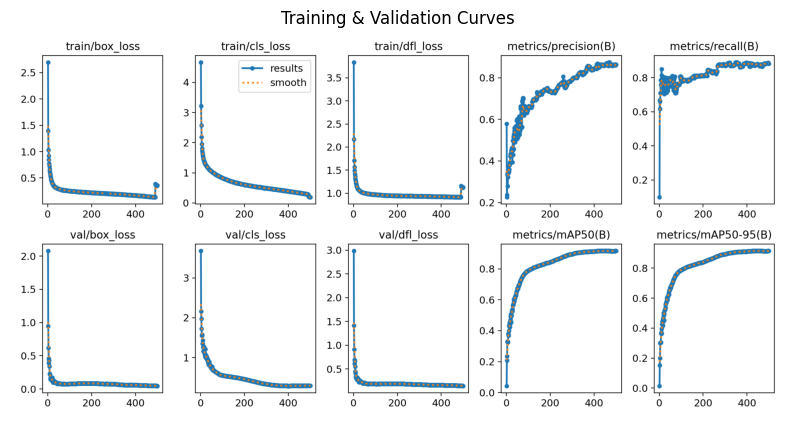

In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

# Replace this with the actual path you found:
plot_path = Path("runs/detect/wildlife_intrusion_final3/results.png")

# Load and show
img = mpimg.imread(plot_path)
plt.figure(figsize=(10,6))
plt.imshow(img)
plt.axis('off')
plt.title("Training & Validation Curves")
plt.show()



image 1/1 /home/user/Downloads/cow.jpg: 640x448 1 cow, 57.8ms
Speed: 2.7ms preprocess, 57.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


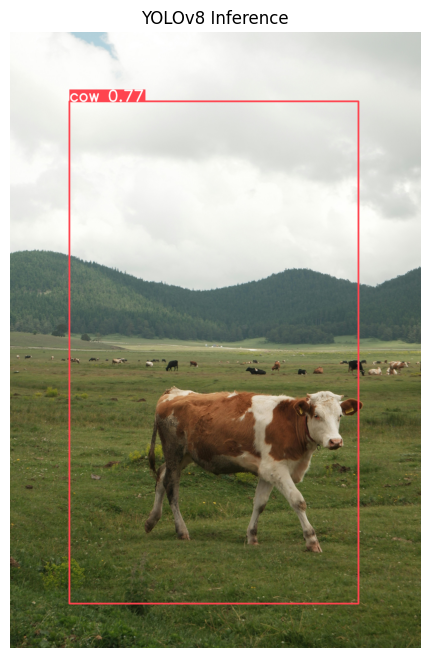

In [55]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

# 1. Path to your saved checkpoint and a test image
weights_path = "runs/detect/wildlife_intrusion_longrun_s/weights/best.pt"
test_img    = "/home/user/Downloads/cow.jpg"  # change to any test image

# 2. Load the model
model = YOLO(weights_path)

# 3. Run inference
results = model.predict(source=test_img, conf=0.25, save=False)

# 4. Draw boxes on the image
annotated = results[0].plot()

# 5. Convert BGR→RGB and display with matplotlib
annotated = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,8))
plt.imshow(annotated)
plt.axis('off')
plt.title("YOLOv8 Inference")
plt.show()
